In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import time
from tqdm import tqdm  # 
from pathlib import Path


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.backends.cudnn.benchmark = True


if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


from models_LN import FNN_LN, dataset, one_hot, cross_entropy_loss, linear, linear_d, tanh, tanh_d, sign, sign_d, sigmoid, sigmoid_d, relu, relu_d, relu6, relu6_d, softmax, softmax_d

torch.set_grad_enabled(False)

cuda:True
GPU 0:NVIDIA GeForce GTX 1650:4.00GB


In [2]:
# -----------------------------------
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', '+', 'x', '|', '_']
linestyles = ['--', '-.', ':', '-']
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime', 'teal', 'olive', 'hotpink']
colors_r = ['darkred', 'red', 'orangered','coral','sandybrown']
colors_b = ['darkblue', 'blue', 'slateblue','deepskyblue','skyblue']
colors_g = ['darkgreen', 'green', 'seagreen','lime','mediumspringgreen']

labelsabc = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
# #----------------

In [3]:

class Config:
    def __init__(self):
        self.n_input = 28 * 28  # 
        self.n_hidd = 16     # 
        self.n_out = 10      # 

        self.nL_hidd = 2

        self.sc_forward = 1
        self.sc_bias = 0
        self.sc_back = 1

        self.f = tanh #  relu tanh
        self.fd = tanh_d # relu_d tanh_d

        self.train_eta_global = 1e-3  #
        self.train_n_epochs = 100     # 
        self.train_batch_size = 500     # 
        self.train_task = "MNIST" #  "MNIST" "FMNIST" "CIFAR10"
        self.train_tmethod = ''     # 'FA','PC','LRA','BP'

        self.biasLearning = False
        
        self.EP_It2sta = 8
        self.EP_nudge = 1
        
config = Config()

In [4]:
train_loader, valid_loader, test_loader, config = dataset(config)
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
valid_loader_gpu = [(data.to(device), target.to(device)) for data, target in valid_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

In [5]:
##
ParaName = f'First_symm_asymm_L3_bsc_Ctime_MLE_SR'
Einfo = ''

config.save = True
config.ff = softmax
config.ffd = softmax_d
# -=--------------------------
config.train_tmethod = 'EP'

config.nL_hidd = 3
config.n_hidd = 64     # 
config.train_n_epochs = 50

config.adam = True
config.EP_b_learn = False
config.EP_f_sc = 1
config.EP_nudge = 0.1
config.EP_It2sta = config.nL_hidd *10 
config.EP_It2sta2 = config.nL_hidd *5

res_path = Path(f"./Res/{ParaName}-{config.train_task}")

bscR = [0.001, 0.01, 0.1, 0.25, 1, 2, 4] # [0.001, 0.01, 0.1, 0.25, 1, 2, 4]
multitest = 5
SRarray, FTMLEarray, MLEarray, convTlarray = (np.zeros([4, len(bscR), multitest]) for _ in range(4))

In [6]:
# -=--------------------------
res_path.mkdir(parents=True, exist_ok=True)
res = np.zeros((2,len(bscR),(multitest),6,config.train_n_epochs))
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f'Current Time: {current_time}')
with open(res_path/"res.txt", "a") as f: 
    f.write(f"===================================================================")       
    f.write(f"Start Time: {current_time}\r\n")

Current Time: 20250917-224122


In [7]:
for isymm,fsymm in enumerate([True, False]):
    config.EP_symm_W = fsymm
    for ibsc, bsc in enumerate(bscR):
        config.EP_b_sc = bsc
        for imul in range(multitest):

            model = FNN_LN(config).to(device)

            for i, (images, labels) in enumerate(train_loader_gpu):
                images = images.view(-1, config.n_input)
                SR, ftmle, mle, conv_time, zall = model.Lyapunov_EP_multisamples(images, y=None, t_e=500, ftmle_FT=20, ret_zall=True, delta_conv= 1e-6)
                SRarray[isymm,ibsc,imul] = (SR)
                FTMLEarray[isymm,ibsc,imul]=(torch.mean(ftmle.cpu()))
                MLEarray[isymm,ibsc,imul]=(torch.mean(mle.cpu()))
                convTlarray[isymm,ibsc,imul]=(torch.mean(conv_time.float()))
                break
            
            for epoch in range(config.train_n_epochs):
                losssum = 0
                train_correct = 0
                train_total = 0
                random.shuffle(train_loader_gpu)
                with tqdm(total=len(train_loader_gpu), desc=f'Epoch {epoch + 1}/{config.train_n_epochs}: ', unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                    for i, (images, labels) in enumerate(train_loader_gpu):
                        # 
                        images = images.view(-1, config.n_input)
                        labels_one_hot = one_hot(labels, config.n_out, device=device)
                        # 
                        outputs = model.forward(images)
                        _, predicted = torch.max(outputs, 1)
                        # 
                        loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                        losssum += loss.item()
                        #
                        outputs = model.backward(images, labels_one_hot, outputs)
                        # 
                        model.update_weights_adam() if config.adam else model.update_weights() #model.update_weights_adam() model.update_weights()
                        # 
                        if i % 10 == 0: 
                            pbar.set_postfix({'loss': f'{losssum/(i+1):.6f}'})  
                            pbar.update(10)

                        train_total += labels.size(0)
                        train_correct += (predicted == labels).sum().item()

                train_accuracy = train_correct / train_total

                # test set -------------------------------------------------------------
                test_correct = 0
                test_total = 0
                # ---------
                for images, labels in test_loader_gpu:
                    images = images.view(-1, config.n_input)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                test_accuracy = test_correct / test_total

                res[isymm][ibsc][imul][0][epoch] = losssum
                res[isymm][ibsc][imul][1][epoch] = train_accuracy
                res[isymm][ibsc][imul][2][epoch] = test_accuracy

                current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
                print(f'\t Loss: {res[isymm][ibsc][imul][0][epoch] :.3f},\t'
                    f'Train : {res[isymm][ibsc][imul][1][epoch] * 100:.2f}%({np.max(res[isymm][ibsc][imul][1]) * 100:.2f}%),\t'
                    f'Test : {res[isymm][ibsc][imul][2][epoch] * 100:.2f}%({np.max(res[isymm][ibsc][imul][2]) * 100:.2f}%),\t'
                    f'Current Time: {current_time}')
               
            
            # best result
            print(f"{fsymm}-{bsc}-{imul} Time: {current_time}, Epochs: {config.train_n_epochs}, Learning Rate: {config.train_eta_global}, "
                f"Best: {max(res[isymm][ibsc][imul][1]) * 100:.2f}%  {max(res[isymm][ibsc][imul][2]) * 100:.2f}%\n") 
            
                
            for i, (images, labels) in enumerate(train_loader_gpu):
                images = images.view(-1, config.n_input)
                SR, ftmle, mle, conv_time, zall = model.Lyapunov_EP_multisamples(images, y=None, t_e=1000, ftmle_FT=config.EP_It2sta, ret_zall=True, delta_conv= 1e-6)
                SRarray[isymm+2,ibsc,imul] = (SR)
                FTMLEarray[isymm+2,ibsc,imul]=(torch.mean(ftmle.cpu()))
                MLEarray[isymm+2,ibsc,imul]=(torch.mean(mle.cpu()))
                convTlarray[isymm+2,ibsc,imul]=(torch.mean(conv_time.float()))
                break
            
        for attempt in range(5):
            try:
                with open(res_path/"res.txt", "a") as f:
                    trainacct = np.max(res[isymm][ibsc][:,1,:], axis=-1)
                    testacct = np.max(res[isymm][ibsc][:,2,:], axis=-1)
                    f.write(f"{fsymm}-{bsc}-{imul} Time: {current_time}: "
                            f"train: {np.mean(trainacct) * 100:.2f}%+-{np.std(trainacct, ddof=1)*100:.2f}% ({np.min(trainacct) * 100:.2f}% {np.max(trainacct) * 100:.2f}%)"
                            f"\t test: {np.mean(testacct) * 100:.2f}%+-{np.std(testacct, ddof=1)*100:.2f}% ({np.min(testacct) * 100:.2f}% {np.max(testacct) * 100:.2f}%)\n")

                    for attr_name in dir(config):
                        if not attr_name.startswith('__') and not callable(getattr(config, attr_name)):  
                            attr_value = getattr(config, attr_name)
                            f.write(f'{attr_name}: {attr_value}  ')  
                    f.write(f'\n\n')  

                break  # 
            except PermissionError:
                if attempt < 5 - 1:
                    print(f"Permission denied, retrying in {5} seconds...")
                    time.sleep(5)
                else:
                    raise  # 

Epoch 1/50:   0%|                                              | 0/120 [00:00<?, ?batch/s]d:\HWC\华为云盘\Codepy\aEP\models_LN.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(self.z, device=self.device)
Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.31batch/s, loss=1.057193]


	 Loss: 122.268,	Train : 72.06%(72.06%),	Test : 86.19%(86.19%),	Current Time: 20250917-224125


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.85batch/s, loss=0.435566]


	 Loss: 51.787,	Train : 87.52%(87.52%),	Test : 89.66%(89.66%),	Current Time: 20250917-224126


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.76batch/s, loss=0.351686]


	 Loss: 42.029,	Train : 89.81%(89.81%),	Test : 90.98%(90.98%),	Current Time: 20250917-224127


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.84batch/s, loss=0.308982]


	 Loss: 37.013,	Train : 90.86%(90.86%),	Test : 91.90%(91.90%),	Current Time: 20250917-224128


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.77batch/s, loss=0.281585]


	 Loss: 33.456,	Train : 91.80%(91.80%),	Test : 92.66%(92.66%),	Current Time: 20250917-224129


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.74batch/s, loss=0.253817]


	 Loss: 30.545,	Train : 92.46%(92.46%),	Test : 93.22%(93.22%),	Current Time: 20250917-224130


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.86batch/s, loss=0.235233]


	 Loss: 28.131,	Train : 93.09%(93.09%),	Test : 93.40%(93.40%),	Current Time: 20250917-224130


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.79batch/s, loss=0.216055]


	 Loss: 25.942,	Train : 93.58%(93.58%),	Test : 93.78%(93.78%),	Current Time: 20250917-224131


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.49batch/s, loss=0.200853]


	 Loss: 24.072,	Train : 94.15%(94.15%),	Test : 94.45%(94.45%),	Current Time: 20250917-224132


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.91batch/s, loss=0.187610]


	 Loss: 22.476,	Train : 94.42%(94.42%),	Test : 94.55%(94.55%),	Current Time: 20250917-224133


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.35batch/s, loss=0.176251]


	 Loss: 20.996,	Train : 94.85%(94.85%),	Test : 95.02%(95.02%),	Current Time: 20250917-224134


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.28batch/s, loss=0.164543]


	 Loss: 19.658,	Train : 95.12%(95.12%),	Test : 95.27%(95.27%),	Current Time: 20250917-224135


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.54batch/s, loss=0.153537]


	 Loss: 18.581,	Train : 95.38%(95.38%),	Test : 95.52%(95.52%),	Current Time: 20250917-224136


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.12batch/s, loss=0.146755]


	 Loss: 17.629,	Train : 95.61%(95.61%),	Test : 95.66%(95.66%),	Current Time: 20250917-224137


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.46batch/s, loss=0.138663]


	 Loss: 16.590,	Train : 95.93%(95.93%),	Test : 95.70%(95.70%),	Current Time: 20250917-224138


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.77batch/s, loss=0.131248]


	 Loss: 15.811,	Train : 96.08%(96.08%),	Test : 95.80%(95.80%),	Current Time: 20250917-224139


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.62batch/s, loss=0.126730]


	 Loss: 15.104,	Train : 96.28%(96.28%),	Test : 95.90%(95.90%),	Current Time: 20250917-224140


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.88batch/s, loss=0.119581]


	 Loss: 14.350,	Train : 96.43%(96.43%),	Test : 96.22%(96.22%),	Current Time: 20250917-224141


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.58batch/s, loss=0.113881]


	 Loss: 13.675,	Train : 96.60%(96.60%),	Test : 96.17%(96.22%),	Current Time: 20250917-224141


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 122.41batch/s, loss=0.109081]


	 Loss: 13.083,	Train : 96.72%(96.72%),	Test : 96.16%(96.22%),	Current Time: 20250917-224142


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.96batch/s, loss=0.104629]


	 Loss: 12.573,	Train : 96.86%(96.86%),	Test : 96.33%(96.33%),	Current Time: 20250917-224143


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.45batch/s, loss=0.100558]


	 Loss: 12.047,	Train : 96.99%(96.99%),	Test : 96.39%(96.39%),	Current Time: 20250917-224144


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.00batch/s, loss=0.096772]


	 Loss: 11.515,	Train : 97.08%(97.08%),	Test : 96.48%(96.48%),	Current Time: 20250917-224145


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.10batch/s, loss=0.091839]


	 Loss: 11.108,	Train : 97.23%(97.23%),	Test : 96.65%(96.65%),	Current Time: 20250917-224146


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.52batch/s, loss=0.089890]


	 Loss: 10.708,	Train : 97.40%(97.40%),	Test : 96.63%(96.65%),	Current Time: 20250917-224147


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.54batch/s, loss=0.084615]


	 Loss: 10.262,	Train : 97.46%(97.46%),	Test : 96.80%(96.80%),	Current Time: 20250917-224148


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.18batch/s, loss=0.082848]


	 Loss: 9.963,	Train : 97.52%(97.52%),	Test : 96.77%(96.80%),	Current Time: 20250917-224149


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 120.95batch/s, loss=0.078460]


	 Loss: 9.488,	Train : 97.64%(97.64%),	Test : 96.90%(96.90%),	Current Time: 20250917-224150


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.57batch/s, loss=0.077224]


	 Loss: 9.245,	Train : 97.72%(97.72%),	Test : 96.76%(96.90%),	Current Time: 20250917-224151


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.05batch/s, loss=0.075098]


	 Loss: 8.940,	Train : 97.84%(97.84%),	Test : 96.85%(96.90%),	Current Time: 20250917-224152


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.84batch/s, loss=0.071733]


	 Loss: 8.597,	Train : 97.92%(97.92%),	Test : 96.94%(96.94%),	Current Time: 20250917-224153


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.82batch/s, loss=0.069920]


	 Loss: 8.369,	Train : 97.95%(97.95%),	Test : 96.89%(96.94%),	Current Time: 20250917-224154


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 120.69batch/s, loss=0.067211]


	 Loss: 8.029,	Train : 98.02%(98.02%),	Test : 96.92%(96.94%),	Current Time: 20250917-224155


Epoch 34/50: 100%|███████████████████| 120/120 [00:01<00:00, 112.62batch/s, loss=0.065126]


	 Loss: 7.764,	Train : 98.08%(98.08%),	Test : 97.11%(97.11%),	Current Time: 20250917-224156


Epoch 35/50: 100%|███████████████████| 120/120 [00:01<00:00, 116.35batch/s, loss=0.062189]


	 Loss: 7.520,	Train : 98.16%(98.16%),	Test : 97.03%(97.11%),	Current Time: 20250917-224157


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.44batch/s, loss=0.061028]


	 Loss: 7.334,	Train : 98.21%(98.21%),	Test : 97.08%(97.11%),	Current Time: 20250917-224158


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.90batch/s, loss=0.057336]


	 Loss: 7.028,	Train : 98.24%(98.24%),	Test : 97.06%(97.11%),	Current Time: 20250917-224159


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.52batch/s, loss=0.057126]


	 Loss: 6.852,	Train : 98.37%(98.37%),	Test : 97.09%(97.11%),	Current Time: 20250917-224200


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.98batch/s, loss=0.054996]


	 Loss: 6.613,	Train : 98.36%(98.37%),	Test : 97.08%(97.11%),	Current Time: 20250917-224201


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.10batch/s, loss=0.053500]


	 Loss: 6.419,	Train : 98.46%(98.46%),	Test : 97.14%(97.14%),	Current Time: 20250917-224202


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.62batch/s, loss=0.051777]


	 Loss: 6.227,	Train : 98.49%(98.49%),	Test : 97.07%(97.14%),	Current Time: 20250917-224203


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.74batch/s, loss=0.051063]


	 Loss: 6.044,	Train : 98.54%(98.54%),	Test : 97.22%(97.22%),	Current Time: 20250917-224204


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.46batch/s, loss=0.048509]


	 Loss: 5.792,	Train : 98.56%(98.56%),	Test : 97.14%(97.22%),	Current Time: 20250917-224204


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.50batch/s, loss=0.046932]


	 Loss: 5.677,	Train : 98.63%(98.63%),	Test : 97.21%(97.22%),	Current Time: 20250917-224205


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.07batch/s, loss=0.045340]


	 Loss: 5.443,	Train : 98.72%(98.72%),	Test : 97.21%(97.22%),	Current Time: 20250917-224206


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.49batch/s, loss=0.043869]


	 Loss: 5.304,	Train : 98.70%(98.72%),	Test : 97.20%(97.22%),	Current Time: 20250917-224207


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.60batch/s, loss=0.042794]


	 Loss: 5.187,	Train : 98.76%(98.76%),	Test : 97.31%(97.31%),	Current Time: 20250917-224208


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.98batch/s, loss=0.041223]


	 Loss: 4.964,	Train : 98.81%(98.81%),	Test : 97.31%(97.31%),	Current Time: 20250917-224209


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.62batch/s, loss=0.039462]


	 Loss: 4.785,	Train : 98.89%(98.89%),	Test : 97.31%(97.31%),	Current Time: 20250917-224210


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.61batch/s, loss=0.039366]


	 Loss: 4.708,	Train : 98.91%(98.91%),	Test : 97.41%(97.41%),	Current Time: 20250917-224211
True-0.001-0 Time: 20250917-224211, Epochs: 50, Learning Rate: 0.001, Best: 98.91%  97.41%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.67batch/s, loss=1.060711]


	 Loss: 122.390,	Train : 71.31%(71.31%),	Test : 85.46%(85.46%),	Current Time: 20250917-224212


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.40batch/s, loss=0.442718]


	 Loss: 52.811,	Train : 87.30%(87.30%),	Test : 88.77%(88.77%),	Current Time: 20250917-224213


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.87batch/s, loss=0.355835]


	 Loss: 42.728,	Train : 89.49%(89.49%),	Test : 90.63%(90.63%),	Current Time: 20250917-224214


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.01batch/s, loss=0.311589]


	 Loss: 37.428,	Train : 90.74%(90.74%),	Test : 91.64%(91.64%),	Current Time: 20250917-224215


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.51batch/s, loss=0.282335]


	 Loss: 33.753,	Train : 91.65%(91.65%),	Test : 92.28%(92.28%),	Current Time: 20250917-224216


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.90batch/s, loss=0.255473]


	 Loss: 30.529,	Train : 92.47%(92.47%),	Test : 93.06%(93.06%),	Current Time: 20250917-224217


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.04batch/s, loss=0.231065]


	 Loss: 27.889,	Train : 93.09%(93.09%),	Test : 93.62%(93.62%),	Current Time: 20250917-224218


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.04batch/s, loss=0.213270]


	 Loss: 25.563,	Train : 93.65%(93.65%),	Test : 94.05%(94.05%),	Current Time: 20250917-224219


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.04batch/s, loss=0.198141]


	 Loss: 23.677,	Train : 94.12%(94.12%),	Test : 94.42%(94.42%),	Current Time: 20250917-224220


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.83batch/s, loss=0.184879]


	 Loss: 22.044,	Train : 94.51%(94.51%),	Test : 94.70%(94.70%),	Current Time: 20250917-224221


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.39batch/s, loss=0.172280]


	 Loss: 20.625,	Train : 94.86%(94.86%),	Test : 95.01%(95.01%),	Current Time: 20250917-224221


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.52batch/s, loss=0.161364]


	 Loss: 19.392,	Train : 95.12%(95.12%),	Test : 95.25%(95.25%),	Current Time: 20250917-224222


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.70batch/s, loss=0.153175]


	 Loss: 18.250,	Train : 95.43%(95.43%),	Test : 95.56%(95.56%),	Current Time: 20250917-224223


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.23batch/s, loss=0.143484]


	 Loss: 17.248,	Train : 95.68%(95.68%),	Test : 95.75%(95.75%),	Current Time: 20250917-224224


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.58batch/s, loss=0.136564]


	 Loss: 16.317,	Train : 95.93%(95.93%),	Test : 95.90%(95.90%),	Current Time: 20250917-224225


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.74batch/s, loss=0.130415]


	 Loss: 15.559,	Train : 96.08%(96.08%),	Test : 96.03%(96.03%),	Current Time: 20250917-224226


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.50batch/s, loss=0.124590]


	 Loss: 14.801,	Train : 96.28%(96.28%),	Test : 96.04%(96.04%),	Current Time: 20250917-224227


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.94batch/s, loss=0.117168]


	 Loss: 14.093,	Train : 96.45%(96.45%),	Test : 96.16%(96.16%),	Current Time: 20250917-224228


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.20batch/s, loss=0.113512]


	 Loss: 13.545,	Train : 96.58%(96.58%),	Test : 96.30%(96.30%),	Current Time: 20250917-224229


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.81batch/s, loss=0.108318]


	 Loss: 12.921,	Train : 96.80%(96.80%),	Test : 96.34%(96.34%),	Current Time: 20250917-224230


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.39batch/s, loss=0.103737]


	 Loss: 12.401,	Train : 96.90%(96.90%),	Test : 96.44%(96.44%),	Current Time: 20250917-224230


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.89batch/s, loss=0.099488]


	 Loss: 11.866,	Train : 97.09%(97.09%),	Test : 96.55%(96.55%),	Current Time: 20250917-224231


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.50batch/s, loss=0.095699]


	 Loss: 11.454,	Train : 97.13%(97.13%),	Test : 96.60%(96.60%),	Current Time: 20250917-224232


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.21batch/s, loss=0.092058]


	 Loss: 10.975,	Train : 97.27%(97.27%),	Test : 96.73%(96.73%),	Current Time: 20250917-224233


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.28batch/s, loss=0.087447]


	 Loss: 10.565,	Train : 97.45%(97.45%),	Test : 96.72%(96.73%),	Current Time: 20250917-224234


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.92batch/s, loss=0.084506]


	 Loss: 10.158,	Train : 97.57%(97.57%),	Test : 96.84%(96.84%),	Current Time: 20250917-224235


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.65batch/s, loss=0.081169]


	 Loss: 9.710,	Train : 97.65%(97.65%),	Test : 96.79%(96.84%),	Current Time: 20250917-224236


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.34batch/s, loss=0.078121]


	 Loss: 9.441,	Train : 97.68%(97.68%),	Test : 96.76%(96.84%),	Current Time: 20250917-224237


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.95batch/s, loss=0.076196]


	 Loss: 9.126,	Train : 97.80%(97.80%),	Test : 96.84%(96.84%),	Current Time: 20250917-224238


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.78batch/s, loss=0.072856]


	 Loss: 8.794,	Train : 97.87%(97.87%),	Test : 97.03%(97.03%),	Current Time: 20250917-224238


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.81batch/s, loss=0.070956]


	 Loss: 8.536,	Train : 97.94%(97.94%),	Test : 96.90%(97.03%),	Current Time: 20250917-224239


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.81batch/s, loss=0.068057]


	 Loss: 8.232,	Train : 98.02%(98.02%),	Test : 96.96%(97.03%),	Current Time: 20250917-224240


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.33batch/s, loss=0.065628]


	 Loss: 7.899,	Train : 98.13%(98.13%),	Test : 96.99%(97.03%),	Current Time: 20250917-224241


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.79batch/s, loss=0.064276]


	 Loss: 7.663,	Train : 98.16%(98.16%),	Test : 96.90%(97.03%),	Current Time: 20250917-224242


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.72batch/s, loss=0.062235]


	 Loss: 7.441,	Train : 98.24%(98.24%),	Test : 97.00%(97.03%),	Current Time: 20250917-224243


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.93batch/s, loss=0.060255]


	 Loss: 7.163,	Train : 98.30%(98.30%),	Test : 97.14%(97.14%),	Current Time: 20250917-224244


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.68batch/s, loss=0.058827]


	 Loss: 7.026,	Train : 98.35%(98.35%),	Test : 97.16%(97.16%),	Current Time: 20250917-224245


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.33batch/s, loss=0.056648]


	 Loss: 6.708,	Train : 98.43%(98.43%),	Test : 97.11%(97.16%),	Current Time: 20250917-224246


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.63batch/s, loss=0.053594]


	 Loss: 6.469,	Train : 98.48%(98.48%),	Test : 97.15%(97.16%),	Current Time: 20250917-224247


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.18batch/s, loss=0.052435]


	 Loss: 6.293,	Train : 98.54%(98.54%),	Test : 97.11%(97.16%),	Current Time: 20250917-224247


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.21batch/s, loss=0.051986]


	 Loss: 6.166,	Train : 98.53%(98.54%),	Test : 97.16%(97.16%),	Current Time: 20250917-224248


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.68batch/s, loss=0.049006]


	 Loss: 5.891,	Train : 98.61%(98.61%),	Test : 97.20%(97.20%),	Current Time: 20250917-224249


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.92batch/s, loss=0.048099]


	 Loss: 5.761,	Train : 98.61%(98.61%),	Test : 97.14%(97.20%),	Current Time: 20250917-224250


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.16batch/s, loss=0.045348]


	 Loss: 5.517,	Train : 98.70%(98.70%),	Test : 97.21%(97.21%),	Current Time: 20250917-224251


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.76batch/s, loss=0.044148]


	 Loss: 5.390,	Train : 98.72%(98.72%),	Test : 97.34%(97.34%),	Current Time: 20250917-224252


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.10batch/s, loss=0.042869]


	 Loss: 5.174,	Train : 98.81%(98.81%),	Test : 97.20%(97.34%),	Current Time: 20250917-224253


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.66batch/s, loss=0.041978]


	 Loss: 5.031,	Train : 98.81%(98.81%),	Test : 97.20%(97.34%),	Current Time: 20250917-224254


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 78.25batch/s, loss=0.040916]


	 Loss: 4.884,	Train : 98.84%(98.84%),	Test : 97.28%(97.34%),	Current Time: 20250917-224255


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.71batch/s, loss=0.039098]


	 Loss: 4.746,	Train : 98.94%(98.94%),	Test : 97.29%(97.34%),	Current Time: 20250917-224257


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.95batch/s, loss=0.037832]


	 Loss: 4.589,	Train : 98.92%(98.94%),	Test : 97.18%(97.34%),	Current Time: 20250917-224258
True-0.001-1 Time: 20250917-224258, Epochs: 50, Learning Rate: 0.001, Best: 98.94%  97.34%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.79batch/s, loss=1.102291]


	 Loss: 127.393,	Train : 69.85%(69.85%),	Test : 85.35%(85.35%),	Current Time: 20250917-224259


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.42batch/s, loss=0.453883]


	 Loss: 53.906,	Train : 86.90%(86.90%),	Test : 89.09%(89.09%),	Current Time: 20250917-224300


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.04batch/s, loss=0.360736]


	 Loss: 42.968,	Train : 89.42%(89.42%),	Test : 90.47%(90.47%),	Current Time: 20250917-224301


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.48batch/s, loss=0.315670]


	 Loss: 37.640,	Train : 90.70%(90.70%),	Test : 91.43%(91.43%),	Current Time: 20250917-224302


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.40batch/s, loss=0.282057]


	 Loss: 33.769,	Train : 91.63%(91.63%),	Test : 92.27%(92.27%),	Current Time: 20250917-224303


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.91batch/s, loss=0.255720]


	 Loss: 30.604,	Train : 92.41%(92.41%),	Test : 92.93%(92.93%),	Current Time: 20250917-224304


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.35batch/s, loss=0.232963]


	 Loss: 27.891,	Train : 93.11%(93.11%),	Test : 93.46%(93.46%),	Current Time: 20250917-224305


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.51batch/s, loss=0.214266]


	 Loss: 25.606,	Train : 93.65%(93.65%),	Test : 94.00%(94.00%),	Current Time: 20250917-224306


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.15batch/s, loss=0.197539]


	 Loss: 23.586,	Train : 94.09%(94.09%),	Test : 94.50%(94.50%),	Current Time: 20250917-224307


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.41batch/s, loss=0.183239]


	 Loss: 21.904,	Train : 94.55%(94.55%),	Test : 94.71%(94.71%),	Current Time: 20250917-224308


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.44batch/s, loss=0.171373]


	 Loss: 20.361,	Train : 94.88%(94.88%),	Test : 94.99%(94.99%),	Current Time: 20250917-224309


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.22batch/s, loss=0.160101]


	 Loss: 19.059,	Train : 95.20%(95.20%),	Test : 95.20%(95.20%),	Current Time: 20250917-224309


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.93batch/s, loss=0.148931]


	 Loss: 18.058,	Train : 95.43%(95.43%),	Test : 95.47%(95.47%),	Current Time: 20250917-224310


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.47batch/s, loss=0.140345]


	 Loss: 16.933,	Train : 95.70%(95.70%),	Test : 95.69%(95.69%),	Current Time: 20250917-224311


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.96batch/s, loss=0.134087]


	 Loss: 16.017,	Train : 95.94%(95.94%),	Test : 95.82%(95.82%),	Current Time: 20250917-224312


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.22batch/s, loss=0.126988]


	 Loss: 15.204,	Train : 96.15%(96.15%),	Test : 95.94%(95.94%),	Current Time: 20250917-224313


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.82batch/s, loss=0.120824]


	 Loss: 14.484,	Train : 96.38%(96.38%),	Test : 95.94%(95.94%),	Current Time: 20250917-224314


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.17batch/s, loss=0.115283]


	 Loss: 13.803,	Train : 96.50%(96.50%),	Test : 95.94%(95.94%),	Current Time: 20250917-224315


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.75batch/s, loss=0.111378]


	 Loss: 13.295,	Train : 96.69%(96.69%),	Test : 96.04%(96.04%),	Current Time: 20250917-224316


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.60batch/s, loss=0.105778]


	 Loss: 12.642,	Train : 96.82%(96.82%),	Test : 96.28%(96.28%),	Current Time: 20250917-224317


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.87batch/s, loss=0.101641]


	 Loss: 12.099,	Train : 96.98%(96.98%),	Test : 96.22%(96.28%),	Current Time: 20250917-224318


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.29batch/s, loss=0.096258]


	 Loss: 11.590,	Train : 97.10%(97.10%),	Test : 96.34%(96.34%),	Current Time: 20250917-224319


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.47batch/s, loss=0.093530]


	 Loss: 11.162,	Train : 97.20%(97.20%),	Test : 96.53%(96.53%),	Current Time: 20250917-224320


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.50batch/s, loss=0.089766]


	 Loss: 10.757,	Train : 97.31%(97.31%),	Test : 96.57%(96.57%),	Current Time: 20250917-224321


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.41batch/s, loss=0.086532]


	 Loss: 10.372,	Train : 97.41%(97.41%),	Test : 96.67%(96.67%),	Current Time: 20250917-224322


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.29batch/s, loss=0.082936]


	 Loss: 9.984,	Train : 97.51%(97.51%),	Test : 96.51%(96.67%),	Current Time: 20250917-224322


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.14batch/s, loss=0.079470]


	 Loss: 9.592,	Train : 97.59%(97.59%),	Test : 96.82%(96.82%),	Current Time: 20250917-224323


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.23batch/s, loss=0.077003]


	 Loss: 9.224,	Train : 97.72%(97.72%),	Test : 96.70%(96.82%),	Current Time: 20250917-224324


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.16batch/s, loss=0.074787]


	 Loss: 8.980,	Train : 97.76%(97.76%),	Test : 96.73%(96.82%),	Current Time: 20250917-224325


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.69batch/s, loss=0.072271]


	 Loss: 8.656,	Train : 97.85%(97.85%),	Test : 96.71%(96.82%),	Current Time: 20250917-224326


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.21batch/s, loss=0.069243]


	 Loss: 8.394,	Train : 97.93%(97.93%),	Test : 96.86%(96.86%),	Current Time: 20250917-224327


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.35batch/s, loss=0.067489]


	 Loss: 8.121,	Train : 97.96%(97.96%),	Test : 96.87%(96.87%),	Current Time: 20250917-224328


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.39batch/s, loss=0.065500]


	 Loss: 7.863,	Train : 98.04%(98.04%),	Test : 96.85%(96.87%),	Current Time: 20250917-224329


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.14batch/s, loss=0.063251]


	 Loss: 7.603,	Train : 98.13%(98.13%),	Test : 96.85%(96.87%),	Current Time: 20250917-224330


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.42batch/s, loss=0.061880]


	 Loss: 7.360,	Train : 98.21%(98.21%),	Test : 96.86%(96.87%),	Current Time: 20250917-224331


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.75batch/s, loss=0.059592]


	 Loss: 7.092,	Train : 98.20%(98.21%),	Test : 96.78%(96.87%),	Current Time: 20250917-224331


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.85batch/s, loss=0.057475]


	 Loss: 6.904,	Train : 98.32%(98.32%),	Test : 96.84%(96.87%),	Current Time: 20250917-224332


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.08batch/s, loss=0.053952]


	 Loss: 6.599,	Train : 98.38%(98.38%),	Test : 96.89%(96.89%),	Current Time: 20250917-224333


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.93batch/s, loss=0.053644]


	 Loss: 6.476,	Train : 98.39%(98.39%),	Test : 96.89%(96.89%),	Current Time: 20250917-224334


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.93batch/s, loss=0.052524]


	 Loss: 6.222,	Train : 98.47%(98.47%),	Test : 96.94%(96.94%),	Current Time: 20250917-224335


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.60batch/s, loss=0.050420]


	 Loss: 6.053,	Train : 98.50%(98.50%),	Test : 97.02%(97.02%),	Current Time: 20250917-224336


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.65batch/s, loss=0.047725]


	 Loss: 5.828,	Train : 98.56%(98.56%),	Test : 96.75%(97.02%),	Current Time: 20250917-224337


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.73batch/s, loss=0.047206]


	 Loss: 5.627,	Train : 98.63%(98.63%),	Test : 97.13%(97.13%),	Current Time: 20250917-224338


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.96batch/s, loss=0.045956]


	 Loss: 5.499,	Train : 98.66%(98.66%),	Test : 96.92%(97.13%),	Current Time: 20250917-224339


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.80batch/s, loss=0.043426]


	 Loss: 5.262,	Train : 98.70%(98.70%),	Test : 96.99%(97.13%),	Current Time: 20250917-224340


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.67batch/s, loss=0.043261]


	 Loss: 5.130,	Train : 98.76%(98.76%),	Test : 97.08%(97.13%),	Current Time: 20250917-224341


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.15batch/s, loss=0.041390]


	 Loss: 4.916,	Train : 98.82%(98.82%),	Test : 96.98%(97.13%),	Current Time: 20250917-224342


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.57batch/s, loss=0.040188]


	 Loss: 4.820,	Train : 98.88%(98.88%),	Test : 97.07%(97.13%),	Current Time: 20250917-224343


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.36batch/s, loss=0.038875]


	 Loss: 4.704,	Train : 98.88%(98.88%),	Test : 97.02%(97.13%),	Current Time: 20250917-224344


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.76batch/s, loss=0.037883]


	 Loss: 4.529,	Train : 98.96%(98.96%),	Test : 97.10%(97.13%),	Current Time: 20250917-224344
True-0.001-2 Time: 20250917-224344, Epochs: 50, Learning Rate: 0.001, Best: 98.96%  97.13%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.74batch/s, loss=1.117910]


	 Loss: 129.053,	Train : 69.52%(69.52%),	Test : 84.70%(84.70%),	Current Time: 20250917-224346


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.34batch/s, loss=0.457379]


	 Loss: 54.429,	Train : 86.78%(86.78%),	Test : 89.15%(89.15%),	Current Time: 20250917-224347


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.89batch/s, loss=0.359272]


	 Loss: 42.840,	Train : 89.39%(89.39%),	Test : 90.75%(90.75%),	Current Time: 20250917-224348


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.80batch/s, loss=0.310253]


	 Loss: 37.149,	Train : 90.87%(90.87%),	Test : 91.74%(91.74%),	Current Time: 20250917-224349


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.28batch/s, loss=0.276688]


	 Loss: 33.277,	Train : 91.70%(91.70%),	Test : 92.37%(92.37%),	Current Time: 20250917-224350


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.21batch/s, loss=0.252313]


	 Loss: 30.097,	Train : 92.62%(92.62%),	Test : 92.96%(92.96%),	Current Time: 20250917-224351


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.04batch/s, loss=0.227932]


	 Loss: 27.418,	Train : 93.20%(93.20%),	Test : 93.49%(93.49%),	Current Time: 20250917-224352


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.27batch/s, loss=0.213583]


	 Loss: 25.327,	Train : 93.81%(93.81%),	Test : 93.95%(93.95%),	Current Time: 20250917-224353


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.55batch/s, loss=0.197680]


	 Loss: 23.494,	Train : 94.23%(94.23%),	Test : 94.13%(94.13%),	Current Time: 20250917-224353


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.34batch/s, loss=0.182461]


	 Loss: 21.917,	Train : 94.55%(94.55%),	Test : 94.56%(94.56%),	Current Time: 20250917-224354


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.16batch/s, loss=0.171597]


	 Loss: 20.438,	Train : 94.99%(94.99%),	Test : 94.65%(94.65%),	Current Time: 20250917-224355


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.71batch/s, loss=0.159649]


	 Loss: 19.257,	Train : 95.25%(95.25%),	Test : 95.06%(95.06%),	Current Time: 20250917-224356


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.40batch/s, loss=0.150820]


	 Loss: 18.087,	Train : 95.48%(95.48%),	Test : 95.25%(95.25%),	Current Time: 20250917-224357


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.53batch/s, loss=0.141309]


	 Loss: 17.089,	Train : 95.72%(95.72%),	Test : 95.43%(95.43%),	Current Time: 20250917-224358


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.08batch/s, loss=0.134795]


	 Loss: 16.160,	Train : 95.96%(95.96%),	Test : 95.45%(95.45%),	Current Time: 20250917-224359


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.97batch/s, loss=0.128490]


	 Loss: 15.392,	Train : 96.19%(96.19%),	Test : 95.62%(95.62%),	Current Time: 20250917-224400


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.79batch/s, loss=0.122596]


	 Loss: 14.644,	Train : 96.36%(96.36%),	Test : 95.75%(95.75%),	Current Time: 20250917-224401


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.36batch/s, loss=0.114962]


	 Loss: 13.936,	Train : 96.52%(96.52%),	Test : 95.97%(95.97%),	Current Time: 20250917-224402


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.33batch/s, loss=0.111671]


	 Loss: 13.373,	Train : 96.66%(96.66%),	Test : 96.04%(96.04%),	Current Time: 20250917-224403


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.56batch/s, loss=0.105530]


	 Loss: 12.743,	Train : 96.84%(96.84%),	Test : 96.19%(96.19%),	Current Time: 20250917-224404


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.06batch/s, loss=0.101939]


	 Loss: 12.234,	Train : 96.93%(96.93%),	Test : 96.26%(96.26%),	Current Time: 20250917-224405


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.13batch/s, loss=0.098609]


	 Loss: 11.744,	Train : 97.06%(97.06%),	Test : 96.45%(96.45%),	Current Time: 20250917-224406


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.05batch/s, loss=0.094471]


	 Loss: 11.281,	Train : 97.18%(97.18%),	Test : 96.52%(96.52%),	Current Time: 20250917-224407


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.46batch/s, loss=0.090177]


	 Loss: 10.827,	Train : 97.30%(97.30%),	Test : 96.47%(96.52%),	Current Time: 20250917-224408


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.66batch/s, loss=0.087216]


	 Loss: 10.420,	Train : 97.38%(97.38%),	Test : 96.53%(96.53%),	Current Time: 20250917-224408


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.12batch/s, loss=0.083300]


	 Loss: 10.059,	Train : 97.48%(97.48%),	Test : 96.62%(96.62%),	Current Time: 20250917-224409


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.33batch/s, loss=0.081498]


	 Loss: 9.738,	Train : 97.53%(97.53%),	Test : 96.78%(96.78%),	Current Time: 20250917-224410


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.61batch/s, loss=0.078065]


	 Loss: 9.401,	Train : 97.66%(97.66%),	Test : 96.82%(96.82%),	Current Time: 20250917-224411


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.09batch/s, loss=0.075394]


	 Loss: 9.069,	Train : 97.72%(97.72%),	Test : 96.83%(96.83%),	Current Time: 20250917-224412


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.85batch/s, loss=0.072704]


	 Loss: 8.727,	Train : 97.83%(97.83%),	Test : 96.82%(96.83%),	Current Time: 20250917-224413


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.06batch/s, loss=0.070545]


	 Loss: 8.449,	Train : 97.86%(97.86%),	Test : 96.93%(96.93%),	Current Time: 20250917-224414


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.16batch/s, loss=0.068430]


	 Loss: 8.196,	Train : 97.93%(97.93%),	Test : 96.85%(96.93%),	Current Time: 20250917-224415


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.49batch/s, loss=0.065298]


	 Loss: 7.926,	Train : 98.00%(98.00%),	Test : 97.05%(97.05%),	Current Time: 20250917-224416


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.66batch/s, loss=0.063413]


	 Loss: 7.654,	Train : 98.07%(98.07%),	Test : 96.99%(97.05%),	Current Time: 20250917-224417


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.52batch/s, loss=0.061979]


	 Loss: 7.421,	Train : 98.13%(98.13%),	Test : 97.10%(97.10%),	Current Time: 20250917-224418


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.61batch/s, loss=0.059000]


	 Loss: 7.196,	Train : 98.18%(98.18%),	Test : 96.97%(97.10%),	Current Time: 20250917-224418


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.23batch/s, loss=0.058378]


	 Loss: 7.004,	Train : 98.28%(98.28%),	Test : 97.04%(97.10%),	Current Time: 20250917-224419


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.99batch/s, loss=0.056125]


	 Loss: 6.717,	Train : 98.32%(98.32%),	Test : 97.08%(97.10%),	Current Time: 20250917-224420


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.93batch/s, loss=0.054013]


	 Loss: 6.528,	Train : 98.36%(98.36%),	Test : 97.18%(97.18%),	Current Time: 20250917-224421


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.64batch/s, loss=0.052849]


	 Loss: 6.343,	Train : 98.43%(98.43%),	Test : 97.20%(97.20%),	Current Time: 20250917-224422


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.20batch/s, loss=0.050700]


	 Loss: 6.125,	Train : 98.50%(98.50%),	Test : 97.23%(97.23%),	Current Time: 20250917-224423


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.94batch/s, loss=0.049988]


	 Loss: 5.937,	Train : 98.52%(98.52%),	Test : 97.29%(97.29%),	Current Time: 20250917-224424


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.32batch/s, loss=0.047418]


	 Loss: 5.819,	Train : 98.58%(98.58%),	Test : 97.26%(97.29%),	Current Time: 20250917-224425


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.65batch/s, loss=0.046315]


	 Loss: 5.594,	Train : 98.62%(98.62%),	Test : 97.10%(97.29%),	Current Time: 20250917-224426


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.73batch/s, loss=0.044860]


	 Loss: 5.436,	Train : 98.67%(98.67%),	Test : 97.19%(97.29%),	Current Time: 20250917-224427


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.96batch/s, loss=0.044004]


	 Loss: 5.286,	Train : 98.69%(98.69%),	Test : 97.09%(97.29%),	Current Time: 20250917-224428


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.00batch/s, loss=0.042406]


	 Loss: 5.098,	Train : 98.78%(98.78%),	Test : 97.22%(97.29%),	Current Time: 20250917-224429


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.87batch/s, loss=0.041299]


	 Loss: 4.907,	Train : 98.83%(98.83%),	Test : 97.23%(97.29%),	Current Time: 20250917-224430


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.11batch/s, loss=0.039522]


	 Loss: 4.755,	Train : 98.89%(98.89%),	Test : 97.33%(97.33%),	Current Time: 20250917-224431


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.24batch/s, loss=0.037702]


	 Loss: 4.599,	Train : 98.91%(98.91%),	Test : 97.29%(97.33%),	Current Time: 20250917-224432
True-0.001-3 Time: 20250917-224432, Epochs: 50, Learning Rate: 0.001, Best: 98.91%  97.33%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.78batch/s, loss=1.112378]


	 Loss: 128.554,	Train : 69.73%(69.73%),	Test : 86.04%(86.04%),	Current Time: 20250917-224433


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.17batch/s, loss=0.446703]


	 Loss: 53.146,	Train : 87.41%(87.41%),	Test : 89.21%(89.21%),	Current Time: 20250917-224434


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 122.70batch/s, loss=0.353994]


	 Loss: 42.489,	Train : 89.70%(89.70%),	Test : 91.01%(91.01%),	Current Time: 20250917-224435


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 122.60batch/s, loss=0.312579]


	 Loss: 37.349,	Train : 90.93%(90.93%),	Test : 91.61%(91.61%),	Current Time: 20250917-224436


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.98batch/s, loss=0.281941]


	 Loss: 33.844,	Train : 91.70%(91.70%),	Test : 92.42%(92.42%),	Current Time: 20250917-224437


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.47batch/s, loss=0.257883]


	 Loss: 31.006,	Train : 92.33%(92.33%),	Test : 92.94%(92.94%),	Current Time: 20250917-224438


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.88batch/s, loss=0.238253]


	 Loss: 28.511,	Train : 92.96%(92.96%),	Test : 93.31%(93.31%),	Current Time: 20250917-224439


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.27batch/s, loss=0.217594]


	 Loss: 26.230,	Train : 93.56%(93.56%),	Test : 93.83%(93.83%),	Current Time: 20250917-224440


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.24batch/s, loss=0.202584]


	 Loss: 24.291,	Train : 94.00%(94.00%),	Test : 94.25%(94.25%),	Current Time: 20250917-224441


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.59batch/s, loss=0.188958]


	 Loss: 22.534,	Train : 94.46%(94.46%),	Test : 94.45%(94.45%),	Current Time: 20250917-224442


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.86batch/s, loss=0.176162]


	 Loss: 21.063,	Train : 94.83%(94.83%),	Test : 94.66%(94.66%),	Current Time: 20250917-224443


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 121.94batch/s, loss=0.165536]


	 Loss: 19.754,	Train : 95.09%(95.09%),	Test : 94.87%(94.87%),	Current Time: 20250917-224444


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.92batch/s, loss=0.154353]


	 Loss: 18.592,	Train : 95.47%(95.47%),	Test : 95.02%(95.02%),	Current Time: 20250917-224445


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.41batch/s, loss=0.145798]


	 Loss: 17.574,	Train : 95.63%(95.63%),	Test : 95.37%(95.37%),	Current Time: 20250917-224446


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.81batch/s, loss=0.138870]


	 Loss: 16.676,	Train : 95.88%(95.88%),	Test : 95.48%(95.48%),	Current Time: 20250917-224447


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.37batch/s, loss=0.132099]


	 Loss: 15.832,	Train : 96.13%(96.13%),	Test : 95.68%(95.68%),	Current Time: 20250917-224448


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.03batch/s, loss=0.126963]


	 Loss: 15.134,	Train : 96.23%(96.23%),	Test : 95.72%(95.72%),	Current Time: 20250917-224449


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.14batch/s, loss=0.118803]


	 Loss: 14.384,	Train : 96.44%(96.44%),	Test : 95.80%(95.80%),	Current Time: 20250917-224450


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.81batch/s, loss=0.114181]


	 Loss: 13.764,	Train : 96.63%(96.63%),	Test : 95.92%(95.92%),	Current Time: 20250917-224451


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.53batch/s, loss=0.108613]


	 Loss: 13.159,	Train : 96.73%(96.73%),	Test : 95.94%(95.94%),	Current Time: 20250917-224451


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.26batch/s, loss=0.105573]


	 Loss: 12.679,	Train : 96.84%(96.84%),	Test : 96.16%(96.16%),	Current Time: 20250917-224452


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.09batch/s, loss=0.100326]


	 Loss: 12.120,	Train : 96.96%(96.96%),	Test : 96.20%(96.20%),	Current Time: 20250917-224453


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.99batch/s, loss=0.096870]


	 Loss: 11.668,	Train : 97.10%(97.10%),	Test : 96.34%(96.34%),	Current Time: 20250917-224454


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.01batch/s, loss=0.094462]


	 Loss: 11.319,	Train : 97.20%(97.20%),	Test : 96.44%(96.44%),	Current Time: 20250917-224455


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.42batch/s, loss=0.090139]


	 Loss: 10.796,	Train : 97.34%(97.34%),	Test : 96.35%(96.44%),	Current Time: 20250917-224456


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.80batch/s, loss=0.086967]


	 Loss: 10.549,	Train : 97.35%(97.35%),	Test : 96.57%(96.57%),	Current Time: 20250917-224457


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.61batch/s, loss=0.083724]


	 Loss: 10.100,	Train : 97.50%(97.50%),	Test : 96.58%(96.58%),	Current Time: 20250917-224458


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.75batch/s, loss=0.081573]


	 Loss: 9.774,	Train : 97.57%(97.57%),	Test : 96.57%(96.58%),	Current Time: 20250917-224459


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.78batch/s, loss=0.079275]


	 Loss: 9.486,	Train : 97.62%(97.62%),	Test : 96.61%(96.61%),	Current Time: 20250917-224500


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.79batch/s, loss=0.076521]


	 Loss: 9.164,	Train : 97.73%(97.73%),	Test : 96.63%(96.63%),	Current Time: 20250917-224501


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.55batch/s, loss=0.074439]


	 Loss: 8.815,	Train : 97.77%(97.77%),	Test : 96.74%(96.74%),	Current Time: 20250917-224502


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.07batch/s, loss=0.070827]


	 Loss: 8.552,	Train : 97.89%(97.89%),	Test : 96.65%(96.74%),	Current Time: 20250917-224503


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.15batch/s, loss=0.068862]


	 Loss: 8.261,	Train : 97.97%(97.97%),	Test : 96.81%(96.81%),	Current Time: 20250917-224503


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.68batch/s, loss=0.066953]


	 Loss: 8.053,	Train : 97.95%(97.97%),	Test : 96.75%(96.81%),	Current Time: 20250917-224504


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.75batch/s, loss=0.065072]


	 Loss: 7.828,	Train : 98.05%(98.05%),	Test : 96.89%(96.89%),	Current Time: 20250917-224505


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.68batch/s, loss=0.063011]


	 Loss: 7.583,	Train : 98.09%(98.09%),	Test : 96.97%(96.97%),	Current Time: 20250917-224506


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.41batch/s, loss=0.059944]


	 Loss: 7.299,	Train : 98.20%(98.20%),	Test : 96.93%(96.97%),	Current Time: 20250917-224507


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.13batch/s, loss=0.059449]


	 Loss: 7.051,	Train : 98.20%(98.20%),	Test : 97.03%(97.03%),	Current Time: 20250917-224508


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.74batch/s, loss=0.057038]


	 Loss: 6.828,	Train : 98.30%(98.30%),	Test : 97.00%(97.03%),	Current Time: 20250917-224509


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.99batch/s, loss=0.055935]


	 Loss: 6.656,	Train : 98.37%(98.37%),	Test : 97.00%(97.03%),	Current Time: 20250917-224510


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.13batch/s, loss=0.052985]


	 Loss: 6.415,	Train : 98.38%(98.38%),	Test : 97.01%(97.03%),	Current Time: 20250917-224511


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.88batch/s, loss=0.052440]


	 Loss: 6.254,	Train : 98.48%(98.48%),	Test : 97.14%(97.14%),	Current Time: 20250917-224512


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.04batch/s, loss=0.050025]


	 Loss: 6.010,	Train : 98.52%(98.52%),	Test : 97.05%(97.14%),	Current Time: 20250917-224513


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.89batch/s, loss=0.048670]


	 Loss: 5.846,	Train : 98.57%(98.57%),	Test : 97.09%(97.14%),	Current Time: 20250917-224514


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.59batch/s, loss=0.046760]


	 Loss: 5.697,	Train : 98.61%(98.61%),	Test : 97.07%(97.14%),	Current Time: 20250917-224514


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.85batch/s, loss=0.045732]


	 Loss: 5.518,	Train : 98.66%(98.66%),	Test : 97.20%(97.20%),	Current Time: 20250917-224515


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.19batch/s, loss=0.044488]


	 Loss: 5.340,	Train : 98.72%(98.72%),	Test : 97.23%(97.23%),	Current Time: 20250917-224516


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.60batch/s, loss=0.043657]


	 Loss: 5.208,	Train : 98.73%(98.73%),	Test : 97.11%(97.23%),	Current Time: 20250917-224517


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.10batch/s, loss=0.041758]


	 Loss: 5.016,	Train : 98.80%(98.80%),	Test : 97.30%(97.30%),	Current Time: 20250917-224518


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.34batch/s, loss=0.040418]


	 Loss: 4.878,	Train : 98.82%(98.82%),	Test : 97.13%(97.30%),	Current Time: 20250917-224519
True-0.001-4 Time: 20250917-224519, Epochs: 50, Learning Rate: 0.001, Best: 98.82%  97.30%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.87batch/s, loss=0.680380]


	 Loss: 78.527,	Train : 82.24%(82.24%),	Test : 91.41%(91.41%),	Current Time: 20250917-224521


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.08batch/s, loss=0.274096]


	 Loss: 32.633,	Train : 92.06%(92.06%),	Test : 93.40%(93.40%),	Current Time: 20250917-224521


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.86batch/s, loss=0.213598]


	 Loss: 25.359,	Train : 93.85%(93.85%),	Test : 94.58%(94.58%),	Current Time: 20250917-224522


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.13batch/s, loss=0.172294]


	 Loss: 20.517,	Train : 95.06%(95.06%),	Test : 95.23%(95.23%),	Current Time: 20250917-224523


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.99batch/s, loss=0.143396]


	 Loss: 17.156,	Train : 95.84%(95.84%),	Test : 95.72%(95.72%),	Current Time: 20250917-224524


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.58batch/s, loss=0.122042]


	 Loss: 14.694,	Train : 96.37%(96.37%),	Test : 96.04%(96.04%),	Current Time: 20250917-224525


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.79batch/s, loss=0.107459]


	 Loss: 12.864,	Train : 96.89%(96.89%),	Test : 96.53%(96.53%),	Current Time: 20250917-224526


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.05batch/s, loss=0.093792]


	 Loss: 11.196,	Train : 97.25%(97.25%),	Test : 96.60%(96.60%),	Current Time: 20250917-224527


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.78batch/s, loss=0.083486]


	 Loss: 10.031,	Train : 97.53%(97.53%),	Test : 96.73%(96.73%),	Current Time: 20250917-224528


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.74batch/s, loss=0.075023]


	 Loss: 9.026,	Train : 97.77%(97.77%),	Test : 96.87%(96.87%),	Current Time: 20250917-224529


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.83batch/s, loss=0.066371]


	 Loss: 7.976,	Train : 98.06%(98.06%),	Test : 96.93%(96.93%),	Current Time: 20250917-224530


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.37batch/s, loss=0.060546]


	 Loss: 7.303,	Train : 98.22%(98.22%),	Test : 97.17%(97.17%),	Current Time: 20250917-224531


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.79batch/s, loss=0.054255]


	 Loss: 6.643,	Train : 98.32%(98.32%),	Test : 97.06%(97.17%),	Current Time: 20250917-224532


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.49batch/s, loss=0.050836]


	 Loss: 6.070,	Train : 98.48%(98.48%),	Test : 97.03%(97.17%),	Current Time: 20250917-224533


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.51batch/s, loss=0.045759]


	 Loss: 5.476,	Train : 98.69%(98.69%),	Test : 97.20%(97.20%),	Current Time: 20250917-224534


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.85batch/s, loss=0.041240]


	 Loss: 5.069,	Train : 98.82%(98.82%),	Test : 97.19%(97.20%),	Current Time: 20250917-224534


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.74batch/s, loss=0.037259]


	 Loss: 4.496,	Train : 98.92%(98.92%),	Test : 97.13%(97.20%),	Current Time: 20250917-224535


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.46batch/s, loss=0.034238]


	 Loss: 4.160,	Train : 99.05%(99.05%),	Test : 97.24%(97.24%),	Current Time: 20250917-224536


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.39batch/s, loss=0.030423]


	 Loss: 3.720,	Train : 99.12%(99.12%),	Test : 97.27%(97.27%),	Current Time: 20250917-224537


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.56batch/s, loss=0.028492]


	 Loss: 3.449,	Train : 99.20%(99.20%),	Test : 97.45%(97.45%),	Current Time: 20250917-224538


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.93batch/s, loss=0.024861]


	 Loss: 3.093,	Train : 99.31%(99.31%),	Test : 97.31%(97.45%),	Current Time: 20250917-224539


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.54batch/s, loss=0.024335]


	 Loss: 2.910,	Train : 99.33%(99.33%),	Test : 97.40%(97.45%),	Current Time: 20250917-224540


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.67batch/s, loss=0.021784]


	 Loss: 2.588,	Train : 99.46%(99.46%),	Test : 97.55%(97.55%),	Current Time: 20250917-224541


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.97batch/s, loss=0.018113]


	 Loss: 2.198,	Train : 99.54%(99.54%),	Test : 97.51%(97.55%),	Current Time: 20250917-224542


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.01batch/s, loss=0.016843]


	 Loss: 2.002,	Train : 99.63%(99.63%),	Test : 97.47%(97.55%),	Current Time: 20250917-224543


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.39batch/s, loss=0.016219]


	 Loss: 1.920,	Train : 99.63%(99.63%),	Test : 97.27%(97.55%),	Current Time: 20250917-224543


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.42batch/s, loss=0.016562]


	 Loss: 1.978,	Train : 99.55%(99.63%),	Test : 97.52%(97.55%),	Current Time: 20250917-224544


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.59batch/s, loss=0.012780]


	 Loss: 1.547,	Train : 99.70%(99.70%),	Test : 97.19%(97.55%),	Current Time: 20250917-224545


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.36batch/s, loss=0.011414]


	 Loss: 1.372,	Train : 99.76%(99.76%),	Test : 97.48%(97.55%),	Current Time: 20250917-224546


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.72batch/s, loss=0.009808]


	 Loss: 1.188,	Train : 99.80%(99.80%),	Test : 97.48%(97.55%),	Current Time: 20250917-224547


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.10batch/s, loss=0.008858]


	 Loss: 1.066,	Train : 99.83%(99.83%),	Test : 97.43%(97.55%),	Current Time: 20250917-224548


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=0.008495]


	 Loss: 1.025,	Train : 99.83%(99.83%),	Test : 97.51%(97.55%),	Current Time: 20250917-224549


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.44batch/s, loss=0.007823]


	 Loss: 0.944,	Train : 99.85%(99.85%),	Test : 97.41%(97.55%),	Current Time: 20250917-224549


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.20batch/s, loss=0.005991]


	 Loss: 0.725,	Train : 99.90%(99.90%),	Test : 97.47%(97.55%),	Current Time: 20250917-224550


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.32batch/s, loss=0.004996]


	 Loss: 0.612,	Train : 99.95%(99.95%),	Test : 97.47%(97.55%),	Current Time: 20250917-224551


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.04batch/s, loss=0.004228]


	 Loss: 0.510,	Train : 99.96%(99.96%),	Test : 97.52%(97.55%),	Current Time: 20250917-224552


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.77batch/s, loss=0.003405]


	 Loss: 0.412,	Train : 99.98%(99.98%),	Test : 97.50%(97.55%),	Current Time: 20250917-224553


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.65batch/s, loss=0.003114]


	 Loss: 0.376,	Train : 99.98%(99.98%),	Test : 97.42%(97.55%),	Current Time: 20250917-224554


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.93batch/s, loss=0.002649]


	 Loss: 0.316,	Train : 99.98%(99.98%),	Test : 97.45%(97.55%),	Current Time: 20250917-224555


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.29batch/s, loss=0.002263]


	 Loss: 0.270,	Train : 99.99%(99.99%),	Test : 97.48%(97.55%),	Current Time: 20250917-224556


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.72batch/s, loss=0.002083]


	 Loss: 0.248,	Train : 99.99%(99.99%),	Test : 97.53%(97.55%),	Current Time: 20250917-224557


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.19batch/s, loss=0.001886]


	 Loss: 0.225,	Train : 99.99%(99.99%),	Test : 97.48%(97.55%),	Current Time: 20250917-224557


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.72batch/s, loss=0.001619]


	 Loss: 0.196,	Train : 100.00%(100.00%),	Test : 97.49%(97.55%),	Current Time: 20250917-224558


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.05batch/s, loss=0.001468]


	 Loss: 0.176,	Train : 100.00%(100.00%),	Test : 97.50%(97.55%),	Current Time: 20250917-224559


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.09batch/s, loss=0.001178]


	 Loss: 0.144,	Train : 100.00%(100.00%),	Test : 97.46%(97.55%),	Current Time: 20250917-224600


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.57batch/s, loss=0.001057]


	 Loss: 0.127,	Train : 100.00%(100.00%),	Test : 97.50%(97.55%),	Current Time: 20250917-224601


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.49batch/s, loss=0.001020]


	 Loss: 0.121,	Train : 100.00%(100.00%),	Test : 97.53%(97.55%),	Current Time: 20250917-224602


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.67batch/s, loss=0.000896]


	 Loss: 0.108,	Train : 100.00%(100.00%),	Test : 97.52%(97.55%),	Current Time: 20250917-224603


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.69batch/s, loss=0.000863]


	 Loss: 0.106,	Train : 100.00%(100.00%),	Test : 97.55%(97.55%),	Current Time: 20250917-224604


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.53batch/s, loss=0.000720]


	 Loss: 0.086,	Train : 100.00%(100.00%),	Test : 97.57%(97.57%),	Current Time: 20250917-224604
True-0.01-0 Time: 20250917-224604, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.57%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.56batch/s, loss=0.681475]


	 Loss: 78.517,	Train : 81.98%(81.98%),	Test : 91.70%(91.70%),	Current Time: 20250917-224606


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.16batch/s, loss=0.267624]


	 Loss: 31.961,	Train : 92.40%(92.40%),	Test : 93.57%(93.57%),	Current Time: 20250917-224607


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.70batch/s, loss=0.205914]


	 Loss: 24.535,	Train : 94.11%(94.11%),	Test : 94.66%(94.66%),	Current Time: 20250917-224608


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.77batch/s, loss=0.165730]


	 Loss: 19.870,	Train : 95.19%(95.19%),	Test : 95.07%(95.07%),	Current Time: 20250917-224609


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.79batch/s, loss=0.138466]


	 Loss: 16.485,	Train : 95.96%(95.96%),	Test : 95.84%(95.84%),	Current Time: 20250917-224610


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.78batch/s, loss=0.117885]


	 Loss: 14.093,	Train : 96.56%(96.56%),	Test : 96.22%(96.22%),	Current Time: 20250917-224611


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.11batch/s, loss=0.104402]


	 Loss: 12.370,	Train : 96.97%(96.97%),	Test : 96.45%(96.45%),	Current Time: 20250917-224611


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 122.64batch/s, loss=0.091164]


	 Loss: 10.847,	Train : 97.31%(97.31%),	Test : 96.60%(96.60%),	Current Time: 20250917-224612


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.44batch/s, loss=0.080422]


	 Loss: 9.601,	Train : 97.67%(97.67%),	Test : 96.91%(96.91%),	Current Time: 20250917-224613


Epoch 10/50: 100%|███████████████████| 120/120 [00:01<00:00, 113.29batch/s, loss=0.071977]


	 Loss: 8.590,	Train : 97.89%(97.89%),	Test : 96.96%(96.96%),	Current Time: 20250917-224615


Epoch 11/50: 100%|███████████████████| 120/120 [00:01<00:00, 117.88batch/s, loss=0.064917]


	 Loss: 7.789,	Train : 98.04%(98.04%),	Test : 97.04%(97.04%),	Current Time: 20250917-224616


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 121.20batch/s, loss=0.058368]


	 Loss: 6.993,	Train : 98.27%(98.27%),	Test : 97.26%(97.26%),	Current Time: 20250917-224617


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.53batch/s, loss=0.052557]


	 Loss: 6.416,	Train : 98.40%(98.40%),	Test : 97.16%(97.26%),	Current Time: 20250917-224618


Epoch 14/50: 100%|███████████████████| 120/120 [00:01<00:00, 119.05batch/s, loss=0.048136]


	 Loss: 5.803,	Train : 98.50%(98.50%),	Test : 97.25%(97.26%),	Current Time: 20250917-224619


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.63batch/s, loss=0.042341]


	 Loss: 5.088,	Train : 98.78%(98.78%),	Test : 97.54%(97.54%),	Current Time: 20250917-224620


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.08batch/s, loss=0.038619]


	 Loss: 4.709,	Train : 98.85%(98.85%),	Test : 97.36%(97.54%),	Current Time: 20250917-224621


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.11batch/s, loss=0.035236]


	 Loss: 4.235,	Train : 98.95%(98.95%),	Test : 97.56%(97.56%),	Current Time: 20250917-224621


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.22batch/s, loss=0.031763]


	 Loss: 3.764,	Train : 99.15%(99.15%),	Test : 97.51%(97.56%),	Current Time: 20250917-224622


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.30batch/s, loss=0.028760]


	 Loss: 3.494,	Train : 99.20%(99.20%),	Test : 97.32%(97.56%),	Current Time: 20250917-224623


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.23batch/s, loss=0.025388]


	 Loss: 3.070,	Train : 99.32%(99.32%),	Test : 97.57%(97.57%),	Current Time: 20250917-224624


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.52batch/s, loss=0.023711]


	 Loss: 2.829,	Train : 99.34%(99.34%),	Test : 97.50%(97.57%),	Current Time: 20250917-224625


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.67batch/s, loss=0.022268]


	 Loss: 2.687,	Train : 99.43%(99.43%),	Test : 97.45%(97.57%),	Current Time: 20250917-224626


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.67batch/s, loss=0.019234]


	 Loss: 2.296,	Train : 99.54%(99.54%),	Test : 97.60%(97.60%),	Current Time: 20250917-224627


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.12batch/s, loss=0.017307]


	 Loss: 2.092,	Train : 99.58%(99.58%),	Test : 97.58%(97.60%),	Current Time: 20250917-224628


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.70batch/s, loss=0.017091]


	 Loss: 2.051,	Train : 99.54%(99.58%),	Test : 97.59%(97.60%),	Current Time: 20250917-224629


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.74batch/s, loss=0.013679]


	 Loss: 1.669,	Train : 99.72%(99.72%),	Test : 97.54%(97.60%),	Current Time: 20250917-224629


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.79batch/s, loss=0.012101]


	 Loss: 1.483,	Train : 99.72%(99.72%),	Test : 97.38%(97.60%),	Current Time: 20250917-224630


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.63batch/s, loss=0.011936]


	 Loss: 1.442,	Train : 99.75%(99.75%),	Test : 97.65%(97.65%),	Current Time: 20250917-224631


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.00batch/s, loss=0.009797]


	 Loss: 1.196,	Train : 99.79%(99.79%),	Test : 97.32%(97.65%),	Current Time: 20250917-224632


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.83batch/s, loss=0.009666]


	 Loss: 1.190,	Train : 99.79%(99.79%),	Test : 97.42%(97.65%),	Current Time: 20250917-224633


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.67batch/s, loss=0.011444]


	 Loss: 1.352,	Train : 99.72%(99.79%),	Test : 97.53%(97.65%),	Current Time: 20250917-224634


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.64batch/s, loss=0.009065]


	 Loss: 1.078,	Train : 99.82%(99.82%),	Test : 97.59%(97.65%),	Current Time: 20250917-224635


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.57batch/s, loss=0.006878]


	 Loss: 0.822,	Train : 99.89%(99.89%),	Test : 97.69%(97.69%),	Current Time: 20250917-224636


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.26batch/s, loss=0.006191]


	 Loss: 0.743,	Train : 99.90%(99.90%),	Test : 97.43%(97.69%),	Current Time: 20250917-224637


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.25batch/s, loss=0.005351]


	 Loss: 0.659,	Train : 99.92%(99.92%),	Test : 97.54%(97.69%),	Current Time: 20250917-224638


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.52batch/s, loss=0.004467]


	 Loss: 0.544,	Train : 99.95%(99.95%),	Test : 97.45%(97.69%),	Current Time: 20250917-224638


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.69batch/s, loss=0.004379]


	 Loss: 0.522,	Train : 99.95%(99.95%),	Test : 97.52%(97.69%),	Current Time: 20250917-224639


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.34batch/s, loss=0.003868]


	 Loss: 0.468,	Train : 99.95%(99.95%),	Test : 97.49%(97.69%),	Current Time: 20250917-224640


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.83batch/s, loss=0.004107]


	 Loss: 0.517,	Train : 99.92%(99.95%),	Test : 97.41%(97.69%),	Current Time: 20250917-224641


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.22batch/s, loss=0.003637]


	 Loss: 0.466,	Train : 99.93%(99.95%),	Test : 97.48%(97.69%),	Current Time: 20250917-224642


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.24batch/s, loss=0.003617]


	 Loss: 0.426,	Train : 99.95%(99.95%),	Test : 97.49%(97.69%),	Current Time: 20250917-224643


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.24batch/s, loss=0.002906]


	 Loss: 0.360,	Train : 99.96%(99.96%),	Test : 97.66%(97.69%),	Current Time: 20250917-224644


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.37batch/s, loss=0.001998]


	 Loss: 0.242,	Train : 99.99%(99.99%),	Test : 97.62%(97.69%),	Current Time: 20250917-224645


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.45batch/s, loss=0.001519]


	 Loss: 0.182,	Train : 100.00%(100.00%),	Test : 97.60%(97.69%),	Current Time: 20250917-224646


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.21batch/s, loss=0.001328]


	 Loss: 0.162,	Train : 100.00%(100.00%),	Test : 97.46%(97.69%),	Current Time: 20250917-224646


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.21batch/s, loss=0.001097]


	 Loss: 0.132,	Train : 100.00%(100.00%),	Test : 97.59%(97.69%),	Current Time: 20250917-224647


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.23batch/s, loss=0.000934]


	 Loss: 0.114,	Train : 100.00%(100.00%),	Test : 97.52%(97.69%),	Current Time: 20250917-224648


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.68batch/s, loss=0.001077]


	 Loss: 0.126,	Train : 100.00%(100.00%),	Test : 97.69%(97.69%),	Current Time: 20250917-224649


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.09batch/s, loss=0.000806]


	 Loss: 0.097,	Train : 100.00%(100.00%),	Test : 97.62%(97.69%),	Current Time: 20250917-224650


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.00batch/s, loss=0.000709]


	 Loss: 0.085,	Train : 100.00%(100.00%),	Test : 97.66%(97.69%),	Current Time: 20250917-224651
True-0.01-1 Time: 20250917-224651, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.69%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.53batch/s, loss=0.695552]


	 Loss: 80.277,	Train : 82.23%(82.23%),	Test : 91.18%(91.18%),	Current Time: 20250917-224652


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.54batch/s, loss=0.276346]


	 Loss: 32.732,	Train : 92.12%(92.12%),	Test : 93.49%(93.49%),	Current Time: 20250917-224653


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.09batch/s, loss=0.211077]


	 Loss: 25.314,	Train : 93.81%(93.81%),	Test : 94.39%(94.39%),	Current Time: 20250917-224654


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.65batch/s, loss=0.171855]


	 Loss: 20.402,	Train : 95.06%(95.06%),	Test : 95.36%(95.36%),	Current Time: 20250917-224655


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 127.25batch/s, loss=0.142030]


	 Loss: 17.047,	Train : 95.79%(95.79%),	Test : 95.73%(95.73%),	Current Time: 20250917-224656


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.44batch/s, loss=0.120213]


	 Loss: 14.446,	Train : 96.44%(96.44%),	Test : 96.22%(96.22%),	Current Time: 20250917-224657


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.13batch/s, loss=0.105685]


	 Loss: 12.652,	Train : 96.92%(96.92%),	Test : 96.41%(96.41%),	Current Time: 20250917-224658


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.47batch/s, loss=0.092675]


	 Loss: 11.080,	Train : 97.25%(97.25%),	Test : 96.68%(96.68%),	Current Time: 20250917-224659


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.19batch/s, loss=0.081435]


	 Loss: 9.736,	Train : 97.61%(97.61%),	Test : 96.70%(96.70%),	Current Time: 20250917-224700


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 122.97batch/s, loss=0.074680]


	 Loss: 8.933,	Train : 97.82%(97.82%),	Test : 96.93%(96.93%),	Current Time: 20250917-224701


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.42batch/s, loss=0.067206]


	 Loss: 8.022,	Train : 98.08%(98.08%),	Test : 97.03%(97.03%),	Current Time: 20250917-224702


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.73batch/s, loss=0.060141]


	 Loss: 7.192,	Train : 98.26%(98.26%),	Test : 97.06%(97.06%),	Current Time: 20250917-224703


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 122.37batch/s, loss=0.055203]


	 Loss: 6.637,	Train : 98.36%(98.36%),	Test : 97.22%(97.22%),	Current Time: 20250917-224704


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.83batch/s, loss=0.048605]


	 Loss: 5.904,	Train : 98.59%(98.59%),	Test : 97.26%(97.26%),	Current Time: 20250917-224705


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.94batch/s, loss=0.044103]


	 Loss: 5.330,	Train : 98.73%(98.73%),	Test : 97.24%(97.26%),	Current Time: 20250917-224706


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.35batch/s, loss=0.041060]


	 Loss: 4.889,	Train : 98.80%(98.80%),	Test : 97.33%(97.33%),	Current Time: 20250917-224707


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.80batch/s, loss=0.037837]


	 Loss: 4.525,	Train : 98.92%(98.92%),	Test : 97.42%(97.42%),	Current Time: 20250917-224708


Epoch 18/50: 100%|███████████████████| 120/120 [00:01<00:00, 117.59batch/s, loss=0.032937]


	 Loss: 4.065,	Train : 99.03%(99.03%),	Test : 97.37%(97.42%),	Current Time: 20250917-224709


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.67batch/s, loss=0.030914]


	 Loss: 3.733,	Train : 99.10%(99.10%),	Test : 97.29%(97.42%),	Current Time: 20250917-224710


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.20batch/s, loss=0.027755]


	 Loss: 3.341,	Train : 99.20%(99.20%),	Test : 97.33%(97.42%),	Current Time: 20250917-224711


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.70batch/s, loss=0.027337]


	 Loss: 3.218,	Train : 99.23%(99.23%),	Test : 97.50%(97.50%),	Current Time: 20250917-224712


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.94batch/s, loss=0.022792]


	 Loss: 2.801,	Train : 99.36%(99.36%),	Test : 97.49%(97.50%),	Current Time: 20250917-224712


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.23batch/s, loss=0.020466]


	 Loss: 2.444,	Train : 99.44%(99.44%),	Test : 97.43%(97.50%),	Current Time: 20250917-224713


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=0.018652]


	 Loss: 2.294,	Train : 99.50%(99.50%),	Test : 97.28%(97.50%),	Current Time: 20250917-224714


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.34batch/s, loss=0.016782]


	 Loss: 2.044,	Train : 99.56%(99.56%),	Test : 97.31%(97.50%),	Current Time: 20250917-224715


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.74batch/s, loss=0.015481]


	 Loss: 1.888,	Train : 99.65%(99.65%),	Test : 97.18%(97.50%),	Current Time: 20250917-224716


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.47batch/s, loss=0.013585]


	 Loss: 1.665,	Train : 99.66%(99.66%),	Test : 97.39%(97.50%),	Current Time: 20250917-224717


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.96batch/s, loss=0.012392]


	 Loss: 1.497,	Train : 99.73%(99.73%),	Test : 97.35%(97.50%),	Current Time: 20250917-224718


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.61batch/s, loss=0.010823]


	 Loss: 1.313,	Train : 99.79%(99.79%),	Test : 97.44%(97.50%),	Current Time: 20250917-224719


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.60batch/s, loss=0.009110]


	 Loss: 1.096,	Train : 99.83%(99.83%),	Test : 97.36%(97.50%),	Current Time: 20250917-224720


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.13batch/s, loss=0.008317]


	 Loss: 0.993,	Train : 99.87%(99.87%),	Test : 97.51%(97.51%),	Current Time: 20250917-224721


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.72batch/s, loss=0.007132]


	 Loss: 0.863,	Train : 99.88%(99.88%),	Test : 97.36%(97.51%),	Current Time: 20250917-224722


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.34batch/s, loss=0.006583]


	 Loss: 0.805,	Train : 99.91%(99.91%),	Test : 97.46%(97.51%),	Current Time: 20250917-224722


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.85batch/s, loss=0.007445]


	 Loss: 0.899,	Train : 99.87%(99.91%),	Test : 97.48%(97.51%),	Current Time: 20250917-224723


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.51batch/s, loss=0.005261]


	 Loss: 0.644,	Train : 99.92%(99.92%),	Test : 97.39%(97.51%),	Current Time: 20250917-224724


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.09batch/s, loss=0.004551]


	 Loss: 0.569,	Train : 99.94%(99.94%),	Test : 97.45%(97.51%),	Current Time: 20250917-224725


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.98batch/s, loss=0.004002]


	 Loss: 0.476,	Train : 99.96%(99.96%),	Test : 97.53%(97.53%),	Current Time: 20250917-224726


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.30batch/s, loss=0.003890]


	 Loss: 0.461,	Train : 99.94%(99.96%),	Test : 97.48%(97.53%),	Current Time: 20250917-224727


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.21batch/s, loss=0.003617]


	 Loss: 0.439,	Train : 99.96%(99.96%),	Test : 97.46%(97.53%),	Current Time: 20250917-224728


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.76batch/s, loss=0.002717]


	 Loss: 0.332,	Train : 99.98%(99.98%),	Test : 97.46%(97.53%),	Current Time: 20250917-224729


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.51batch/s, loss=0.002035]


	 Loss: 0.247,	Train : 100.00%(100.00%),	Test : 97.43%(97.53%),	Current Time: 20250917-224730


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.87batch/s, loss=0.001793]


	 Loss: 0.218,	Train : 99.99%(100.00%),	Test : 97.47%(97.53%),	Current Time: 20250917-224731


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.48batch/s, loss=0.001576]


	 Loss: 0.192,	Train : 100.00%(100.00%),	Test : 97.46%(97.53%),	Current Time: 20250917-224732


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.09batch/s, loss=0.001415]


	 Loss: 0.170,	Train : 100.00%(100.00%),	Test : 97.49%(97.53%),	Current Time: 20250917-224732


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.92batch/s, loss=0.001215]


	 Loss: 0.147,	Train : 100.00%(100.00%),	Test : 97.54%(97.54%),	Current Time: 20250917-224733


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.12batch/s, loss=0.001221]


	 Loss: 0.146,	Train : 100.00%(100.00%),	Test : 97.44%(97.54%),	Current Time: 20250917-224734


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.46batch/s, loss=0.001037]


	 Loss: 0.123,	Train : 100.00%(100.00%),	Test : 97.50%(97.54%),	Current Time: 20250917-224735


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.48batch/s, loss=0.000883]


	 Loss: 0.107,	Train : 100.00%(100.00%),	Test : 97.44%(97.54%),	Current Time: 20250917-224736


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.09batch/s, loss=0.000773]


	 Loss: 0.093,	Train : 100.00%(100.00%),	Test : 97.48%(97.54%),	Current Time: 20250917-224737


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.44batch/s, loss=0.000696]


	 Loss: 0.084,	Train : 100.00%(100.00%),	Test : 97.49%(97.54%),	Current Time: 20250917-224738
True-0.01-2 Time: 20250917-224738, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.54%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.38batch/s, loss=0.675770]


	 Loss: 78.047,	Train : 82.79%(82.79%),	Test : 91.16%(91.16%),	Current Time: 20250917-224739


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.42batch/s, loss=0.274955]


	 Loss: 32.721,	Train : 92.07%(92.07%),	Test : 93.05%(93.05%),	Current Time: 20250917-224740


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.98batch/s, loss=0.210496]


	 Loss: 25.151,	Train : 93.88%(93.88%),	Test : 94.39%(94.39%),	Current Time: 20250917-224741


Epoch 4/50: 100%|████████████████████| 120/120 [00:01<00:00, 116.73batch/s, loss=0.169566]


	 Loss: 20.207,	Train : 95.09%(95.09%),	Test : 95.42%(95.42%),	Current Time: 20250917-224742


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.49batch/s, loss=0.141212]


	 Loss: 16.808,	Train : 95.92%(95.92%),	Test : 95.97%(95.97%),	Current Time: 20250917-224743


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.60batch/s, loss=0.119667]


	 Loss: 14.359,	Train : 96.53%(96.53%),	Test : 95.92%(95.97%),	Current Time: 20250917-224744


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.42batch/s, loss=0.103735]


	 Loss: 12.425,	Train : 96.97%(96.97%),	Test : 96.51%(96.51%),	Current Time: 20250917-224745


Epoch 8/50: 100%|████████████████████| 120/120 [00:01<00:00, 118.01batch/s, loss=0.091582]


	 Loss: 10.985,	Train : 97.31%(97.31%),	Test : 96.78%(96.78%),	Current Time: 20250917-224746


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.18batch/s, loss=0.081846]


	 Loss: 9.838,	Train : 97.56%(97.56%),	Test : 96.83%(96.83%),	Current Time: 20250917-224747


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.25batch/s, loss=0.073736]


	 Loss: 8.828,	Train : 97.86%(97.86%),	Test : 96.80%(96.83%),	Current Time: 20250917-224748


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.15batch/s, loss=0.065951]


	 Loss: 7.869,	Train : 98.01%(98.01%),	Test : 97.14%(97.14%),	Current Time: 20250917-224749


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.93batch/s, loss=0.059710]


	 Loss: 7.151,	Train : 98.18%(98.18%),	Test : 97.26%(97.26%),	Current Time: 20250917-224750


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.88batch/s, loss=0.053857]


	 Loss: 6.433,	Train : 98.39%(98.39%),	Test : 97.22%(97.26%),	Current Time: 20250917-224751


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.29batch/s, loss=0.048954]


	 Loss: 5.899,	Train : 98.61%(98.61%),	Test : 97.20%(97.26%),	Current Time: 20250917-224752


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.09batch/s, loss=0.044262]


	 Loss: 5.303,	Train : 98.74%(98.74%),	Test : 97.14%(97.26%),	Current Time: 20250917-224753


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.80batch/s, loss=0.040192]


	 Loss: 4.817,	Train : 98.82%(98.82%),	Test : 97.28%(97.28%),	Current Time: 20250917-224754


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.28batch/s, loss=0.035740]


	 Loss: 4.308,	Train : 99.00%(99.00%),	Test : 97.37%(97.37%),	Current Time: 20250917-224755


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.70batch/s, loss=0.031677]


	 Loss: 3.859,	Train : 99.11%(99.11%),	Test : 97.45%(97.45%),	Current Time: 20250917-224756


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.43batch/s, loss=0.030124]


	 Loss: 3.606,	Train : 99.19%(99.19%),	Test : 96.93%(97.45%),	Current Time: 20250917-224756


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.41batch/s, loss=0.028375]


	 Loss: 3.356,	Train : 99.23%(99.23%),	Test : 97.39%(97.45%),	Current Time: 20250917-224757


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.63batch/s, loss=0.025835]


	 Loss: 3.133,	Train : 99.25%(99.25%),	Test : 97.51%(97.51%),	Current Time: 20250917-224758


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.79batch/s, loss=0.024589]


	 Loss: 2.928,	Train : 99.32%(99.32%),	Test : 97.40%(97.51%),	Current Time: 20250917-224759


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.04batch/s, loss=0.021348]


	 Loss: 2.550,	Train : 99.43%(99.43%),	Test : 97.33%(97.51%),	Current Time: 20250917-224800


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.64batch/s, loss=0.018909]


	 Loss: 2.250,	Train : 99.54%(99.54%),	Test : 97.46%(97.51%),	Current Time: 20250917-224801


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.98batch/s, loss=0.016800]


	 Loss: 2.016,	Train : 99.62%(99.62%),	Test : 97.40%(97.51%),	Current Time: 20250917-224802


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.62batch/s, loss=0.014446]


	 Loss: 1.778,	Train : 99.66%(99.66%),	Test : 97.35%(97.51%),	Current Time: 20250917-224803


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.56batch/s, loss=0.014344]


	 Loss: 1.724,	Train : 99.66%(99.66%),	Test : 97.34%(97.51%),	Current Time: 20250917-224804


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.39batch/s, loss=0.013383]


	 Loss: 1.603,	Train : 99.67%(99.67%),	Test : 97.47%(97.51%),	Current Time: 20250917-224805


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.81batch/s, loss=0.011739]


	 Loss: 1.392,	Train : 99.73%(99.73%),	Test : 97.50%(97.51%),	Current Time: 20250917-224805


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.21batch/s, loss=0.009947]


	 Loss: 1.194,	Train : 99.81%(99.81%),	Test : 97.30%(97.51%),	Current Time: 20250917-224806


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.66batch/s, loss=0.010666]


	 Loss: 1.320,	Train : 99.73%(99.81%),	Test : 97.17%(97.51%),	Current Time: 20250917-224807


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.07batch/s, loss=0.009032]


	 Loss: 1.080,	Train : 99.81%(99.81%),	Test : 97.50%(97.51%),	Current Time: 20250917-224808


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.76batch/s, loss=0.006448]


	 Loss: 0.817,	Train : 99.89%(99.89%),	Test : 97.33%(97.51%),	Current Time: 20250917-224809


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.87batch/s, loss=0.006756]


	 Loss: 0.795,	Train : 99.91%(99.91%),	Test : 97.33%(97.51%),	Current Time: 20250917-224810


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.30batch/s, loss=0.005623]


	 Loss: 0.680,	Train : 99.92%(99.92%),	Test : 97.35%(97.51%),	Current Time: 20250917-224811


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.09batch/s, loss=0.004604]


	 Loss: 0.550,	Train : 99.95%(99.95%),	Test : 97.35%(97.51%),	Current Time: 20250917-224812


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.51batch/s, loss=0.003462]


	 Loss: 0.424,	Train : 99.97%(99.97%),	Test : 97.39%(97.51%),	Current Time: 20250917-224813


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.90batch/s, loss=0.004090]


	 Loss: 0.502,	Train : 99.95%(99.97%),	Test : 97.35%(97.51%),	Current Time: 20250917-224814


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.82batch/s, loss=0.004057]


	 Loss: 0.498,	Train : 99.95%(99.97%),	Test : 97.23%(97.51%),	Current Time: 20250917-224815


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.37batch/s, loss=0.003681]


	 Loss: 0.492,	Train : 99.95%(99.97%),	Test : 97.42%(97.51%),	Current Time: 20250917-224815


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.44batch/s, loss=0.003818]


	 Loss: 0.454,	Train : 99.96%(99.97%),	Test : 97.42%(97.51%),	Current Time: 20250917-224816


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.48batch/s, loss=0.002938]


	 Loss: 0.355,	Train : 99.97%(99.97%),	Test : 97.48%(97.51%),	Current Time: 20250917-224817


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.94batch/s, loss=0.003284]


	 Loss: 0.406,	Train : 99.94%(99.97%),	Test : 97.40%(97.51%),	Current Time: 20250917-224818


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.87batch/s, loss=0.002729]


	 Loss: 0.322,	Train : 99.97%(99.97%),	Test : 97.41%(97.51%),	Current Time: 20250917-224819


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.72batch/s, loss=0.001470]


	 Loss: 0.175,	Train : 100.00%(100.00%),	Test : 97.43%(97.51%),	Current Time: 20250917-224820


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.68batch/s, loss=0.001190]


	 Loss: 0.146,	Train : 100.00%(100.00%),	Test : 97.37%(97.51%),	Current Time: 20250917-224821


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.18batch/s, loss=0.001176]


	 Loss: 0.143,	Train : 100.00%(100.00%),	Test : 97.40%(97.51%),	Current Time: 20250917-224822


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.06batch/s, loss=0.000939]


	 Loss: 0.114,	Train : 100.00%(100.00%),	Test : 97.42%(97.51%),	Current Time: 20250917-224823


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.48batch/s, loss=0.000756]


	 Loss: 0.096,	Train : 100.00%(100.00%),	Test : 97.47%(97.51%),	Current Time: 20250917-224824


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.10batch/s, loss=0.000711]


	 Loss: 0.085,	Train : 100.00%(100.00%),	Test : 97.34%(97.51%),	Current Time: 20250917-224824
True-0.01-3 Time: 20250917-224824, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.51%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.54batch/s, loss=0.696079]


	 Loss: 80.289,	Train : 82.09%(82.09%),	Test : 91.50%(91.50%),	Current Time: 20250917-224826


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.18batch/s, loss=0.274779]


	 Loss: 32.813,	Train : 92.15%(92.15%),	Test : 93.46%(93.46%),	Current Time: 20250917-224827


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.92batch/s, loss=0.212324]


	 Loss: 25.072,	Train : 93.90%(93.90%),	Test : 94.11%(94.11%),	Current Time: 20250917-224828


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 124.30batch/s, loss=0.169199]


	 Loss: 20.188,	Train : 95.14%(95.14%),	Test : 95.38%(95.38%),	Current Time: 20250917-224829


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.72batch/s, loss=0.141089]


	 Loss: 16.841,	Train : 95.93%(95.93%),	Test : 95.89%(95.89%),	Current Time: 20250917-224830


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.22batch/s, loss=0.118773]


	 Loss: 14.275,	Train : 96.54%(96.54%),	Test : 96.18%(96.18%),	Current Time: 20250917-224831


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.42batch/s, loss=0.103547]


	 Loss: 12.417,	Train : 96.93%(96.93%),	Test : 96.34%(96.34%),	Current Time: 20250917-224832


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.72batch/s, loss=0.091306]


	 Loss: 10.858,	Train : 97.31%(97.31%),	Test : 96.72%(96.72%),	Current Time: 20250917-224833


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.16batch/s, loss=0.080116]


	 Loss: 9.597,	Train : 97.68%(97.68%),	Test : 96.84%(96.84%),	Current Time: 20250917-224834


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.43batch/s, loss=0.072200]


	 Loss: 8.576,	Train : 97.95%(97.95%),	Test : 97.03%(97.03%),	Current Time: 20250917-224835


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.90batch/s, loss=0.064570]


	 Loss: 7.783,	Train : 98.08%(98.08%),	Test : 97.20%(97.20%),	Current Time: 20250917-224836


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.43batch/s, loss=0.057061]


	 Loss: 6.868,	Train : 98.37%(98.37%),	Test : 97.15%(97.20%),	Current Time: 20250917-224836


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.53batch/s, loss=0.052357]


	 Loss: 6.249,	Train : 98.54%(98.54%),	Test : 97.43%(97.43%),	Current Time: 20250917-224837


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.83batch/s, loss=0.046491]


	 Loss: 5.576,	Train : 98.64%(98.64%),	Test : 97.56%(97.56%),	Current Time: 20250917-224838


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.36batch/s, loss=0.042458]


	 Loss: 5.136,	Train : 98.75%(98.75%),	Test : 97.45%(97.56%),	Current Time: 20250917-224839


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.67batch/s, loss=0.040325]


	 Loss: 4.765,	Train : 98.87%(98.87%),	Test : 97.46%(97.56%),	Current Time: 20250917-224840


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.98batch/s, loss=0.035245]


	 Loss: 4.240,	Train : 99.02%(99.02%),	Test : 97.48%(97.56%),	Current Time: 20250917-224841


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.94batch/s, loss=0.032076]


	 Loss: 3.875,	Train : 99.07%(99.07%),	Test : 97.56%(97.56%),	Current Time: 20250917-224842


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.34batch/s, loss=0.029136]


	 Loss: 3.546,	Train : 99.18%(99.18%),	Test : 97.57%(97.57%),	Current Time: 20250917-224843


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.49batch/s, loss=0.026176]


	 Loss: 3.169,	Train : 99.30%(99.30%),	Test : 97.57%(97.57%),	Current Time: 20250917-224844


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.54batch/s, loss=0.023512]


	 Loss: 2.829,	Train : 99.38%(99.38%),	Test : 97.56%(97.57%),	Current Time: 20250917-224845


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.25batch/s, loss=0.022819]


	 Loss: 2.700,	Train : 99.41%(99.41%),	Test : 97.62%(97.62%),	Current Time: 20250917-224846


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.96batch/s, loss=0.018179]


	 Loss: 2.233,	Train : 99.58%(99.58%),	Test : 97.66%(97.66%),	Current Time: 20250917-224847


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.87batch/s, loss=0.018166]


	 Loss: 2.142,	Train : 99.56%(99.58%),	Test : 97.37%(97.66%),	Current Time: 20250917-224848


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.85batch/s, loss=0.015824]


	 Loss: 1.919,	Train : 99.62%(99.62%),	Test : 97.62%(97.66%),	Current Time: 20250917-224848


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.28batch/s, loss=0.013618]


	 Loss: 1.707,	Train : 99.69%(99.69%),	Test : 97.55%(97.66%),	Current Time: 20250917-224849


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.29batch/s, loss=0.013238]


	 Loss: 1.591,	Train : 99.67%(99.69%),	Test : 97.53%(97.66%),	Current Time: 20250917-224850


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.89batch/s, loss=0.012109]


	 Loss: 1.438,	Train : 99.76%(99.76%),	Test : 97.49%(97.66%),	Current Time: 20250917-224851


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.24batch/s, loss=0.011006]


	 Loss: 1.323,	Train : 99.77%(99.77%),	Test : 97.56%(97.66%),	Current Time: 20250917-224852


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.78batch/s, loss=0.009245]


	 Loss: 1.116,	Train : 99.83%(99.83%),	Test : 97.68%(97.68%),	Current Time: 20250917-224853


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.34batch/s, loss=0.008516]


	 Loss: 1.037,	Train : 99.84%(99.84%),	Test : 97.33%(97.68%),	Current Time: 20250917-224854


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.72batch/s, loss=0.007670]


	 Loss: 0.967,	Train : 99.84%(99.84%),	Test : 97.55%(97.68%),	Current Time: 20250917-224855


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.96batch/s, loss=0.005903]


	 Loss: 0.702,	Train : 99.93%(99.93%),	Test : 97.51%(97.68%),	Current Time: 20250917-224856


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.02batch/s, loss=0.004860]


	 Loss: 0.629,	Train : 99.94%(99.94%),	Test : 97.57%(97.68%),	Current Time: 20250917-224857


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.59batch/s, loss=0.004771]


	 Loss: 0.575,	Train : 99.94%(99.94%),	Test : 97.72%(97.72%),	Current Time: 20250917-224857


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.87batch/s, loss=0.004647]


	 Loss: 0.559,	Train : 99.94%(99.94%),	Test : 97.55%(97.72%),	Current Time: 20250917-224858


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.10batch/s, loss=0.003842]


	 Loss: 0.459,	Train : 99.96%(99.96%),	Test : 97.63%(97.72%),	Current Time: 20250917-224859


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.36batch/s, loss=0.003100]


	 Loss: 0.365,	Train : 99.99%(99.99%),	Test : 97.60%(97.72%),	Current Time: 20250917-224900


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.38batch/s, loss=0.002610]


	 Loss: 0.310,	Train : 99.99%(99.99%),	Test : 97.68%(97.72%),	Current Time: 20250917-224901


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.97batch/s, loss=0.002298]


	 Loss: 0.273,	Train : 99.99%(99.99%),	Test : 97.71%(97.72%),	Current Time: 20250917-224902


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.92batch/s, loss=0.002665]


	 Loss: 0.339,	Train : 99.98%(99.99%),	Test : 97.50%(97.72%),	Current Time: 20250917-224903


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.64batch/s, loss=0.002526]


	 Loss: 0.340,	Train : 99.97%(99.99%),	Test : 97.42%(97.72%),	Current Time: 20250917-224904


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.54batch/s, loss=0.007588]


	 Loss: 0.960,	Train : 99.78%(99.99%),	Test : 97.45%(97.72%),	Current Time: 20250917-224905


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.19batch/s, loss=0.007186]


	 Loss: 0.886,	Train : 99.79%(99.99%),	Test : 97.47%(97.72%),	Current Time: 20250917-224905


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.36batch/s, loss=0.008910]


	 Loss: 1.060,	Train : 99.72%(99.99%),	Test : 97.59%(97.72%),	Current Time: 20250917-224906


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.02batch/s, loss=0.003189]


	 Loss: 0.383,	Train : 99.95%(99.99%),	Test : 97.63%(97.72%),	Current Time: 20250917-224907


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.35batch/s, loss=0.001732]


	 Loss: 0.201,	Train : 99.99%(99.99%),	Test : 97.76%(97.76%),	Current Time: 20250917-224908


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.47batch/s, loss=0.001137]


	 Loss: 0.140,	Train : 100.00%(100.00%),	Test : 97.72%(97.76%),	Current Time: 20250917-224909


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.99batch/s, loss=0.000983]


	 Loss: 0.116,	Train : 100.00%(100.00%),	Test : 97.75%(97.76%),	Current Time: 20250917-224910


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.59batch/s, loss=0.000856]


	 Loss: 0.101,	Train : 100.00%(100.00%),	Test : 97.71%(97.76%),	Current Time: 20250917-224911
True-0.01-4 Time: 20250917-224911, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.76%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.33batch/s, loss=0.600889]


	 Loss: 69.456,	Train : 84.51%(84.51%),	Test : 92.15%(92.15%),	Current Time: 20250917-224912


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.86batch/s, loss=0.238870]


	 Loss: 28.333,	Train : 93.24%(93.24%),	Test : 94.16%(94.16%),	Current Time: 20250917-224913


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.77batch/s, loss=0.177080]


	 Loss: 21.113,	Train : 94.88%(94.88%),	Test : 95.24%(95.24%),	Current Time: 20250917-224914


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 127.98batch/s, loss=0.139078]


	 Loss: 16.734,	Train : 95.91%(95.91%),	Test : 95.92%(95.92%),	Current Time: 20250917-224915


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.60batch/s, loss=0.113028]


	 Loss: 13.559,	Train : 96.66%(96.66%),	Test : 96.24%(96.24%),	Current Time: 20250917-224916


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.30batch/s, loss=0.095731]


	 Loss: 11.542,	Train : 97.17%(97.17%),	Test : 96.63%(96.63%),	Current Time: 20250917-224917


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.76batch/s, loss=0.080936]


	 Loss: 9.714,	Train : 97.63%(97.63%),	Test : 97.06%(97.06%),	Current Time: 20250917-224918


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.46batch/s, loss=0.069683]


	 Loss: 8.412,	Train : 97.91%(97.91%),	Test : 96.98%(97.06%),	Current Time: 20250917-224919


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.47batch/s, loss=0.061242]


	 Loss: 7.359,	Train : 98.23%(98.23%),	Test : 97.20%(97.20%),	Current Time: 20250917-224920


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 120.83batch/s, loss=0.053252]


	 Loss: 6.412,	Train : 98.42%(98.42%),	Test : 97.12%(97.20%),	Current Time: 20250917-224921


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.54batch/s, loss=0.047932]


	 Loss: 5.821,	Train : 98.55%(98.55%),	Test : 97.18%(97.20%),	Current Time: 20250917-224922


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.89batch/s, loss=0.041214]


	 Loss: 4.973,	Train : 98.75%(98.75%),	Test : 97.31%(97.31%),	Current Time: 20250917-224923


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.39batch/s, loss=0.034900]


	 Loss: 4.203,	Train : 98.96%(98.96%),	Test : 97.48%(97.48%),	Current Time: 20250917-224924


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.44batch/s, loss=0.032551]


	 Loss: 3.981,	Train : 99.00%(99.00%),	Test : 97.18%(97.48%),	Current Time: 20250917-224925


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.09batch/s, loss=0.030559]


	 Loss: 3.696,	Train : 99.05%(99.05%),	Test : 97.45%(97.48%),	Current Time: 20250917-224926


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.50batch/s, loss=0.026306]


	 Loss: 3.136,	Train : 99.24%(99.24%),	Test : 97.22%(97.48%),	Current Time: 20250917-224927


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.70batch/s, loss=0.022059]


	 Loss: 2.679,	Train : 99.34%(99.34%),	Test : 97.33%(97.48%),	Current Time: 20250917-224928


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.14batch/s, loss=0.020276]


	 Loss: 2.490,	Train : 99.40%(99.40%),	Test : 97.31%(97.48%),	Current Time: 20250917-224929


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.08batch/s, loss=0.019303]


	 Loss: 2.299,	Train : 99.46%(99.46%),	Test : 97.27%(97.48%),	Current Time: 20250917-224930


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.84batch/s, loss=0.016906]


	 Loss: 2.047,	Train : 99.51%(99.51%),	Test : 97.27%(97.48%),	Current Time: 20250917-224930


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.47batch/s, loss=0.017428]


	 Loss: 2.139,	Train : 99.48%(99.51%),	Test : 97.41%(97.48%),	Current Time: 20250917-224931


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.61batch/s, loss=0.016582]


	 Loss: 2.025,	Train : 99.47%(99.51%),	Test : 97.38%(97.48%),	Current Time: 20250917-224932


Epoch 23/50: 100%|███████████████████| 120/120 [00:01<00:00, 112.70batch/s, loss=0.013048]


	 Loss: 1.545,	Train : 99.63%(99.63%),	Test : 97.38%(97.48%),	Current Time: 20250917-224933


Epoch 24/50: 100%|███████████████████| 120/120 [00:01<00:00, 114.98batch/s, loss=0.010929]


	 Loss: 1.329,	Train : 99.68%(99.68%),	Test : 97.28%(97.48%),	Current Time: 20250917-224934


Epoch 25/50: 100%|███████████████████| 120/120 [00:01<00:00, 118.46batch/s, loss=0.018262]


	 Loss: 2.174,	Train : 99.41%(99.68%),	Test : 97.35%(97.48%),	Current Time: 20250917-224936


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 121.66batch/s, loss=0.013399]


	 Loss: 1.690,	Train : 99.56%(99.68%),	Test : 97.45%(97.48%),	Current Time: 20250917-224937


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.27batch/s, loss=0.010087]


	 Loss: 1.211,	Train : 99.69%(99.69%),	Test : 97.25%(97.48%),	Current Time: 20250917-224937


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.98batch/s, loss=0.008223]


	 Loss: 0.980,	Train : 99.78%(99.78%),	Test : 97.41%(97.48%),	Current Time: 20250917-224938


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.21batch/s, loss=0.011298]


	 Loss: 1.378,	Train : 99.64%(99.78%),	Test : 97.34%(97.48%),	Current Time: 20250917-224939


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.27batch/s, loss=0.010359]


	 Loss: 1.256,	Train : 99.65%(99.78%),	Test : 97.39%(97.48%),	Current Time: 20250917-224940


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.85batch/s, loss=0.008353]


	 Loss: 1.046,	Train : 99.75%(99.78%),	Test : 97.15%(97.48%),	Current Time: 20250917-224941


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.32batch/s, loss=0.008845]


	 Loss: 1.063,	Train : 99.73%(99.78%),	Test : 97.38%(97.48%),	Current Time: 20250917-224942


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.25batch/s, loss=0.009464]


	 Loss: 1.140,	Train : 99.76%(99.78%),	Test : 97.34%(97.48%),	Current Time: 20250917-224943


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.19batch/s, loss=0.010931]


	 Loss: 1.286,	Train : 99.66%(99.78%),	Test : 97.17%(97.48%),	Current Time: 20250917-224944


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.93batch/s, loss=0.004980]


	 Loss: 0.577,	Train : 99.88%(99.88%),	Test : 97.30%(97.48%),	Current Time: 20250917-224945


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.61batch/s, loss=0.010039]


	 Loss: 1.302,	Train : 99.67%(99.88%),	Test : 97.10%(97.48%),	Current Time: 20250917-224946


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.62batch/s, loss=0.013811]


	 Loss: 1.652,	Train : 99.64%(99.88%),	Test : 97.16%(97.48%),	Current Time: 20250917-224946


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.31batch/s, loss=0.022456]


	 Loss: 2.680,	Train : 99.34%(99.88%),	Test : 95.27%(97.48%),	Current Time: 20250917-224947


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.50batch/s, loss=0.044168]


	 Loss: 5.939,	Train : 98.59%(99.88%),	Test : 95.85%(97.48%),	Current Time: 20250917-224948


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.62batch/s, loss=0.108598]


	 Loss: 12.707,	Train : 96.70%(99.88%),	Test : 96.22%(97.48%),	Current Time: 20250917-224949


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.06batch/s, loss=0.044924]


	 Loss: 5.343,	Train : 98.59%(99.88%),	Test : 96.80%(97.48%),	Current Time: 20250917-224950


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.75batch/s, loss=0.043395]


	 Loss: 5.064,	Train : 98.70%(99.88%),	Test : 97.10%(97.48%),	Current Time: 20250917-224951


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.76batch/s, loss=0.035247]


	 Loss: 4.447,	Train : 98.90%(99.88%),	Test : 96.54%(97.48%),	Current Time: 20250917-224952


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.81batch/s, loss=0.046132]


	 Loss: 5.443,	Train : 98.58%(99.88%),	Test : 96.72%(97.48%),	Current Time: 20250917-224953


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.60batch/s, loss=0.035009]


	 Loss: 4.117,	Train : 98.96%(99.88%),	Test : 96.96%(97.48%),	Current Time: 20250917-224954


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.27batch/s, loss=0.024494]


	 Loss: 2.960,	Train : 99.28%(99.88%),	Test : 97.02%(97.48%),	Current Time: 20250917-224955


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.93batch/s, loss=0.019285]


	 Loss: 2.280,	Train : 99.43%(99.88%),	Test : 97.15%(97.48%),	Current Time: 20250917-224956


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.65batch/s, loss=0.015997]


	 Loss: 1.930,	Train : 99.53%(99.88%),	Test : 97.18%(97.48%),	Current Time: 20250917-224956


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.00batch/s, loss=0.016766]


	 Loss: 2.053,	Train : 99.52%(99.88%),	Test : 97.07%(97.48%),	Current Time: 20250917-224957


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.27batch/s, loss=0.014272]


	 Loss: 1.702,	Train : 99.59%(99.88%),	Test : 97.28%(97.48%),	Current Time: 20250917-224958
True-0.1-0 Time: 20250917-224958, Epochs: 50, Learning Rate: 0.001, Best: 99.88%  97.48%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.11batch/s, loss=0.614720]


	 Loss: 70.831,	Train : 84.03%(84.03%),	Test : 92.21%(92.21%),	Current Time: 20250917-225000


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 123.82batch/s, loss=0.233394]


	 Loss: 28.051,	Train : 93.14%(93.14%),	Test : 94.12%(94.12%),	Current Time: 20250917-225001


Epoch 3/50: 100%|████████████████████| 120/120 [00:01<00:00, 119.23batch/s, loss=0.175124]


	 Loss: 20.876,	Train : 94.88%(94.88%),	Test : 95.03%(95.03%),	Current Time: 20250917-225002


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.33batch/s, loss=0.139537]


	 Loss: 16.631,	Train : 95.96%(95.96%),	Test : 95.56%(95.56%),	Current Time: 20250917-225003


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.72batch/s, loss=0.115569]


	 Loss: 13.829,	Train : 96.61%(96.61%),	Test : 96.17%(96.17%),	Current Time: 20250917-225004


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.86batch/s, loss=0.097464]


	 Loss: 11.670,	Train : 97.09%(97.09%),	Test : 96.38%(96.38%),	Current Time: 20250917-225005


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.42batch/s, loss=0.082049]


	 Loss: 9.958,	Train : 97.54%(97.54%),	Test : 96.72%(96.72%),	Current Time: 20250917-225006


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 123.00batch/s, loss=0.071506]


	 Loss: 8.578,	Train : 97.85%(97.85%),	Test : 96.88%(96.88%),	Current Time: 20250917-225007


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.09batch/s, loss=0.063947]


	 Loss: 7.676,	Train : 98.07%(98.07%),	Test : 97.01%(97.01%),	Current Time: 20250917-225008


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.63batch/s, loss=0.054772]


	 Loss: 6.625,	Train : 98.31%(98.31%),	Test : 97.04%(97.04%),	Current Time: 20250917-225009


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.54batch/s, loss=0.048641]


	 Loss: 5.913,	Train : 98.54%(98.54%),	Test : 97.03%(97.04%),	Current Time: 20250917-225010


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.22batch/s, loss=0.042051]


	 Loss: 5.078,	Train : 98.74%(98.74%),	Test : 97.00%(97.04%),	Current Time: 20250917-225011


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.13batch/s, loss=0.039655]


	 Loss: 4.702,	Train : 98.82%(98.82%),	Test : 97.06%(97.06%),	Current Time: 20250917-225012


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.85batch/s, loss=0.033073]


	 Loss: 4.101,	Train : 99.01%(99.01%),	Test : 97.08%(97.08%),	Current Time: 20250917-225012


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.80batch/s, loss=0.030378]


	 Loss: 3.651,	Train : 99.13%(99.13%),	Test : 96.99%(97.08%),	Current Time: 20250917-225013


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.39batch/s, loss=0.028341]


	 Loss: 3.441,	Train : 99.16%(99.16%),	Test : 97.07%(97.08%),	Current Time: 20250917-225014


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.36batch/s, loss=0.027643]


	 Loss: 3.300,	Train : 99.19%(99.19%),	Test : 97.20%(97.20%),	Current Time: 20250917-225015


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.29batch/s, loss=0.023413]


	 Loss: 2.776,	Train : 99.33%(99.33%),	Test : 97.24%(97.24%),	Current Time: 20250917-225016


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.59batch/s, loss=0.022593]


	 Loss: 2.750,	Train : 99.31%(99.33%),	Test : 97.12%(97.24%),	Current Time: 20250917-225017


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.80batch/s, loss=0.020480]


	 Loss: 2.495,	Train : 99.40%(99.40%),	Test : 97.19%(97.24%),	Current Time: 20250917-225018


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.30batch/s, loss=0.021132]


	 Loss: 2.585,	Train : 99.38%(99.40%),	Test : 96.97%(97.24%),	Current Time: 20250917-225019


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.68batch/s, loss=0.022425]


	 Loss: 2.747,	Train : 99.30%(99.40%),	Test : 96.73%(97.24%),	Current Time: 20250917-225020


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.11batch/s, loss=0.080632]


	 Loss: 11.903,	Train : 97.13%(99.40%),	Test : 92.47%(97.24%),	Current Time: 20250917-225021


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.88batch/s, loss=0.124220]


	 Loss: 14.542,	Train : 96.46%(99.40%),	Test : 96.32%(97.24%),	Current Time: 20250917-225022


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.54batch/s, loss=0.072987]


	 Loss: 8.697,	Train : 97.83%(99.40%),	Test : 96.64%(97.24%),	Current Time: 20250917-225022


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.87batch/s, loss=0.053910]


	 Loss: 6.442,	Train : 98.36%(99.40%),	Test : 96.77%(97.24%),	Current Time: 20250917-225023


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.59batch/s, loss=0.040193]


	 Loss: 4.836,	Train : 98.76%(99.40%),	Test : 96.98%(97.24%),	Current Time: 20250917-225024


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.80batch/s, loss=0.038552]


	 Loss: 4.643,	Train : 98.82%(99.40%),	Test : 97.05%(97.24%),	Current Time: 20250917-225025


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.14batch/s, loss=0.030717]


	 Loss: 3.740,	Train : 99.03%(99.40%),	Test : 96.93%(97.24%),	Current Time: 20250917-225026


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.98batch/s, loss=0.042727]


	 Loss: 5.058,	Train : 98.61%(99.40%),	Test : 97.02%(97.24%),	Current Time: 20250917-225027


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.89batch/s, loss=0.027911]


	 Loss: 3.363,	Train : 99.12%(99.40%),	Test : 96.92%(97.24%),	Current Time: 20250917-225028


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.18batch/s, loss=0.024966]


	 Loss: 3.007,	Train : 99.27%(99.40%),	Test : 97.01%(97.24%),	Current Time: 20250917-225029


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.41batch/s, loss=0.020254]


	 Loss: 2.418,	Train : 99.39%(99.40%),	Test : 97.24%(97.24%),	Current Time: 20250917-225030


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.11batch/s, loss=0.023008]


	 Loss: 2.792,	Train : 99.30%(99.40%),	Test : 97.22%(97.24%),	Current Time: 20250917-225030


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.04batch/s, loss=0.017600]


	 Loss: 2.110,	Train : 99.50%(99.50%),	Test : 97.32%(97.32%),	Current Time: 20250917-225031


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.35batch/s, loss=0.014412]


	 Loss: 1.732,	Train : 99.60%(99.60%),	Test : 97.25%(97.32%),	Current Time: 20250917-225032


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.85batch/s, loss=0.016435]


	 Loss: 2.005,	Train : 99.52%(99.60%),	Test : 97.04%(97.32%),	Current Time: 20250917-225033


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.64batch/s, loss=0.017450]


	 Loss: 2.063,	Train : 99.49%(99.60%),	Test : 96.99%(97.32%),	Current Time: 20250917-225034


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.60batch/s, loss=0.014062]


	 Loss: 1.861,	Train : 99.56%(99.60%),	Test : 95.98%(97.32%),	Current Time: 20250917-225035


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.49batch/s, loss=0.019306]


	 Loss: 2.286,	Train : 99.40%(99.60%),	Test : 97.18%(97.32%),	Current Time: 20250917-225036


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.07batch/s, loss=0.014610]


	 Loss: 1.721,	Train : 99.57%(99.60%),	Test : 97.08%(97.32%),	Current Time: 20250917-225037


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.37batch/s, loss=0.014195]


	 Loss: 1.699,	Train : 99.59%(99.60%),	Test : 97.13%(97.32%),	Current Time: 20250917-225038


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.98batch/s, loss=0.010016]


	 Loss: 1.214,	Train : 99.75%(99.75%),	Test : 97.11%(97.32%),	Current Time: 20250917-225039


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.12batch/s, loss=0.007434]


	 Loss: 0.879,	Train : 99.82%(99.82%),	Test : 97.20%(97.32%),	Current Time: 20250917-225039


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.49batch/s, loss=0.013849]


	 Loss: 1.643,	Train : 99.58%(99.82%),	Test : 96.97%(97.32%),	Current Time: 20250917-225040


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.66batch/s, loss=0.008722]


	 Loss: 1.058,	Train : 99.76%(99.82%),	Test : 97.17%(97.32%),	Current Time: 20250917-225041


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.54batch/s, loss=0.008121]


	 Loss: 0.964,	Train : 99.79%(99.82%),	Test : 97.13%(97.32%),	Current Time: 20250917-225042


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.74batch/s, loss=0.007316]


	 Loss: 0.881,	Train : 99.84%(99.84%),	Test : 97.18%(97.32%),	Current Time: 20250917-225043


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.91batch/s, loss=0.006049]


	 Loss: 0.763,	Train : 99.84%(99.84%),	Test : 97.08%(97.32%),	Current Time: 20250917-225044


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.28batch/s, loss=0.008475]


	 Loss: 1.045,	Train : 99.75%(99.84%),	Test : 96.99%(97.32%),	Current Time: 20250917-225045
True-0.1-1 Time: 20250917-225045, Epochs: 50, Learning Rate: 0.001, Best: 99.84%  97.32%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.62batch/s, loss=0.612208]


	 Loss: 70.456,	Train : 83.88%(83.88%),	Test : 91.97%(91.97%),	Current Time: 20250917-225047


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.36batch/s, loss=0.239513]


	 Loss: 28.348,	Train : 93.20%(93.20%),	Test : 93.92%(93.92%),	Current Time: 20250917-225047


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.27batch/s, loss=0.175603]


	 Loss: 20.986,	Train : 94.91%(94.91%),	Test : 95.14%(95.14%),	Current Time: 20250917-225048


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 124.27batch/s, loss=0.139345]


	 Loss: 16.702,	Train : 95.92%(95.92%),	Test : 95.86%(95.86%),	Current Time: 20250917-225049


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.73batch/s, loss=0.114599]


	 Loss: 13.717,	Train : 96.63%(96.63%),	Test : 96.20%(96.20%),	Current Time: 20250917-225050


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.49batch/s, loss=0.097080]


	 Loss: 11.676,	Train : 97.15%(97.15%),	Test : 96.67%(96.67%),	Current Time: 20250917-225051


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 127.52batch/s, loss=0.082205]


	 Loss: 9.877,	Train : 97.56%(97.56%),	Test : 96.76%(96.76%),	Current Time: 20250917-225052


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.28batch/s, loss=0.071681]


	 Loss: 8.623,	Train : 97.87%(97.87%),	Test : 96.78%(96.78%),	Current Time: 20250917-225053


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 124.39batch/s, loss=0.060081]


	 Loss: 7.213,	Train : 98.19%(98.19%),	Test : 96.98%(96.98%),	Current Time: 20250917-225054


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.43batch/s, loss=0.055889]


	 Loss: 6.794,	Train : 98.27%(98.27%),	Test : 97.06%(97.06%),	Current Time: 20250917-225055


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.85batch/s, loss=0.049405]


	 Loss: 5.811,	Train : 98.55%(98.55%),	Test : 97.24%(97.24%),	Current Time: 20250917-225056


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.01batch/s, loss=0.041627]


	 Loss: 5.083,	Train : 98.71%(98.71%),	Test : 97.23%(97.24%),	Current Time: 20250917-225057


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.56batch/s, loss=0.036789]


	 Loss: 4.393,	Train : 98.97%(98.97%),	Test : 97.38%(97.38%),	Current Time: 20250917-225058


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.91batch/s, loss=0.029943]


	 Loss: 3.601,	Train : 99.15%(99.15%),	Test : 97.29%(97.38%),	Current Time: 20250917-225059


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.74batch/s, loss=0.028642]


	 Loss: 3.477,	Train : 99.14%(99.15%),	Test : 97.27%(97.38%),	Current Time: 20250917-225100


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.51batch/s, loss=0.025865]


	 Loss: 3.128,	Train : 99.24%(99.24%),	Test : 97.53%(97.53%),	Current Time: 20250917-225101


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.66batch/s, loss=0.025971]


	 Loss: 3.119,	Train : 99.24%(99.24%),	Test : 97.50%(97.53%),	Current Time: 20250917-225102


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.59batch/s, loss=0.021603]


	 Loss: 2.760,	Train : 99.33%(99.33%),	Test : 97.35%(97.53%),	Current Time: 20250917-225103


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.64batch/s, loss=0.020891]


	 Loss: 2.505,	Train : 99.41%(99.41%),	Test : 97.57%(97.57%),	Current Time: 20250917-225104


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.08batch/s, loss=0.016808]


	 Loss: 2.011,	Train : 99.53%(99.53%),	Test : 97.65%(97.65%),	Current Time: 20250917-225105


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.79batch/s, loss=0.015152]


	 Loss: 1.823,	Train : 99.57%(99.57%),	Test : 97.46%(97.65%),	Current Time: 20250917-225106


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.61batch/s, loss=0.015220]


	 Loss: 1.796,	Train : 99.59%(99.59%),	Test : 97.44%(97.65%),	Current Time: 20250917-225106


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.49batch/s, loss=0.016097]


	 Loss: 1.977,	Train : 99.53%(99.59%),	Test : 97.00%(97.65%),	Current Time: 20250917-225107


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.96batch/s, loss=0.020083]


	 Loss: 2.436,	Train : 99.36%(99.59%),	Test : 97.22%(97.65%),	Current Time: 20250917-225108


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.51batch/s, loss=0.013335]


	 Loss: 1.618,	Train : 99.59%(99.59%),	Test : 97.35%(97.65%),	Current Time: 20250917-225109


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.67batch/s, loss=0.012847]


	 Loss: 1.570,	Train : 99.63%(99.63%),	Test : 97.26%(97.65%),	Current Time: 20250917-225110


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.00batch/s, loss=0.027811]


	 Loss: 3.317,	Train : 99.23%(99.63%),	Test : 97.26%(97.65%),	Current Time: 20250917-225111


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.59batch/s, loss=0.014015]


	 Loss: 1.664,	Train : 99.56%(99.63%),	Test : 97.33%(97.65%),	Current Time: 20250917-225112


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.39batch/s, loss=0.012949]


	 Loss: 1.643,	Train : 99.64%(99.64%),	Test : 96.94%(97.65%),	Current Time: 20250917-225113


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.11batch/s, loss=0.013578]


	 Loss: 1.659,	Train : 99.60%(99.64%),	Test : 97.25%(97.65%),	Current Time: 20250917-225114


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.67batch/s, loss=0.013978]


	 Loss: 1.806,	Train : 99.53%(99.64%),	Test : 96.89%(97.65%),	Current Time: 20250917-225115


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.51batch/s, loss=0.026634]


	 Loss: 3.276,	Train : 99.17%(99.64%),	Test : 97.16%(97.65%),	Current Time: 20250917-225115


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.28batch/s, loss=0.047989]


	 Loss: 6.247,	Train : 98.49%(99.64%),	Test : 94.21%(97.65%),	Current Time: 20250917-225116


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.87batch/s, loss=0.098365]


	 Loss: 11.503,	Train : 97.14%(99.64%),	Test : 95.63%(97.65%),	Current Time: 20250917-225117


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.43batch/s, loss=0.049984]


	 Loss: 5.939,	Train : 98.49%(99.64%),	Test : 96.68%(97.65%),	Current Time: 20250917-225118


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.73batch/s, loss=0.033529]


	 Loss: 4.060,	Train : 98.95%(99.64%),	Test : 97.07%(97.65%),	Current Time: 20250917-225119


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.80batch/s, loss=0.037412]


	 Loss: 4.436,	Train : 98.89%(99.64%),	Test : 97.13%(97.65%),	Current Time: 20250917-225120


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.83batch/s, loss=0.025598]


	 Loss: 3.080,	Train : 99.21%(99.64%),	Test : 97.06%(97.65%),	Current Time: 20250917-225121


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.78batch/s, loss=0.020697]


	 Loss: 2.541,	Train : 99.40%(99.64%),	Test : 97.30%(97.65%),	Current Time: 20250917-225122


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.48batch/s, loss=0.016213]


	 Loss: 1.954,	Train : 99.57%(99.64%),	Test : 97.48%(97.65%),	Current Time: 20250917-225123


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.76batch/s, loss=0.014174]


	 Loss: 1.663,	Train : 99.64%(99.64%),	Test : 97.50%(97.65%),	Current Time: 20250917-225123


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.92batch/s, loss=0.009357]


	 Loss: 1.151,	Train : 99.79%(99.79%),	Test : 97.25%(97.65%),	Current Time: 20250917-225124


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.09batch/s, loss=0.008769]


	 Loss: 1.038,	Train : 99.82%(99.82%),	Test : 97.19%(97.65%),	Current Time: 20250917-225125


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.23batch/s, loss=0.007504]


	 Loss: 0.901,	Train : 99.84%(99.84%),	Test : 97.30%(97.65%),	Current Time: 20250917-225126


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.41batch/s, loss=0.006057]


	 Loss: 0.758,	Train : 99.89%(99.89%),	Test : 97.30%(97.65%),	Current Time: 20250917-225127


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.07batch/s, loss=0.013197]


	 Loss: 1.572,	Train : 99.59%(99.89%),	Test : 97.47%(97.65%),	Current Time: 20250917-225128


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.20batch/s, loss=0.007689]


	 Loss: 0.924,	Train : 99.81%(99.89%),	Test : 97.41%(97.65%),	Current Time: 20250917-225129


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.27batch/s, loss=0.006541]


	 Loss: 0.806,	Train : 99.84%(99.89%),	Test : 97.17%(97.65%),	Current Time: 20250917-225130


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.95batch/s, loss=0.016382]


	 Loss: 1.926,	Train : 99.48%(99.89%),	Test : 97.28%(97.65%),	Current Time: 20250917-225131


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.17batch/s, loss=0.006376]


	 Loss: 0.762,	Train : 99.84%(99.89%),	Test : 97.25%(97.65%),	Current Time: 20250917-225131
True-0.1-2 Time: 20250917-225131, Epochs: 50, Learning Rate: 0.001, Best: 99.89%  97.65%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.70batch/s, loss=0.644350]


	 Loss: 74.101,	Train : 82.74%(82.74%),	Test : 92.34%(92.34%),	Current Time: 20250917-225133


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.21batch/s, loss=0.237722]


	 Loss: 28.248,	Train : 93.29%(93.29%),	Test : 94.10%(94.10%),	Current Time: 20250917-225134


Epoch 3/50: 100%|████████████████████| 120/120 [00:01<00:00, 119.36batch/s, loss=0.174024]


	 Loss: 20.738,	Train : 95.04%(95.04%),	Test : 95.24%(95.24%),	Current Time: 20250917-225135


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.89batch/s, loss=0.137721]


	 Loss: 16.492,	Train : 95.94%(95.94%),	Test : 95.73%(95.73%),	Current Time: 20250917-225136


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.63batch/s, loss=0.114107]


	 Loss: 13.616,	Train : 96.69%(96.69%),	Test : 96.29%(96.29%),	Current Time: 20250917-225137


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.68batch/s, loss=0.098186]


	 Loss: 11.673,	Train : 97.12%(97.12%),	Test : 96.67%(96.67%),	Current Time: 20250917-225138


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.60batch/s, loss=0.082122]


	 Loss: 9.907,	Train : 97.55%(97.55%),	Test : 96.89%(96.89%),	Current Time: 20250917-225139


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.25batch/s, loss=0.071673]


	 Loss: 8.489,	Train : 97.89%(97.89%),	Test : 96.84%(96.89%),	Current Time: 20250917-225140


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 127.12batch/s, loss=0.060205]


	 Loss: 7.292,	Train : 98.24%(98.24%),	Test : 97.27%(97.27%),	Current Time: 20250917-225141


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.35batch/s, loss=0.054296]


	 Loss: 6.578,	Train : 98.34%(98.34%),	Test : 97.01%(97.27%),	Current Time: 20250917-225142


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.15batch/s, loss=0.045778]


	 Loss: 5.570,	Train : 98.65%(98.65%),	Test : 97.51%(97.51%),	Current Time: 20250917-225143


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.23batch/s, loss=0.041370]


	 Loss: 4.959,	Train : 98.80%(98.80%),	Test : 97.38%(97.51%),	Current Time: 20250917-225144


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 121.91batch/s, loss=0.037844]


	 Loss: 4.571,	Train : 98.88%(98.88%),	Test : 97.27%(97.51%),	Current Time: 20250917-225145


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.22batch/s, loss=0.032823]


	 Loss: 4.017,	Train : 99.00%(99.00%),	Test : 97.24%(97.51%),	Current Time: 20250917-225145


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.66batch/s, loss=0.029933]


	 Loss: 3.606,	Train : 99.09%(99.09%),	Test : 97.41%(97.51%),	Current Time: 20250917-225146


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.62batch/s, loss=0.026028]


	 Loss: 3.135,	Train : 99.26%(99.26%),	Test : 97.19%(97.51%),	Current Time: 20250917-225147


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.94batch/s, loss=0.026495]


	 Loss: 3.235,	Train : 99.15%(99.26%),	Test : 97.46%(97.51%),	Current Time: 20250917-225148


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.38batch/s, loss=0.024861]


	 Loss: 3.001,	Train : 99.22%(99.26%),	Test : 97.36%(97.51%),	Current Time: 20250917-225149


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.70batch/s, loss=0.019263]


	 Loss: 2.349,	Train : 99.41%(99.41%),	Test : 97.35%(97.51%),	Current Time: 20250917-225150


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.01batch/s, loss=0.018240]


	 Loss: 2.211,	Train : 99.47%(99.47%),	Test : 97.39%(97.51%),	Current Time: 20250917-225151


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.12batch/s, loss=0.014393]


	 Loss: 1.856,	Train : 99.59%(99.59%),	Test : 97.41%(97.51%),	Current Time: 20250917-225152


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.01batch/s, loss=0.016950]


	 Loss: 2.054,	Train : 99.48%(99.59%),	Test : 97.34%(97.51%),	Current Time: 20250917-225153


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.96batch/s, loss=0.014202]


	 Loss: 1.713,	Train : 99.60%(99.60%),	Test : 97.45%(97.51%),	Current Time: 20250917-225154


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.70batch/s, loss=0.014777]


	 Loss: 1.818,	Train : 99.55%(99.60%),	Test : 97.36%(97.51%),	Current Time: 20250917-225155


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.76batch/s, loss=0.010400]


	 Loss: 1.264,	Train : 99.73%(99.73%),	Test : 97.37%(97.51%),	Current Time: 20250917-225155


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.15batch/s, loss=0.010058]


	 Loss: 1.199,	Train : 99.76%(99.76%),	Test : 97.52%(97.52%),	Current Time: 20250917-225156


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.82batch/s, loss=0.012547]


	 Loss: 1.551,	Train : 99.62%(99.76%),	Test : 97.35%(97.52%),	Current Time: 20250917-225157


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.26batch/s, loss=0.011761]


	 Loss: 1.399,	Train : 99.65%(99.76%),	Test : 97.43%(97.52%),	Current Time: 20250917-225158


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.06batch/s, loss=0.007646]


	 Loss: 0.929,	Train : 99.81%(99.81%),	Test : 97.32%(97.52%),	Current Time: 20250917-225159


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.48batch/s, loss=0.012195]


	 Loss: 1.516,	Train : 99.64%(99.81%),	Test : 97.30%(97.52%),	Current Time: 20250917-225200


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.66batch/s, loss=0.015907]


	 Loss: 1.945,	Train : 99.51%(99.81%),	Test : 97.32%(97.52%),	Current Time: 20250917-225201


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 121.58batch/s, loss=0.009585]


	 Loss: 1.203,	Train : 99.72%(99.81%),	Test : 97.41%(97.52%),	Current Time: 20250917-225202


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.61batch/s, loss=0.015460]


	 Loss: 1.837,	Train : 99.51%(99.81%),	Test : 97.07%(97.52%),	Current Time: 20250917-225203


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.70batch/s, loss=0.011338]


	 Loss: 1.325,	Train : 99.69%(99.81%),	Test : 97.44%(97.52%),	Current Time: 20250917-225204


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.23batch/s, loss=0.020674]


	 Loss: 2.456,	Train : 99.42%(99.81%),	Test : 97.24%(97.52%),	Current Time: 20250917-225205


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.58batch/s, loss=0.010044]


	 Loss: 1.194,	Train : 99.73%(99.81%),	Test : 97.37%(97.52%),	Current Time: 20250917-225206


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.99batch/s, loss=0.014232]


	 Loss: 1.890,	Train : 99.56%(99.81%),	Test : 97.14%(97.52%),	Current Time: 20250917-225207


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.13batch/s, loss=0.044425]


	 Loss: 5.609,	Train : 98.70%(99.81%),	Test : 96.17%(97.52%),	Current Time: 20250917-225208


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.32batch/s, loss=0.120947]


	 Loss: 14.002,	Train : 96.46%(99.81%),	Test : 96.76%(97.52%),	Current Time: 20250917-225209


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.49batch/s, loss=0.051761]


	 Loss: 6.167,	Train : 98.32%(99.81%),	Test : 97.07%(97.52%),	Current Time: 20250917-225209


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.03batch/s, loss=0.046741]


	 Loss: 5.603,	Train : 98.50%(99.81%),	Test : 96.89%(97.52%),	Current Time: 20250917-225210


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.29batch/s, loss=0.031485]


	 Loss: 3.749,	Train : 99.00%(99.81%),	Test : 97.22%(97.52%),	Current Time: 20250917-225211


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.40batch/s, loss=0.022860]


	 Loss: 2.745,	Train : 99.33%(99.81%),	Test : 97.40%(97.52%),	Current Time: 20250917-225212


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.75batch/s, loss=0.031903]


	 Loss: 3.768,	Train : 99.03%(99.81%),	Test : 97.20%(97.52%),	Current Time: 20250917-225213


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.89batch/s, loss=0.021636]


	 Loss: 2.664,	Train : 99.33%(99.81%),	Test : 96.99%(97.52%),	Current Time: 20250917-225214


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.01batch/s, loss=0.022482]


	 Loss: 2.700,	Train : 99.31%(99.81%),	Test : 97.03%(97.52%),	Current Time: 20250917-225215


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.44batch/s, loss=0.023190]


	 Loss: 2.735,	Train : 99.30%(99.81%),	Test : 97.33%(97.52%),	Current Time: 20250917-225216


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.98batch/s, loss=0.021466]


	 Loss: 2.602,	Train : 99.35%(99.81%),	Test : 97.27%(97.52%),	Current Time: 20250917-225217


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.06batch/s, loss=0.015349]


	 Loss: 1.824,	Train : 99.53%(99.81%),	Test : 97.24%(97.52%),	Current Time: 20250917-225218


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.46batch/s, loss=0.009746]


	 Loss: 1.161,	Train : 99.77%(99.81%),	Test : 97.32%(97.52%),	Current Time: 20250917-225218
True-0.1-3 Time: 20250917-225218, Epochs: 50, Learning Rate: 0.001, Best: 99.81%  97.52%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.59batch/s, loss=0.609928]


	 Loss: 70.238,	Train : 84.67%(84.67%),	Test : 92.25%(92.25%),	Current Time: 20250917-225220


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.61batch/s, loss=0.237357]


	 Loss: 28.004,	Train : 93.28%(93.28%),	Test : 94.12%(94.12%),	Current Time: 20250917-225221


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 123.85batch/s, loss=0.171537]


	 Loss: 20.478,	Train : 95.09%(95.09%),	Test : 95.46%(95.46%),	Current Time: 20250917-225222


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.55batch/s, loss=0.133894]


	 Loss: 16.060,	Train : 96.09%(96.09%),	Test : 95.70%(95.70%),	Current Time: 20250917-225223


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.87batch/s, loss=0.111437]


	 Loss: 13.512,	Train : 96.67%(96.67%),	Test : 96.33%(96.33%),	Current Time: 20250917-225224


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.90batch/s, loss=0.092778]


	 Loss: 11.180,	Train : 97.22%(97.22%),	Test : 96.49%(96.49%),	Current Time: 20250917-225225


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.00batch/s, loss=0.080136]


	 Loss: 9.702,	Train : 97.63%(97.63%),	Test : 96.81%(96.81%),	Current Time: 20250917-225226


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.51batch/s, loss=0.066788]


	 Loss: 8.108,	Train : 98.01%(98.01%),	Test : 96.66%(96.81%),	Current Time: 20250917-225227


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.93batch/s, loss=0.057789]


	 Loss: 6.966,	Train : 98.30%(98.30%),	Test : 97.03%(97.03%),	Current Time: 20250917-225228


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 120.62batch/s, loss=0.049937]


	 Loss: 6.135,	Train : 98.50%(98.50%),	Test : 97.08%(97.08%),	Current Time: 20250917-225229


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.78batch/s, loss=0.047452]


	 Loss: 5.708,	Train : 98.56%(98.56%),	Test : 97.35%(97.35%),	Current Time: 20250917-225230


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.66batch/s, loss=0.041977]


	 Loss: 5.035,	Train : 98.75%(98.75%),	Test : 97.03%(97.35%),	Current Time: 20250917-225230


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.30batch/s, loss=0.036083]


	 Loss: 4.319,	Train : 98.95%(98.95%),	Test : 97.22%(97.35%),	Current Time: 20250917-225231


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.12batch/s, loss=0.030861]


	 Loss: 3.713,	Train : 99.10%(99.10%),	Test : 97.43%(97.43%),	Current Time: 20250917-225232


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.77batch/s, loss=0.026605]


	 Loss: 3.234,	Train : 99.23%(99.23%),	Test : 97.28%(97.43%),	Current Time: 20250917-225233


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.50batch/s, loss=0.024383]


	 Loss: 2.954,	Train : 99.28%(99.28%),	Test : 97.42%(97.43%),	Current Time: 20250917-225234


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.71batch/s, loss=0.022525]


	 Loss: 2.753,	Train : 99.37%(99.37%),	Test : 97.16%(97.43%),	Current Time: 20250917-225235


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.60batch/s, loss=0.020472]


	 Loss: 2.543,	Train : 99.37%(99.37%),	Test : 97.37%(97.43%),	Current Time: 20250917-225236


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.82batch/s, loss=0.017515]


	 Loss: 2.100,	Train : 99.52%(99.52%),	Test : 97.37%(97.43%),	Current Time: 20250917-225237


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.89batch/s, loss=0.016643]


	 Loss: 2.030,	Train : 99.52%(99.52%),	Test : 97.33%(97.43%),	Current Time: 20250917-225238


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.81batch/s, loss=0.019442]


	 Loss: 2.370,	Train : 99.39%(99.52%),	Test : 97.18%(97.43%),	Current Time: 20250917-225239


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.12batch/s, loss=0.016544]


	 Loss: 2.007,	Train : 99.54%(99.54%),	Test : 97.40%(97.43%),	Current Time: 20250917-225240


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.12batch/s, loss=0.013882]


	 Loss: 1.698,	Train : 99.59%(99.59%),	Test : 97.36%(97.43%),	Current Time: 20250917-225240


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.59batch/s, loss=0.012712]


	 Loss: 1.579,	Train : 99.64%(99.64%),	Test : 97.21%(97.43%),	Current Time: 20250917-225241


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.69batch/s, loss=0.013937]


	 Loss: 1.727,	Train : 99.58%(99.64%),	Test : 97.07%(97.43%),	Current Time: 20250917-225242


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.47batch/s, loss=0.016014]


	 Loss: 2.061,	Train : 99.52%(99.64%),	Test : 96.80%(97.43%),	Current Time: 20250917-225243


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.17batch/s, loss=0.033453]


	 Loss: 4.669,	Train : 98.86%(99.64%),	Test : 95.90%(97.43%),	Current Time: 20250917-225244


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.41batch/s, loss=0.060367]


	 Loss: 7.266,	Train : 98.16%(99.64%),	Test : 96.27%(97.43%),	Current Time: 20250917-225245


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.71batch/s, loss=0.097105]


	 Loss: 11.706,	Train : 97.04%(99.64%),	Test : 96.01%(97.43%),	Current Time: 20250917-225246


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.36batch/s, loss=0.072094]


	 Loss: 8.459,	Train : 97.86%(99.64%),	Test : 96.78%(97.43%),	Current Time: 20250917-225247


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.68batch/s, loss=0.050133]


	 Loss: 6.027,	Train : 98.43%(99.64%),	Test : 96.81%(97.43%),	Current Time: 20250917-225248


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=0.036127]


	 Loss: 4.398,	Train : 98.87%(99.64%),	Test : 97.12%(97.43%),	Current Time: 20250917-225249


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.38batch/s, loss=0.034746]


	 Loss: 4.203,	Train : 98.94%(99.64%),	Test : 97.05%(97.43%),	Current Time: 20250917-225250


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.84batch/s, loss=0.025351]


	 Loss: 3.023,	Train : 99.27%(99.64%),	Test : 97.12%(97.43%),	Current Time: 20250917-225250


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.54batch/s, loss=0.019478]


	 Loss: 2.364,	Train : 99.45%(99.64%),	Test : 96.98%(97.43%),	Current Time: 20250917-225251


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.15batch/s, loss=0.025014]


	 Loss: 3.049,	Train : 99.23%(99.64%),	Test : 97.32%(97.43%),	Current Time: 20250917-225252


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.47batch/s, loss=0.019854]


	 Loss: 2.412,	Train : 99.42%(99.64%),	Test : 97.18%(97.43%),	Current Time: 20250917-225253


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.00batch/s, loss=0.017012]


	 Loss: 2.074,	Train : 99.52%(99.64%),	Test : 97.26%(97.43%),	Current Time: 20250917-225254


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.16batch/s, loss=0.012192]


	 Loss: 1.511,	Train : 99.70%(99.70%),	Test : 97.22%(97.43%),	Current Time: 20250917-225255


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.74batch/s, loss=0.013353]


	 Loss: 1.578,	Train : 99.67%(99.70%),	Test : 97.20%(97.43%),	Current Time: 20250917-225256


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.97batch/s, loss=0.010419]


	 Loss: 1.264,	Train : 99.73%(99.73%),	Test : 97.21%(97.43%),	Current Time: 20250917-225257


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.71batch/s, loss=0.008728]


	 Loss: 1.145,	Train : 99.77%(99.77%),	Test : 95.94%(97.43%),	Current Time: 20250917-225258


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.89batch/s, loss=0.027956]


	 Loss: 3.280,	Train : 99.10%(99.77%),	Test : 97.02%(97.43%),	Current Time: 20250917-225259


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.42batch/s, loss=0.016837]


	 Loss: 1.999,	Train : 99.48%(99.77%),	Test : 97.11%(97.43%),	Current Time: 20250917-225300


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.96batch/s, loss=0.011661]


	 Loss: 1.381,	Train : 99.69%(99.77%),	Test : 97.09%(97.43%),	Current Time: 20250917-225300


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.66batch/s, loss=0.014796]


	 Loss: 1.915,	Train : 99.53%(99.77%),	Test : 97.07%(97.43%),	Current Time: 20250917-225301


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.72batch/s, loss=0.014053]


	 Loss: 1.670,	Train : 99.57%(99.77%),	Test : 97.37%(97.43%),	Current Time: 20250917-225302


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.49batch/s, loss=0.008371]


	 Loss: 1.021,	Train : 99.78%(99.78%),	Test : 97.15%(97.43%),	Current Time: 20250917-225303


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.32batch/s, loss=0.007534]


	 Loss: 0.876,	Train : 99.82%(99.82%),	Test : 97.16%(97.43%),	Current Time: 20250917-225304


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.77batch/s, loss=0.008797]


	 Loss: 1.122,	Train : 99.76%(99.82%),	Test : 97.05%(97.43%),	Current Time: 20250917-225305
True-0.1-4 Time: 20250917-225305, Epochs: 50, Learning Rate: 0.001, Best: 99.82%  97.43%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.79batch/s, loss=1.084924]


	 Loss: 129.259,	Train : 70.81%(70.81%),	Test : 78.97%(78.97%),	Current Time: 20250917-225306


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.72batch/s, loss=0.709119]


	 Loss: 84.400,	Train : 80.54%(80.54%),	Test : 80.22%(80.22%),	Current Time: 20250917-225307


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.60batch/s, loss=0.506277]


	 Loss: 59.606,	Train : 86.16%(86.16%),	Test : 88.03%(88.03%),	Current Time: 20250917-225308


Epoch 4/50: 100%|████████████████████| 120/120 [00:01<00:00, 119.51batch/s, loss=0.585484]


	 Loss: 69.089,	Train : 84.91%(86.16%),	Test : 87.48%(88.03%),	Current Time: 20250917-225309


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.37batch/s, loss=0.394156]


	 Loss: 46.962,	Train : 89.37%(89.37%),	Test : 89.56%(89.56%),	Current Time: 20250917-225310


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.93batch/s, loss=0.339255]


	 Loss: 40.300,	Train : 91.07%(91.07%),	Test : 92.27%(92.27%),	Current Time: 20250917-225311


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.73batch/s, loss=0.278632]


	 Loss: 33.612,	Train : 92.49%(92.49%),	Test : 92.16%(92.27%),	Current Time: 20250917-225312


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.61batch/s, loss=0.374123]


	 Loss: 44.328,	Train : 90.26%(92.49%),	Test : 91.77%(92.27%),	Current Time: 20250917-225313


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.84batch/s, loss=0.238702]


	 Loss: 28.307,	Train : 93.50%(93.50%),	Test : 93.67%(93.67%),	Current Time: 20250917-225314


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.17batch/s, loss=0.313004]


	 Loss: 38.244,	Train : 91.77%(93.50%),	Test : 91.65%(93.67%),	Current Time: 20250917-225315


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.34batch/s, loss=0.445677]


	 Loss: 54.047,	Train : 88.89%(93.50%),	Test : 85.92%(93.67%),	Current Time: 20250917-225316


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.06batch/s, loss=0.320608]


	 Loss: 37.846,	Train : 91.66%(93.50%),	Test : 93.19%(93.67%),	Current Time: 20250917-225317


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.79batch/s, loss=0.274997]


	 Loss: 32.542,	Train : 92.79%(93.50%),	Test : 93.70%(93.70%),	Current Time: 20250917-225318


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.49batch/s, loss=0.220378]


	 Loss: 26.523,	Train : 94.21%(94.21%),	Test : 93.43%(93.70%),	Current Time: 20250917-225319


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.72batch/s, loss=0.226915]


	 Loss: 27.235,	Train : 94.05%(94.21%),	Test : 93.68%(93.70%),	Current Time: 20250917-225320


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.28batch/s, loss=0.208875]


	 Loss: 24.924,	Train : 94.56%(94.56%),	Test : 94.28%(94.28%),	Current Time: 20250917-225320


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.10batch/s, loss=0.185636]


	 Loss: 22.102,	Train : 95.03%(95.03%),	Test : 94.66%(94.66%),	Current Time: 20250917-225321


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.56batch/s, loss=0.184633]


	 Loss: 21.956,	Train : 95.04%(95.04%),	Test : 94.26%(94.66%),	Current Time: 20250917-225322


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.37batch/s, loss=0.159533]


	 Loss: 19.042,	Train : 95.78%(95.78%),	Test : 95.28%(95.28%),	Current Time: 20250917-225323


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.82batch/s, loss=0.160635]


	 Loss: 19.309,	Train : 95.78%(95.78%),	Test : 95.02%(95.28%),	Current Time: 20250917-225324


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.98batch/s, loss=0.142596]


	 Loss: 16.918,	Train : 96.23%(96.23%),	Test : 95.01%(95.28%),	Current Time: 20250917-225325


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.31batch/s, loss=0.163290]


	 Loss: 19.592,	Train : 95.63%(96.23%),	Test : 95.49%(95.49%),	Current Time: 20250917-225326


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.53batch/s, loss=0.150525]


	 Loss: 17.958,	Train : 96.01%(96.23%),	Test : 95.57%(95.57%),	Current Time: 20250917-225327


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.31batch/s, loss=0.140613]


	 Loss: 16.680,	Train : 96.35%(96.35%),	Test : 95.91%(95.91%),	Current Time: 20250917-225328


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.41batch/s, loss=0.137813]


	 Loss: 16.730,	Train : 96.31%(96.35%),	Test : 94.51%(95.91%),	Current Time: 20250917-225329


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.45batch/s, loss=0.137046]


	 Loss: 16.298,	Train : 96.25%(96.35%),	Test : 95.54%(95.91%),	Current Time: 20250917-225330


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.08batch/s, loss=0.142901]


	 Loss: 17.364,	Train : 95.96%(96.35%),	Test : 95.43%(95.91%),	Current Time: 20250917-225331


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.64batch/s, loss=0.159058]


	 Loss: 18.780,	Train : 95.91%(96.35%),	Test : 95.39%(95.91%),	Current Time: 20250917-225332


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.79batch/s, loss=0.117016]


	 Loss: 14.015,	Train : 96.78%(96.78%),	Test : 95.56%(95.91%),	Current Time: 20250917-225332


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.50batch/s, loss=0.127287]


	 Loss: 15.213,	Train : 96.64%(96.78%),	Test : 95.99%(95.99%),	Current Time: 20250917-225333


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.72batch/s, loss=0.107907]


	 Loss: 12.934,	Train : 97.06%(97.06%),	Test : 95.90%(95.99%),	Current Time: 20250917-225334


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.76batch/s, loss=0.100804]


	 Loss: 12.088,	Train : 97.20%(97.20%),	Test : 96.14%(96.14%),	Current Time: 20250917-225335


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.67batch/s, loss=0.106712]


	 Loss: 12.558,	Train : 97.12%(97.20%),	Test : 96.40%(96.40%),	Current Time: 20250917-225336


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.37batch/s, loss=0.088665]


	 Loss: 10.709,	Train : 97.49%(97.49%),	Test : 96.24%(96.40%),	Current Time: 20250917-225337


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.23batch/s, loss=0.088352]


	 Loss: 10.791,	Train : 97.56%(97.56%),	Test : 96.23%(96.40%),	Current Time: 20250917-225338


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.31batch/s, loss=0.087649]


	 Loss: 10.581,	Train : 97.62%(97.62%),	Test : 96.02%(96.40%),	Current Time: 20250917-225339


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.06batch/s, loss=0.094502]


	 Loss: 11.317,	Train : 97.37%(97.62%),	Test : 96.16%(96.40%),	Current Time: 20250917-225340


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.32batch/s, loss=0.093810]


	 Loss: 11.318,	Train : 97.42%(97.62%),	Test : 96.03%(96.40%),	Current Time: 20250917-225341


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.80batch/s, loss=0.077255]


	 Loss: 9.235,	Train : 97.87%(97.87%),	Test : 96.51%(96.51%),	Current Time: 20250917-225342


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.05batch/s, loss=0.066675]


	 Loss: 7.899,	Train : 98.14%(98.14%),	Test : 96.53%(96.53%),	Current Time: 20250917-225342


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.19batch/s, loss=0.066775]


	 Loss: 8.032,	Train : 98.13%(98.14%),	Test : 96.56%(96.56%),	Current Time: 20250917-225343


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.21batch/s, loss=0.063926]


	 Loss: 7.737,	Train : 98.09%(98.14%),	Test : 96.33%(96.56%),	Current Time: 20250917-225344


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.07batch/s, loss=0.059820]


	 Loss: 7.184,	Train : 98.34%(98.34%),	Test : 96.25%(96.56%),	Current Time: 20250917-225345


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.80batch/s, loss=0.055409]


	 Loss: 6.780,	Train : 98.41%(98.41%),	Test : 96.46%(96.56%),	Current Time: 20250917-225346


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.33batch/s, loss=0.054083]


	 Loss: 6.521,	Train : 98.44%(98.44%),	Test : 96.57%(96.57%),	Current Time: 20250917-225347


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.74batch/s, loss=0.052257]


	 Loss: 6.354,	Train : 98.43%(98.44%),	Test : 96.49%(96.57%),	Current Time: 20250917-225348


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.90batch/s, loss=0.052890]


	 Loss: 6.634,	Train : 98.36%(98.44%),	Test : 96.57%(96.57%),	Current Time: 20250917-225349


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.90batch/s, loss=0.045546]


	 Loss: 5.547,	Train : 98.60%(98.60%),	Test : 96.46%(96.57%),	Current Time: 20250917-225350


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.91batch/s, loss=0.043378]


	 Loss: 5.359,	Train : 98.61%(98.61%),	Test : 96.54%(96.57%),	Current Time: 20250917-225351


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.80batch/s, loss=0.048219]


	 Loss: 5.870,	Train : 98.49%(98.61%),	Test : 96.92%(96.92%),	Current Time: 20250917-225352
True-0.25-0 Time: 20250917-225352, Epochs: 50, Learning Rate: 0.001, Best: 98.61%  96.92%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.17batch/s, loss=1.012084]


	 Loss: 116.161,	Train : 72.80%(72.80%),	Test : 89.75%(89.75%),	Current Time: 20250917-225353


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.69batch/s, loss=0.536639]


	 Loss: 65.660,	Train : 84.83%(84.83%),	Test : 85.83%(89.75%),	Current Time: 20250917-225354


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.93batch/s, loss=0.600881]


	 Loss: 71.008,	Train : 83.91%(84.83%),	Test : 87.33%(89.75%),	Current Time: 20250917-225355


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.18batch/s, loss=0.431219]


	 Loss: 51.894,	Train : 88.61%(88.61%),	Test : 88.77%(89.75%),	Current Time: 20250917-225356


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.93batch/s, loss=0.380207]


	 Loss: 45.135,	Train : 89.57%(89.57%),	Test : 89.72%(89.75%),	Current Time: 20250917-225357


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 121.65batch/s, loss=0.337174]


	 Loss: 40.386,	Train : 90.77%(90.77%),	Test : 91.78%(91.78%),	Current Time: 20250917-225358


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.56batch/s, loss=0.352044]


	 Loss: 42.208,	Train : 90.59%(90.77%),	Test : 91.09%(91.78%),	Current Time: 20250917-225359


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.64batch/s, loss=0.305822]


	 Loss: 36.247,	Train : 91.77%(91.77%),	Test : 92.84%(92.84%),	Current Time: 20250917-225400


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.64batch/s, loss=0.242404]


	 Loss: 29.470,	Train : 93.39%(93.39%),	Test : 91.70%(92.84%),	Current Time: 20250917-225401


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.27batch/s, loss=0.249552]


	 Loss: 29.664,	Train : 93.30%(93.39%),	Test : 94.49%(94.49%),	Current Time: 20250917-225402


Epoch 11/50: 100%|███████████████████| 120/120 [00:01<00:00, 119.32batch/s, loss=0.214171]


	 Loss: 26.038,	Train : 94.20%(94.20%),	Test : 93.18%(94.49%),	Current Time: 20250917-225403


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.40batch/s, loss=0.229310]


	 Loss: 27.390,	Train : 93.76%(94.20%),	Test : 93.56%(94.49%),	Current Time: 20250917-225404


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.02batch/s, loss=0.189440]


	 Loss: 22.738,	Train : 94.73%(94.73%),	Test : 94.50%(94.50%),	Current Time: 20250917-225405


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.91batch/s, loss=0.181865]


	 Loss: 22.892,	Train : 94.74%(94.74%),	Test : 89.43%(94.50%),	Current Time: 20250917-225406


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.55batch/s, loss=0.210412]


	 Loss: 24.834,	Train : 94.26%(94.74%),	Test : 94.87%(94.87%),	Current Time: 20250917-225407


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.22batch/s, loss=0.138305]


	 Loss: 16.643,	Train : 96.08%(96.08%),	Test : 95.50%(95.50%),	Current Time: 20250917-225408


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.10batch/s, loss=0.131264]


	 Loss: 15.802,	Train : 96.27%(96.27%),	Test : 95.17%(95.50%),	Current Time: 20250917-225408


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 121.14batch/s, loss=0.129263]


	 Loss: 15.658,	Train : 96.27%(96.27%),	Test : 95.46%(95.50%),	Current Time: 20250917-225409


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.39batch/s, loss=0.179616]


	 Loss: 21.336,	Train : 95.02%(96.27%),	Test : 93.52%(95.50%),	Current Time: 20250917-225410


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.19batch/s, loss=0.195239]


	 Loss: 23.002,	Train : 94.69%(96.27%),	Test : 95.02%(95.50%),	Current Time: 20250917-225411


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.00batch/s, loss=0.163854]


	 Loss: 19.415,	Train : 95.52%(96.27%),	Test : 95.40%(95.50%),	Current Time: 20250917-225412


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.54batch/s, loss=0.120172]


	 Loss: 14.637,	Train : 96.50%(96.50%),	Test : 95.82%(95.82%),	Current Time: 20250917-225413


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.82batch/s, loss=0.113491]


	 Loss: 13.565,	Train : 96.87%(96.87%),	Test : 96.14%(96.14%),	Current Time: 20250917-225414


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.55batch/s, loss=0.100950]


	 Loss: 12.017,	Train : 97.06%(97.06%),	Test : 95.98%(96.14%),	Current Time: 20250917-225415


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.09batch/s, loss=0.188634]


	 Loss: 22.295,	Train : 95.25%(97.06%),	Test : 95.28%(96.14%),	Current Time: 20250917-225416


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.33batch/s, loss=0.115912]


	 Loss: 13.807,	Train : 96.68%(97.06%),	Test : 96.43%(96.43%),	Current Time: 20250917-225417


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.12batch/s, loss=0.106366]


	 Loss: 12.686,	Train : 96.98%(97.06%),	Test : 96.54%(96.54%),	Current Time: 20250917-225418


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.99batch/s, loss=0.089666]


	 Loss: 10.833,	Train : 97.36%(97.36%),	Test : 96.56%(96.56%),	Current Time: 20250917-225419


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.02batch/s, loss=0.083963]


	 Loss: 9.994,	Train : 97.61%(97.61%),	Test : 96.40%(96.56%),	Current Time: 20250917-225420


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.81batch/s, loss=0.080412]


	 Loss: 9.696,	Train : 97.64%(97.64%),	Test : 96.37%(96.56%),	Current Time: 20250917-225420


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.38batch/s, loss=0.071747]


	 Loss: 8.764,	Train : 97.90%(97.90%),	Test : 96.65%(96.65%),	Current Time: 20250917-225421


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.76batch/s, loss=0.078954]


	 Loss: 9.685,	Train : 97.75%(97.90%),	Test : 96.30%(96.65%),	Current Time: 20250917-225422


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.20batch/s, loss=0.086970]


	 Loss: 10.458,	Train : 97.54%(97.90%),	Test : 96.49%(96.65%),	Current Time: 20250917-225423


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.47batch/s, loss=0.077255]


	 Loss: 9.228,	Train : 97.87%(97.90%),	Test : 96.89%(96.89%),	Current Time: 20250917-225424


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.15batch/s, loss=0.061447]


	 Loss: 7.296,	Train : 98.23%(98.23%),	Test : 96.77%(96.89%),	Current Time: 20250917-225425


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.90batch/s, loss=0.057866]


	 Loss: 6.935,	Train : 98.25%(98.25%),	Test : 97.04%(97.04%),	Current Time: 20250917-225426


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.63batch/s, loss=0.054265]


	 Loss: 6.601,	Train : 98.40%(98.40%),	Test : 96.97%(97.04%),	Current Time: 20250917-225427


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.66batch/s, loss=0.047777]


	 Loss: 5.721,	Train : 98.61%(98.61%),	Test : 97.04%(97.04%),	Current Time: 20250917-225428


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.99batch/s, loss=0.050544]


	 Loss: 6.124,	Train : 98.53%(98.61%),	Test : 96.85%(97.04%),	Current Time: 20250917-225429


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.03batch/s, loss=0.056620]


	 Loss: 6.911,	Train : 98.34%(98.61%),	Test : 96.88%(97.04%),	Current Time: 20250917-225430


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.82batch/s, loss=0.076245]


	 Loss: 9.563,	Train : 97.74%(98.61%),	Test : 95.13%(97.04%),	Current Time: 20250917-225430


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.48batch/s, loss=0.168339]


	 Loss: 19.744,	Train : 95.75%(98.61%),	Test : 96.28%(97.04%),	Current Time: 20250917-225431


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.17batch/s, loss=0.077645]


	 Loss: 9.599,	Train : 97.58%(98.61%),	Test : 96.38%(97.04%),	Current Time: 20250917-225432


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.12batch/s, loss=0.058904]


	 Loss: 7.042,	Train : 98.18%(98.61%),	Test : 97.11%(97.11%),	Current Time: 20250917-225433


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.20batch/s, loss=0.043552]


	 Loss: 5.198,	Train : 98.70%(98.70%),	Test : 97.27%(97.27%),	Current Time: 20250917-225434


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.45batch/s, loss=0.035932]


	 Loss: 4.355,	Train : 98.88%(98.88%),	Test : 97.17%(97.27%),	Current Time: 20250917-225435


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.28batch/s, loss=0.035485]


	 Loss: 4.302,	Train : 98.95%(98.95%),	Test : 97.31%(97.31%),	Current Time: 20250917-225436


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.32batch/s, loss=0.032863]


	 Loss: 3.975,	Train : 99.05%(99.05%),	Test : 97.02%(97.31%),	Current Time: 20250917-225437


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.59batch/s, loss=0.034018]


	 Loss: 4.080,	Train : 99.00%(99.05%),	Test : 97.25%(97.31%),	Current Time: 20250917-225438


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.51batch/s, loss=0.035760]


	 Loss: 4.345,	Train : 98.93%(99.05%),	Test : 97.02%(97.31%),	Current Time: 20250917-225439
True-0.25-1 Time: 20250917-225439, Epochs: 50, Learning Rate: 0.001, Best: 99.05%  97.31%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.51batch/s, loss=1.350579]


	 Loss: 155.952,	Train : 62.78%(62.78%),	Test : 84.38%(84.38%),	Current Time: 20250917-225440


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.54batch/s, loss=0.586180]


	 Loss: 70.610,	Train : 84.62%(84.62%),	Test : 85.72%(85.72%),	Current Time: 20250917-225441


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.24batch/s, loss=0.462253]


	 Loss: 54.762,	Train : 87.49%(87.49%),	Test : 90.00%(90.00%),	Current Time: 20250917-225442


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.81batch/s, loss=0.400200]


	 Loss: 47.899,	Train : 89.06%(89.06%),	Test : 89.97%(90.00%),	Current Time: 20250917-225443


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.02batch/s, loss=0.360529]


	 Loss: 42.347,	Train : 90.02%(90.02%),	Test : 92.77%(92.77%),	Current Time: 20250917-225444


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 127.38batch/s, loss=0.373163]


	 Loss: 50.532,	Train : 88.83%(90.02%),	Test : 70.33%(92.77%),	Current Time: 20250917-225445


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.89batch/s, loss=0.435638]


	 Loss: 51.267,	Train : 88.27%(90.02%),	Test : 91.93%(92.77%),	Current Time: 20250917-225446


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.57batch/s, loss=0.277406]


	 Loss: 33.621,	Train : 92.44%(92.44%),	Test : 90.17%(92.77%),	Current Time: 20250917-225447


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.76batch/s, loss=0.770297]


	 Loss: 91.546,	Train : 78.42%(92.44%),	Test : 85.18%(92.77%),	Current Time: 20250917-225448


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.26batch/s, loss=0.389619]


	 Loss: 46.080,	Train : 89.87%(92.44%),	Test : 92.45%(92.77%),	Current Time: 20250917-225449


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.80batch/s, loss=0.263025]


	 Loss: 31.497,	Train : 92.75%(92.75%),	Test : 92.85%(92.85%),	Current Time: 20250917-225450


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.02batch/s, loss=0.289275]


	 Loss: 34.757,	Train : 91.83%(92.75%),	Test : 92.40%(92.85%),	Current Time: 20250917-225450


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.58batch/s, loss=0.241685]


	 Loss: 28.957,	Train : 93.26%(93.26%),	Test : 93.61%(93.61%),	Current Time: 20250917-225451


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.18batch/s, loss=0.206212]


	 Loss: 24.646,	Train : 94.34%(94.34%),	Test : 93.97%(93.97%),	Current Time: 20250917-225452


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 122.56batch/s, loss=0.356635]


	 Loss: 43.478,	Train : 90.69%(94.34%),	Test : 88.48%(93.97%),	Current Time: 20250917-225453


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 123.61batch/s, loss=0.249316]


	 Loss: 29.615,	Train : 93.06%(94.34%),	Test : 93.61%(93.97%),	Current Time: 20250917-225454


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.11batch/s, loss=0.209301]


	 Loss: 24.923,	Train : 94.16%(94.34%),	Test : 94.40%(94.40%),	Current Time: 20250917-225455


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.85batch/s, loss=0.183937]


	 Loss: 22.088,	Train : 94.95%(94.95%),	Test : 94.74%(94.74%),	Current Time: 20250917-225456


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.41batch/s, loss=0.162838]


	 Loss: 19.501,	Train : 95.54%(95.54%),	Test : 94.83%(94.83%),	Current Time: 20250917-225457


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.50batch/s, loss=0.151028]


	 Loss: 18.193,	Train : 95.80%(95.80%),	Test : 95.11%(95.11%),	Current Time: 20250917-225458


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.01batch/s, loss=0.144473]


	 Loss: 17.231,	Train : 95.96%(95.96%),	Test : 95.68%(95.68%),	Current Time: 20250917-225459


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.43batch/s, loss=0.127742]


	 Loss: 15.169,	Train : 96.38%(96.38%),	Test : 95.70%(95.70%),	Current Time: 20250917-225500


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.97batch/s, loss=0.124806]


	 Loss: 15.046,	Train : 96.40%(96.40%),	Test : 95.32%(95.70%),	Current Time: 20250917-225501


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.27batch/s, loss=0.116690]


	 Loss: 14.022,	Train : 96.68%(96.68%),	Test : 95.72%(95.72%),	Current Time: 20250917-225502


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.09batch/s, loss=0.113080]


	 Loss: 13.638,	Train : 96.80%(96.80%),	Test : 95.72%(95.72%),	Current Time: 20250917-225503


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.41batch/s, loss=0.106557]


	 Loss: 12.846,	Train : 96.99%(96.99%),	Test : 95.60%(95.72%),	Current Time: 20250917-225504


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.24batch/s, loss=0.113645]


	 Loss: 13.543,	Train : 96.84%(96.99%),	Test : 95.85%(95.85%),	Current Time: 20250917-225505


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.70batch/s, loss=0.137718]


	 Loss: 16.735,	Train : 96.11%(96.99%),	Test : 94.45%(95.85%),	Current Time: 20250917-225505


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.95batch/s, loss=0.129484]


	 Loss: 15.364,	Train : 96.31%(96.99%),	Test : 96.10%(96.10%),	Current Time: 20250917-225506


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.48batch/s, loss=0.114087]


	 Loss: 14.035,	Train : 96.62%(96.99%),	Test : 95.41%(96.10%),	Current Time: 20250917-225507


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.21batch/s, loss=0.105736]


	 Loss: 12.453,	Train : 97.08%(97.08%),	Test : 96.15%(96.15%),	Current Time: 20250917-225508


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.45batch/s, loss=0.091033]


	 Loss: 10.877,	Train : 97.42%(97.42%),	Test : 96.23%(96.23%),	Current Time: 20250917-225509


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.30batch/s, loss=0.079595]


	 Loss: 9.647,	Train : 97.73%(97.73%),	Test : 96.14%(96.23%),	Current Time: 20250917-225510


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.24batch/s, loss=0.074191]


	 Loss: 9.018,	Train : 97.85%(97.85%),	Test : 95.83%(96.23%),	Current Time: 20250917-225511


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.14batch/s, loss=0.070065]


	 Loss: 8.483,	Train : 97.99%(97.99%),	Test : 96.35%(96.35%),	Current Time: 20250917-225512


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.69batch/s, loss=0.065508]


	 Loss: 7.825,	Train : 98.12%(98.12%),	Test : 96.27%(96.35%),	Current Time: 20250917-225513


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.30batch/s, loss=0.100760]


	 Loss: 12.244,	Train : 97.07%(98.12%),	Test : 95.92%(96.35%),	Current Time: 20250917-225513


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.72batch/s, loss=0.081498]


	 Loss: 9.841,	Train : 97.63%(98.12%),	Test : 96.12%(96.35%),	Current Time: 20250917-225514


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.19batch/s, loss=0.063963]


	 Loss: 7.714,	Train : 98.15%(98.15%),	Test : 96.25%(96.35%),	Current Time: 20250917-225515


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.19batch/s, loss=0.092075]


	 Loss: 11.513,	Train : 97.29%(98.15%),	Test : 94.59%(96.35%),	Current Time: 20250917-225516


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.55batch/s, loss=0.091577]


	 Loss: 10.998,	Train : 97.41%(98.15%),	Test : 95.95%(96.35%),	Current Time: 20250917-225517


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.63batch/s, loss=0.079270]


	 Loss: 9.528,	Train : 97.75%(98.15%),	Test : 96.11%(96.35%),	Current Time: 20250917-225518


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.87batch/s, loss=0.086733]


	 Loss: 10.423,	Train : 97.41%(98.15%),	Test : 96.26%(96.35%),	Current Time: 20250917-225519


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.83batch/s, loss=0.076631]


	 Loss: 10.385,	Train : 97.55%(98.15%),	Test : 94.29%(96.35%),	Current Time: 20250917-225520


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.69batch/s, loss=0.113645]


	 Loss: 13.653,	Train : 96.64%(98.15%),	Test : 94.84%(96.35%),	Current Time: 20250917-225521


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.73batch/s, loss=0.099558]


	 Loss: 11.806,	Train : 97.09%(98.15%),	Test : 96.09%(96.35%),	Current Time: 20250917-225521


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.52batch/s, loss=0.067530]


	 Loss: 8.016,	Train : 98.06%(98.15%),	Test : 96.33%(96.35%),	Current Time: 20250917-225522


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 126.16batch/s, loss=0.072277]


	 Loss: 8.825,	Train : 97.91%(98.15%),	Test : 96.21%(96.35%),	Current Time: 20250917-225523


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.31batch/s, loss=0.081794]


	 Loss: 9.915,	Train : 97.61%(98.15%),	Test : 96.01%(96.35%),	Current Time: 20250917-225524


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.98batch/s, loss=0.090798]


	 Loss: 10.716,	Train : 97.22%(98.15%),	Test : 96.24%(96.35%),	Current Time: 20250917-225525
True-0.25-2 Time: 20250917-225525, Epochs: 50, Learning Rate: 0.001, Best: 98.15%  96.35%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.72batch/s, loss=1.294003]


	 Loss: 153.630,	Train : 63.88%(63.88%),	Test : 74.01%(74.01%),	Current Time: 20250917-225527


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.44batch/s, loss=0.625759]


	 Loss: 74.893,	Train : 84.44%(84.44%),	Test : 84.25%(84.25%),	Current Time: 20250917-225528


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.00batch/s, loss=0.450374]


	 Loss: 53.059,	Train : 88.49%(88.49%),	Test : 91.44%(91.44%),	Current Time: 20250917-225529


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 126.58batch/s, loss=0.288581]


	 Loss: 34.213,	Train : 92.07%(92.07%),	Test : 93.03%(93.03%),	Current Time: 20250917-225530


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.46batch/s, loss=0.250209]


	 Loss: 30.471,	Train : 92.81%(92.81%),	Test : 91.03%(93.03%),	Current Time: 20250917-225531


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.42batch/s, loss=0.573320]


	 Loss: 67.142,	Train : 85.11%(92.81%),	Test : 90.55%(93.03%),	Current Time: 20250917-225532


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.35batch/s, loss=0.455842]


	 Loss: 53.337,	Train : 87.76%(92.81%),	Test : 91.83%(93.03%),	Current Time: 20250917-225533


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.13batch/s, loss=0.266422]


	 Loss: 31.568,	Train : 92.77%(92.81%),	Test : 93.63%(93.63%),	Current Time: 20250917-225534


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.57batch/s, loss=0.211589]


	 Loss: 25.172,	Train : 94.26%(94.26%),	Test : 94.46%(94.46%),	Current Time: 20250917-225535


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.60batch/s, loss=0.181878]


	 Loss: 22.000,	Train : 94.99%(94.99%),	Test : 95.01%(95.01%),	Current Time: 20250917-225536


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.76batch/s, loss=0.172010]


	 Loss: 20.770,	Train : 95.35%(95.35%),	Test : 94.88%(95.01%),	Current Time: 20250917-225536


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.98batch/s, loss=0.224852]


	 Loss: 37.159,	Train : 92.75%(95.35%),	Test : 79.68%(95.01%),	Current Time: 20250917-225537


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.29batch/s, loss=0.454676]


	 Loss: 53.329,	Train : 88.43%(95.35%),	Test : 89.80%(95.01%),	Current Time: 20250917-225538


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 127.67batch/s, loss=0.280122]


	 Loss: 33.236,	Train : 92.48%(95.35%),	Test : 93.72%(95.01%),	Current Time: 20250917-225539


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.77batch/s, loss=0.245829]


	 Loss: 30.100,	Train : 93.42%(95.35%),	Test : 92.25%(95.01%),	Current Time: 20250917-225540


Epoch 16/50: 100%|███████████████████| 120/120 [00:01<00:00, 117.52batch/s, loss=0.249326]


	 Loss: 29.463,	Train : 93.29%(95.35%),	Test : 93.88%(95.01%),	Current Time: 20250917-225541


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.50batch/s, loss=0.322367]


	 Loss: 40.522,	Train : 90.90%(95.35%),	Test : 84.81%(95.01%),	Current Time: 20250917-225542


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.81batch/s, loss=0.357168]


	 Loss: 41.995,	Train : 90.49%(95.35%),	Test : 93.35%(95.01%),	Current Time: 20250917-225543


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.09batch/s, loss=0.228281]


	 Loss: 26.912,	Train : 93.93%(95.35%),	Test : 94.77%(95.01%),	Current Time: 20250917-225544


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.20batch/s, loss=0.173239]


	 Loss: 20.457,	Train : 95.28%(95.35%),	Test : 95.37%(95.37%),	Current Time: 20250917-225545


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.22batch/s, loss=0.178429]


	 Loss: 26.125,	Train : 94.25%(95.35%),	Test : 86.37%(95.37%),	Current Time: 20250917-225546


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.58batch/s, loss=0.310737]


	 Loss: 35.961,	Train : 92.46%(95.35%),	Test : 94.65%(95.37%),	Current Time: 20250917-225547


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.57batch/s, loss=0.174038]


	 Loss: 20.563,	Train : 95.33%(95.35%),	Test : 95.50%(95.50%),	Current Time: 20250917-225548


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.59batch/s, loss=0.127345]


	 Loss: 15.309,	Train : 96.52%(96.52%),	Test : 95.92%(95.92%),	Current Time: 20250917-225549


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.52batch/s, loss=0.114519]


	 Loss: 13.683,	Train : 96.86%(96.86%),	Test : 96.04%(96.04%),	Current Time: 20250917-225550


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.65batch/s, loss=0.110724]


	 Loss: 13.336,	Train : 96.99%(96.99%),	Test : 95.82%(96.04%),	Current Time: 20250917-225551


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.94batch/s, loss=0.122266]


	 Loss: 14.899,	Train : 96.79%(96.99%),	Test : 93.68%(96.04%),	Current Time: 20250917-225552


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.31batch/s, loss=0.219422]


	 Loss: 25.607,	Train : 94.13%(96.99%),	Test : 95.01%(96.04%),	Current Time: 20250917-225553


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.46batch/s, loss=0.150340]


	 Loss: 17.964,	Train : 96.10%(96.99%),	Test : 95.57%(96.04%),	Current Time: 20250917-225554


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.57batch/s, loss=0.130314]


	 Loss: 15.409,	Train : 96.41%(96.99%),	Test : 96.27%(96.27%),	Current Time: 20250917-225555


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.51batch/s, loss=0.112005]


	 Loss: 13.368,	Train : 96.91%(96.99%),	Test : 96.23%(96.27%),	Current Time: 20250917-225556


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.40batch/s, loss=0.098102]


	 Loss: 11.715,	Train : 97.31%(97.31%),	Test : 96.13%(96.27%),	Current Time: 20250917-225556


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.28batch/s, loss=0.087367]


	 Loss: 10.583,	Train : 97.61%(97.61%),	Test : 96.09%(96.27%),	Current Time: 20250917-225557


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.31batch/s, loss=0.084321]


	 Loss: 10.035,	Train : 97.72%(97.72%),	Test : 96.51%(96.51%),	Current Time: 20250917-225558


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.04batch/s, loss=0.080475]


	 Loss: 9.689,	Train : 97.78%(97.78%),	Test : 96.44%(96.51%),	Current Time: 20250917-225559


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.39batch/s, loss=0.074440]


	 Loss: 8.977,	Train : 97.98%(97.98%),	Test : 96.64%(96.64%),	Current Time: 20250917-225600


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.04batch/s, loss=0.083751]


	 Loss: 12.508,	Train : 97.08%(97.98%),	Test : 91.31%(96.64%),	Current Time: 20250917-225601


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.21batch/s, loss=0.120722]


	 Loss: 14.071,	Train : 96.70%(97.98%),	Test : 96.56%(96.64%),	Current Time: 20250917-225602


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.26batch/s, loss=0.076247]


	 Loss: 9.205,	Train : 97.93%(97.98%),	Test : 96.12%(96.64%),	Current Time: 20250917-225603


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.59batch/s, loss=0.071269]


	 Loss: 8.689,	Train : 98.00%(98.00%),	Test : 96.40%(96.64%),	Current Time: 20250917-225604


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.28batch/s, loss=0.085223]


	 Loss: 10.579,	Train : 97.56%(98.00%),	Test : 94.65%(96.64%),	Current Time: 20250917-225605


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.65batch/s, loss=0.199070]


	 Loss: 22.985,	Train : 94.99%(98.00%),	Test : 95.91%(96.64%),	Current Time: 20250917-225606


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.83batch/s, loss=0.090956]


	 Loss: 10.770,	Train : 97.45%(98.00%),	Test : 96.46%(96.64%),	Current Time: 20250917-225606


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.03batch/s, loss=0.073829]


	 Loss: 8.888,	Train : 97.87%(98.00%),	Test : 96.55%(96.64%),	Current Time: 20250917-225607


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=0.064925]


	 Loss: 7.807,	Train : 98.17%(98.17%),	Test : 96.64%(96.64%),	Current Time: 20250917-225608


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.38batch/s, loss=0.058971]


	 Loss: 7.103,	Train : 98.33%(98.33%),	Test : 96.82%(96.82%),	Current Time: 20250917-225609


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.48batch/s, loss=0.054655]


	 Loss: 6.622,	Train : 98.47%(98.47%),	Test : 96.44%(96.82%),	Current Time: 20250917-225610


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.55batch/s, loss=0.135068]


	 Loss: 16.566,	Train : 96.52%(98.47%),	Test : 94.92%(96.82%),	Current Time: 20250917-225611


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.30batch/s, loss=0.075540]


	 Loss: 8.959,	Train : 97.85%(98.47%),	Test : 96.57%(96.82%),	Current Time: 20250917-225612


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.18batch/s, loss=0.064883]


	 Loss: 7.891,	Train : 98.17%(98.47%),	Test : 96.24%(96.82%),	Current Time: 20250917-225613
True-0.25-3 Time: 20250917-225613, Epochs: 50, Learning Rate: 0.001, Best: 98.47%  96.82%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.68batch/s, loss=1.045269]


	 Loss: 120.734,	Train : 71.88%(71.88%),	Test : 87.82%(87.82%),	Current Time: 20250917-225614


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.71batch/s, loss=0.523005]


	 Loss: 63.306,	Train : 85.37%(85.37%),	Test : 86.70%(87.82%),	Current Time: 20250917-225615


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.03batch/s, loss=0.433964]


	 Loss: 52.101,	Train : 88.19%(88.19%),	Test : 87.94%(87.94%),	Current Time: 20250917-225616


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.04batch/s, loss=0.394664]


	 Loss: 48.628,	Train : 88.75%(88.75%),	Test : 87.62%(87.94%),	Current Time: 20250917-225617


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.95batch/s, loss=0.467802]


	 Loss: 55.937,	Train : 87.47%(88.75%),	Test : 89.50%(89.50%),	Current Time: 20250917-225618


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.14batch/s, loss=0.331080]


	 Loss: 39.301,	Train : 90.98%(90.98%),	Test : 92.18%(92.18%),	Current Time: 20250917-225619


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.90batch/s, loss=0.291943]


	 Loss: 34.618,	Train : 92.01%(92.01%),	Test : 92.93%(92.93%),	Current Time: 20250917-225619


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.00batch/s, loss=0.269377]


	 Loss: 33.919,	Train : 92.12%(92.12%),	Test : 89.16%(92.93%),	Current Time: 20250917-225620


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.86batch/s, loss=0.345196]


	 Loss: 41.492,	Train : 90.27%(92.12%),	Test : 90.36%(92.93%),	Current Time: 20250917-225621


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.69batch/s, loss=0.246944]


	 Loss: 28.863,	Train : 93.08%(93.08%),	Test : 93.96%(93.96%),	Current Time: 20250917-225622


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.06batch/s, loss=0.193390]


	 Loss: 23.395,	Train : 94.50%(94.50%),	Test : 93.89%(93.96%),	Current Time: 20250917-225623


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.15batch/s, loss=0.369906]


	 Loss: 43.754,	Train : 90.00%(94.50%),	Test : 91.76%(93.96%),	Current Time: 20250917-225624


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.61batch/s, loss=0.196570]


	 Loss: 23.573,	Train : 94.45%(94.50%),	Test : 94.36%(94.36%),	Current Time: 20250917-225625


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.34batch/s, loss=0.241547]


	 Loss: 28.704,	Train : 93.74%(94.50%),	Test : 94.50%(94.50%),	Current Time: 20250917-225626


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.28batch/s, loss=0.234954]


	 Loss: 28.327,	Train : 93.55%(94.50%),	Test : 93.11%(94.50%),	Current Time: 20250917-225627


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.09batch/s, loss=0.197357]


	 Loss: 23.655,	Train : 94.65%(94.65%),	Test : 94.34%(94.50%),	Current Time: 20250917-225628


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.52batch/s, loss=0.286036]


	 Loss: 33.764,	Train : 92.83%(94.65%),	Test : 94.02%(94.50%),	Current Time: 20250917-225628


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.29batch/s, loss=0.187935]


	 Loss: 22.369,	Train : 94.98%(94.98%),	Test : 95.01%(95.01%),	Current Time: 20250917-225629


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.92batch/s, loss=0.144090]


	 Loss: 17.451,	Train : 95.90%(95.90%),	Test : 95.51%(95.51%),	Current Time: 20250917-225630


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.88batch/s, loss=0.136454]


	 Loss: 16.257,	Train : 96.21%(96.21%),	Test : 95.75%(95.75%),	Current Time: 20250917-225631


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.34batch/s, loss=0.130648]


	 Loss: 15.709,	Train : 96.24%(96.24%),	Test : 95.79%(95.79%),	Current Time: 20250917-225632


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.83batch/s, loss=0.204904]


	 Loss: 24.521,	Train : 94.47%(96.24%),	Test : 94.04%(95.79%),	Current Time: 20250917-225633


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.76batch/s, loss=0.145614]


	 Loss: 17.451,	Train : 95.98%(96.24%),	Test : 95.40%(95.79%),	Current Time: 20250917-225634


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.40batch/s, loss=0.114287]


	 Loss: 13.717,	Train : 96.77%(96.77%),	Test : 95.78%(95.79%),	Current Time: 20250917-225635


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.71batch/s, loss=0.099637]


	 Loss: 11.970,	Train : 97.21%(97.21%),	Test : 95.84%(95.84%),	Current Time: 20250917-225635


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.99batch/s, loss=0.100820]


	 Loss: 12.396,	Train : 97.14%(97.21%),	Test : 95.09%(95.84%),	Current Time: 20250917-225636


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.22batch/s, loss=0.242627]


	 Loss: 28.729,	Train : 93.69%(97.21%),	Test : 93.73%(95.84%),	Current Time: 20250917-225637


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.82batch/s, loss=0.157182]


	 Loss: 18.558,	Train : 95.77%(97.21%),	Test : 95.28%(95.84%),	Current Time: 20250917-225638


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.72batch/s, loss=0.388454]


	 Loss: 44.474,	Train : 89.95%(97.21%),	Test : 95.13%(95.84%),	Current Time: 20250917-225639


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.26batch/s, loss=0.138433]


	 Loss: 16.700,	Train : 96.02%(97.21%),	Test : 94.25%(95.84%),	Current Time: 20250917-225640


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.76batch/s, loss=0.142825]


	 Loss: 16.872,	Train : 96.06%(97.21%),	Test : 95.77%(95.84%),	Current Time: 20250917-225641


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.04batch/s, loss=0.098456]


	 Loss: 11.809,	Train : 97.17%(97.21%),	Test : 95.75%(95.84%),	Current Time: 20250917-225642


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.36batch/s, loss=0.087435]


	 Loss: 10.501,	Train : 97.45%(97.45%),	Test : 96.44%(96.44%),	Current Time: 20250917-225643


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.17batch/s, loss=0.079784]


	 Loss: 9.626,	Train : 97.67%(97.67%),	Test : 96.25%(96.44%),	Current Time: 20250917-225644


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.40batch/s, loss=0.073722]


	 Loss: 8.819,	Train : 97.84%(97.84%),	Test : 96.53%(96.53%),	Current Time: 20250917-225644


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.39batch/s, loss=0.068641]


	 Loss: 8.186,	Train : 98.05%(98.05%),	Test : 96.42%(96.53%),	Current Time: 20250917-225645


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.41batch/s, loss=0.064007]


	 Loss: 7.927,	Train : 98.11%(98.11%),	Test : 96.29%(96.53%),	Current Time: 20250917-225646


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.63batch/s, loss=0.068925]


	 Loss: 8.368,	Train : 97.97%(98.11%),	Test : 96.14%(96.53%),	Current Time: 20250917-225647


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.33batch/s, loss=0.105359]


	 Loss: 14.971,	Train : 96.73%(98.11%),	Test : 89.74%(96.53%),	Current Time: 20250917-225648


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.73batch/s, loss=0.800390]


	 Loss: 92.809,	Train : 77.00%(98.11%),	Test : 89.54%(96.53%),	Current Time: 20250917-225649


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.98batch/s, loss=0.267627]


	 Loss: 31.747,	Train : 92.68%(98.11%),	Test : 94.07%(96.53%),	Current Time: 20250917-225650


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.12batch/s, loss=0.174644]


	 Loss: 20.623,	Train : 95.10%(98.11%),	Test : 94.87%(96.53%),	Current Time: 20250917-225650


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.60batch/s, loss=0.136103]


	 Loss: 16.385,	Train : 96.10%(98.11%),	Test : 95.50%(96.53%),	Current Time: 20250917-225651


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.63batch/s, loss=0.118591]


	 Loss: 14.177,	Train : 96.60%(98.11%),	Test : 95.50%(96.53%),	Current Time: 20250917-225652


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.28batch/s, loss=0.105249]


	 Loss: 12.666,	Train : 96.98%(98.11%),	Test : 95.88%(96.53%),	Current Time: 20250917-225653


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.59batch/s, loss=0.098241]


	 Loss: 11.836,	Train : 97.18%(98.11%),	Test : 95.79%(96.53%),	Current Time: 20250917-225654


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.65batch/s, loss=0.090155]


	 Loss: 10.698,	Train : 97.41%(98.11%),	Test : 96.02%(96.53%),	Current Time: 20250917-225655


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.56batch/s, loss=0.082403]


	 Loss: 9.860,	Train : 97.65%(98.11%),	Test : 95.87%(96.53%),	Current Time: 20250917-225656


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.85batch/s, loss=0.078077]


	 Loss: 9.411,	Train : 97.75%(98.11%),	Test : 96.16%(96.53%),	Current Time: 20250917-225657


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.90batch/s, loss=0.071726]


	 Loss: 8.641,	Train : 97.94%(98.11%),	Test : 96.33%(96.53%),	Current Time: 20250917-225657
True-0.25-4 Time: 20250917-225657, Epochs: 50, Learning Rate: 0.001, Best: 98.11%  96.53%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.15batch/s, loss=2.297295]


	 Loss: 274.643,	Train : 17.44%(17.44%),	Test : 25.96%(25.96%),	Current Time: 20250917-225659


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.26batch/s, loss=2.189177]


	 Loss: 261.844,	Train : 26.35%(26.35%),	Test : 36.25%(36.25%),	Current Time: 20250917-225700


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.11batch/s, loss=2.219210]


	 Loss: 265.835,	Train : 21.43%(26.35%),	Test : 19.27%(36.25%),	Current Time: 20250917-225701


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.83batch/s, loss=2.221477]


	 Loss: 265.249,	Train : 19.99%(26.35%),	Test : 27.61%(36.25%),	Current Time: 20250917-225702


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.47batch/s, loss=2.171578]


	 Loss: 260.427,	Train : 21.29%(26.35%),	Test : 23.72%(36.25%),	Current Time: 20250917-225703


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.28batch/s, loss=2.241090]


	 Loss: 266.676,	Train : 20.84%(26.35%),	Test : 20.59%(36.25%),	Current Time: 20250917-225703


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.33batch/s, loss=2.329930]


	 Loss: 279.146,	Train : 16.78%(26.35%),	Test : 20.36%(36.25%),	Current Time: 20250917-225704


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.46batch/s, loss=2.223382]


	 Loss: 265.774,	Train : 20.79%(26.35%),	Test : 24.02%(36.25%),	Current Time: 20250917-225705


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.44batch/s, loss=2.076447]


	 Loss: 247.616,	Train : 28.88%(28.88%),	Test : 30.30%(36.25%),	Current Time: 20250917-225706


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.43batch/s, loss=2.246245]


	 Loss: 267.984,	Train : 24.08%(28.88%),	Test : 23.59%(36.25%),	Current Time: 20250917-225707


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.55batch/s, loss=2.078785]


	 Loss: 247.289,	Train : 25.97%(28.88%),	Test : 25.61%(36.25%),	Current Time: 20250917-225708


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.32batch/s, loss=2.129369]


	 Loss: 255.190,	Train : 23.90%(28.88%),	Test : 29.06%(36.25%),	Current Time: 20250917-225709


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.85batch/s, loss=2.199053]


	 Loss: 262.827,	Train : 23.39%(28.88%),	Test : 14.66%(36.25%),	Current Time: 20250917-225710


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.57batch/s, loss=2.149584]


	 Loss: 257.575,	Train : 22.64%(28.88%),	Test : 14.82%(36.25%),	Current Time: 20250917-225711


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.98batch/s, loss=2.183374]


	 Loss: 260.150,	Train : 21.15%(28.88%),	Test : 27.50%(36.25%),	Current Time: 20250917-225712


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.72batch/s, loss=1.971931]


	 Loss: 234.011,	Train : 29.28%(29.28%),	Test : 42.34%(42.34%),	Current Time: 20250917-225712


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.46batch/s, loss=2.108997]


	 Loss: 251.463,	Train : 23.54%(29.28%),	Test : 31.01%(42.34%),	Current Time: 20250917-225713


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.87batch/s, loss=1.868106]


	 Loss: 225.770,	Train : 36.86%(36.86%),	Test : 21.92%(42.34%),	Current Time: 20250917-225714


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.41batch/s, loss=2.190694]


	 Loss: 262.306,	Train : 19.25%(36.86%),	Test : 20.95%(42.34%),	Current Time: 20250917-225715


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.07batch/s, loss=2.089345]


	 Loss: 250.440,	Train : 23.96%(36.86%),	Test : 21.34%(42.34%),	Current Time: 20250917-225716


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.54batch/s, loss=2.146349]


	 Loss: 256.978,	Train : 21.28%(36.86%),	Test : 26.31%(42.34%),	Current Time: 20250917-225717


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.08batch/s, loss=1.981897]


	 Loss: 235.315,	Train : 29.57%(36.86%),	Test : 43.99%(43.99%),	Current Time: 20250917-225718


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.07batch/s, loss=1.863234]


	 Loss: 224.886,	Train : 31.01%(36.86%),	Test : 26.98%(43.99%),	Current Time: 20250917-225719


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.83batch/s, loss=1.940075]


	 Loss: 232.205,	Train : 29.29%(36.86%),	Test : 20.35%(43.99%),	Current Time: 20250917-225719


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.84batch/s, loss=1.868514]


	 Loss: 225.192,	Train : 29.15%(36.86%),	Test : 27.07%(43.99%),	Current Time: 20250917-225720


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.13batch/s, loss=2.007731]


	 Loss: 239.212,	Train : 28.55%(36.86%),	Test : 35.31%(43.99%),	Current Time: 20250917-225721


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.08batch/s, loss=2.019742]


	 Loss: 241.115,	Train : 28.94%(36.86%),	Test : 32.82%(43.99%),	Current Time: 20250917-225722


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.58batch/s, loss=1.630283]


	 Loss: 194.330,	Train : 41.68%(41.68%),	Test : 47.17%(47.17%),	Current Time: 20250917-225723


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.07batch/s, loss=1.908541]


	 Loss: 228.108,	Train : 29.89%(41.68%),	Test : 33.67%(47.17%),	Current Time: 20250917-225724


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.39batch/s, loss=1.882536]


	 Loss: 225.496,	Train : 30.47%(41.68%),	Test : 33.03%(47.17%),	Current Time: 20250917-225725


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.73batch/s, loss=1.923505]


	 Loss: 230.382,	Train : 27.02%(41.68%),	Test : 23.90%(47.17%),	Current Time: 20250917-225725


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.68batch/s, loss=1.846628]


	 Loss: 220.815,	Train : 29.54%(41.68%),	Test : 32.94%(47.17%),	Current Time: 20250917-225726


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.76batch/s, loss=1.845990]


	 Loss: 221.835,	Train : 29.33%(41.68%),	Test : 27.29%(47.17%),	Current Time: 20250917-225727


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.45batch/s, loss=1.888299]


	 Loss: 227.251,	Train : 29.30%(41.68%),	Test : 31.38%(47.17%),	Current Time: 20250917-225728


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.53batch/s, loss=1.944844]


	 Loss: 234.723,	Train : 26.70%(41.68%),	Test : 15.71%(47.17%),	Current Time: 20250917-225729


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.37batch/s, loss=2.023541]


	 Loss: 244.360,	Train : 24.93%(41.68%),	Test : 16.91%(47.17%),	Current Time: 20250917-225730


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.19batch/s, loss=1.922436]


	 Loss: 229.749,	Train : 27.81%(41.68%),	Test : 22.44%(47.17%),	Current Time: 20250917-225731


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.27batch/s, loss=1.950964]


	 Loss: 232.217,	Train : 27.32%(41.68%),	Test : 40.26%(47.17%),	Current Time: 20250917-225732


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.34batch/s, loss=2.048188]


	 Loss: 245.195,	Train : 26.29%(41.68%),	Test : 26.42%(47.17%),	Current Time: 20250917-225732


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.28batch/s, loss=1.957790]


	 Loss: 234.726,	Train : 27.69%(41.68%),	Test : 29.97%(47.17%),	Current Time: 20250917-225733


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.30batch/s, loss=1.902862]


	 Loss: 228.547,	Train : 32.85%(41.68%),	Test : 34.30%(47.17%),	Current Time: 20250917-225734


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.68batch/s, loss=1.719400]


	 Loss: 202.967,	Train : 37.60%(41.68%),	Test : 55.15%(55.15%),	Current Time: 20250917-225735


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.20batch/s, loss=1.772058]


	 Loss: 212.349,	Train : 37.89%(41.68%),	Test : 31.15%(55.15%),	Current Time: 20250917-225736


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.36batch/s, loss=1.673199]


	 Loss: 199.430,	Train : 37.19%(41.68%),	Test : 44.96%(55.15%),	Current Time: 20250917-225737


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.88batch/s, loss=1.523022]


	 Loss: 184.252,	Train : 46.69%(46.69%),	Test : 43.58%(55.15%),	Current Time: 20250917-225738


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.44batch/s, loss=1.716282]


	 Loss: 204.448,	Train : 40.87%(46.69%),	Test : 55.64%(55.64%),	Current Time: 20250917-225739


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.02batch/s, loss=1.463286]


	 Loss: 175.623,	Train : 51.28%(51.28%),	Test : 42.94%(55.64%),	Current Time: 20250917-225739


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.51batch/s, loss=1.421337]


	 Loss: 171.453,	Train : 50.50%(51.28%),	Test : 41.04%(55.64%),	Current Time: 20250917-225740


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.67batch/s, loss=1.455414]


	 Loss: 173.687,	Train : 50.15%(51.28%),	Test : 55.59%(55.64%),	Current Time: 20250917-225741


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.50batch/s, loss=1.466991]


	 Loss: 175.681,	Train : 49.61%(51.28%),	Test : 48.86%(55.64%),	Current Time: 20250917-225742
True-1-0 Time: 20250917-225742, Epochs: 50, Learning Rate: 0.001, Best: 51.28%  55.64%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.57batch/s, loss=2.338598]


	 Loss: 280.271,	Train : 10.69%(10.69%),	Test : 11.36%(11.36%),	Current Time: 20250917-225744


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.73batch/s, loss=2.180590]


	 Loss: 259.752,	Train : 21.80%(21.80%),	Test : 31.07%(31.07%),	Current Time: 20250917-225745


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.68batch/s, loss=1.958864]


	 Loss: 238.199,	Train : 25.14%(25.14%),	Test : 24.30%(31.07%),	Current Time: 20250917-225746


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.09batch/s, loss=1.985827]


	 Loss: 238.237,	Train : 27.90%(27.90%),	Test : 21.60%(31.07%),	Current Time: 20250917-225746


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.94batch/s, loss=1.969229]


	 Loss: 236.973,	Train : 30.31%(30.31%),	Test : 35.41%(35.41%),	Current Time: 20250917-225747


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.38batch/s, loss=2.027625]


	 Loss: 242.661,	Train : 28.11%(30.31%),	Test : 22.25%(35.41%),	Current Time: 20250917-225748


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.10batch/s, loss=2.205405]


	 Loss: 265.793,	Train : 21.07%(30.31%),	Test : 12.86%(35.41%),	Current Time: 20250917-225749


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.43batch/s, loss=2.210820]


	 Loss: 264.370,	Train : 23.34%(30.31%),	Test : 21.08%(35.41%),	Current Time: 20250917-225750


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.15batch/s, loss=2.176596]


	 Loss: 261.314,	Train : 24.53%(30.31%),	Test : 29.00%(35.41%),	Current Time: 20250917-225751


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.92batch/s, loss=2.217799]


	 Loss: 266.398,	Train : 24.14%(30.31%),	Test : 26.29%(35.41%),	Current Time: 20250917-225752


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.68batch/s, loss=1.841933]


	 Loss: 219.753,	Train : 35.02%(35.02%),	Test : 40.46%(40.46%),	Current Time: 20250917-225753


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.75batch/s, loss=1.891582]


	 Loss: 232.695,	Train : 34.80%(35.02%),	Test : 18.03%(40.46%),	Current Time: 20250917-225754


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.38batch/s, loss=2.113264]


	 Loss: 252.821,	Train : 26.28%(35.02%),	Test : 28.01%(40.46%),	Current Time: 20250917-225755


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.75batch/s, loss=2.120109]


	 Loss: 255.473,	Train : 25.51%(35.02%),	Test : 21.74%(40.46%),	Current Time: 20250917-225755


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.40batch/s, loss=2.126359]


	 Loss: 256.837,	Train : 24.62%(35.02%),	Test : 11.62%(40.46%),	Current Time: 20250917-225756


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.21batch/s, loss=1.899846]


	 Loss: 228.215,	Train : 29.68%(35.02%),	Test : 40.39%(40.46%),	Current Time: 20250917-225757


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.29batch/s, loss=1.867729]


	 Loss: 221.493,	Train : 34.08%(35.02%),	Test : 43.07%(43.07%),	Current Time: 20250917-225758


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.73batch/s, loss=1.590877]


	 Loss: 192.289,	Train : 42.62%(42.62%),	Test : 31.28%(43.07%),	Current Time: 20250917-225759


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.56batch/s, loss=1.962590]


	 Loss: 234.519,	Train : 32.17%(42.62%),	Test : 29.00%(43.07%),	Current Time: 20250917-225800


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.53batch/s, loss=2.130639]


	 Loss: 255.592,	Train : 27.24%(42.62%),	Test : 20.35%(43.07%),	Current Time: 20250917-225801


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.90batch/s, loss=2.085588]


	 Loss: 250.174,	Train : 20.34%(42.62%),	Test : 22.09%(43.07%),	Current Time: 20250917-225802


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.53batch/s, loss=2.019123]


	 Loss: 242.558,	Train : 26.33%(42.62%),	Test : 21.65%(43.07%),	Current Time: 20250917-225803


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.39batch/s, loss=1.954821]


	 Loss: 234.570,	Train : 28.70%(42.62%),	Test : 28.84%(43.07%),	Current Time: 20250917-225803


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.98batch/s, loss=1.872806]


	 Loss: 223.529,	Train : 33.12%(42.62%),	Test : 40.67%(43.07%),	Current Time: 20250917-225804


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.89batch/s, loss=1.796418]


	 Loss: 214.020,	Train : 38.81%(42.62%),	Test : 44.42%(44.42%),	Current Time: 20250917-225805


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.18batch/s, loss=1.678206]


	 Loss: 202.644,	Train : 42.12%(42.62%),	Test : 37.72%(44.42%),	Current Time: 20250917-225806


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.85batch/s, loss=1.909133]


	 Loss: 229.874,	Train : 27.68%(42.62%),	Test : 20.76%(44.42%),	Current Time: 20250917-225807


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.29batch/s, loss=1.960991]


	 Loss: 234.314,	Train : 25.50%(42.62%),	Test : 29.56%(44.42%),	Current Time: 20250917-225808


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.02batch/s, loss=1.623432]


	 Loss: 194.153,	Train : 42.34%(42.62%),	Test : 31.04%(44.42%),	Current Time: 20250917-225809


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.23batch/s, loss=1.764746]


	 Loss: 212.693,	Train : 35.84%(42.62%),	Test : 27.64%(44.42%),	Current Time: 20250917-225809


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.80batch/s, loss=1.652766]


	 Loss: 198.898,	Train : 43.75%(43.75%),	Test : 44.05%(44.42%),	Current Time: 20250917-225810


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.11batch/s, loss=1.641733]


	 Loss: 198.196,	Train : 43.66%(43.75%),	Test : 44.77%(44.77%),	Current Time: 20250917-225811


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.35batch/s, loss=1.734184]


	 Loss: 206.012,	Train : 38.92%(43.75%),	Test : 51.16%(51.16%),	Current Time: 20250917-225812


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.92batch/s, loss=1.627634]


	 Loss: 198.111,	Train : 41.81%(43.75%),	Test : 20.01%(51.16%),	Current Time: 20250917-225813


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.63batch/s, loss=1.841098]


	 Loss: 222.151,	Train : 32.20%(43.75%),	Test : 27.65%(51.16%),	Current Time: 20250917-225814


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.36batch/s, loss=1.763521]


	 Loss: 212.214,	Train : 37.38%(43.75%),	Test : 29.85%(51.16%),	Current Time: 20250917-225815


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.99batch/s, loss=1.821830]


	 Loss: 216.931,	Train : 34.00%(43.75%),	Test : 36.47%(51.16%),	Current Time: 20250917-225815


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.62batch/s, loss=1.748491]


	 Loss: 209.646,	Train : 37.48%(43.75%),	Test : 45.79%(51.16%),	Current Time: 20250917-225816


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.98batch/s, loss=1.673055]


	 Loss: 198.955,	Train : 40.57%(43.75%),	Test : 39.35%(51.16%),	Current Time: 20250917-225817


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.59batch/s, loss=1.503558]


	 Loss: 179.639,	Train : 45.37%(45.37%),	Test : 51.70%(51.70%),	Current Time: 20250917-225818


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.01batch/s, loss=1.707751]


	 Loss: 202.295,	Train : 39.85%(45.37%),	Test : 45.80%(51.70%),	Current Time: 20250917-225819


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.24batch/s, loss=1.527414]


	 Loss: 183.092,	Train : 46.44%(46.44%),	Test : 47.33%(51.70%),	Current Time: 20250917-225820


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.52batch/s, loss=1.486775]


	 Loss: 181.654,	Train : 48.27%(48.27%),	Test : 38.15%(51.70%),	Current Time: 20250917-225821


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.03batch/s, loss=1.557218]


	 Loss: 184.235,	Train : 47.00%(48.27%),	Test : 61.22%(61.22%),	Current Time: 20250917-225822


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.49batch/s, loss=1.389015]


	 Loss: 171.337,	Train : 51.57%(51.57%),	Test : 31.12%(61.22%),	Current Time: 20250917-225822


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.89batch/s, loss=1.578899]


	 Loss: 189.597,	Train : 43.43%(51.57%),	Test : 41.37%(61.22%),	Current Time: 20250917-225823


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.02batch/s, loss=1.493142]


	 Loss: 177.661,	Train : 49.66%(51.57%),	Test : 63.13%(63.13%),	Current Time: 20250917-225824


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.61batch/s, loss=1.401475]


	 Loss: 168.790,	Train : 51.53%(51.57%),	Test : 48.90%(63.13%),	Current Time: 20250917-225825


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.06batch/s, loss=1.270152]


	 Loss: 152.344,	Train : 53.65%(53.65%),	Test : 52.59%(63.13%),	Current Time: 20250917-225826


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.04batch/s, loss=1.301640]


	 Loss: 154.561,	Train : 55.23%(55.23%),	Test : 62.01%(63.13%),	Current Time: 20250917-225827
True-1-1 Time: 20250917-225827, Epochs: 50, Learning Rate: 0.001, Best: 55.23%  63.13%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.77batch/s, loss=2.384167]


	 Loss: 284.633,	Train : 16.39%(16.39%),	Test : 16.86%(16.86%),	Current Time: 20250917-225828


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.66batch/s, loss=2.202550]


	 Loss: 262.041,	Train : 22.62%(22.62%),	Test : 29.63%(29.63%),	Current Time: 20250917-225829


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.55batch/s, loss=1.901440]


	 Loss: 229.607,	Train : 32.15%(32.15%),	Test : 18.32%(29.63%),	Current Time: 20250917-225830


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.98batch/s, loss=1.993228]


	 Loss: 239.070,	Train : 29.57%(32.15%),	Test : 44.24%(44.24%),	Current Time: 20250917-225831


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.14batch/s, loss=2.059861]


	 Loss: 245.933,	Train : 28.31%(32.15%),	Test : 31.19%(44.24%),	Current Time: 20250917-225832


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.97batch/s, loss=1.891466]


	 Loss: 228.228,	Train : 34.10%(34.10%),	Test : 33.86%(44.24%),	Current Time: 20250917-225833


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.68batch/s, loss=1.973552]


	 Loss: 236.681,	Train : 33.99%(34.10%),	Test : 35.86%(44.24%),	Current Time: 20250917-225834


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.13batch/s, loss=2.105991]


	 Loss: 252.245,	Train : 25.52%(34.10%),	Test : 32.70%(44.24%),	Current Time: 20250917-225835


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.17batch/s, loss=2.182314]


	 Loss: 262.395,	Train : 20.96%(34.10%),	Test : 25.28%(44.24%),	Current Time: 20250917-225835


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.81batch/s, loss=1.999913]


	 Loss: 238.313,	Train : 28.95%(34.10%),	Test : 41.59%(44.24%),	Current Time: 20250917-225836


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.37batch/s, loss=2.020265]


	 Loss: 243.619,	Train : 31.80%(34.10%),	Test : 27.28%(44.24%),	Current Time: 20250917-225837


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.96batch/s, loss=1.940991]


	 Loss: 232.739,	Train : 33.27%(34.10%),	Test : 28.80%(44.24%),	Current Time: 20250917-225838


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.56batch/s, loss=2.154161]


	 Loss: 258.222,	Train : 22.91%(34.10%),	Test : 11.58%(44.24%),	Current Time: 20250917-225839


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.26batch/s, loss=2.121090]


	 Loss: 252.049,	Train : 23.98%(34.10%),	Test : 35.09%(44.24%),	Current Time: 20250917-225840


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.92batch/s, loss=1.859274]


	 Loss: 224.557,	Train : 37.69%(37.69%),	Test : 32.86%(44.24%),	Current Time: 20250917-225841


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.05batch/s, loss=2.126184]


	 Loss: 251.344,	Train : 26.48%(37.69%),	Test : 48.87%(48.87%),	Current Time: 20250917-225842


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.53batch/s, loss=1.792235]


	 Loss: 217.958,	Train : 35.71%(37.69%),	Test : 32.81%(48.87%),	Current Time: 20250917-225843


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.79batch/s, loss=1.981741]


	 Loss: 236.323,	Train : 28.45%(37.69%),	Test : 40.22%(48.87%),	Current Time: 20250917-225844


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.60batch/s, loss=1.977965]


	 Loss: 237.871,	Train : 31.18%(37.69%),	Test : 22.89%(48.87%),	Current Time: 20250917-225844


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.57batch/s, loss=2.189438]


	 Loss: 262.707,	Train : 25.91%(37.69%),	Test : 15.68%(48.87%),	Current Time: 20250917-225845


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.43batch/s, loss=2.273925]


	 Loss: 272.114,	Train : 27.15%(37.69%),	Test : 21.94%(48.87%),	Current Time: 20250917-225846


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.45batch/s, loss=1.974194]


	 Loss: 232.876,	Train : 30.00%(37.69%),	Test : 49.55%(49.55%),	Current Time: 20250917-225847


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=2.273207]


	 Loss: 272.753,	Train : 25.73%(37.69%),	Test : 19.35%(49.55%),	Current Time: 20250917-225848


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.26batch/s, loss=1.906319]


	 Loss: 226.718,	Train : 31.47%(37.69%),	Test : 40.43%(49.55%),	Current Time: 20250917-225849


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.88batch/s, loss=1.661066]


	 Loss: 199.033,	Train : 42.63%(42.63%),	Test : 44.24%(49.55%),	Current Time: 20250917-225850


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.89batch/s, loss=2.181689]


	 Loss: 258.696,	Train : 20.52%(42.63%),	Test : 23.23%(49.55%),	Current Time: 20250917-225850


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.15batch/s, loss=1.844732]


	 Loss: 221.491,	Train : 34.15%(42.63%),	Test : 45.77%(49.55%),	Current Time: 20250917-225851


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.19batch/s, loss=1.807430]


	 Loss: 213.214,	Train : 39.25%(42.63%),	Test : 52.47%(52.47%),	Current Time: 20250917-225852


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.74batch/s, loss=1.949217]


	 Loss: 232.425,	Train : 29.75%(42.63%),	Test : 27.59%(52.47%),	Current Time: 20250917-225853


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.15batch/s, loss=1.774370]


	 Loss: 222.357,	Train : 41.31%(42.63%),	Test : 20.48%(52.47%),	Current Time: 20250917-225854


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.55batch/s, loss=2.063475]


	 Loss: 246.294,	Train : 24.90%(42.63%),	Test : 27.77%(52.47%),	Current Time: 20250917-225855


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.63batch/s, loss=1.891910]


	 Loss: 226.515,	Train : 34.61%(42.63%),	Test : 35.17%(52.47%),	Current Time: 20250917-225856


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=1.775406]


	 Loss: 212.973,	Train : 34.92%(42.63%),	Test : 37.98%(52.47%),	Current Time: 20250917-225856


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.21batch/s, loss=1.701235]


	 Loss: 203.288,	Train : 37.30%(42.63%),	Test : 44.72%(52.47%),	Current Time: 20250917-225857


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.72batch/s, loss=1.684880]


	 Loss: 205.696,	Train : 42.32%(42.63%),	Test : 20.12%(52.47%),	Current Time: 20250917-225858


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.09batch/s, loss=2.000750]


	 Loss: 238.896,	Train : 28.18%(42.63%),	Test : 39.14%(52.47%),	Current Time: 20250917-225859


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.10batch/s, loss=1.834929]


	 Loss: 220.929,	Train : 34.59%(42.63%),	Test : 20.84%(52.47%),	Current Time: 20250917-225900


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.63batch/s, loss=1.943613]


	 Loss: 233.429,	Train : 27.98%(42.63%),	Test : 32.35%(52.47%),	Current Time: 20250917-225901


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.43batch/s, loss=1.869510]


	 Loss: 222.159,	Train : 36.41%(42.63%),	Test : 45.89%(52.47%),	Current Time: 20250917-225902


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.61batch/s, loss=1.698022]


	 Loss: 202.807,	Train : 38.54%(42.63%),	Test : 35.37%(52.47%),	Current Time: 20250917-225903


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.55batch/s, loss=1.695406]


	 Loss: 203.811,	Train : 38.41%(42.63%),	Test : 48.90%(52.47%),	Current Time: 20250917-225904


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.92batch/s, loss=1.660644]


	 Loss: 201.597,	Train : 42.32%(42.63%),	Test : 28.32%(52.47%),	Current Time: 20250917-225904


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.81batch/s, loss=1.625904]


	 Loss: 195.610,	Train : 44.23%(44.23%),	Test : 41.47%(52.47%),	Current Time: 20250917-225905


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.17batch/s, loss=1.590969]


	 Loss: 191.236,	Train : 42.69%(44.23%),	Test : 44.40%(52.47%),	Current Time: 20250917-225906


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.21batch/s, loss=1.549495]


	 Loss: 185.242,	Train : 42.84%(44.23%),	Test : 56.78%(56.78%),	Current Time: 20250917-225907


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.24batch/s, loss=1.743655]


	 Loss: 209.509,	Train : 38.40%(44.23%),	Test : 38.38%(56.78%),	Current Time: 20250917-225908


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.98batch/s, loss=1.717495]


	 Loss: 206.349,	Train : 42.46%(44.23%),	Test : 42.74%(56.78%),	Current Time: 20250917-225909


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.10batch/s, loss=1.825820]


	 Loss: 216.135,	Train : 35.80%(44.23%),	Test : 48.19%(56.78%),	Current Time: 20250917-225910


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.01batch/s, loss=1.902218]


	 Loss: 225.084,	Train : 34.34%(44.23%),	Test : 37.84%(56.78%),	Current Time: 20250917-225911


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.79batch/s, loss=1.601005]


	 Loss: 191.375,	Train : 41.06%(44.23%),	Test : 44.45%(56.78%),	Current Time: 20250917-225911
True-1-2 Time: 20250917-225911, Epochs: 50, Learning Rate: 0.001, Best: 44.23%  56.78%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.40batch/s, loss=2.341015]


	 Loss: 280.023,	Train : 15.07%(15.07%),	Test : 21.05%(21.05%),	Current Time: 20250917-225913


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.34batch/s, loss=2.237983]


	 Loss: 267.125,	Train : 17.50%(17.50%),	Test : 23.01%(23.01%),	Current Time: 20250917-225914


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.34batch/s, loss=1.977862]


	 Loss: 236.912,	Train : 23.81%(23.81%),	Test : 30.62%(30.62%),	Current Time: 20250917-225915


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.34batch/s, loss=2.044701]


	 Loss: 247.929,	Train : 21.03%(23.81%),	Test : 15.15%(30.62%),	Current Time: 20250917-225916


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.52batch/s, loss=2.237010]


	 Loss: 268.460,	Train : 15.65%(23.81%),	Test : 14.62%(30.62%),	Current Time: 20250917-225917


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.16batch/s, loss=1.958961]


	 Loss: 238.533,	Train : 29.96%(29.96%),	Test : 10.19%(30.62%),	Current Time: 20250917-225917


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.42batch/s, loss=2.243646]


	 Loss: 267.919,	Train : 21.39%(29.96%),	Test : 30.01%(30.62%),	Current Time: 20250917-225918


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.84batch/s, loss=2.028569]


	 Loss: 244.715,	Train : 28.45%(29.96%),	Test : 25.56%(30.62%),	Current Time: 20250917-225919


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.70batch/s, loss=1.981135]


	 Loss: 236.677,	Train : 32.34%(32.34%),	Test : 36.75%(36.75%),	Current Time: 20250917-225920


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.90batch/s, loss=1.971591]


	 Loss: 236.461,	Train : 32.88%(32.88%),	Test : 26.95%(36.75%),	Current Time: 20250917-225921


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.73batch/s, loss=2.031995]


	 Loss: 242.781,	Train : 26.07%(32.88%),	Test : 33.55%(36.75%),	Current Time: 20250917-225922


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.10batch/s, loss=1.957331]


	 Loss: 233.217,	Train : 29.43%(32.88%),	Test : 30.42%(36.75%),	Current Time: 20250917-225923


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.89batch/s, loss=1.864045]


	 Loss: 225.272,	Train : 32.44%(32.88%),	Test : 25.54%(36.75%),	Current Time: 20250917-225924


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.95batch/s, loss=1.931344]


	 Loss: 231.338,	Train : 31.33%(32.88%),	Test : 31.47%(36.75%),	Current Time: 20250917-225925


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.89batch/s, loss=1.887380]


	 Loss: 226.004,	Train : 32.28%(32.88%),	Test : 33.89%(36.75%),	Current Time: 20250917-225926


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.85batch/s, loss=1.937130]


	 Loss: 231.332,	Train : 30.27%(32.88%),	Test : 31.01%(36.75%),	Current Time: 20250917-225927


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.95batch/s, loss=2.060940]


	 Loss: 247.299,	Train : 26.17%(32.88%),	Test : 30.91%(36.75%),	Current Time: 20250917-225927


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.67batch/s, loss=2.011708]


	 Loss: 241.281,	Train : 28.54%(32.88%),	Test : 34.30%(36.75%),	Current Time: 20250917-225928


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.99batch/s, loss=1.846833]


	 Loss: 221.786,	Train : 35.17%(35.17%),	Test : 24.81%(36.75%),	Current Time: 20250917-225929


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.42batch/s, loss=1.922963]


	 Loss: 229.091,	Train : 29.96%(35.17%),	Test : 34.08%(36.75%),	Current Time: 20250917-225930


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.93batch/s, loss=1.787122]


	 Loss: 215.223,	Train : 35.81%(35.81%),	Test : 34.94%(36.75%),	Current Time: 20250917-225931


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.50batch/s, loss=1.878517]


	 Loss: 223.707,	Train : 33.87%(35.81%),	Test : 40.61%(40.61%),	Current Time: 20250917-225932


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.17batch/s, loss=1.724624]


	 Loss: 211.713,	Train : 38.41%(38.41%),	Test : 22.45%(40.61%),	Current Time: 20250917-225933


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.14batch/s, loss=1.723678]


	 Loss: 206.659,	Train : 40.71%(40.71%),	Test : 45.85%(45.85%),	Current Time: 20250917-225934


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.78batch/s, loss=1.563460]


	 Loss: 187.918,	Train : 47.09%(47.09%),	Test : 49.74%(49.74%),	Current Time: 20250917-225934


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.60batch/s, loss=1.528491]


	 Loss: 181.361,	Train : 49.24%(49.24%),	Test : 56.72%(56.72%),	Current Time: 20250917-225935


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.34batch/s, loss=1.310234]


	 Loss: 156.830,	Train : 54.60%(54.60%),	Test : 58.21%(58.21%),	Current Time: 20250917-225936


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.01batch/s, loss=1.289835]


	 Loss: 154.672,	Train : 55.78%(55.78%),	Test : 61.44%(61.44%),	Current Time: 20250917-225937


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.37batch/s, loss=1.242657]


	 Loss: 149.022,	Train : 58.73%(58.73%),	Test : 60.78%(61.44%),	Current Time: 20250917-225938


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.58batch/s, loss=1.423721]


	 Loss: 173.060,	Train : 53.73%(58.73%),	Test : 40.77%(61.44%),	Current Time: 20250917-225939


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.49batch/s, loss=1.503616]


	 Loss: 178.959,	Train : 48.35%(58.73%),	Test : 48.84%(61.44%),	Current Time: 20250917-225940


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.42batch/s, loss=1.312801]


	 Loss: 156.472,	Train : 55.61%(58.73%),	Test : 51.83%(61.44%),	Current Time: 20250917-225940


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.09batch/s, loss=1.364582]


	 Loss: 164.585,	Train : 54.32%(58.73%),	Test : 51.43%(61.44%),	Current Time: 20250917-225941


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.21batch/s, loss=1.425354]


	 Loss: 169.511,	Train : 53.46%(58.73%),	Test : 43.32%(61.44%),	Current Time: 20250917-225942


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.70batch/s, loss=1.282805]


	 Loss: 153.336,	Train : 57.56%(58.73%),	Test : 63.60%(63.60%),	Current Time: 20250917-225943


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.02batch/s, loss=1.361192]


	 Loss: 160.311,	Train : 58.76%(58.76%),	Test : 67.37%(67.37%),	Current Time: 20250917-225944


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.34batch/s, loss=1.956486]


	 Loss: 237.924,	Train : 41.37%(58.76%),	Test : 21.09%(67.37%),	Current Time: 20250917-225945


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.58batch/s, loss=1.508504]


	 Loss: 178.731,	Train : 50.84%(58.76%),	Test : 52.42%(67.37%),	Current Time: 20250917-225946


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.64batch/s, loss=1.406896]


	 Loss: 166.636,	Train : 51.98%(58.76%),	Test : 62.95%(67.37%),	Current Time: 20250917-225947


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.73batch/s, loss=1.648819]


	 Loss: 196.197,	Train : 44.04%(58.76%),	Test : 58.09%(67.37%),	Current Time: 20250917-225948


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.28batch/s, loss=1.481904]


	 Loss: 174.868,	Train : 52.73%(58.76%),	Test : 63.59%(67.37%),	Current Time: 20250917-225948


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.10batch/s, loss=1.384267]


	 Loss: 162.549,	Train : 60.96%(60.96%),	Test : 68.10%(68.10%),	Current Time: 20250917-225949


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.93batch/s, loss=1.311262]


	 Loss: 155.634,	Train : 57.91%(60.96%),	Test : 68.36%(68.36%),	Current Time: 20250917-225950


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.98batch/s, loss=1.730581]


	 Loss: 204.516,	Train : 43.85%(60.96%),	Test : 57.07%(68.36%),	Current Time: 20250917-225951


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=1.229982]


	 Loss: 149.522,	Train : 58.77%(60.96%),	Test : 38.16%(68.36%),	Current Time: 20250917-225952


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.65batch/s, loss=1.166542]


	 Loss: 138.825,	Train : 60.44%(60.96%),	Test : 67.35%(68.36%),	Current Time: 20250917-225953


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.38batch/s, loss=1.198032]


	 Loss: 147.165,	Train : 61.20%(61.20%),	Test : 48.39%(68.36%),	Current Time: 20250917-225954


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.37batch/s, loss=1.436374]


	 Loss: 170.139,	Train : 55.12%(61.20%),	Test : 61.32%(68.36%),	Current Time: 20250917-225954


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.95batch/s, loss=1.196193]


	 Loss: 145.939,	Train : 58.12%(61.20%),	Test : 47.41%(68.36%),	Current Time: 20250917-225955


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.36batch/s, loss=1.207538]


	 Loss: 144.680,	Train : 60.71%(61.20%),	Test : 64.40%(68.36%),	Current Time: 20250917-225956
True-1-3 Time: 20250917-225956, Epochs: 50, Learning Rate: 0.001, Best: 61.20%  68.36%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.81batch/s, loss=2.303119]


	 Loss: 276.089,	Train : 13.87%(13.87%),	Test : 18.98%(18.98%),	Current Time: 20250917-225958


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.32batch/s, loss=2.247101]


	 Loss: 269.134,	Train : 20.57%(20.57%),	Test : 25.16%(25.16%),	Current Time: 20250917-225959


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.48batch/s, loss=2.216077]


	 Loss: 265.971,	Train : 20.36%(20.57%),	Test : 28.52%(28.52%),	Current Time: 20250917-225959


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.85batch/s, loss=2.184933]


	 Loss: 261.916,	Train : 20.78%(20.78%),	Test : 22.16%(28.52%),	Current Time: 20250917-230000


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.90batch/s, loss=2.155426]


	 Loss: 258.236,	Train : 22.65%(22.65%),	Test : 27.34%(28.52%),	Current Time: 20250917-230001


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.56batch/s, loss=2.129165]


	 Loss: 256.307,	Train : 23.47%(23.47%),	Test : 19.83%(28.52%),	Current Time: 20250917-230002


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.60batch/s, loss=2.137683]


	 Loss: 257.092,	Train : 22.43%(23.47%),	Test : 18.44%(28.52%),	Current Time: 20250917-230003


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.46batch/s, loss=2.045265]


	 Loss: 243.965,	Train : 26.31%(26.31%),	Test : 38.23%(38.23%),	Current Time: 20250917-230004


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.09batch/s, loss=1.971065]


	 Loss: 235.822,	Train : 29.90%(29.90%),	Test : 37.58%(38.23%),	Current Time: 20250917-230005


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.57batch/s, loss=2.106025]


	 Loss: 253.112,	Train : 22.79%(29.90%),	Test : 25.28%(38.23%),	Current Time: 20250917-230006


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.31batch/s, loss=2.015159]


	 Loss: 240.718,	Train : 28.97%(29.90%),	Test : 33.55%(38.23%),	Current Time: 20250917-230007


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.25batch/s, loss=2.099781]


	 Loss: 248.600,	Train : 24.04%(29.90%),	Test : 37.50%(38.23%),	Current Time: 20250917-230008


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.73batch/s, loss=1.854721]


	 Loss: 224.469,	Train : 34.60%(34.60%),	Test : 30.91%(38.23%),	Current Time: 20250917-230008


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.17batch/s, loss=1.852024]


	 Loss: 225.527,	Train : 31.44%(34.60%),	Test : 22.34%(38.23%),	Current Time: 20250917-230009


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.89batch/s, loss=1.911043]


	 Loss: 229.433,	Train : 32.05%(34.60%),	Test : 30.64%(38.23%),	Current Time: 20250917-230010


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.61batch/s, loss=1.708479]


	 Loss: 206.557,	Train : 40.80%(40.80%),	Test : 35.49%(38.23%),	Current Time: 20250917-230011


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.42batch/s, loss=1.710572]


	 Loss: 203.859,	Train : 37.76%(40.80%),	Test : 47.91%(47.91%),	Current Time: 20250917-230012


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.50batch/s, loss=1.685733]


	 Loss: 201.508,	Train : 43.07%(43.07%),	Test : 42.42%(47.91%),	Current Time: 20250917-230013


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.02batch/s, loss=1.613022]


	 Loss: 191.874,	Train : 45.04%(45.04%),	Test : 52.57%(52.57%),	Current Time: 20250917-230014


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.12batch/s, loss=1.325084]


	 Loss: 164.467,	Train : 54.42%(54.42%),	Test : 44.94%(52.57%),	Current Time: 20250917-230015


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.69batch/s, loss=1.481357]


	 Loss: 175.405,	Train : 50.03%(54.42%),	Test : 55.96%(55.96%),	Current Time: 20250917-230016


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.42batch/s, loss=1.229156]


	 Loss: 161.123,	Train : 53.78%(54.42%),	Test : 27.46%(55.96%),	Current Time: 20250917-230017


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.20batch/s, loss=1.676814]


	 Loss: 200.777,	Train : 45.43%(54.42%),	Test : 15.28%(55.96%),	Current Time: 20250917-230017


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.72batch/s, loss=1.513653]


	 Loss: 181.245,	Train : 45.36%(54.42%),	Test : 45.69%(55.96%),	Current Time: 20250917-230018


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.45batch/s, loss=1.358165]


	 Loss: 165.351,	Train : 52.66%(54.42%),	Test : 48.62%(55.96%),	Current Time: 20250917-230019


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.84batch/s, loss=2.125853]


	 Loss: 250.580,	Train : 36.64%(54.42%),	Test : 42.62%(55.96%),	Current Time: 20250917-230020


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.04batch/s, loss=1.421965]


	 Loss: 169.493,	Train : 50.92%(54.42%),	Test : 69.02%(69.02%),	Current Time: 20250917-230021


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.72batch/s, loss=1.466669]


	 Loss: 176.102,	Train : 51.97%(54.42%),	Test : 45.95%(69.02%),	Current Time: 20250917-230022


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.21batch/s, loss=1.378771]


	 Loss: 163.335,	Train : 53.09%(54.42%),	Test : 53.00%(69.02%),	Current Time: 20250917-230023


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.22batch/s, loss=1.731964]


	 Loss: 204.138,	Train : 46.30%(54.42%),	Test : 57.72%(69.02%),	Current Time: 20250917-230024


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.56batch/s, loss=1.496660]


	 Loss: 178.622,	Train : 47.95%(54.42%),	Test : 53.78%(69.02%),	Current Time: 20250917-230024


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.22batch/s, loss=1.597065]


	 Loss: 190.265,	Train : 46.88%(54.42%),	Test : 55.39%(69.02%),	Current Time: 20250917-230025


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.55batch/s, loss=1.639884]


	 Loss: 193.510,	Train : 45.48%(54.42%),	Test : 61.27%(69.02%),	Current Time: 20250917-230026


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.33batch/s, loss=1.467206]


	 Loss: 175.753,	Train : 53.87%(54.42%),	Test : 53.75%(69.02%),	Current Time: 20250917-230027


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.52batch/s, loss=1.312958]


	 Loss: 155.084,	Train : 55.86%(55.86%),	Test : 64.87%(69.02%),	Current Time: 20250917-230028


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=1.639516]


	 Loss: 192.603,	Train : 52.50%(55.86%),	Test : 60.56%(69.02%),	Current Time: 20250917-230029


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.55batch/s, loss=1.418336]


	 Loss: 172.241,	Train : 52.53%(55.86%),	Test : 57.92%(69.02%),	Current Time: 20250917-230030


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.95batch/s, loss=1.329626]


	 Loss: 164.118,	Train : 55.43%(55.86%),	Test : 51.76%(69.02%),	Current Time: 20250917-230030


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.29batch/s, loss=1.229582]


	 Loss: 145.938,	Train : 60.68%(60.68%),	Test : 65.22%(69.02%),	Current Time: 20250917-230031


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.46batch/s, loss=1.688290]


	 Loss: 205.302,	Train : 44.50%(60.68%),	Test : 22.61%(69.02%),	Current Time: 20250917-230032


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.71batch/s, loss=1.625493]


	 Loss: 195.239,	Train : 40.90%(60.68%),	Test : 31.49%(69.02%),	Current Time: 20250917-230033


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.12batch/s, loss=2.193322]


	 Loss: 255.767,	Train : 38.77%(60.68%),	Test : 48.77%(69.02%),	Current Time: 20250917-230034


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=1.947621]


	 Loss: 232.533,	Train : 32.58%(60.68%),	Test : 21.70%(69.02%),	Current Time: 20250917-230035


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.89batch/s, loss=1.797311]


	 Loss: 212.940,	Train : 34.28%(60.68%),	Test : 40.60%(69.02%),	Current Time: 20250917-230036


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.88batch/s, loss=1.328509]


	 Loss: 159.606,	Train : 54.02%(60.68%),	Test : 57.24%(69.02%),	Current Time: 20250917-230036


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.48batch/s, loss=1.322447]


	 Loss: 158.619,	Train : 54.18%(60.68%),	Test : 54.90%(69.02%),	Current Time: 20250917-230037


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.70batch/s, loss=1.928059]


	 Loss: 227.553,	Train : 44.46%(60.68%),	Test : 44.78%(69.02%),	Current Time: 20250917-230038


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.20batch/s, loss=1.256735]


	 Loss: 150.845,	Train : 56.75%(60.68%),	Test : 59.57%(69.02%),	Current Time: 20250917-230039


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.24batch/s, loss=1.285940]


	 Loss: 152.720,	Train : 57.50%(60.68%),	Test : 65.89%(69.02%),	Current Time: 20250917-230040


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.86batch/s, loss=1.454772]


	 Loss: 172.122,	Train : 53.95%(60.68%),	Test : 55.65%(69.02%),	Current Time: 20250917-230041
True-1-4 Time: 20250917-230041, Epochs: 50, Learning Rate: 0.001, Best: 60.68%  69.02%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.48batch/s, loss=2.359215]


	 Loss: 282.590,	Train : 10.23%(10.23%),	Test : 11.35%(11.35%),	Current Time: 20250917-230042


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.11batch/s, loss=2.301952]


	 Loss: 276.230,	Train : 10.90%(10.90%),	Test : 10.37%(11.35%),	Current Time: 20250917-230043


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.11batch/s, loss=2.296312]


	 Loss: 275.561,	Train : 13.06%(13.06%),	Test : 12.66%(12.66%),	Current Time: 20250917-230044


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.86batch/s, loss=2.308007]


	 Loss: 276.886,	Train : 11.14%(13.06%),	Test : 9.58%(12.66%),	Current Time: 20250917-230045


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.96batch/s, loss=2.293073]


	 Loss: 275.105,	Train : 13.17%(13.17%),	Test : 11.35%(12.66%),	Current Time: 20250917-230046


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.01batch/s, loss=2.301377]


	 Loss: 276.365,	Train : 12.82%(13.17%),	Test : 11.64%(12.66%),	Current Time: 20250917-230047


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.58batch/s, loss=2.298834]


	 Loss: 275.987,	Train : 11.85%(13.17%),	Test : 9.80%(12.66%),	Current Time: 20250917-230048


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.33batch/s, loss=2.297867]


	 Loss: 275.891,	Train : 13.78%(13.78%),	Test : 11.35%(12.66%),	Current Time: 20250917-230049


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.03batch/s, loss=2.280844]


	 Loss: 273.784,	Train : 13.54%(13.78%),	Test : 25.71%(25.71%),	Current Time: 20250917-230050


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.05batch/s, loss=2.286822]


	 Loss: 274.054,	Train : 14.26%(14.26%),	Test : 11.42%(25.71%),	Current Time: 20250917-230051


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.06batch/s, loss=2.283836]


	 Loss: 274.230,	Train : 14.01%(14.26%),	Test : 11.46%(25.71%),	Current Time: 20250917-230051


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.07batch/s, loss=2.175781]


	 Loss: 260.206,	Train : 20.74%(20.74%),	Test : 20.60%(25.71%),	Current Time: 20250917-230052


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.07batch/s, loss=2.284818]


	 Loss: 273.417,	Train : 14.87%(20.74%),	Test : 20.13%(25.71%),	Current Time: 20250917-230053


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.80batch/s, loss=2.283672]


	 Loss: 274.120,	Train : 14.46%(20.74%),	Test : 22.07%(25.71%),	Current Time: 20250917-230054


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.29batch/s, loss=2.290376]


	 Loss: 274.448,	Train : 14.60%(20.74%),	Test : 15.86%(25.71%),	Current Time: 20250917-230055


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.67batch/s, loss=2.244736]


	 Loss: 270.783,	Train : 17.35%(20.74%),	Test : 9.82%(25.71%),	Current Time: 20250917-230056


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.19batch/s, loss=2.292553]


	 Loss: 275.121,	Train : 12.72%(20.74%),	Test : 10.10%(25.71%),	Current Time: 20250917-230057


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.12batch/s, loss=2.145543]


	 Loss: 256.729,	Train : 23.85%(23.85%),	Test : 19.67%(25.71%),	Current Time: 20250917-230058


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.31batch/s, loss=2.165292]


	 Loss: 259.115,	Train : 18.83%(23.85%),	Test : 18.63%(25.71%),	Current Time: 20250917-230059


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.19batch/s, loss=2.053420]


	 Loss: 245.800,	Train : 24.36%(24.36%),	Test : 30.78%(30.78%),	Current Time: 20250917-230100


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.53batch/s, loss=2.039519]


	 Loss: 244.216,	Train : 24.75%(24.75%),	Test : 29.62%(30.78%),	Current Time: 20250917-230100


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.19batch/s, loss=2.018658]


	 Loss: 243.019,	Train : 25.69%(25.69%),	Test : 21.02%(30.78%),	Current Time: 20250917-230101


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.92batch/s, loss=2.051609]


	 Loss: 245.694,	Train : 22.38%(25.69%),	Test : 28.11%(30.78%),	Current Time: 20250917-230102


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.56batch/s, loss=1.988443]


	 Loss: 240.211,	Train : 25.95%(25.95%),	Test : 18.29%(30.78%),	Current Time: 20250917-230103


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.98batch/s, loss=2.043287]


	 Loss: 244.848,	Train : 23.73%(25.95%),	Test : 36.89%(36.89%),	Current Time: 20250917-230104


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.46batch/s, loss=1.990692]


	 Loss: 239.439,	Train : 28.54%(28.54%),	Test : 19.40%(36.89%),	Current Time: 20250917-230105


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.72batch/s, loss=2.109246]


	 Loss: 251.684,	Train : 22.96%(28.54%),	Test : 23.36%(36.89%),	Current Time: 20250917-230106


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.94batch/s, loss=1.953700]


	 Loss: 235.003,	Train : 28.47%(28.54%),	Test : 27.95%(36.89%),	Current Time: 20250917-230107


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.53batch/s, loss=2.063275]


	 Loss: 248.947,	Train : 22.79%(28.54%),	Test : 14.24%(36.89%),	Current Time: 20250917-230108


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.25batch/s, loss=2.192940]


	 Loss: 263.178,	Train : 19.28%(28.54%),	Test : 20.81%(36.89%),	Current Time: 20250917-230108


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.09batch/s, loss=2.181421]


	 Loss: 261.727,	Train : 18.81%(28.54%),	Test : 27.27%(36.89%),	Current Time: 20250917-230109


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.32batch/s, loss=2.220681]


	 Loss: 265.739,	Train : 17.14%(28.54%),	Test : 20.89%(36.89%),	Current Time: 20250917-230110


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.73batch/s, loss=2.343568]


	 Loss: 280.872,	Train : 13.36%(28.54%),	Test : 10.28%(36.89%),	Current Time: 20250917-230111


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.71batch/s, loss=2.247646]


	 Loss: 268.881,	Train : 16.09%(28.54%),	Test : 20.31%(36.89%),	Current Time: 20250917-230112


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.03batch/s, loss=2.292343]


	 Loss: 275.396,	Train : 19.14%(28.54%),	Test : 10.28%(36.89%),	Current Time: 20250917-230113


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.31batch/s, loss=2.303424]


	 Loss: 276.388,	Train : 10.92%(28.54%),	Test : 11.35%(36.89%),	Current Time: 20250917-230114


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.35batch/s, loss=2.285170]


	 Loss: 273.899,	Train : 12.98%(28.54%),	Test : 14.66%(36.89%),	Current Time: 20250917-230114


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.45batch/s, loss=2.129065]


	 Loss: 254.961,	Train : 21.39%(28.54%),	Test : 24.56%(36.89%),	Current Time: 20250917-230115


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.92batch/s, loss=1.923351]


	 Loss: 228.607,	Train : 29.19%(29.19%),	Test : 42.51%(42.51%),	Current Time: 20250917-230116


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.06batch/s, loss=2.173863]


	 Loss: 261.272,	Train : 17.83%(29.19%),	Test : 13.15%(42.51%),	Current Time: 20250917-230117


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.43batch/s, loss=2.256673]


	 Loss: 273.585,	Train : 16.32%(29.19%),	Test : 9.58%(42.51%),	Current Time: 20250917-230118


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.31batch/s, loss=2.126360]


	 Loss: 259.423,	Train : 22.12%(29.19%),	Test : 18.97%(42.51%),	Current Time: 20250917-230119


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.65batch/s, loss=2.010887]


	 Loss: 240.072,	Train : 23.85%(29.19%),	Test : 32.29%(42.51%),	Current Time: 20250917-230120


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.61batch/s, loss=1.965760]


	 Loss: 237.900,	Train : 28.38%(29.19%),	Test : 15.52%(42.51%),	Current Time: 20250917-230121


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.32batch/s, loss=2.286695]


	 Loss: 274.529,	Train : 11.54%(29.19%),	Test : 12.06%(42.51%),	Current Time: 20250917-230121


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.42batch/s, loss=2.221469]


	 Loss: 264.785,	Train : 16.71%(29.19%),	Test : 21.42%(42.51%),	Current Time: 20250917-230122


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.55batch/s, loss=2.033406]


	 Loss: 251.868,	Train : 24.47%(29.19%),	Test : 14.57%(42.51%),	Current Time: 20250917-230123


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.81batch/s, loss=2.154727]


	 Loss: 257.595,	Train : 25.23%(29.19%),	Test : 23.24%(42.51%),	Current Time: 20250917-230124


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.41batch/s, loss=2.054866]


	 Loss: 249.627,	Train : 22.37%(29.19%),	Test : 23.15%(42.51%),	Current Time: 20250917-230125


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.81batch/s, loss=2.091751]


	 Loss: 252.863,	Train : 21.42%(29.19%),	Test : 10.77%(42.51%),	Current Time: 20250917-230126
True-2-0 Time: 20250917-230126, Epochs: 50, Learning Rate: 0.001, Best: 29.19%  42.51%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.67batch/s, loss=2.349870]


	 Loss: 281.558,	Train : 10.72%(10.72%),	Test : 10.28%(10.28%),	Current Time: 20250917-230127


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.62batch/s, loss=2.299015]


	 Loss: 275.756,	Train : 11.94%(11.94%),	Test : 14.58%(14.58%),	Current Time: 20250917-230128


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.22batch/s, loss=2.296777]


	 Loss: 275.597,	Train : 12.01%(12.01%),	Test : 10.28%(14.58%),	Current Time: 20250917-230129


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.39batch/s, loss=2.295739]


	 Loss: 275.502,	Train : 12.10%(12.10%),	Test : 11.35%(14.58%),	Current Time: 20250917-230130


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.75batch/s, loss=2.297729]


	 Loss: 275.709,	Train : 12.58%(12.58%),	Test : 10.32%(14.58%),	Current Time: 20250917-230131


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.70batch/s, loss=2.298755]


	 Loss: 275.862,	Train : 11.53%(12.58%),	Test : 10.13%(14.58%),	Current Time: 20250917-230132


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.45batch/s, loss=2.289540]


	 Loss: 274.681,	Train : 14.24%(14.24%),	Test : 10.88%(14.58%),	Current Time: 20250917-230133


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.17batch/s, loss=2.297043]


	 Loss: 275.383,	Train : 11.62%(14.24%),	Test : 18.55%(18.55%),	Current Time: 20250917-230134


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.31batch/s, loss=2.296676]


	 Loss: 275.628,	Train : 11.83%(14.24%),	Test : 9.84%(18.55%),	Current Time: 20250917-230135


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.44batch/s, loss=2.297197]


	 Loss: 275.443,	Train : 13.61%(14.24%),	Test : 22.83%(22.83%),	Current Time: 20250917-230135


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.63batch/s, loss=2.297192]


	 Loss: 275.529,	Train : 13.27%(14.24%),	Test : 13.72%(22.83%),	Current Time: 20250917-230136


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.01batch/s, loss=2.270598]


	 Loss: 272.701,	Train : 15.68%(15.68%),	Test : 11.57%(22.83%),	Current Time: 20250917-230137


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.03batch/s, loss=2.271129]


	 Loss: 273.329,	Train : 15.14%(15.68%),	Test : 9.83%(22.83%),	Current Time: 20250917-230138


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.50batch/s, loss=2.288004]


	 Loss: 274.653,	Train : 14.81%(15.68%),	Test : 11.35%(22.83%),	Current Time: 20250917-230139


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.31batch/s, loss=2.279675]


	 Loss: 273.725,	Train : 13.45%(15.68%),	Test : 13.32%(22.83%),	Current Time: 20250917-230140


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.76batch/s, loss=2.279361]


	 Loss: 273.784,	Train : 14.44%(15.68%),	Test : 13.68%(22.83%),	Current Time: 20250917-230141


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.08batch/s, loss=2.297954]


	 Loss: 275.566,	Train : 13.64%(15.68%),	Test : 19.28%(22.83%),	Current Time: 20250917-230142


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.72batch/s, loss=2.278868]


	 Loss: 273.482,	Train : 15.95%(15.95%),	Test : 19.14%(22.83%),	Current Time: 20250917-230143


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.28batch/s, loss=2.200117]


	 Loss: 265.050,	Train : 20.20%(20.20%),	Test : 9.58%(22.83%),	Current Time: 20250917-230143


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.59batch/s, loss=2.280219]


	 Loss: 273.803,	Train : 13.66%(20.20%),	Test : 10.69%(22.83%),	Current Time: 20250917-230144


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.98batch/s, loss=2.280074]


	 Loss: 273.612,	Train : 15.61%(20.20%),	Test : 19.10%(22.83%),	Current Time: 20250917-230145


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.09batch/s, loss=2.294406]


	 Loss: 276.207,	Train : 14.71%(20.20%),	Test : 11.35%(22.83%),	Current Time: 20250917-230146


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.36batch/s, loss=2.291089]


	 Loss: 274.494,	Train : 13.08%(20.20%),	Test : 10.28%(22.83%),	Current Time: 20250917-230147


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.46batch/s, loss=2.291224]


	 Loss: 275.029,	Train : 11.56%(20.20%),	Test : 11.84%(22.83%),	Current Time: 20250917-230148


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.04batch/s, loss=2.285321]


	 Loss: 274.327,	Train : 11.24%(20.20%),	Test : 10.03%(22.83%),	Current Time: 20250917-230149


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.70batch/s, loss=2.293965]


	 Loss: 274.391,	Train : 12.45%(20.20%),	Test : 11.70%(22.83%),	Current Time: 20250917-230150


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.13batch/s, loss=2.250395]


	 Loss: 270.447,	Train : 14.90%(20.20%),	Test : 11.36%(22.83%),	Current Time: 20250917-230150


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.16batch/s, loss=2.286113]


	 Loss: 274.256,	Train : 13.36%(20.20%),	Test : 24.73%(24.73%),	Current Time: 20250917-230151


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.64batch/s, loss=2.335618]


	 Loss: 277.737,	Train : 16.83%(20.20%),	Test : 21.48%(24.73%),	Current Time: 20250917-230152


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.93batch/s, loss=2.146458]


	 Loss: 259.095,	Train : 17.93%(20.20%),	Test : 10.10%(24.73%),	Current Time: 20250917-230153


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.87batch/s, loss=2.295459]


	 Loss: 275.488,	Train : 12.34%(20.20%),	Test : 10.09%(24.73%),	Current Time: 20250917-230154


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.69batch/s, loss=2.283989]


	 Loss: 273.124,	Train : 13.23%(20.20%),	Test : 17.49%(24.73%),	Current Time: 20250917-230155


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.51batch/s, loss=2.262202]


	 Loss: 272.253,	Train : 15.43%(20.20%),	Test : 10.28%(24.73%),	Current Time: 20250917-230156


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.35batch/s, loss=2.280801]


	 Loss: 273.822,	Train : 14.41%(20.20%),	Test : 11.35%(24.73%),	Current Time: 20250917-230157


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.03batch/s, loss=2.303051]


	 Loss: 276.307,	Train : 11.79%(20.20%),	Test : 11.39%(24.73%),	Current Time: 20250917-230158


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.29batch/s, loss=2.312976]


	 Loss: 277.843,	Train : 11.40%(20.20%),	Test : 10.59%(24.73%),	Current Time: 20250917-230158


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.62batch/s, loss=2.289660]


	 Loss: 274.313,	Train : 14.84%(20.20%),	Test : 11.87%(24.73%),	Current Time: 20250917-230159


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.11batch/s, loss=2.317823]


	 Loss: 277.285,	Train : 12.41%(20.20%),	Test : 10.32%(24.73%),	Current Time: 20250917-230200


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.76batch/s, loss=2.310117]


	 Loss: 277.225,	Train : 13.58%(20.20%),	Test : 11.35%(24.73%),	Current Time: 20250917-230201


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.61batch/s, loss=2.295992]


	 Loss: 275.194,	Train : 12.00%(20.20%),	Test : 9.97%(24.73%),	Current Time: 20250917-230202


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.12batch/s, loss=2.292295]


	 Loss: 275.133,	Train : 13.56%(20.20%),	Test : 9.58%(24.73%),	Current Time: 20250917-230203


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.58batch/s, loss=2.340200]


	 Loss: 279.699,	Train : 14.11%(20.20%),	Test : 19.46%(24.73%),	Current Time: 20250917-230204


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.42batch/s, loss=2.282555]


	 Loss: 274.102,	Train : 12.63%(20.20%),	Test : 11.35%(24.73%),	Current Time: 20250917-230204


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.77batch/s, loss=2.307992]


	 Loss: 276.538,	Train : 11.78%(20.20%),	Test : 19.44%(24.73%),	Current Time: 20250917-230205


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.44batch/s, loss=2.292900]


	 Loss: 275.138,	Train : 12.28%(20.20%),	Test : 11.35%(24.73%),	Current Time: 20250917-230206


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.13batch/s, loss=2.288439]


	 Loss: 274.689,	Train : 12.87%(20.20%),	Test : 11.37%(24.73%),	Current Time: 20250917-230207


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.60batch/s, loss=2.247704]


	 Loss: 268.998,	Train : 16.93%(20.20%),	Test : 18.64%(24.73%),	Current Time: 20250917-230208


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.17batch/s, loss=2.421946]


	 Loss: 289.568,	Train : 13.88%(20.20%),	Test : 11.35%(24.73%),	Current Time: 20250917-230209


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.96batch/s, loss=2.294004]


	 Loss: 275.277,	Train : 12.16%(20.20%),	Test : 9.80%(24.73%),	Current Time: 20250917-230210


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.37batch/s, loss=2.323101]


	 Loss: 278.518,	Train : 12.50%(20.20%),	Test : 15.62%(24.73%),	Current Time: 20250917-230211
True-2-1 Time: 20250917-230211, Epochs: 50, Learning Rate: 0.001, Best: 20.20%  24.73%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.55batch/s, loss=2.422964]


	 Loss: 289.657,	Train : 10.76%(10.76%),	Test : 11.35%(11.35%),	Current Time: 20250917-230212


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.06batch/s, loss=2.289459]


	 Loss: 274.540,	Train : 13.49%(13.49%),	Test : 9.76%(11.35%),	Current Time: 20250917-230213


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.27batch/s, loss=2.295166]


	 Loss: 275.401,	Train : 12.54%(13.49%),	Test : 11.93%(11.93%),	Current Time: 20250917-230214


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.59batch/s, loss=2.289914]


	 Loss: 274.851,	Train : 13.87%(13.87%),	Test : 10.52%(11.93%),	Current Time: 20250917-230215


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.29batch/s, loss=2.291384]


	 Loss: 274.769,	Train : 15.12%(15.12%),	Test : 17.35%(17.35%),	Current Time: 20250917-230216


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.90batch/s, loss=2.270265]


	 Loss: 272.531,	Train : 15.77%(15.77%),	Test : 18.65%(18.65%),	Current Time: 20250917-230216


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.41batch/s, loss=2.285452]


	 Loss: 274.246,	Train : 13.98%(15.77%),	Test : 15.87%(18.65%),	Current Time: 20250917-230217


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.56batch/s, loss=2.291958]


	 Loss: 274.971,	Train : 14.07%(15.77%),	Test : 14.81%(18.65%),	Current Time: 20250917-230218


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.52batch/s, loss=2.282649]


	 Loss: 274.104,	Train : 15.08%(15.77%),	Test : 15.07%(18.65%),	Current Time: 20250917-230219


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.11batch/s, loss=2.290556]


	 Loss: 274.872,	Train : 13.56%(15.77%),	Test : 20.49%(20.49%),	Current Time: 20250917-230220


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.05batch/s, loss=2.265815]


	 Loss: 270.836,	Train : 18.77%(18.77%),	Test : 20.03%(20.49%),	Current Time: 20250917-230221


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.89batch/s, loss=2.112749]


	 Loss: 252.831,	Train : 22.51%(22.51%),	Test : 26.94%(26.94%),	Current Time: 20250917-230222


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.71batch/s, loss=2.023414]


	 Loss: 242.595,	Train : 26.55%(26.55%),	Test : 20.87%(26.94%),	Current Time: 20250917-230223


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.64batch/s, loss=2.287508]


	 Loss: 274.237,	Train : 17.40%(26.55%),	Test : 20.19%(26.94%),	Current Time: 20250917-230224


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.78batch/s, loss=2.143001]


	 Loss: 256.814,	Train : 20.09%(26.55%),	Test : 19.41%(26.94%),	Current Time: 20250917-230225


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.83batch/s, loss=2.097882]


	 Loss: 251.795,	Train : 20.22%(26.55%),	Test : 20.83%(26.94%),	Current Time: 20250917-230225


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.39batch/s, loss=2.076913]


	 Loss: 249.047,	Train : 20.32%(26.55%),	Test : 20.98%(26.94%),	Current Time: 20250917-230226


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.02batch/s, loss=2.019869]


	 Loss: 242.118,	Train : 20.17%(26.55%),	Test : 26.97%(26.97%),	Current Time: 20250917-230227


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.17batch/s, loss=2.267719]


	 Loss: 272.453,	Train : 19.33%(26.55%),	Test : 11.35%(26.97%),	Current Time: 20250917-230228


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.60batch/s, loss=2.292973]


	 Loss: 275.156,	Train : 11.67%(26.55%),	Test : 9.82%(26.97%),	Current Time: 20250917-230229


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.25batch/s, loss=2.276998]


	 Loss: 273.234,	Train : 14.44%(26.55%),	Test : 17.79%(26.97%),	Current Time: 20250917-230230


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.81batch/s, loss=2.265884]


	 Loss: 272.226,	Train : 15.74%(26.55%),	Test : 11.35%(26.97%),	Current Time: 20250917-230231


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.44batch/s, loss=2.298742]


	 Loss: 275.348,	Train : 12.33%(26.55%),	Test : 11.71%(26.97%),	Current Time: 20250917-230231


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.60batch/s, loss=2.310089]


	 Loss: 276.966,	Train : 12.31%(26.55%),	Test : 15.02%(26.97%),	Current Time: 20250917-230232


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.34batch/s, loss=2.198182]


	 Loss: 262.977,	Train : 20.18%(26.55%),	Test : 20.63%(26.97%),	Current Time: 20250917-230233


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.11batch/s, loss=2.104803]


	 Loss: 251.856,	Train : 23.11%(26.55%),	Test : 29.05%(29.05%),	Current Time: 20250917-230234


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.03batch/s, loss=2.010343]


	 Loss: 241.464,	Train : 28.31%(28.31%),	Test : 34.51%(34.51%),	Current Time: 20250917-230235


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.60batch/s, loss=2.168900]


	 Loss: 259.572,	Train : 24.52%(28.31%),	Test : 21.05%(34.51%),	Current Time: 20250917-230236


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.32batch/s, loss=2.053279]


	 Loss: 246.412,	Train : 24.51%(28.31%),	Test : 20.97%(34.51%),	Current Time: 20250917-230237


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.44batch/s, loss=2.033117]


	 Loss: 244.333,	Train : 24.55%(28.31%),	Test : 28.36%(34.51%),	Current Time: 20250917-230238


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.74batch/s, loss=2.193953]


	 Loss: 262.969,	Train : 21.25%(28.31%),	Test : 21.09%(34.51%),	Current Time: 20250917-230238


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.93batch/s, loss=2.145524]


	 Loss: 257.149,	Train : 20.95%(28.31%),	Test : 21.06%(34.51%),	Current Time: 20250917-230239


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.50batch/s, loss=2.113024]


	 Loss: 253.224,	Train : 21.44%(28.31%),	Test : 21.30%(34.51%),	Current Time: 20250917-230240


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.19batch/s, loss=2.107416]


	 Loss: 252.516,	Train : 21.77%(28.31%),	Test : 22.90%(34.51%),	Current Time: 20250917-230241


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.49batch/s, loss=2.064201]


	 Loss: 248.006,	Train : 23.02%(28.31%),	Test : 20.10%(34.51%),	Current Time: 20250917-230242


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.79batch/s, loss=2.015398]


	 Loss: 242.625,	Train : 25.24%(28.31%),	Test : 22.44%(34.51%),	Current Time: 20250917-230243


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.34batch/s, loss=2.050658]


	 Loss: 245.749,	Train : 23.93%(28.31%),	Test : 25.71%(34.51%),	Current Time: 20250917-230244


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.57batch/s, loss=2.045383]


	 Loss: 246.140,	Train : 27.27%(28.31%),	Test : 28.11%(34.51%),	Current Time: 20250917-230244


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.97batch/s, loss=2.080959]


	 Loss: 250.484,	Train : 23.78%(28.31%),	Test : 21.09%(34.51%),	Current Time: 20250917-230245


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.53batch/s, loss=2.147351]


	 Loss: 257.726,	Train : 21.23%(28.31%),	Test : 21.07%(34.51%),	Current Time: 20250917-230246


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.82batch/s, loss=2.124609]


	 Loss: 255.351,	Train : 23.18%(28.31%),	Test : 21.06%(34.51%),	Current Time: 20250917-230247


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.03batch/s, loss=2.122859]


	 Loss: 254.960,	Train : 23.63%(28.31%),	Test : 21.09%(34.51%),	Current Time: 20250917-230248


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.19batch/s, loss=2.097057]


	 Loss: 252.110,	Train : 22.00%(28.31%),	Test : 21.00%(34.51%),	Current Time: 20250917-230249


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.98batch/s, loss=2.085365]


	 Loss: 250.153,	Train : 23.43%(28.31%),	Test : 20.85%(34.51%),	Current Time: 20250917-230250


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.22batch/s, loss=2.051603]


	 Loss: 246.742,	Train : 25.22%(28.31%),	Test : 25.19%(34.51%),	Current Time: 20250917-230251


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=2.112755]


	 Loss: 254.285,	Train : 22.20%(28.31%),	Test : 20.41%(34.51%),	Current Time: 20250917-230251


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.11batch/s, loss=2.114208]


	 Loss: 253.195,	Train : 23.07%(28.31%),	Test : 24.02%(34.51%),	Current Time: 20250917-230252


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.27batch/s, loss=2.095575]


	 Loss: 251.539,	Train : 21.27%(28.31%),	Test : 20.91%(34.51%),	Current Time: 20250917-230253


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.88batch/s, loss=2.078384]


	 Loss: 248.926,	Train : 23.50%(28.31%),	Test : 28.61%(34.51%),	Current Time: 20250917-230254


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.45batch/s, loss=2.046155]


	 Loss: 245.724,	Train : 24.61%(28.31%),	Test : 18.74%(34.51%),	Current Time: 20250917-230255
True-2-2 Time: 20250917-230255, Epochs: 50, Learning Rate: 0.001, Best: 28.31%  34.51%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.94batch/s, loss=2.341004]


	 Loss: 280.576,	Train : 10.62%(10.62%),	Test : 10.32%(10.32%),	Current Time: 20250917-230256


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.00batch/s, loss=2.300837]


	 Loss: 276.079,	Train : 11.32%(11.32%),	Test : 11.30%(11.30%),	Current Time: 20250917-230257


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.15batch/s, loss=2.296587]


	 Loss: 275.599,	Train : 11.92%(11.92%),	Test : 11.37%(11.37%),	Current Time: 20250917-230258


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.85batch/s, loss=2.282870]


	 Loss: 273.794,	Train : 14.86%(14.86%),	Test : 26.61%(26.61%),	Current Time: 20250917-230259


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.24batch/s, loss=2.294958]


	 Loss: 275.402,	Train : 13.18%(14.86%),	Test : 10.28%(26.61%),	Current Time: 20250917-230300


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.75batch/s, loss=2.289390]


	 Loss: 274.719,	Train : 12.57%(14.86%),	Test : 13.89%(26.61%),	Current Time: 20250917-230301


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.67batch/s, loss=2.271183]


	 Loss: 272.677,	Train : 16.18%(16.18%),	Test : 11.59%(26.61%),	Current Time: 20250917-230302


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.17batch/s, loss=2.270555]


	 Loss: 272.570,	Train : 15.60%(16.18%),	Test : 10.32%(26.61%),	Current Time: 20250917-230303


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 127.52batch/s, loss=2.289000]


	 Loss: 274.657,	Train : 13.90%(16.18%),	Test : 17.75%(26.61%),	Current Time: 20250917-230304


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.44batch/s, loss=2.277215]


	 Loss: 272.654,	Train : 14.86%(16.18%),	Test : 11.51%(26.61%),	Current Time: 20250917-230305


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.74batch/s, loss=2.308719]


	 Loss: 276.870,	Train : 12.73%(16.18%),	Test : 16.84%(26.61%),	Current Time: 20250917-230306


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.46batch/s, loss=2.258120]


	 Loss: 271.067,	Train : 15.93%(16.18%),	Test : 11.44%(26.61%),	Current Time: 20250917-230306


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.26batch/s, loss=2.253116]


	 Loss: 270.143,	Train : 16.23%(16.23%),	Test : 20.57%(26.61%),	Current Time: 20250917-230307


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.22batch/s, loss=2.214486]


	 Loss: 266.519,	Train : 15.82%(16.23%),	Test : 10.28%(26.61%),	Current Time: 20250917-230308


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.05batch/s, loss=2.034765]


	 Loss: 244.281,	Train : 22.14%(22.14%),	Test : 20.58%(26.61%),	Current Time: 20250917-230309


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.20batch/s, loss=2.136359]


	 Loss: 256.848,	Train : 19.07%(22.14%),	Test : 27.92%(27.92%),	Current Time: 20250917-230310


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.16batch/s, loss=2.072051]


	 Loss: 246.664,	Train : 20.75%(22.14%),	Test : 27.27%(27.92%),	Current Time: 20250917-230311


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.50batch/s, loss=1.987554]


	 Loss: 238.361,	Train : 21.31%(22.14%),	Test : 20.89%(27.92%),	Current Time: 20250917-230312


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.78batch/s, loss=1.896769]


	 Loss: 228.217,	Train : 23.19%(23.19%),	Test : 21.25%(27.92%),	Current Time: 20250917-230313


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.95batch/s, loss=1.992105]


	 Loss: 239.440,	Train : 19.90%(23.19%),	Test : 20.32%(27.92%),	Current Time: 20250917-230314


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.81batch/s, loss=1.999538]


	 Loss: 239.176,	Train : 22.21%(23.19%),	Test : 21.33%(27.92%),	Current Time: 20250917-230314


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.60batch/s, loss=1.945002]


	 Loss: 233.430,	Train : 27.38%(27.38%),	Test : 27.81%(27.92%),	Current Time: 20250917-230315


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.03batch/s, loss=1.969177]


	 Loss: 237.010,	Train : 25.27%(27.38%),	Test : 22.16%(27.92%),	Current Time: 20250917-230316


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.01batch/s, loss=1.903981]


	 Loss: 228.410,	Train : 30.69%(30.69%),	Test : 22.35%(27.92%),	Current Time: 20250917-230317


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.03batch/s, loss=2.178920]


	 Loss: 261.945,	Train : 19.38%(30.69%),	Test : 16.27%(27.92%),	Current Time: 20250917-230318


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.56batch/s, loss=2.172057]


	 Loss: 259.759,	Train : 17.90%(30.69%),	Test : 13.73%(27.92%),	Current Time: 20250917-230319


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.96batch/s, loss=2.075064]


	 Loss: 247.913,	Train : 22.13%(30.69%),	Test : 20.80%(27.92%),	Current Time: 20250917-230320


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.35batch/s, loss=2.060005]


	 Loss: 246.687,	Train : 21.36%(30.69%),	Test : 21.88%(27.92%),	Current Time: 20250917-230321


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.23batch/s, loss=2.005101]


	 Loss: 240.056,	Train : 22.62%(30.69%),	Test : 27.14%(27.92%),	Current Time: 20250917-230321


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.41batch/s, loss=1.944775]


	 Loss: 233.342,	Train : 25.57%(30.69%),	Test : 26.32%(27.92%),	Current Time: 20250917-230322


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.26batch/s, loss=1.898187]


	 Loss: 227.641,	Train : 28.44%(30.69%),	Test : 25.34%(27.92%),	Current Time: 20250917-230323


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.10batch/s, loss=1.918613]


	 Loss: 230.702,	Train : 24.27%(30.69%),	Test : 21.33%(27.92%),	Current Time: 20250917-230324


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.44batch/s, loss=1.952690]


	 Loss: 234.704,	Train : 23.54%(30.69%),	Test : 20.95%(27.92%),	Current Time: 20250917-230325


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.53batch/s, loss=1.984774]


	 Loss: 238.419,	Train : 22.83%(30.69%),	Test : 20.91%(27.92%),	Current Time: 20250917-230326


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.64batch/s, loss=1.992412]


	 Loss: 239.199,	Train : 22.26%(30.69%),	Test : 21.20%(27.92%),	Current Time: 20250917-230327


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.94batch/s, loss=2.000246]


	 Loss: 239.978,	Train : 21.06%(30.69%),	Test : 21.22%(27.92%),	Current Time: 20250917-230327


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.21batch/s, loss=1.939179]


	 Loss: 231.456,	Train : 24.78%(30.69%),	Test : 27.62%(27.92%),	Current Time: 20250917-230328


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.07batch/s, loss=1.706364]


	 Loss: 203.512,	Train : 32.75%(32.75%),	Test : 35.55%(35.55%),	Current Time: 20250917-230329


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.57batch/s, loss=1.554266]


	 Loss: 186.374,	Train : 35.48%(35.48%),	Test : 35.01%(35.55%),	Current Time: 20250917-230330


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.54batch/s, loss=1.559221]


	 Loss: 188.726,	Train : 35.88%(35.88%),	Test : 31.75%(35.55%),	Current Time: 20250917-230331


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.04batch/s, loss=1.895811]


	 Loss: 228.679,	Train : 27.11%(35.88%),	Test : 21.86%(35.55%),	Current Time: 20250917-230332


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.39batch/s, loss=1.955980]


	 Loss: 234.823,	Train : 23.47%(35.88%),	Test : 20.99%(35.55%),	Current Time: 20250917-230333


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.07batch/s, loss=1.943015]


	 Loss: 231.874,	Train : 23.67%(35.88%),	Test : 34.98%(35.55%),	Current Time: 20250917-230334


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=1.853100]


	 Loss: 226.181,	Train : 29.20%(35.88%),	Test : 27.38%(35.55%),	Current Time: 20250917-230335


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.64batch/s, loss=1.898809]


	 Loss: 227.927,	Train : 28.44%(35.88%),	Test : 24.09%(35.55%),	Current Time: 20250917-230335


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.19batch/s, loss=1.876107]


	 Loss: 224.183,	Train : 29.27%(35.88%),	Test : 30.46%(35.55%),	Current Time: 20250917-230336


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.13batch/s, loss=1.909382]


	 Loss: 229.610,	Train : 24.44%(35.88%),	Test : 21.16%(35.55%),	Current Time: 20250917-230337


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.01batch/s, loss=1.966606]


	 Loss: 235.843,	Train : 21.79%(35.88%),	Test : 27.62%(35.55%),	Current Time: 20250917-230338


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.21batch/s, loss=1.916055]


	 Loss: 229.413,	Train : 27.46%(35.88%),	Test : 31.03%(35.55%),	Current Time: 20250917-230339


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.59batch/s, loss=1.924588]


	 Loss: 231.183,	Train : 23.92%(35.88%),	Test : 20.48%(35.55%),	Current Time: 20250917-230340
True-2-3 Time: 20250917-230340, Epochs: 50, Learning Rate: 0.001, Best: 35.88%  35.55%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.26batch/s, loss=2.420324]


	 Loss: 289.380,	Train : 10.71%(10.71%),	Test : 11.35%(11.35%),	Current Time: 20250917-230341


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.46batch/s, loss=2.291178]


	 Loss: 275.108,	Train : 13.80%(13.80%),	Test : 9.82%(11.35%),	Current Time: 20250917-230342


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.80batch/s, loss=2.292571]


	 Loss: 275.166,	Train : 13.01%(13.80%),	Test : 11.36%(11.36%),	Current Time: 20250917-230343


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.98batch/s, loss=2.292767]


	 Loss: 275.271,	Train : 12.47%(13.80%),	Test : 9.74%(11.36%),	Current Time: 20250917-230344


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.81batch/s, loss=2.294451]


	 Loss: 275.392,	Train : 12.61%(13.80%),	Test : 10.48%(11.36%),	Current Time: 20250917-230345


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.23batch/s, loss=2.294282]


	 Loss: 275.270,	Train : 12.68%(13.80%),	Test : 10.44%(11.36%),	Current Time: 20250917-230346


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.85batch/s, loss=2.301327]


	 Loss: 276.144,	Train : 12.98%(13.80%),	Test : 11.36%(11.36%),	Current Time: 20250917-230347


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.44batch/s, loss=2.288491]


	 Loss: 274.447,	Train : 14.54%(14.54%),	Test : 15.94%(15.94%),	Current Time: 20250917-230348


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.22batch/s, loss=2.197475]


	 Loss: 262.392,	Train : 18.39%(18.39%),	Test : 25.56%(25.56%),	Current Time: 20250917-230349


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.62batch/s, loss=2.275832]


	 Loss: 273.280,	Train : 15.69%(18.39%),	Test : 18.08%(25.56%),	Current Time: 20250917-230349


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.91batch/s, loss=2.288769]


	 Loss: 273.904,	Train : 15.60%(18.39%),	Test : 15.76%(25.56%),	Current Time: 20250917-230350


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.76batch/s, loss=2.297078]


	 Loss: 275.143,	Train : 15.50%(18.39%),	Test : 27.89%(27.89%),	Current Time: 20250917-230351


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.46batch/s, loss=2.159914]


	 Loss: 258.855,	Train : 19.43%(19.43%),	Test : 20.40%(27.89%),	Current Time: 20250917-230352


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.95batch/s, loss=2.112747]


	 Loss: 254.655,	Train : 22.21%(22.21%),	Test : 16.64%(27.89%),	Current Time: 20250917-230353


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.00batch/s, loss=2.094766]


	 Loss: 250.346,	Train : 21.29%(22.21%),	Test : 25.04%(27.89%),	Current Time: 20250917-230354


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.26batch/s, loss=1.996248]


	 Loss: 238.950,	Train : 24.56%(24.56%),	Test : 26.98%(27.89%),	Current Time: 20250917-230355


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.75batch/s, loss=1.865341]


	 Loss: 224.075,	Train : 28.90%(28.90%),	Test : 29.23%(29.23%),	Current Time: 20250917-230356


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.33batch/s, loss=1.849611]


	 Loss: 221.720,	Train : 29.99%(29.99%),	Test : 29.59%(29.59%),	Current Time: 20250917-230357


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.97batch/s, loss=1.920165]


	 Loss: 232.311,	Train : 27.60%(29.99%),	Test : 19.98%(29.59%),	Current Time: 20250917-230358


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.97batch/s, loss=2.071907]


	 Loss: 248.636,	Train : 20.99%(29.99%),	Test : 25.64%(29.59%),	Current Time: 20250917-230358


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.58batch/s, loss=2.078778]


	 Loss: 249.100,	Train : 21.88%(29.99%),	Test : 28.30%(29.59%),	Current Time: 20250917-230359


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.57batch/s, loss=2.100094]


	 Loss: 251.626,	Train : 23.76%(29.99%),	Test : 25.56%(29.59%),	Current Time: 20250917-230400


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.60batch/s, loss=2.027681]


	 Loss: 243.214,	Train : 27.99%(29.99%),	Test : 28.09%(29.59%),	Current Time: 20250917-230401


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.68batch/s, loss=2.039808]


	 Loss: 244.826,	Train : 26.56%(29.99%),	Test : 27.22%(29.59%),	Current Time: 20250917-230402


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.64batch/s, loss=2.030926]


	 Loss: 243.736,	Train : 25.65%(29.99%),	Test : 29.55%(29.59%),	Current Time: 20250917-230403


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.29batch/s, loss=2.067711]


	 Loss: 248.254,	Train : 23.42%(29.99%),	Test : 19.07%(29.59%),	Current Time: 20250917-230404


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.62batch/s, loss=2.113189]


	 Loss: 253.654,	Train : 21.36%(29.99%),	Test : 23.00%(29.59%),	Current Time: 20250917-230404


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.15batch/s, loss=2.093157]


	 Loss: 251.089,	Train : 22.29%(29.99%),	Test : 26.71%(29.59%),	Current Time: 20250917-230405


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=2.071587]


	 Loss: 247.960,	Train : 20.70%(29.99%),	Test : 20.37%(29.59%),	Current Time: 20250917-230406


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.04batch/s, loss=2.030688]


	 Loss: 244.715,	Train : 22.10%(29.99%),	Test : 26.49%(29.59%),	Current Time: 20250917-230407


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.39batch/s, loss=2.042305]


	 Loss: 245.181,	Train : 21.78%(29.99%),	Test : 21.04%(29.59%),	Current Time: 20250917-230408


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.44batch/s, loss=2.116953]


	 Loss: 254.951,	Train : 20.82%(29.99%),	Test : 18.46%(29.59%),	Current Time: 20250917-230409


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.03batch/s, loss=2.100449]


	 Loss: 251.825,	Train : 19.66%(29.99%),	Test : 21.04%(29.59%),	Current Time: 20250917-230410


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.67batch/s, loss=2.036813]


	 Loss: 244.901,	Train : 21.74%(29.99%),	Test : 19.99%(29.59%),	Current Time: 20250917-230411


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.82batch/s, loss=2.045249]


	 Loss: 245.159,	Train : 23.07%(29.99%),	Test : 36.68%(36.68%),	Current Time: 20250917-230411


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.59batch/s, loss=2.113953]


	 Loss: 254.351,	Train : 21.19%(29.99%),	Test : 16.16%(36.68%),	Current Time: 20250917-230412


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.51batch/s, loss=2.479631]


	 Loss: 296.126,	Train : 12.10%(29.99%),	Test : 10.58%(36.68%),	Current Time: 20250917-230413


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=2.288096]


	 Loss: 274.469,	Train : 13.90%(29.99%),	Test : 15.48%(36.68%),	Current Time: 20250917-230414


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.48batch/s, loss=2.184404]


	 Loss: 260.940,	Train : 18.05%(29.99%),	Test : 24.69%(36.68%),	Current Time: 20250917-230415


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.63batch/s, loss=2.089364]


	 Loss: 249.377,	Train : 20.34%(29.99%),	Test : 26.55%(36.68%),	Current Time: 20250917-230416


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.78batch/s, loss=1.955175]


	 Loss: 235.120,	Train : 24.25%(29.99%),	Test : 19.42%(36.68%),	Current Time: 20250917-230417


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.68batch/s, loss=2.067069]


	 Loss: 247.764,	Train : 19.65%(29.99%),	Test : 18.58%(36.68%),	Current Time: 20250917-230417


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.63batch/s, loss=2.056541]


	 Loss: 245.882,	Train : 22.11%(29.99%),	Test : 22.39%(36.68%),	Current Time: 20250917-230418


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.33batch/s, loss=2.237884]


	 Loss: 268.497,	Train : 17.48%(29.99%),	Test : 13.53%(36.68%),	Current Time: 20250917-230419


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.42batch/s, loss=2.257319]


	 Loss: 271.146,	Train : 14.82%(29.99%),	Test : 18.64%(36.68%),	Current Time: 20250917-230420


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.43batch/s, loss=2.242839]


	 Loss: 268.317,	Train : 16.13%(29.99%),	Test : 24.19%(36.68%),	Current Time: 20250917-230421


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.47batch/s, loss=2.151950]


	 Loss: 258.748,	Train : 20.78%(29.99%),	Test : 20.53%(36.68%),	Current Time: 20250917-230422


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.72batch/s, loss=2.375236]


	 Loss: 283.268,	Train : 14.27%(29.99%),	Test : 13.15%(36.68%),	Current Time: 20250917-230423


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.55batch/s, loss=2.264238]


	 Loss: 269.696,	Train : 15.14%(29.99%),	Test : 22.57%(36.68%),	Current Time: 20250917-230423


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.11batch/s, loss=2.290000]


	 Loss: 275.006,	Train : 13.51%(29.99%),	Test : 15.52%(36.68%),	Current Time: 20250917-230424
True-2-4 Time: 20250917-230424, Epochs: 50, Learning Rate: 0.001, Best: 29.99%  36.68%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.56batch/s, loss=2.344059]


	 Loss: 280.906,	Train : 10.62%(10.62%),	Test : 11.35%(11.35%),	Current Time: 20250917-230426


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.82batch/s, loss=2.300611]


	 Loss: 276.105,	Train : 11.46%(11.46%),	Test : 10.32%(11.35%),	Current Time: 20250917-230427


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.62batch/s, loss=2.300542]


	 Loss: 275.945,	Train : 11.29%(11.46%),	Test : 10.99%(11.35%),	Current Time: 20250917-230428


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.63batch/s, loss=2.297210]


	 Loss: 275.509,	Train : 11.95%(11.95%),	Test : 11.50%(11.50%),	Current Time: 20250917-230429


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.53batch/s, loss=2.296753]


	 Loss: 275.642,	Train : 11.74%(11.95%),	Test : 11.22%(11.50%),	Current Time: 20250917-230430


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.73batch/s, loss=2.306404]


	 Loss: 276.745,	Train : 10.83%(11.95%),	Test : 9.74%(11.50%),	Current Time: 20250917-230430


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.70batch/s, loss=2.303285]


	 Loss: 276.418,	Train : 10.79%(11.95%),	Test : 11.35%(11.50%),	Current Time: 20250917-230431


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.64batch/s, loss=2.303117]


	 Loss: 276.382,	Train : 10.77%(11.95%),	Test : 11.42%(11.50%),	Current Time: 20250917-230432


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.72batch/s, loss=2.311297]


	 Loss: 277.307,	Train : 10.77%(11.95%),	Test : 11.35%(11.50%),	Current Time: 20250917-230433


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.92batch/s, loss=2.303750]


	 Loss: 276.463,	Train : 10.86%(11.95%),	Test : 10.32%(11.50%),	Current Time: 20250917-230434


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.17batch/s, loss=2.303921]


	 Loss: 276.488,	Train : 10.59%(11.95%),	Test : 10.28%(11.50%),	Current Time: 20250917-230435


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.84batch/s, loss=2.335858]


	 Loss: 280.120,	Train : 10.67%(11.95%),	Test : 10.10%(11.50%),	Current Time: 20250917-230436


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.92batch/s, loss=2.304424]


	 Loss: 276.535,	Train : 10.82%(11.95%),	Test : 9.58%(11.50%),	Current Time: 20250917-230437


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.54batch/s, loss=2.308761]


	 Loss: 277.017,	Train : 10.85%(11.95%),	Test : 9.74%(11.50%),	Current Time: 20250917-230437


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.10batch/s, loss=2.303666]


	 Loss: 276.428,	Train : 10.68%(11.95%),	Test : 10.28%(11.50%),	Current Time: 20250917-230438


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.21batch/s, loss=2.303014]


	 Loss: 276.325,	Train : 10.90%(11.95%),	Test : 15.38%(15.38%),	Current Time: 20250917-230439


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.62batch/s, loss=2.303650]


	 Loss: 276.438,	Train : 11.14%(11.95%),	Test : 11.38%(15.38%),	Current Time: 20250917-230440


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.05batch/s, loss=2.303625]


	 Loss: 276.444,	Train : 10.67%(11.95%),	Test : 10.47%(15.38%),	Current Time: 20250917-230441


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.24batch/s, loss=2.307157]


	 Loss: 276.831,	Train : 10.90%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230442


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.84batch/s, loss=2.304361]


	 Loss: 276.532,	Train : 10.86%(11.95%),	Test : 10.28%(15.38%),	Current Time: 20250917-230443


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.39batch/s, loss=2.303433]


	 Loss: 276.417,	Train : 10.68%(11.95%),	Test : 10.28%(15.38%),	Current Time: 20250917-230444


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.08batch/s, loss=2.306337]


	 Loss: 276.726,	Train : 10.76%(11.95%),	Test : 11.34%(15.38%),	Current Time: 20250917-230445


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.84batch/s, loss=2.303215]


	 Loss: 276.676,	Train : 10.77%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230445


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=2.305794]


	 Loss: 276.791,	Train : 10.77%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230446


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.51batch/s, loss=2.303719]


	 Loss: 276.453,	Train : 10.75%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230447


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.49batch/s, loss=2.309794]


	 Loss: 277.162,	Train : 10.64%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230448


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.61batch/s, loss=2.305632]


	 Loss: 276.682,	Train : 10.86%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230449


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.56batch/s, loss=2.308674]


	 Loss: 277.000,	Train : 10.44%(11.95%),	Test : 10.10%(15.38%),	Current Time: 20250917-230450


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.22batch/s, loss=2.306943]


	 Loss: 277.049,	Train : 11.29%(11.95%),	Test : 9.80%(15.38%),	Current Time: 20250917-230451


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.98batch/s, loss=2.305340]


	 Loss: 276.606,	Train : 10.53%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230452


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.25batch/s, loss=2.302868]


	 Loss: 276.340,	Train : 10.82%(11.95%),	Test : 11.98%(15.38%),	Current Time: 20250917-230452


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.21batch/s, loss=2.305869]


	 Loss: 276.687,	Train : 11.10%(11.95%),	Test : 11.35%(15.38%),	Current Time: 20250917-230453


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.49batch/s, loss=2.297176]


	 Loss: 275.785,	Train : 12.50%(12.50%),	Test : 10.28%(15.38%),	Current Time: 20250917-230454


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=2.305248]


	 Loss: 276.620,	Train : 11.08%(12.50%),	Test : 11.35%(15.38%),	Current Time: 20250917-230455


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.01batch/s, loss=2.299717]


	 Loss: 276.030,	Train : 11.96%(12.50%),	Test : 11.35%(15.38%),	Current Time: 20250917-230456


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=2.307267]


	 Loss: 276.869,	Train : 10.62%(12.50%),	Test : 11.35%(15.38%),	Current Time: 20250917-230457


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.90batch/s, loss=2.303012]


	 Loss: 276.376,	Train : 10.46%(12.50%),	Test : 9.58%(15.38%),	Current Time: 20250917-230458


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.05batch/s, loss=2.303743]


	 Loss: 276.412,	Train : 11.04%(12.50%),	Test : 11.75%(15.38%),	Current Time: 20250917-230459


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.09batch/s, loss=2.301843]


	 Loss: 276.283,	Train : 11.63%(12.50%),	Test : 9.80%(15.38%),	Current Time: 20250917-230459


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.64batch/s, loss=2.300046]


	 Loss: 276.152,	Train : 11.54%(12.50%),	Test : 9.07%(15.38%),	Current Time: 20250917-230500


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.70batch/s, loss=2.313521]


	 Loss: 277.466,	Train : 10.88%(12.50%),	Test : 15.82%(15.82%),	Current Time: 20250917-230501


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.90batch/s, loss=2.298608]


	 Loss: 274.987,	Train : 12.36%(12.50%),	Test : 15.92%(15.92%),	Current Time: 20250917-230502


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.03batch/s, loss=2.159106]


	 Loss: 258.516,	Train : 17.51%(17.51%),	Test : 19.44%(19.44%),	Current Time: 20250917-230503


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.05batch/s, loss=2.286524]


	 Loss: 274.504,	Train : 12.04%(17.51%),	Test : 10.10%(19.44%),	Current Time: 20250917-230504


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.19batch/s, loss=2.302098]


	 Loss: 276.326,	Train : 11.31%(17.51%),	Test : 10.32%(19.44%),	Current Time: 20250917-230505


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.51batch/s, loss=2.306091]


	 Loss: 276.722,	Train : 10.84%(17.51%),	Test : 10.28%(19.44%),	Current Time: 20250917-230506


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.83batch/s, loss=2.307492]


	 Loss: 276.840,	Train : 10.87%(17.51%),	Test : 11.35%(19.44%),	Current Time: 20250917-230506


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.86batch/s, loss=2.303804]


	 Loss: 276.449,	Train : 10.93%(17.51%),	Test : 11.36%(19.44%),	Current Time: 20250917-230507


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.05batch/s, loss=2.303776]


	 Loss: 276.465,	Train : 10.73%(17.51%),	Test : 11.40%(19.44%),	Current Time: 20250917-230508


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.17batch/s, loss=2.308259]


	 Loss: 276.954,	Train : 10.68%(17.51%),	Test : 11.35%(19.44%),	Current Time: 20250917-230509
True-4-0 Time: 20250917-230509, Epochs: 50, Learning Rate: 0.001, Best: 17.51%  19.44%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.55batch/s, loss=2.403522]


	 Loss: 287.502,	Train : 10.65%(10.65%),	Test : 10.28%(10.28%),	Current Time: 20250917-230511


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=2.302968]


	 Loss: 276.364,	Train : 10.97%(10.97%),	Test : 10.10%(10.28%),	Current Time: 20250917-230511


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.72batch/s, loss=2.311309]


	 Loss: 277.293,	Train : 10.71%(10.97%),	Test : 11.35%(11.35%),	Current Time: 20250917-230512


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.19batch/s, loss=2.302844]


	 Loss: 276.358,	Train : 10.89%(10.97%),	Test : 11.35%(11.35%),	Current Time: 20250917-230513


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.61batch/s, loss=2.303729]


	 Loss: 276.460,	Train : 10.65%(10.97%),	Test : 11.34%(11.35%),	Current Time: 20250917-230514


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.79batch/s, loss=2.307254]


	 Loss: 276.854,	Train : 10.70%(10.97%),	Test : 10.10%(11.35%),	Current Time: 20250917-230515


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.50batch/s, loss=2.303691]


	 Loss: 276.431,	Train : 10.69%(10.97%),	Test : 9.58%(11.35%),	Current Time: 20250917-230516


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.43batch/s, loss=2.303729]


	 Loss: 276.464,	Train : 10.65%(10.97%),	Test : 11.35%(11.35%),	Current Time: 20250917-230517


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.87batch/s, loss=2.284306]


	 Loss: 273.844,	Train : 12.77%(12.77%),	Test : 16.37%(16.37%),	Current Time: 20250917-230518


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.19batch/s, loss=2.309522]


	 Loss: 277.096,	Train : 10.31%(12.77%),	Test : 10.28%(16.37%),	Current Time: 20250917-230519


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.77batch/s, loss=2.301647]


	 Loss: 276.193,	Train : 11.02%(12.77%),	Test : 11.52%(16.37%),	Current Time: 20250917-230520


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.83batch/s, loss=2.303728]


	 Loss: 276.466,	Train : 10.87%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230521


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.24batch/s, loss=2.304863]


	 Loss: 276.570,	Train : 10.65%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230521


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.86batch/s, loss=2.302446]


	 Loss: 276.270,	Train : 11.03%(12.77%),	Test : 11.45%(16.37%),	Current Time: 20250917-230522


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.32batch/s, loss=2.305078]


	 Loss: 276.575,	Train : 10.92%(12.77%),	Test : 11.36%(16.37%),	Current Time: 20250917-230523


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.24batch/s, loss=2.302851]


	 Loss: 276.329,	Train : 10.73%(12.77%),	Test : 11.38%(16.37%),	Current Time: 20250917-230524


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.04batch/s, loss=2.311893]


	 Loss: 277.344,	Train : 10.60%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230525


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.58batch/s, loss=2.302589]


	 Loss: 276.333,	Train : 10.71%(12.77%),	Test : 10.40%(16.37%),	Current Time: 20250917-230526


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.71batch/s, loss=2.307118]


	 Loss: 276.875,	Train : 10.57%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230527


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.91batch/s, loss=2.304234]


	 Loss: 276.453,	Train : 10.93%(12.77%),	Test : 10.07%(16.37%),	Current Time: 20250917-230528


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.96batch/s, loss=2.321704]


	 Loss: 278.418,	Train : 10.62%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230529


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.67batch/s, loss=2.296350]


	 Loss: 275.603,	Train : 12.51%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230529


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.74batch/s, loss=2.301073]


	 Loss: 276.126,	Train : 11.38%(12.77%),	Test : 4.77%(16.37%),	Current Time: 20250917-230530


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.61batch/s, loss=2.302074]


	 Loss: 276.257,	Train : 10.90%(12.77%),	Test : 10.28%(16.37%),	Current Time: 20250917-230531


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.07batch/s, loss=2.302829]


	 Loss: 276.334,	Train : 11.04%(12.77%),	Test : 11.35%(16.37%),	Current Time: 20250917-230532


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.27batch/s, loss=2.301738]


	 Loss: 276.089,	Train : 11.47%(12.77%),	Test : 17.61%(17.61%),	Current Time: 20250917-230533


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.25batch/s, loss=2.152888]


	 Loss: 258.233,	Train : 17.73%(17.73%),	Test : 18.85%(18.85%),	Current Time: 20250917-230534


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.65batch/s, loss=2.123092]


	 Loss: 254.703,	Train : 18.94%(18.94%),	Test : 18.94%(18.94%),	Current Time: 20250917-230535


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.87batch/s, loss=2.108557]


	 Loss: 252.939,	Train : 19.07%(19.07%),	Test : 17.99%(18.94%),	Current Time: 20250917-230535


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.99batch/s, loss=2.109900]


	 Loss: 253.433,	Train : 18.51%(19.07%),	Test : 17.84%(18.94%),	Current Time: 20250917-230536


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.46batch/s, loss=2.146338]


	 Loss: 257.558,	Train : 17.64%(19.07%),	Test : 17.74%(18.94%),	Current Time: 20250917-230537


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.26batch/s, loss=2.123801]


	 Loss: 255.642,	Train : 18.48%(19.07%),	Test : 17.39%(18.94%),	Current Time: 20250917-230538


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.66batch/s, loss=2.212841]


	 Loss: 265.217,	Train : 16.23%(19.07%),	Test : 16.42%(18.94%),	Current Time: 20250917-230539


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.34batch/s, loss=2.154095]


	 Loss: 258.589,	Train : 16.09%(19.07%),	Test : 15.58%(18.94%),	Current Time: 20250917-230540


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.32batch/s, loss=2.144948]


	 Loss: 257.041,	Train : 16.46%(19.07%),	Test : 18.23%(18.94%),	Current Time: 20250917-230541


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.64batch/s, loss=2.116299]


	 Loss: 254.373,	Train : 17.10%(19.07%),	Test : 16.96%(18.94%),	Current Time: 20250917-230542


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.60batch/s, loss=2.210961]


	 Loss: 266.165,	Train : 13.55%(19.07%),	Test : 10.32%(18.94%),	Current Time: 20250917-230542


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.84batch/s, loss=2.301994]


	 Loss: 276.202,	Train : 10.63%(19.07%),	Test : 11.85%(18.94%),	Current Time: 20250917-230543


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.82batch/s, loss=2.253121]


	 Loss: 270.663,	Train : 12.88%(19.07%),	Test : 12.08%(18.94%),	Current Time: 20250917-230544


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.44batch/s, loss=2.201323]


	 Loss: 264.914,	Train : 14.21%(19.07%),	Test : 10.66%(18.94%),	Current Time: 20250917-230545


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.23batch/s, loss=2.308150]


	 Loss: 276.855,	Train : 10.60%(19.07%),	Test : 11.35%(18.94%),	Current Time: 20250917-230546


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.27batch/s, loss=2.286299]


	 Loss: 273.718,	Train : 11.89%(19.07%),	Test : 15.09%(18.94%),	Current Time: 20250917-230547


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.75batch/s, loss=2.230257]


	 Loss: 268.288,	Train : 13.50%(19.07%),	Test : 11.42%(18.94%),	Current Time: 20250917-230548


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.40batch/s, loss=2.236654]


	 Loss: 267.016,	Train : 13.35%(19.07%),	Test : 15.15%(18.94%),	Current Time: 20250917-230549


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.09batch/s, loss=2.063183]


	 Loss: 248.787,	Train : 17.66%(19.07%),	Test : 12.66%(18.94%),	Current Time: 20250917-230549


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.37batch/s, loss=2.301884]


	 Loss: 276.193,	Train : 10.66%(19.07%),	Test : 11.39%(18.94%),	Current Time: 20250917-230550


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.35batch/s, loss=2.299755]


	 Loss: 276.031,	Train : 10.78%(19.07%),	Test : 11.36%(18.94%),	Current Time: 20250917-230551


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.17batch/s, loss=2.302858]


	 Loss: 276.419,	Train : 10.60%(19.07%),	Test : 11.35%(18.94%),	Current Time: 20250917-230552


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.56batch/s, loss=2.308787]


	 Loss: 276.988,	Train : 10.78%(19.07%),	Test : 11.35%(18.94%),	Current Time: 20250917-230553


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.87batch/s, loss=2.303887]


	 Loss: 276.461,	Train : 11.14%(19.07%),	Test : 11.35%(18.94%),	Current Time: 20250917-230554
True-4-1 Time: 20250917-230554, Epochs: 50, Learning Rate: 0.001, Best: 19.07%  18.94%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.06batch/s, loss=2.337762]


	 Loss: 280.213,	Train : 10.42%(10.42%),	Test : 11.35%(11.35%),	Current Time: 20250917-230555


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.47batch/s, loss=2.284630]


	 Loss: 273.480,	Train : 13.14%(13.14%),	Test : 16.94%(16.94%),	Current Time: 20250917-230556


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.36batch/s, loss=2.239080]


	 Loss: 268.764,	Train : 16.12%(16.12%),	Test : 16.49%(16.94%),	Current Time: 20250917-230557


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.67batch/s, loss=2.262864]


	 Loss: 271.786,	Train : 14.83%(16.12%),	Test : 13.08%(16.94%),	Current Time: 20250917-230558


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.98batch/s, loss=2.295527]


	 Loss: 275.540,	Train : 12.42%(16.12%),	Test : 11.35%(16.94%),	Current Time: 20250917-230559


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.70batch/s, loss=2.303107]


	 Loss: 276.359,	Train : 11.02%(16.12%),	Test : 10.45%(16.94%),	Current Time: 20250917-230600


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.19batch/s, loss=2.301609]


	 Loss: 276.112,	Train : 11.54%(16.12%),	Test : 11.92%(16.94%),	Current Time: 20250917-230601


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.55batch/s, loss=2.303915]


	 Loss: 276.467,	Train : 10.75%(16.12%),	Test : 11.35%(16.94%),	Current Time: 20250917-230602


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.29batch/s, loss=2.304889]


	 Loss: 276.603,	Train : 10.87%(16.12%),	Test : 11.63%(16.94%),	Current Time: 20250917-230603


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.96batch/s, loss=2.307148]


	 Loss: 276.875,	Train : 10.47%(16.12%),	Test : 9.74%(16.94%),	Current Time: 20250917-230603


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.58batch/s, loss=2.305336]


	 Loss: 276.648,	Train : 10.56%(16.12%),	Test : 11.35%(16.94%),	Current Time: 20250917-230604


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.10batch/s, loss=2.305990]


	 Loss: 276.729,	Train : 10.27%(16.12%),	Test : 10.10%(16.94%),	Current Time: 20250917-230605


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.22batch/s, loss=2.305057]


	 Loss: 276.610,	Train : 10.49%(16.12%),	Test : 10.22%(16.94%),	Current Time: 20250917-230606


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.42batch/s, loss=2.309408]


	 Loss: 277.096,	Train : 10.57%(16.12%),	Test : 10.09%(16.94%),	Current Time: 20250917-230607


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.77batch/s, loss=2.305168]


	 Loss: 276.615,	Train : 10.74%(16.12%),	Test : 11.46%(16.94%),	Current Time: 20250917-230608


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.63batch/s, loss=2.305461]


	 Loss: 276.607,	Train : 10.64%(16.12%),	Test : 11.35%(16.94%),	Current Time: 20250917-230609


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.99batch/s, loss=2.308251]


	 Loss: 276.950,	Train : 10.38%(16.12%),	Test : 11.35%(16.94%),	Current Time: 20250917-230610


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.66batch/s, loss=2.304440]


	 Loss: 276.506,	Train : 10.36%(16.12%),	Test : 11.35%(16.94%),	Current Time: 20250917-230611


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.30batch/s, loss=2.304933]


	 Loss: 277.085,	Train : 10.82%(16.12%),	Test : 10.28%(16.94%),	Current Time: 20250917-230612


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.47batch/s, loss=2.312413]


	 Loss: 277.397,	Train : 10.53%(16.12%),	Test : 10.10%(16.94%),	Current Time: 20250917-230612


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.54batch/s, loss=2.304966]


	 Loss: 276.597,	Train : 10.82%(16.12%),	Test : 10.10%(16.94%),	Current Time: 20250917-230613


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.97batch/s, loss=2.290979]


	 Loss: 274.147,	Train : 12.59%(16.12%),	Test : 19.60%(19.60%),	Current Time: 20250917-230614


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.38batch/s, loss=2.220398]


	 Loss: 267.193,	Train : 15.11%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230615


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.55batch/s, loss=2.303396]


	 Loss: 276.398,	Train : 10.79%(16.12%),	Test : 10.09%(19.60%),	Current Time: 20250917-230616


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.08batch/s, loss=2.305820]


	 Loss: 276.687,	Train : 10.68%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230617


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.44batch/s, loss=2.306315]


	 Loss: 276.764,	Train : 10.76%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230618


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=2.304040]


	 Loss: 276.498,	Train : 10.69%(16.12%),	Test : 10.32%(19.60%),	Current Time: 20250917-230619


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.03batch/s, loss=2.310308]


	 Loss: 277.170,	Train : 10.38%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230619


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.56batch/s, loss=2.306164]


	 Loss: 276.715,	Train : 10.98%(16.12%),	Test : 10.10%(19.60%),	Current Time: 20250917-230620


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.84batch/s, loss=2.303825]


	 Loss: 276.462,	Train : 11.12%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230621


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.52batch/s, loss=2.301135]


	 Loss: 276.235,	Train : 11.29%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230622


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.65batch/s, loss=2.303783]


	 Loss: 276.416,	Train : 10.88%(16.12%),	Test : 10.10%(19.60%),	Current Time: 20250917-230623


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.07batch/s, loss=2.303461]


	 Loss: 276.417,	Train : 10.53%(16.12%),	Test : 10.30%(19.60%),	Current Time: 20250917-230624


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.14batch/s, loss=2.303686]


	 Loss: 276.513,	Train : 10.76%(16.12%),	Test : 11.39%(19.60%),	Current Time: 20250917-230625


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.41batch/s, loss=2.303628]


	 Loss: 276.418,	Train : 10.53%(16.12%),	Test : 11.35%(19.60%),	Current Time: 20250917-230626


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.86batch/s, loss=2.306551]


	 Loss: 276.841,	Train : 10.96%(16.12%),	Test : 10.09%(19.60%),	Current Time: 20250917-230627


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.41batch/s, loss=2.308530]


	 Loss: 276.732,	Train : 11.70%(16.12%),	Test : 20.22%(20.22%),	Current Time: 20250917-230627


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.99batch/s, loss=2.297325]


	 Loss: 275.716,	Train : 11.73%(16.12%),	Test : 11.35%(20.22%),	Current Time: 20250917-230628


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.22batch/s, loss=2.302848]


	 Loss: 276.354,	Train : 10.96%(16.12%),	Test : 9.74%(20.22%),	Current Time: 20250917-230629


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.78batch/s, loss=2.304614]


	 Loss: 276.529,	Train : 11.04%(16.12%),	Test : 11.42%(20.22%),	Current Time: 20250917-230630


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.88batch/s, loss=2.284540]


	 Loss: 274.205,	Train : 12.90%(16.12%),	Test : 10.28%(20.22%),	Current Time: 20250917-230631


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.70batch/s, loss=2.210354]


	 Loss: 263.130,	Train : 15.89%(16.12%),	Test : 19.93%(20.22%),	Current Time: 20250917-230632


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.42batch/s, loss=2.125829]


	 Loss: 256.666,	Train : 16.34%(16.34%),	Test : 11.35%(20.22%),	Current Time: 20250917-230633


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.97batch/s, loss=2.299216]


	 Loss: 275.923,	Train : 11.59%(16.34%),	Test : 11.35%(20.22%),	Current Time: 20250917-230634


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.54batch/s, loss=2.293515]


	 Loss: 275.297,	Train : 11.82%(16.34%),	Test : 19.50%(20.22%),	Current Time: 20250917-230634


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.70batch/s, loss=2.302662]


	 Loss: 276.320,	Train : 10.90%(16.34%),	Test : 11.36%(20.22%),	Current Time: 20250917-230635


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.59batch/s, loss=2.263114]


	 Loss: 272.031,	Train : 14.87%(16.34%),	Test : 13.73%(20.22%),	Current Time: 20250917-230636


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.48batch/s, loss=2.131122]


	 Loss: 256.867,	Train : 17.27%(17.27%),	Test : 11.39%(20.22%),	Current Time: 20250917-230637


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.80batch/s, loss=2.240506]


	 Loss: 268.749,	Train : 14.59%(17.27%),	Test : 13.79%(20.22%),	Current Time: 20250917-230638


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.51batch/s, loss=2.086693]


	 Loss: 249.847,	Train : 18.87%(18.87%),	Test : 22.02%(22.02%),	Current Time: 20250917-230639
True-4-2 Time: 20250917-230639, Epochs: 50, Learning Rate: 0.001, Best: 18.87%  22.02%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.73batch/s, loss=2.398839]


	 Loss: 286.937,	Train : 10.75%(10.75%),	Test : 12.46%(12.46%),	Current Time: 20250917-230640


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.63batch/s, loss=2.300218]


	 Loss: 276.043,	Train : 11.23%(11.23%),	Test : 11.44%(12.46%),	Current Time: 20250917-230641


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.68batch/s, loss=2.303428]


	 Loss: 276.441,	Train : 11.13%(11.23%),	Test : 11.39%(12.46%),	Current Time: 20250917-230642


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.43batch/s, loss=2.302681]


	 Loss: 276.388,	Train : 11.13%(11.23%),	Test : 11.58%(12.46%),	Current Time: 20250917-230643


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.02batch/s, loss=2.305925]


	 Loss: 276.704,	Train : 11.11%(11.23%),	Test : 11.35%(12.46%),	Current Time: 20250917-230644


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.43batch/s, loss=2.304081]


	 Loss: 276.470,	Train : 10.57%(11.23%),	Test : 11.35%(12.46%),	Current Time: 20250917-230645


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.74batch/s, loss=2.303394]


	 Loss: 276.411,	Train : 10.73%(11.23%),	Test : 11.08%(12.46%),	Current Time: 20250917-230646


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.69batch/s, loss=2.318138]


	 Loss: 278.041,	Train : 10.71%(11.23%),	Test : 10.30%(12.46%),	Current Time: 20250917-230647


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.18batch/s, loss=2.303214]


	 Loss: 276.373,	Train : 10.79%(11.23%),	Test : 11.35%(12.46%),	Current Time: 20250917-230648


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.12batch/s, loss=2.313582]


	 Loss: 277.688,	Train : 11.04%(11.23%),	Test : 10.10%(12.46%),	Current Time: 20250917-230648


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.22batch/s, loss=2.305188]


	 Loss: 276.623,	Train : 10.53%(11.23%),	Test : 10.10%(12.46%),	Current Time: 20250917-230649


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.39batch/s, loss=2.303751]


	 Loss: 276.452,	Train : 10.57%(11.23%),	Test : 9.74%(12.46%),	Current Time: 20250917-230650


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.65batch/s, loss=2.304099]


	 Loss: 276.473,	Train : 10.73%(11.23%),	Test : 11.34%(12.46%),	Current Time: 20250917-230651


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.94batch/s, loss=2.303627]


	 Loss: 276.405,	Train : 10.81%(11.23%),	Test : 11.42%(12.46%),	Current Time: 20250917-230652


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.31batch/s, loss=2.335815]


	 Loss: 280.004,	Train : 10.66%(11.23%),	Test : 10.10%(12.46%),	Current Time: 20250917-230653


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.36batch/s, loss=2.303226]


	 Loss: 276.404,	Train : 10.73%(11.23%),	Test : 10.28%(12.46%),	Current Time: 20250917-230654


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.36batch/s, loss=2.304371]


	 Loss: 276.527,	Train : 10.80%(11.23%),	Test : 9.58%(12.46%),	Current Time: 20250917-230655


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.05batch/s, loss=2.302804]


	 Loss: 276.329,	Train : 11.00%(11.23%),	Test : 11.35%(12.46%),	Current Time: 20250917-230656


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.55batch/s, loss=2.304122]


	 Loss: 276.484,	Train : 10.96%(11.23%),	Test : 11.35%(12.46%),	Current Time: 20250917-230656


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.82batch/s, loss=2.304061]


	 Loss: 276.472,	Train : 10.43%(11.23%),	Test : 11.35%(12.46%),	Current Time: 20250917-230657


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.79batch/s, loss=2.302356]


	 Loss: 276.300,	Train : 11.24%(11.24%),	Test : 11.35%(12.46%),	Current Time: 20250917-230658


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.22batch/s, loss=2.304151]


	 Loss: 276.489,	Train : 10.58%(11.24%),	Test : 10.10%(12.46%),	Current Time: 20250917-230659


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.87batch/s, loss=2.303048]


	 Loss: 276.374,	Train : 10.83%(11.24%),	Test : 11.36%(12.46%),	Current Time: 20250917-230700


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=2.303442]


	 Loss: 276.405,	Train : 10.83%(11.24%),	Test : 10.14%(12.46%),	Current Time: 20250917-230701


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.54batch/s, loss=2.307137]


	 Loss: 276.843,	Train : 10.79%(11.24%),	Test : 9.58%(12.46%),	Current Time: 20250917-230702


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.69batch/s, loss=2.305839]


	 Loss: 276.673,	Train : 10.53%(11.24%),	Test : 9.82%(12.46%),	Current Time: 20250917-230703


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.18batch/s, loss=2.304552]


	 Loss: 276.564,	Train : 10.41%(11.24%),	Test : 11.91%(12.46%),	Current Time: 20250917-230703


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.31batch/s, loss=2.305638]


	 Loss: 276.661,	Train : 10.56%(11.24%),	Test : 10.14%(12.46%),	Current Time: 20250917-230704


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.63batch/s, loss=2.307686]


	 Loss: 276.874,	Train : 10.95%(11.24%),	Test : 11.35%(12.46%),	Current Time: 20250917-230705


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.80batch/s, loss=2.303506]


	 Loss: 276.415,	Train : 10.69%(11.24%),	Test : 11.35%(12.46%),	Current Time: 20250917-230706


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.94batch/s, loss=2.305644]


	 Loss: 276.733,	Train : 10.35%(11.24%),	Test : 10.09%(12.46%),	Current Time: 20250917-230707


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.93batch/s, loss=2.259516]


	 Loss: 271.538,	Train : 14.93%(14.93%),	Test : 11.35%(12.46%),	Current Time: 20250917-230708


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.76batch/s, loss=2.303595]


	 Loss: 276.356,	Train : 11.08%(14.93%),	Test : 9.80%(12.46%),	Current Time: 20250917-230709


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.92batch/s, loss=2.311796]


	 Loss: 277.309,	Train : 10.92%(14.93%),	Test : 11.35%(12.46%),	Current Time: 20250917-230710


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.78batch/s, loss=2.300621]


	 Loss: 276.123,	Train : 11.40%(14.93%),	Test : 11.35%(12.46%),	Current Time: 20250917-230710


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.20batch/s, loss=2.305764]


	 Loss: 276.664,	Train : 11.22%(14.93%),	Test : 11.35%(12.46%),	Current Time: 20250917-230711


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.66batch/s, loss=2.302974]


	 Loss: 276.222,	Train : 11.57%(14.93%),	Test : 18.04%(18.04%),	Current Time: 20250917-230712


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.52batch/s, loss=2.301478]


	 Loss: 276.281,	Train : 11.20%(14.93%),	Test : 10.10%(18.04%),	Current Time: 20250917-230713


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.00batch/s, loss=2.304338]


	 Loss: 276.549,	Train : 10.86%(14.93%),	Test : 11.35%(18.04%),	Current Time: 20250917-230714


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.34batch/s, loss=2.297232]


	 Loss: 275.985,	Train : 12.32%(14.93%),	Test : 9.80%(18.04%),	Current Time: 20250917-230715


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.88batch/s, loss=2.307078]


	 Loss: 276.844,	Train : 10.83%(14.93%),	Test : 10.09%(18.04%),	Current Time: 20250917-230716


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=2.304946]


	 Loss: 276.606,	Train : 10.83%(14.93%),	Test : 10.28%(18.04%),	Current Time: 20250917-230716


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.81batch/s, loss=2.305281]


	 Loss: 276.610,	Train : 11.25%(14.93%),	Test : 14.12%(18.04%),	Current Time: 20250917-230717


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.47batch/s, loss=2.307521]


	 Loss: 276.908,	Train : 10.59%(14.93%),	Test : 10.28%(18.04%),	Current Time: 20250917-230718


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.81batch/s, loss=2.298215]


	 Loss: 275.918,	Train : 12.26%(14.93%),	Test : 10.28%(18.04%),	Current Time: 20250917-230719


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.50batch/s, loss=2.300440]


	 Loss: 276.024,	Train : 11.28%(14.93%),	Test : 11.35%(18.04%),	Current Time: 20250917-230720


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.57batch/s, loss=2.247255]


	 Loss: 270.258,	Train : 14.43%(14.93%),	Test : 11.35%(18.04%),	Current Time: 20250917-230721


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.60batch/s, loss=2.305078]


	 Loss: 276.627,	Train : 10.67%(14.93%),	Test : 11.35%(18.04%),	Current Time: 20250917-230722


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.94batch/s, loss=2.302218]


	 Loss: 276.300,	Train : 10.88%(14.93%),	Test : 9.58%(18.04%),	Current Time: 20250917-230723


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.48batch/s, loss=2.298192]


	 Loss: 275.675,	Train : 12.17%(14.93%),	Test : 12.25%(18.04%),	Current Time: 20250917-230723
True-4-3 Time: 20250917-230723, Epochs: 50, Learning Rate: 0.001, Best: 14.93%  18.04%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.78batch/s, loss=2.342874]


	 Loss: 280.795,	Train : 10.55%(10.55%),	Test : 11.35%(11.35%),	Current Time: 20250917-230725


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.54batch/s, loss=2.302496]


	 Loss: 276.298,	Train : 10.84%(10.84%),	Test : 10.09%(11.35%),	Current Time: 20250917-230726


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.72batch/s, loss=2.302603]


	 Loss: 276.316,	Train : 10.68%(10.84%),	Test : 11.35%(11.35%),	Current Time: 20250917-230727


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.97batch/s, loss=2.303711]


	 Loss: 276.460,	Train : 10.69%(10.84%),	Test : 9.83%(11.35%),	Current Time: 20250917-230728


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.22batch/s, loss=2.303668]


	 Loss: 276.447,	Train : 10.80%(10.84%),	Test : 9.82%(11.35%),	Current Time: 20250917-230729


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.55batch/s, loss=2.303969]


	 Loss: 276.477,	Train : 10.75%(10.84%),	Test : 10.28%(11.35%),	Current Time: 20250917-230730


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.49batch/s, loss=2.332896]


	 Loss: 279.689,	Train : 10.35%(10.84%),	Test : 9.74%(11.35%),	Current Time: 20250917-230730


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.49batch/s, loss=2.304185]


	 Loss: 276.508,	Train : 10.51%(10.84%),	Test : 10.32%(11.35%),	Current Time: 20250917-230731


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.74batch/s, loss=2.303382]


	 Loss: 276.414,	Train : 10.69%(10.84%),	Test : 9.59%(11.35%),	Current Time: 20250917-230732


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.72batch/s, loss=2.308499]


	 Loss: 276.996,	Train : 10.56%(10.84%),	Test : 9.82%(11.35%),	Current Time: 20250917-230733


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.46batch/s, loss=2.307260]


	 Loss: 276.995,	Train : 10.66%(10.84%),	Test : 10.10%(11.35%),	Current Time: 20250917-230734


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.17batch/s, loss=2.304229]


	 Loss: 276.484,	Train : 10.83%(10.84%),	Test : 9.83%(11.35%),	Current Time: 20250917-230735


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.95batch/s, loss=2.304194]


	 Loss: 276.496,	Train : 10.57%(10.84%),	Test : 11.35%(11.35%),	Current Time: 20250917-230736


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.95batch/s, loss=2.303687]


	 Loss: 276.450,	Train : 10.85%(10.85%),	Test : 10.67%(11.35%),	Current Time: 20250917-230737


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.86batch/s, loss=2.307054]


	 Loss: 276.789,	Train : 10.78%(10.85%),	Test : 10.28%(11.35%),	Current Time: 20250917-230738


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.02batch/s, loss=2.307819]


	 Loss: 276.876,	Train : 10.87%(10.87%),	Test : 10.28%(11.35%),	Current Time: 20250917-230739


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.25batch/s, loss=2.306835]


	 Loss: 276.795,	Train : 10.77%(10.87%),	Test : 11.35%(11.35%),	Current Time: 20250917-230739


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.04batch/s, loss=2.304548]


	 Loss: 276.499,	Train : 10.49%(10.87%),	Test : 10.31%(11.35%),	Current Time: 20250917-230740


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.68batch/s, loss=2.328178]


	 Loss: 279.173,	Train : 10.72%(10.87%),	Test : 11.35%(11.35%),	Current Time: 20250917-230741


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.03batch/s, loss=2.303071]


	 Loss: 276.343,	Train : 10.83%(10.87%),	Test : 11.35%(11.35%),	Current Time: 20250917-230742


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.45batch/s, loss=2.302184]


	 Loss: 276.268,	Train : 10.82%(10.87%),	Test : 11.35%(11.35%),	Current Time: 20250917-230743


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.78batch/s, loss=2.304199]


	 Loss: 276.489,	Train : 10.85%(10.87%),	Test : 10.28%(11.35%),	Current Time: 20250917-230744


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.43batch/s, loss=2.302755]


	 Loss: 276.356,	Train : 11.17%(11.17%),	Test : 11.35%(11.35%),	Current Time: 20250917-230745


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.96batch/s, loss=2.302767]


	 Loss: 276.349,	Train : 10.66%(11.17%),	Test : 11.35%(11.35%),	Current Time: 20250917-230746


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.06batch/s, loss=2.302212]


	 Loss: 276.266,	Train : 10.95%(11.17%),	Test : 11.35%(11.35%),	Current Time: 20250917-230747


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.05batch/s, loss=2.304830]


	 Loss: 276.590,	Train : 10.97%(11.17%),	Test : 9.82%(11.35%),	Current Time: 20250917-230747


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.56batch/s, loss=2.304204]


	 Loss: 276.495,	Train : 10.61%(11.17%),	Test : 11.35%(11.35%),	Current Time: 20250917-230748


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.43batch/s, loss=2.303404]


	 Loss: 276.424,	Train : 10.75%(11.17%),	Test : 10.10%(11.35%),	Current Time: 20250917-230749


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.95batch/s, loss=2.303249]


	 Loss: 276.371,	Train : 10.74%(11.17%),	Test : 11.47%(11.47%),	Current Time: 20250917-230750


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.22batch/s, loss=2.307917]


	 Loss: 276.969,	Train : 10.66%(11.17%),	Test : 10.32%(11.47%),	Current Time: 20250917-230751


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.54batch/s, loss=2.304638]


	 Loss: 276.642,	Train : 10.60%(11.17%),	Test : 10.10%(11.47%),	Current Time: 20250917-230752


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.84batch/s, loss=2.304904]


	 Loss: 276.591,	Train : 10.53%(11.17%),	Test : 10.25%(11.47%),	Current Time: 20250917-230753


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.18batch/s, loss=2.301303]


	 Loss: 276.187,	Train : 11.42%(11.42%),	Test : 10.94%(11.47%),	Current Time: 20250917-230754


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.21batch/s, loss=2.306749]


	 Loss: 276.829,	Train : 11.06%(11.42%),	Test : 10.09%(11.47%),	Current Time: 20250917-230754


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.96batch/s, loss=2.303693]


	 Loss: 276.449,	Train : 10.67%(11.42%),	Test : 9.74%(11.47%),	Current Time: 20250917-230755


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.29batch/s, loss=2.305628]


	 Loss: 276.650,	Train : 10.85%(11.42%),	Test : 10.10%(11.47%),	Current Time: 20250917-230756


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.61batch/s, loss=2.303575]


	 Loss: 276.424,	Train : 10.76%(11.42%),	Test : 10.28%(11.47%),	Current Time: 20250917-230757


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.77batch/s, loss=2.303238]


	 Loss: 276.385,	Train : 10.86%(11.42%),	Test : 11.35%(11.47%),	Current Time: 20250917-230758


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.73batch/s, loss=2.303608]


	 Loss: 276.412,	Train : 10.77%(11.42%),	Test : 10.28%(11.47%),	Current Time: 20250917-230759


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.42batch/s, loss=2.303081]


	 Loss: 276.442,	Train : 11.14%(11.42%),	Test : 10.10%(11.47%),	Current Time: 20250917-230800


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.13batch/s, loss=2.276061]


	 Loss: 272.326,	Train : 13.75%(13.75%),	Test : 13.40%(13.40%),	Current Time: 20250917-230801


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.25batch/s, loss=2.095283]


	 Loss: 251.195,	Train : 19.54%(19.54%),	Test : 20.86%(20.86%),	Current Time: 20250917-230801


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.72batch/s, loss=2.037153]


	 Loss: 244.405,	Train : 20.91%(20.91%),	Test : 23.41%(23.41%),	Current Time: 20250917-230802


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.49batch/s, loss=2.272896]


	 Loss: 273.005,	Train : 13.31%(20.91%),	Test : 11.35%(23.41%),	Current Time: 20250917-230803


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.04batch/s, loss=2.303037]


	 Loss: 276.367,	Train : 10.93%(20.91%),	Test : 11.37%(23.41%),	Current Time: 20250917-230804


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.02batch/s, loss=2.253470]


	 Loss: 269.287,	Train : 16.22%(20.91%),	Test : 20.70%(23.41%),	Current Time: 20250917-230805


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.40batch/s, loss=2.074680]


	 Loss: 248.697,	Train : 20.25%(20.91%),	Test : 20.58%(23.41%),	Current Time: 20250917-230806


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.35batch/s, loss=1.982425]


	 Loss: 236.759,	Train : 22.92%(22.92%),	Test : 26.27%(26.27%),	Current Time: 20250917-230807


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.01batch/s, loss=1.876111]


	 Loss: 226.083,	Train : 25.94%(25.94%),	Test : 21.98%(26.27%),	Current Time: 20250917-230808


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.11batch/s, loss=2.102603]


	 Loss: 254.140,	Train : 18.61%(25.94%),	Test : 10.28%(26.27%),	Current Time: 20250917-230808
True-4-4 Time: 20250917-230808, Epochs: 50, Learning Rate: 0.001, Best: 25.94%  26.27%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.91batch/s, loss=1.878651]


	 Loss: 219.462,	Train : 40.18%(40.18%),	Test : 66.32%(66.32%),	Current Time: 20250917-230810


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.73batch/s, loss=0.882787]


	 Loss: 104.277,	Train : 75.16%(75.16%),	Test : 81.61%(81.61%),	Current Time: 20250917-230811


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.16batch/s, loss=0.605723]


	 Loss: 72.293,	Train : 82.55%(82.55%),	Test : 84.89%(84.89%),	Current Time: 20250917-230812


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.69batch/s, loss=0.511511]


	 Loss: 60.804,	Train : 85.09%(85.09%),	Test : 86.74%(86.74%),	Current Time: 20250917-230813


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.97batch/s, loss=0.460364]


	 Loss: 55.106,	Train : 86.35%(86.35%),	Test : 87.64%(87.64%),	Current Time: 20250917-230814


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.21batch/s, loss=0.428054]


	 Loss: 51.375,	Train : 87.24%(87.24%),	Test : 88.34%(88.34%),	Current Time: 20250917-230814


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.37batch/s, loss=0.404342]


	 Loss: 48.528,	Train : 87.85%(87.85%),	Test : 88.92%(88.92%),	Current Time: 20250917-230815


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.07batch/s, loss=0.385792]


	 Loss: 46.152,	Train : 88.43%(88.43%),	Test : 89.22%(89.22%),	Current Time: 20250917-230816


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.20batch/s, loss=0.365671]


	 Loss: 44.052,	Train : 88.96%(88.96%),	Test : 89.91%(89.91%),	Current Time: 20250917-230817


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.24batch/s, loss=0.351611]


	 Loss: 42.160,	Train : 89.42%(89.42%),	Test : 90.13%(90.13%),	Current Time: 20250917-230818


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.54batch/s, loss=0.338010]


	 Loss: 40.436,	Train : 89.90%(89.90%),	Test : 90.50%(90.50%),	Current Time: 20250917-230819


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.81batch/s, loss=0.324604]


	 Loss: 38.778,	Train : 90.23%(90.23%),	Test : 90.86%(90.86%),	Current Time: 20250917-230820


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.17batch/s, loss=0.312085]


	 Loss: 37.227,	Train : 90.62%(90.62%),	Test : 91.20%(91.20%),	Current Time: 20250917-230821


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.72batch/s, loss=0.296821]


	 Loss: 35.794,	Train : 91.00%(91.00%),	Test : 91.31%(91.31%),	Current Time: 20250917-230822


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.97batch/s, loss=0.288189]


	 Loss: 34.455,	Train : 91.29%(91.29%),	Test : 91.78%(91.78%),	Current Time: 20250917-230823


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.64batch/s, loss=0.275923]


	 Loss: 33.195,	Train : 91.64%(91.64%),	Test : 91.99%(91.99%),	Current Time: 20250917-230823


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.88batch/s, loss=0.267435]


	 Loss: 32.002,	Train : 91.92%(91.92%),	Test : 92.20%(92.20%),	Current Time: 20250917-230824


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.68batch/s, loss=0.258350]


	 Loss: 30.924,	Train : 92.19%(92.19%),	Test : 92.42%(92.42%),	Current Time: 20250917-230825


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.62batch/s, loss=0.249593]


	 Loss: 29.857,	Train : 92.48%(92.48%),	Test : 92.67%(92.67%),	Current Time: 20250917-230826


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.86batch/s, loss=0.243000]


	 Loss: 28.953,	Train : 92.71%(92.71%),	Test : 92.75%(92.75%),	Current Time: 20250917-230827


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.72batch/s, loss=0.235662]


	 Loss: 28.035,	Train : 92.94%(92.94%),	Test : 92.94%(92.94%),	Current Time: 20250917-230828


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.76batch/s, loss=0.225757]


	 Loss: 27.179,	Train : 93.09%(93.09%),	Test : 93.18%(93.18%),	Current Time: 20250917-230829


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.07batch/s, loss=0.220417]


	 Loss: 26.413,	Train : 93.30%(93.30%),	Test : 93.31%(93.31%),	Current Time: 20250917-230830


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.67batch/s, loss=0.214795]


	 Loss: 25.715,	Train : 93.47%(93.47%),	Test : 93.54%(93.54%),	Current Time: 20250917-230831


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.33batch/s, loss=0.208620]


	 Loss: 24.998,	Train : 93.69%(93.69%),	Test : 93.66%(93.66%),	Current Time: 20250917-230831


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.91batch/s, loss=0.202900]


	 Loss: 24.340,	Train : 93.81%(93.81%),	Test : 93.89%(93.89%),	Current Time: 20250917-230832


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.47batch/s, loss=0.197375]


	 Loss: 23.734,	Train : 94.00%(94.00%),	Test : 93.90%(93.90%),	Current Time: 20250917-230833


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.24batch/s, loss=0.194408]


	 Loss: 23.228,	Train : 94.11%(94.11%),	Test : 93.87%(93.90%),	Current Time: 20250917-230834


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=0.188460]


	 Loss: 22.642,	Train : 94.27%(94.27%),	Test : 94.05%(94.05%),	Current Time: 20250917-230835


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.48batch/s, loss=0.185608]


	 Loss: 22.189,	Train : 94.33%(94.33%),	Test : 94.10%(94.10%),	Current Time: 20250917-230836


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.27batch/s, loss=0.180772]


	 Loss: 21.695,	Train : 94.50%(94.50%),	Test : 94.20%(94.20%),	Current Time: 20250917-230837


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.82batch/s, loss=0.176938]


	 Loss: 21.203,	Train : 94.60%(94.60%),	Test : 94.38%(94.38%),	Current Time: 20250917-230837


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.33batch/s, loss=0.175259]


	 Loss: 20.788,	Train : 94.75%(94.75%),	Test : 94.45%(94.45%),	Current Time: 20250917-230838


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.18batch/s, loss=0.170936]


	 Loss: 20.429,	Train : 94.81%(94.81%),	Test : 94.62%(94.62%),	Current Time: 20250917-230839


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.15batch/s, loss=0.167097]


	 Loss: 20.021,	Train : 94.92%(94.92%),	Test : 94.60%(94.62%),	Current Time: 20250917-230840


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.37batch/s, loss=0.163884]


	 Loss: 19.561,	Train : 95.03%(95.03%),	Test : 94.77%(94.77%),	Current Time: 20250917-230841


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.27batch/s, loss=0.160574]


	 Loss: 19.262,	Train : 95.09%(95.09%),	Test : 94.69%(94.77%),	Current Time: 20250917-230842


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.36batch/s, loss=0.158224]


	 Loss: 18.917,	Train : 95.19%(95.19%),	Test : 94.85%(94.85%),	Current Time: 20250917-230843


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.71batch/s, loss=0.154943]


	 Loss: 18.581,	Train : 95.25%(95.25%),	Test : 94.98%(94.98%),	Current Time: 20250917-230844


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.30batch/s, loss=0.152488]


	 Loss: 18.253,	Train : 95.32%(95.32%),	Test : 94.87%(94.98%),	Current Time: 20250917-230844


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=0.149323]


	 Loss: 17.961,	Train : 95.37%(95.37%),	Test : 94.99%(94.99%),	Current Time: 20250917-230845


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.11batch/s, loss=0.146332]


	 Loss: 17.676,	Train : 95.52%(95.52%),	Test : 94.99%(94.99%),	Current Time: 20250917-230846


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.36batch/s, loss=0.143533]


	 Loss: 17.399,	Train : 95.52%(95.52%),	Test : 94.99%(94.99%),	Current Time: 20250917-230847


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.09batch/s, loss=0.142532]


	 Loss: 17.130,	Train : 95.65%(95.65%),	Test : 95.07%(95.07%),	Current Time: 20250917-230848


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.01batch/s, loss=0.140767]


	 Loss: 16.876,	Train : 95.71%(95.71%),	Test : 95.17%(95.17%),	Current Time: 20250917-230849


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.16batch/s, loss=0.138814]


	 Loss: 16.578,	Train : 95.78%(95.78%),	Test : 95.17%(95.17%),	Current Time: 20250917-230850


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=0.136463]


	 Loss: 16.403,	Train : 95.87%(95.87%),	Test : 95.13%(95.17%),	Current Time: 20250917-230850


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.34batch/s, loss=0.134791]


	 Loss: 16.123,	Train : 95.92%(95.92%),	Test : 95.08%(95.17%),	Current Time: 20250917-230851


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.83batch/s, loss=0.132276]


	 Loss: 15.887,	Train : 95.97%(95.97%),	Test : 95.16%(95.17%),	Current Time: 20250917-230852


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.74batch/s, loss=0.130537]


	 Loss: 15.746,	Train : 95.99%(95.99%),	Test : 95.26%(95.26%),	Current Time: 20250917-230853
False-0.001-0 Time: 20250917-230853, Epochs: 50, Learning Rate: 0.001, Best: 95.99%  95.26%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.11batch/s, loss=1.947688]


	 Loss: 227.454,	Train : 36.17%(36.17%),	Test : 67.70%(67.70%),	Current Time: 20250917-230855


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.77batch/s, loss=0.880246]


	 Loss: 103.802,	Train : 75.93%(75.93%),	Test : 82.56%(82.56%),	Current Time: 20250917-230855


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.78batch/s, loss=0.590714]


	 Loss: 70.357,	Train : 83.26%(83.26%),	Test : 85.91%(85.91%),	Current Time: 20250917-230856


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.82batch/s, loss=0.490813]


	 Loss: 58.752,	Train : 85.67%(85.67%),	Test : 87.15%(87.15%),	Current Time: 20250917-230857


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.71batch/s, loss=0.439025]


	 Loss: 52.846,	Train : 86.95%(86.95%),	Test : 88.17%(88.17%),	Current Time: 20250917-230858


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.31batch/s, loss=0.408950]


	 Loss: 49.037,	Train : 87.82%(87.82%),	Test : 88.85%(88.85%),	Current Time: 20250917-230859


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.96batch/s, loss=0.385585]


	 Loss: 46.196,	Train : 88.54%(88.54%),	Test : 89.47%(89.47%),	Current Time: 20250917-230900


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.96batch/s, loss=0.364953]


	 Loss: 43.871,	Train : 89.10%(89.10%),	Test : 90.03%(90.03%),	Current Time: 20250917-230901


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.51batch/s, loss=0.348006]


	 Loss: 41.861,	Train : 89.59%(89.59%),	Test : 90.30%(90.30%),	Current Time: 20250917-230902


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.72batch/s, loss=0.335852]


	 Loss: 40.122,	Train : 90.03%(90.03%),	Test : 90.62%(90.62%),	Current Time: 20250917-230903


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.23batch/s, loss=0.320196]


	 Loss: 38.469,	Train : 90.42%(90.42%),	Test : 90.92%(90.92%),	Current Time: 20250917-230904


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.07batch/s, loss=0.308838]


	 Loss: 36.988,	Train : 90.81%(90.81%),	Test : 91.43%(91.43%),	Current Time: 20250917-230904


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.64batch/s, loss=0.298310]


	 Loss: 35.643,	Train : 91.09%(91.09%),	Test : 91.36%(91.43%),	Current Time: 20250917-230905


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.32batch/s, loss=0.287359]


	 Loss: 34.359,	Train : 91.37%(91.37%),	Test : 91.72%(91.72%),	Current Time: 20250917-230906


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.03batch/s, loss=0.276119]


	 Loss: 33.103,	Train : 91.66%(91.66%),	Test : 92.00%(92.00%),	Current Time: 20250917-230907


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.02batch/s, loss=0.265998]


	 Loss: 31.948,	Train : 92.00%(92.00%),	Test : 92.31%(92.31%),	Current Time: 20250917-230908


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.88batch/s, loss=0.257416]


	 Loss: 30.937,	Train : 92.23%(92.23%),	Test : 92.38%(92.38%),	Current Time: 20250917-230909


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.85batch/s, loss=0.249642]


	 Loss: 29.892,	Train : 92.53%(92.53%),	Test : 92.68%(92.68%),	Current Time: 20250917-230910


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.61batch/s, loss=0.242781]


	 Loss: 29.029,	Train : 92.67%(92.67%),	Test : 92.83%(92.83%),	Current Time: 20250917-230911


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.49batch/s, loss=0.236584]


	 Loss: 28.173,	Train : 92.91%(92.91%),	Test : 93.10%(93.10%),	Current Time: 20250917-230911


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.73batch/s, loss=0.228521]


	 Loss: 27.334,	Train : 93.14%(93.14%),	Test : 93.15%(93.15%),	Current Time: 20250917-230912


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.36batch/s, loss=0.222234]


	 Loss: 26.593,	Train : 93.28%(93.28%),	Test : 93.31%(93.31%),	Current Time: 20250917-230913


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.93batch/s, loss=0.215151]


	 Loss: 25.876,	Train : 93.45%(93.45%),	Test : 93.47%(93.47%),	Current Time: 20250917-230914


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.27batch/s, loss=0.210211]


	 Loss: 25.173,	Train : 93.63%(93.63%),	Test : 93.62%(93.62%),	Current Time: 20250917-230915


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.59batch/s, loss=0.205137]


	 Loss: 24.569,	Train : 93.78%(93.78%),	Test : 93.79%(93.79%),	Current Time: 20250917-230916


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.70batch/s, loss=0.199103]


	 Loss: 23.955,	Train : 93.96%(93.96%),	Test : 93.86%(93.86%),	Current Time: 20250917-230917


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.76batch/s, loss=0.195734]


	 Loss: 23.375,	Train : 94.08%(94.08%),	Test : 94.04%(94.04%),	Current Time: 20250917-230917


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.24batch/s, loss=0.191337]


	 Loss: 22.837,	Train : 94.21%(94.21%),	Test : 94.23%(94.23%),	Current Time: 20250917-230918


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.36batch/s, loss=0.187207]


	 Loss: 22.336,	Train : 94.31%(94.31%),	Test : 94.31%(94.31%),	Current Time: 20250917-230919


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.20batch/s, loss=0.181551]


	 Loss: 21.824,	Train : 94.46%(94.46%),	Test : 94.34%(94.34%),	Current Time: 20250917-230920


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.48batch/s, loss=0.179633]


	 Loss: 21.371,	Train : 94.59%(94.59%),	Test : 94.49%(94.49%),	Current Time: 20250917-230921


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.10batch/s, loss=0.175867]


	 Loss: 20.932,	Train : 94.67%(94.67%),	Test : 94.55%(94.55%),	Current Time: 20250917-230922


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.64batch/s, loss=0.171816]


	 Loss: 20.504,	Train : 94.86%(94.86%),	Test : 94.64%(94.64%),	Current Time: 20250917-230923


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=0.168577]


	 Loss: 20.098,	Train : 94.86%(94.86%),	Test : 94.78%(94.78%),	Current Time: 20250917-230924


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.64batch/s, loss=0.163316]


	 Loss: 19.727,	Train : 94.99%(94.99%),	Test : 94.75%(94.78%),	Current Time: 20250917-230924


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.35batch/s, loss=0.161994]


	 Loss: 19.365,	Train : 95.06%(95.06%),	Test : 94.65%(94.78%),	Current Time: 20250917-230925


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.77batch/s, loss=0.158797]


	 Loss: 18.996,	Train : 95.22%(95.22%),	Test : 94.80%(94.80%),	Current Time: 20250917-230926


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.83batch/s, loss=0.156473]


	 Loss: 18.728,	Train : 95.27%(95.27%),	Test : 94.87%(94.87%),	Current Time: 20250917-230927


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.16batch/s, loss=0.152335]


	 Loss: 18.363,	Train : 95.34%(95.34%),	Test : 95.09%(95.09%),	Current Time: 20250917-230928


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.64batch/s, loss=0.150081]


	 Loss: 18.082,	Train : 95.45%(95.45%),	Test : 95.20%(95.20%),	Current Time: 20250917-230929


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.22batch/s, loss=0.147995]


	 Loss: 17.787,	Train : 95.49%(95.49%),	Test : 95.09%(95.20%),	Current Time: 20250917-230930


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.27batch/s, loss=0.144694]


	 Loss: 17.474,	Train : 95.59%(95.59%),	Test : 95.25%(95.25%),	Current Time: 20250917-230930


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.25batch/s, loss=0.142596]


	 Loss: 17.190,	Train : 95.64%(95.64%),	Test : 95.32%(95.32%),	Current Time: 20250917-230931


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.88batch/s, loss=0.141681]


	 Loss: 17.029,	Train : 95.71%(95.71%),	Test : 95.28%(95.32%),	Current Time: 20250917-230932


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.05batch/s, loss=0.139847]


	 Loss: 16.716,	Train : 95.74%(95.74%),	Test : 95.21%(95.32%),	Current Time: 20250917-230933


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.00batch/s, loss=0.137088]


	 Loss: 16.436,	Train : 95.81%(95.81%),	Test : 95.24%(95.32%),	Current Time: 20250917-230934


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.91batch/s, loss=0.135079]


	 Loss: 16.210,	Train : 95.90%(95.90%),	Test : 95.23%(95.32%),	Current Time: 20250917-230935


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.17batch/s, loss=0.131950]


	 Loss: 15.959,	Train : 95.95%(95.95%),	Test : 95.39%(95.39%),	Current Time: 20250917-230936


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.17batch/s, loss=0.131760]


	 Loss: 15.758,	Train : 96.02%(96.02%),	Test : 95.50%(95.50%),	Current Time: 20250917-230937


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.18batch/s, loss=0.129209]


	 Loss: 15.543,	Train : 96.06%(96.06%),	Test : 95.47%(95.50%),	Current Time: 20250917-230938
False-0.001-1 Time: 20250917-230938, Epochs: 50, Learning Rate: 0.001, Best: 96.06%  95.50%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.22batch/s, loss=1.844364]


	 Loss: 215.358,	Train : 41.26%(41.26%),	Test : 68.63%(68.63%),	Current Time: 20250917-230939


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.30batch/s, loss=0.862322]


	 Loss: 101.981,	Train : 75.76%(75.76%),	Test : 80.42%(80.42%),	Current Time: 20250917-230940


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.49batch/s, loss=0.614193]


	 Loss: 73.112,	Train : 82.08%(82.08%),	Test : 84.37%(84.37%),	Current Time: 20250917-230941


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.15batch/s, loss=0.519873]


	 Loss: 61.943,	Train : 84.49%(84.49%),	Test : 86.09%(86.09%),	Current Time: 20250917-230942


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.69batch/s, loss=0.467617]


	 Loss: 56.003,	Train : 85.80%(85.80%),	Test : 87.12%(87.12%),	Current Time: 20250917-230943


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.74batch/s, loss=0.433812]


	 Loss: 51.968,	Train : 86.76%(86.76%),	Test : 88.03%(88.03%),	Current Time: 20250917-230943


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.41batch/s, loss=0.408923]


	 Loss: 48.920,	Train : 87.55%(87.55%),	Test : 88.63%(88.63%),	Current Time: 20250917-230944


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.75batch/s, loss=0.386707]


	 Loss: 46.350,	Train : 88.19%(88.19%),	Test : 89.27%(89.27%),	Current Time: 20250917-230945


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.10batch/s, loss=0.368626]


	 Loss: 44.108,	Train : 88.70%(88.70%),	Test : 89.58%(89.58%),	Current Time: 20250917-230946


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.20batch/s, loss=0.350903]


	 Loss: 42.040,	Train : 89.22%(89.22%),	Test : 90.18%(90.18%),	Current Time: 20250917-230947


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.54batch/s, loss=0.333474]


	 Loss: 40.232,	Train : 89.65%(89.65%),	Test : 90.62%(90.62%),	Current Time: 20250917-230948


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.20batch/s, loss=0.321354]


	 Loss: 38.529,	Train : 90.08%(90.08%),	Test : 90.97%(90.97%),	Current Time: 20250917-230949


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.45batch/s, loss=0.307191]


	 Loss: 36.892,	Train : 90.54%(90.54%),	Test : 91.42%(91.42%),	Current Time: 20250917-230950


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.96batch/s, loss=0.295722]


	 Loss: 35.398,	Train : 91.00%(91.00%),	Test : 91.60%(91.60%),	Current Time: 20250917-230951


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.46batch/s, loss=0.283807]


	 Loss: 34.113,	Train : 91.29%(91.29%),	Test : 92.07%(92.07%),	Current Time: 20250917-230951


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.02batch/s, loss=0.273720]


	 Loss: 32.850,	Train : 91.66%(91.66%),	Test : 92.23%(92.23%),	Current Time: 20250917-230952


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.90batch/s, loss=0.263767]


	 Loss: 31.679,	Train : 91.92%(91.92%),	Test : 92.30%(92.30%),	Current Time: 20250917-230953


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.38batch/s, loss=0.255719]


	 Loss: 30.635,	Train : 92.19%(92.19%),	Test : 92.56%(92.56%),	Current Time: 20250917-230954


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.58batch/s, loss=0.245675]


	 Loss: 29.572,	Train : 92.52%(92.52%),	Test : 92.70%(92.70%),	Current Time: 20250917-230955


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.19batch/s, loss=0.239545]


	 Loss: 28.676,	Train : 92.73%(92.73%),	Test : 92.90%(92.90%),	Current Time: 20250917-230956


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.11batch/s, loss=0.232066]


	 Loss: 27.828,	Train : 92.97%(92.97%),	Test : 93.02%(93.02%),	Current Time: 20250917-230957


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.81batch/s, loss=0.224876]


	 Loss: 26.971,	Train : 93.11%(93.11%),	Test : 93.17%(93.17%),	Current Time: 20250917-230958


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.36batch/s, loss=0.219311]


	 Loss: 26.183,	Train : 93.34%(93.34%),	Test : 93.19%(93.19%),	Current Time: 20250917-230958


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.27batch/s, loss=0.212257]


	 Loss: 25.464,	Train : 93.51%(93.51%),	Test : 93.35%(93.35%),	Current Time: 20250917-230959


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.51batch/s, loss=0.207722]


	 Loss: 24.800,	Train : 93.71%(93.71%),	Test : 93.51%(93.51%),	Current Time: 20250917-231000


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.08batch/s, loss=0.202362]


	 Loss: 24.156,	Train : 93.94%(93.94%),	Test : 93.58%(93.58%),	Current Time: 20250917-231001


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.98batch/s, loss=0.197570]


	 Loss: 23.576,	Train : 94.06%(94.06%),	Test : 93.88%(93.88%),	Current Time: 20250917-231002


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.38batch/s, loss=0.190558]


	 Loss: 22.974,	Train : 94.23%(94.23%),	Test : 93.94%(93.94%),	Current Time: 20250917-231003


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.37batch/s, loss=0.187128]


	 Loss: 22.505,	Train : 94.28%(94.28%),	Test : 93.85%(93.94%),	Current Time: 20250917-231004


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.41batch/s, loss=0.183499]


	 Loss: 21.953,	Train : 94.40%(94.40%),	Test : 94.06%(94.06%),	Current Time: 20250917-231005


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.11batch/s, loss=0.178784]


	 Loss: 21.509,	Train : 94.50%(94.50%),	Test : 94.18%(94.18%),	Current Time: 20250917-231005


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.41batch/s, loss=0.175751]


	 Loss: 20.988,	Train : 94.65%(94.65%),	Test : 94.25%(94.25%),	Current Time: 20250917-231006


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.79batch/s, loss=0.169878]


	 Loss: 20.530,	Train : 94.74%(94.74%),	Test : 94.27%(94.27%),	Current Time: 20250917-231007


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.78batch/s, loss=0.168618]


	 Loss: 20.133,	Train : 94.88%(94.88%),	Test : 94.43%(94.43%),	Current Time: 20250917-231008


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.39batch/s, loss=0.165221]


	 Loss: 19.721,	Train : 94.97%(94.97%),	Test : 94.50%(94.50%),	Current Time: 20250917-231009


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.69batch/s, loss=0.160428]


	 Loss: 19.367,	Train : 95.08%(95.08%),	Test : 94.51%(94.51%),	Current Time: 20250917-231010


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.65batch/s, loss=0.159050]


	 Loss: 18.965,	Train : 95.17%(95.17%),	Test : 94.70%(94.70%),	Current Time: 20250917-231011


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=0.155028]


	 Loss: 18.666,	Train : 95.25%(95.25%),	Test : 94.78%(94.78%),	Current Time: 20250917-231012


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.55batch/s, loss=0.151325]


	 Loss: 18.269,	Train : 95.35%(95.35%),	Test : 94.94%(94.94%),	Current Time: 20250917-231013


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.05batch/s, loss=0.148952]


	 Loss: 17.993,	Train : 95.39%(95.39%),	Test : 94.89%(94.94%),	Current Time: 20250917-231013


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.53batch/s, loss=0.148095]


	 Loss: 17.649,	Train : 95.53%(95.53%),	Test : 94.94%(94.94%),	Current Time: 20250917-231014


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.39batch/s, loss=0.145225]


	 Loss: 17.345,	Train : 95.58%(95.58%),	Test : 95.07%(95.07%),	Current Time: 20250917-231015


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.65batch/s, loss=0.142459]


	 Loss: 17.048,	Train : 95.67%(95.67%),	Test : 95.06%(95.07%),	Current Time: 20250917-231016


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.46batch/s, loss=0.139602]


	 Loss: 16.785,	Train : 95.69%(95.69%),	Test : 95.00%(95.07%),	Current Time: 20250917-231017


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.65batch/s, loss=0.137762]


	 Loss: 16.525,	Train : 95.79%(95.79%),	Test : 95.18%(95.18%),	Current Time: 20250917-231018


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.62batch/s, loss=0.136041]


	 Loss: 16.233,	Train : 95.85%(95.85%),	Test : 95.25%(95.25%),	Current Time: 20250917-231019


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.84batch/s, loss=0.133653]


	 Loss: 15.985,	Train : 95.88%(95.88%),	Test : 95.16%(95.25%),	Current Time: 20250917-231019


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.15batch/s, loss=0.130871]


	 Loss: 15.748,	Train : 95.97%(95.97%),	Test : 95.23%(95.25%),	Current Time: 20250917-231020


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.46batch/s, loss=0.127847]


	 Loss: 15.562,	Train : 96.07%(96.07%),	Test : 95.21%(95.25%),	Current Time: 20250917-231021


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.64batch/s, loss=0.127869]


	 Loss: 15.368,	Train : 96.07%(96.07%),	Test : 95.30%(95.30%),	Current Time: 20250917-231022
False-0.001-2 Time: 20250917-231022, Epochs: 50, Learning Rate: 0.001, Best: 96.07%  95.30%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.51batch/s, loss=1.898459]


	 Loss: 221.838,	Train : 35.94%(35.94%),	Test : 67.64%(67.64%),	Current Time: 20250917-231024


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.35batch/s, loss=0.880908]


	 Loss: 103.767,	Train : 76.77%(76.77%),	Test : 82.47%(82.47%),	Current Time: 20250917-231025


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.80batch/s, loss=0.593568]


	 Loss: 70.608,	Train : 83.14%(83.14%),	Test : 85.17%(85.17%),	Current Time: 20250917-231025


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.38batch/s, loss=0.501279]


	 Loss: 60.061,	Train : 85.28%(85.28%),	Test : 86.45%(86.45%),	Current Time: 20250917-231026


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.09batch/s, loss=0.456070]


	 Loss: 54.761,	Train : 86.41%(86.41%),	Test : 87.91%(87.91%),	Current Time: 20250917-231027


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.32batch/s, loss=0.427856]


	 Loss: 51.142,	Train : 87.30%(87.30%),	Test : 88.40%(88.40%),	Current Time: 20250917-231028


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.11batch/s, loss=0.403411]


	 Loss: 48.266,	Train : 88.03%(88.03%),	Test : 89.00%(89.00%),	Current Time: 20250917-231029


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.90batch/s, loss=0.380201]


	 Loss: 45.886,	Train : 88.58%(88.58%),	Test : 89.49%(89.49%),	Current Time: 20250917-231030


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.24batch/s, loss=0.364861]


	 Loss: 43.862,	Train : 89.08%(89.08%),	Test : 89.75%(89.75%),	Current Time: 20250917-231031


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.35batch/s, loss=0.351242]


	 Loss: 41.963,	Train : 89.54%(89.54%),	Test : 90.16%(90.16%),	Current Time: 20250917-231032


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.59batch/s, loss=0.333729]


	 Loss: 40.314,	Train : 89.98%(89.98%),	Test : 90.47%(90.47%),	Current Time: 20250917-231033


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.93batch/s, loss=0.321611]


	 Loss: 38.770,	Train : 90.38%(90.38%),	Test : 90.78%(90.78%),	Current Time: 20250917-231034


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.18batch/s, loss=0.311798]


	 Loss: 37.379,	Train : 90.72%(90.72%),	Test : 91.15%(91.15%),	Current Time: 20250917-231035


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.07batch/s, loss=0.300857]


	 Loss: 36.024,	Train : 91.07%(91.07%),	Test : 91.37%(91.37%),	Current Time: 20250917-231036


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.46batch/s, loss=0.288715]


	 Loss: 34.780,	Train : 91.40%(91.40%),	Test : 91.66%(91.66%),	Current Time: 20250917-231036


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.60batch/s, loss=0.278539]


	 Loss: 33.636,	Train : 91.67%(91.67%),	Test : 91.87%(91.87%),	Current Time: 20250917-231037


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.06batch/s, loss=0.271485]


	 Loss: 32.567,	Train : 91.96%(91.96%),	Test : 92.02%(92.02%),	Current Time: 20250917-231038


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=0.262185]


	 Loss: 31.534,	Train : 92.24%(92.24%),	Test : 92.24%(92.24%),	Current Time: 20250917-231039


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.42batch/s, loss=0.253919]


	 Loss: 30.494,	Train : 92.45%(92.45%),	Test : 92.59%(92.59%),	Current Time: 20250917-231040


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.31batch/s, loss=0.246329]


	 Loss: 29.610,	Train : 92.68%(92.68%),	Test : 92.78%(92.78%),	Current Time: 20250917-231041


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.50batch/s, loss=0.239833]


	 Loss: 28.728,	Train : 92.89%(92.89%),	Test : 92.78%(92.78%),	Current Time: 20250917-231042


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.87batch/s, loss=0.232856]


	 Loss: 27.976,	Train : 93.05%(93.05%),	Test : 92.98%(92.98%),	Current Time: 20250917-231042


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.59batch/s, loss=0.226093]


	 Loss: 27.189,	Train : 93.28%(93.28%),	Test : 93.16%(93.16%),	Current Time: 20250917-231043


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.15batch/s, loss=0.220537]


	 Loss: 26.506,	Train : 93.43%(93.43%),	Test : 93.15%(93.16%),	Current Time: 20250917-231044


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.27batch/s, loss=0.215965]


	 Loss: 25.788,	Train : 93.58%(93.58%),	Test : 93.40%(93.40%),	Current Time: 20250917-231045


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.39batch/s, loss=0.209008]


	 Loss: 25.142,	Train : 93.73%(93.73%),	Test : 93.42%(93.42%),	Current Time: 20250917-231046


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.80batch/s, loss=0.205568]


	 Loss: 24.626,	Train : 93.84%(93.84%),	Test : 93.54%(93.54%),	Current Time: 20250917-231047


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.00batch/s, loss=0.199849]


	 Loss: 24.019,	Train : 94.01%(94.01%),	Test : 93.64%(93.64%),	Current Time: 20250917-231048


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.59batch/s, loss=0.194012]


	 Loss: 23.452,	Train : 94.09%(94.09%),	Test : 93.77%(93.77%),	Current Time: 20250917-231049


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.78batch/s, loss=0.190333]


	 Loss: 22.968,	Train : 94.27%(94.27%),	Test : 93.84%(93.84%),	Current Time: 20250917-231050


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.31batch/s, loss=0.188355]


	 Loss: 22.404,	Train : 94.39%(94.39%),	Test : 93.86%(93.86%),	Current Time: 20250917-231050


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.04batch/s, loss=0.182638]


	 Loss: 21.956,	Train : 94.46%(94.46%),	Test : 94.05%(94.05%),	Current Time: 20250917-231051


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.04batch/s, loss=0.178442]


	 Loss: 21.500,	Train : 94.58%(94.58%),	Test : 94.12%(94.12%),	Current Time: 20250917-231052


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.26batch/s, loss=0.174521]


	 Loss: 21.039,	Train : 94.68%(94.68%),	Test : 94.22%(94.22%),	Current Time: 20250917-231053


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.29batch/s, loss=0.172363]


	 Loss: 20.659,	Train : 94.78%(94.78%),	Test : 94.33%(94.33%),	Current Time: 20250917-231054


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.57batch/s, loss=0.170860]


	 Loss: 20.321,	Train : 94.88%(94.88%),	Test : 94.41%(94.41%),	Current Time: 20250917-231055


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.27batch/s, loss=0.166503]


	 Loss: 19.949,	Train : 94.96%(94.96%),	Test : 94.41%(94.41%),	Current Time: 20250917-231056


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.24batch/s, loss=0.162625]


	 Loss: 19.563,	Train : 95.06%(95.06%),	Test : 94.59%(94.59%),	Current Time: 20250917-231057


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.18batch/s, loss=0.159010]


	 Loss: 19.218,	Train : 95.16%(95.16%),	Test : 94.59%(94.59%),	Current Time: 20250917-231058


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.74batch/s, loss=0.157353]


	 Loss: 18.871,	Train : 95.26%(95.26%),	Test : 94.69%(94.69%),	Current Time: 20250917-231058


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.52batch/s, loss=0.154746]


	 Loss: 18.547,	Train : 95.32%(95.32%),	Test : 94.78%(94.78%),	Current Time: 20250917-231059


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.90batch/s, loss=0.151241]


	 Loss: 18.234,	Train : 95.44%(95.44%),	Test : 94.78%(94.78%),	Current Time: 20250917-231100


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.73batch/s, loss=0.151034]


	 Loss: 18.005,	Train : 95.46%(95.46%),	Test : 94.89%(94.89%),	Current Time: 20250917-231101


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.11batch/s, loss=0.147039]


	 Loss: 17.699,	Train : 95.52%(95.52%),	Test : 94.86%(94.89%),	Current Time: 20250917-231102


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.25batch/s, loss=0.145851]


	 Loss: 17.447,	Train : 95.55%(95.55%),	Test : 95.02%(95.02%),	Current Time: 20250917-231103


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.10batch/s, loss=0.142700]


	 Loss: 17.164,	Train : 95.65%(95.65%),	Test : 95.07%(95.07%),	Current Time: 20250917-231104


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.14batch/s, loss=0.140192]


	 Loss: 16.896,	Train : 95.72%(95.72%),	Test : 95.09%(95.09%),	Current Time: 20250917-231105


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.08batch/s, loss=0.138773]


	 Loss: 16.677,	Train : 95.78%(95.78%),	Test : 95.10%(95.10%),	Current Time: 20250917-231106


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.06batch/s, loss=0.136237]


	 Loss: 16.440,	Train : 95.78%(95.78%),	Test : 95.10%(95.10%),	Current Time: 20250917-231106


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.72batch/s, loss=0.135827]


	 Loss: 16.228,	Train : 95.86%(95.86%),	Test : 95.24%(95.24%),	Current Time: 20250917-231107
False-0.001-3 Time: 20250917-231107, Epochs: 50, Learning Rate: 0.001, Best: 95.86%  95.24%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.31batch/s, loss=1.835003]


	 Loss: 214.512,	Train : 40.77%(40.77%),	Test : 67.15%(67.15%),	Current Time: 20250917-231109


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.80batch/s, loss=0.876975]


	 Loss: 103.669,	Train : 74.29%(74.29%),	Test : 79.03%(79.03%),	Current Time: 20250917-231110


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.23batch/s, loss=0.623674]


	 Loss: 74.291,	Train : 81.03%(81.03%),	Test : 83.00%(83.00%),	Current Time: 20250917-231111


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.78batch/s, loss=0.523208]


	 Loss: 62.617,	Train : 83.91%(83.91%),	Test : 84.94%(84.94%),	Current Time: 20250917-231112


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.15batch/s, loss=0.472420]


	 Loss: 56.495,	Train : 85.52%(85.52%),	Test : 86.56%(86.56%),	Current Time: 20250917-231112


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.84batch/s, loss=0.439046]


	 Loss: 52.481,	Train : 86.52%(86.52%),	Test : 87.59%(87.59%),	Current Time: 20250917-231113


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.27batch/s, loss=0.414583]


	 Loss: 49.530,	Train : 87.28%(87.28%),	Test : 88.23%(88.23%),	Current Time: 20250917-231114


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.66batch/s, loss=0.392953]


	 Loss: 47.085,	Train : 88.02%(88.02%),	Test : 88.77%(88.77%),	Current Time: 20250917-231115


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.11batch/s, loss=0.372339]


	 Loss: 44.906,	Train : 88.60%(88.60%),	Test : 89.42%(89.42%),	Current Time: 20250917-231116


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.27batch/s, loss=0.356097]


	 Loss: 42.890,	Train : 89.19%(89.19%),	Test : 89.76%(89.76%),	Current Time: 20250917-231117


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.68batch/s, loss=0.343349]


	 Loss: 41.111,	Train : 89.69%(89.69%),	Test : 90.39%(90.39%),	Current Time: 20250917-231118


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.20batch/s, loss=0.329527]


	 Loss: 39.388,	Train : 90.12%(90.12%),	Test : 90.50%(90.50%),	Current Time: 20250917-231119


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.97batch/s, loss=0.315630]


	 Loss: 37.763,	Train : 90.56%(90.56%),	Test : 91.08%(91.08%),	Current Time: 20250917-231120


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.44batch/s, loss=0.302725]


	 Loss: 36.260,	Train : 90.99%(90.99%),	Test : 91.39%(91.39%),	Current Time: 20250917-231121


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.52batch/s, loss=0.289996]


	 Loss: 34.868,	Train : 91.32%(91.32%),	Test : 91.63%(91.63%),	Current Time: 20250917-231121


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.54batch/s, loss=0.280174]


	 Loss: 33.629,	Train : 91.65%(91.65%),	Test : 92.02%(92.02%),	Current Time: 20250917-231122


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.24batch/s, loss=0.270365]


	 Loss: 32.431,	Train : 91.97%(91.97%),	Test : 92.18%(92.18%),	Current Time: 20250917-231123


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.72batch/s, loss=0.261883]


	 Loss: 31.315,	Train : 92.25%(92.25%),	Test : 92.20%(92.20%),	Current Time: 20250917-231124


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.16batch/s, loss=0.252552]


	 Loss: 30.288,	Train : 92.49%(92.49%),	Test : 92.88%(92.88%),	Current Time: 20250917-231125


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.98batch/s, loss=0.244091]


	 Loss: 29.332,	Train : 92.74%(92.74%),	Test : 93.16%(93.16%),	Current Time: 20250917-231126


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.32batch/s, loss=0.236504]


	 Loss: 28.505,	Train : 92.93%(92.93%),	Test : 92.88%(93.16%),	Current Time: 20250917-231127


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.93batch/s, loss=0.231455]


	 Loss: 27.670,	Train : 93.17%(93.17%),	Test : 93.28%(93.28%),	Current Time: 20250917-231127


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.07batch/s, loss=0.223472]


	 Loss: 26.874,	Train : 93.35%(93.35%),	Test : 93.58%(93.58%),	Current Time: 20250917-231128


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.45batch/s, loss=0.217286]


	 Loss: 26.109,	Train : 93.49%(93.49%),	Test : 93.58%(93.58%),	Current Time: 20250917-231129


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.18batch/s, loss=0.213802]


	 Loss: 25.494,	Train : 93.66%(93.66%),	Test : 93.74%(93.74%),	Current Time: 20250917-231130


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.86batch/s, loss=0.206717]


	 Loss: 24.861,	Train : 93.87%(93.87%),	Test : 93.89%(93.89%),	Current Time: 20250917-231131


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.94batch/s, loss=0.202151]


	 Loss: 24.219,	Train : 93.98%(93.98%),	Test : 94.02%(94.02%),	Current Time: 20250917-231132


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.24batch/s, loss=0.197326]


	 Loss: 23.642,	Train : 94.21%(94.21%),	Test : 94.12%(94.12%),	Current Time: 20250917-231132


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.19batch/s, loss=0.190600]


	 Loss: 23.114,	Train : 94.23%(94.23%),	Test : 94.20%(94.20%),	Current Time: 20250917-231133


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.27batch/s, loss=0.188739]


	 Loss: 22.613,	Train : 94.45%(94.45%),	Test : 94.27%(94.27%),	Current Time: 20250917-231134


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.28batch/s, loss=0.184141]


	 Loss: 22.138,	Train : 94.48%(94.48%),	Test : 94.36%(94.36%),	Current Time: 20250917-231135


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.54batch/s, loss=0.181519]


	 Loss: 21.702,	Train : 94.59%(94.59%),	Test : 94.41%(94.41%),	Current Time: 20250917-231136


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.84batch/s, loss=0.177781]


	 Loss: 21.278,	Train : 94.75%(94.75%),	Test : 94.59%(94.59%),	Current Time: 20250917-231137


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=0.172120]


	 Loss: 20.836,	Train : 94.84%(94.84%),	Test : 94.44%(94.59%),	Current Time: 20250917-231138


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.79batch/s, loss=0.170656]


	 Loss: 20.504,	Train : 94.92%(94.92%),	Test : 94.61%(94.61%),	Current Time: 20250917-231138


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.86batch/s, loss=0.167076]


	 Loss: 20.045,	Train : 95.01%(95.01%),	Test : 94.56%(94.61%),	Current Time: 20250917-231139


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.31batch/s, loss=0.164345]


	 Loss: 19.725,	Train : 95.09%(95.09%),	Test : 94.68%(94.68%),	Current Time: 20250917-231140


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.03batch/s, loss=0.160766]


	 Loss: 19.397,	Train : 95.19%(95.19%),	Test : 94.79%(94.79%),	Current Time: 20250917-231141


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.06batch/s, loss=0.158355]


	 Loss: 19.074,	Train : 95.26%(95.26%),	Test : 94.80%(94.80%),	Current Time: 20250917-231142


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.88batch/s, loss=0.155556]


	 Loss: 18.734,	Train : 95.32%(95.32%),	Test : 94.89%(94.89%),	Current Time: 20250917-231143


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.43batch/s, loss=0.153006]


	 Loss: 18.456,	Train : 95.38%(95.38%),	Test : 94.95%(94.95%),	Current Time: 20250917-231143


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.30batch/s, loss=0.151342]


	 Loss: 18.164,	Train : 95.50%(95.50%),	Test : 95.00%(95.00%),	Current Time: 20250917-231144


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.68batch/s, loss=0.147533]


	 Loss: 17.874,	Train : 95.58%(95.58%),	Test : 94.89%(95.00%),	Current Time: 20250917-231145


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.56batch/s, loss=0.144610]


	 Loss: 17.560,	Train : 95.69%(95.69%),	Test : 95.01%(95.01%),	Current Time: 20250917-231146


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.85batch/s, loss=0.144208]


	 Loss: 17.330,	Train : 95.73%(95.73%),	Test : 95.05%(95.05%),	Current Time: 20250917-231147


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.81batch/s, loss=0.142038]


	 Loss: 17.080,	Train : 95.73%(95.73%),	Test : 94.96%(95.05%),	Current Time: 20250917-231148


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.25batch/s, loss=0.140532]


	 Loss: 16.815,	Train : 95.85%(95.85%),	Test : 95.15%(95.15%),	Current Time: 20250917-231148


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.94batch/s, loss=0.135999]


	 Loss: 16.557,	Train : 95.93%(95.93%),	Test : 95.07%(95.15%),	Current Time: 20250917-231149


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.47batch/s, loss=0.136167]


	 Loss: 16.315,	Train : 95.99%(95.99%),	Test : 95.16%(95.16%),	Current Time: 20250917-231150


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.36batch/s, loss=0.133860]


	 Loss: 16.076,	Train : 96.00%(96.00%),	Test : 95.30%(95.30%),	Current Time: 20250917-231151
False-0.001-4 Time: 20250917-231151, Epochs: 50, Learning Rate: 0.001, Best: 96.00%  95.30%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.48batch/s, loss=1.671364]


	 Loss: 193.646,	Train : 47.64%(47.64%),	Test : 78.80%(78.80%),	Current Time: 20250917-231152


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.39batch/s, loss=0.632896]


	 Loss: 74.527,	Train : 84.33%(84.33%),	Test : 88.03%(88.03%),	Current Time: 20250917-231153


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.23batch/s, loss=0.413322]


	 Loss: 49.335,	Train : 88.72%(88.72%),	Test : 89.81%(89.81%),	Current Time: 20250917-231154


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.73batch/s, loss=0.342666]


	 Loss: 40.858,	Train : 90.27%(90.27%),	Test : 91.14%(91.14%),	Current Time: 20250917-231155


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.16batch/s, loss=0.299425]


	 Loss: 35.794,	Train : 91.46%(91.46%),	Test : 92.21%(92.21%),	Current Time: 20250917-231156


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.05batch/s, loss=0.267457]


	 Loss: 31.943,	Train : 92.39%(92.39%),	Test : 93.02%(93.02%),	Current Time: 20250917-231157


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.05batch/s, loss=0.241812]


	 Loss: 29.002,	Train : 93.01%(93.01%),	Test : 93.52%(93.52%),	Current Time: 20250917-231157


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.03batch/s, loss=0.220713]


	 Loss: 26.700,	Train : 93.54%(93.54%),	Test : 93.90%(93.90%),	Current Time: 20250917-231158


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=0.207457]


	 Loss: 24.789,	Train : 94.01%(94.01%),	Test : 94.41%(94.41%),	Current Time: 20250917-231159


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.16batch/s, loss=0.193889]


	 Loss: 23.205,	Train : 94.39%(94.39%),	Test : 94.64%(94.64%),	Current Time: 20250917-231200


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.38batch/s, loss=0.182915]


	 Loss: 21.867,	Train : 94.73%(94.73%),	Test : 94.86%(94.86%),	Current Time: 20250917-231201


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.22batch/s, loss=0.172356]


	 Loss: 20.658,	Train : 94.98%(94.98%),	Test : 95.04%(95.04%),	Current Time: 20250917-231202


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.41batch/s, loss=0.164286]


	 Loss: 19.623,	Train : 95.21%(95.21%),	Test : 95.10%(95.10%),	Current Time: 20250917-231203


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.39batch/s, loss=0.156053]


	 Loss: 18.697,	Train : 95.47%(95.47%),	Test : 95.28%(95.28%),	Current Time: 20250917-231203


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=0.149273]


	 Loss: 17.824,	Train : 95.67%(95.67%),	Test : 95.42%(95.42%),	Current Time: 20250917-231204


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.05batch/s, loss=0.142748]


	 Loss: 17.076,	Train : 95.83%(95.83%),	Test : 95.58%(95.58%),	Current Time: 20250917-231205


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.42batch/s, loss=0.136294]


	 Loss: 16.342,	Train : 96.03%(96.03%),	Test : 95.63%(95.63%),	Current Time: 20250917-231206


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.28batch/s, loss=0.130148]


	 Loss: 15.686,	Train : 96.17%(96.17%),	Test : 95.72%(95.72%),	Current Time: 20250917-231207


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.10batch/s, loss=0.126843]


	 Loss: 15.101,	Train : 96.35%(96.35%),	Test : 95.86%(95.86%),	Current Time: 20250917-231208


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.06batch/s, loss=0.120889]


	 Loss: 14.512,	Train : 96.46%(96.46%),	Test : 95.92%(95.92%),	Current Time: 20250917-231208


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.57batch/s, loss=0.117414]


	 Loss: 14.038,	Train : 96.59%(96.59%),	Test : 96.06%(96.06%),	Current Time: 20250917-231209


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.72batch/s, loss=0.112475]


	 Loss: 13.500,	Train : 96.68%(96.68%),	Test : 96.15%(96.15%),	Current Time: 20250917-231210


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.46batch/s, loss=0.108616]


	 Loss: 13.085,	Train : 96.81%(96.81%),	Test : 96.15%(96.15%),	Current Time: 20250917-231211


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.55batch/s, loss=0.106059]


	 Loss: 12.644,	Train : 96.89%(96.89%),	Test : 96.12%(96.15%),	Current Time: 20250917-231212


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.55batch/s, loss=0.102332]


	 Loss: 12.237,	Train : 96.99%(96.99%),	Test : 96.31%(96.31%),	Current Time: 20250917-231213


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.14batch/s, loss=0.097343]


	 Loss: 11.810,	Train : 97.08%(97.08%),	Test : 96.41%(96.41%),	Current Time: 20250917-231213


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.70batch/s, loss=0.095026]


	 Loss: 11.414,	Train : 97.20%(97.20%),	Test : 96.40%(96.41%),	Current Time: 20250917-231214


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.01batch/s, loss=0.092155]


	 Loss: 11.098,	Train : 97.24%(97.24%),	Test : 96.54%(96.54%),	Current Time: 20250917-231215


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.66batch/s, loss=0.089227]


	 Loss: 10.725,	Train : 97.37%(97.37%),	Test : 96.49%(96.54%),	Current Time: 20250917-231216


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.61batch/s, loss=0.087465]


	 Loss: 10.448,	Train : 97.43%(97.43%),	Test : 96.52%(96.54%),	Current Time: 20250917-231217


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.89batch/s, loss=0.084192]


	 Loss: 10.112,	Train : 97.53%(97.53%),	Test : 96.72%(96.72%),	Current Time: 20250917-231217


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.94batch/s, loss=0.081402]


	 Loss: 9.788,	Train : 97.62%(97.62%),	Test : 96.53%(96.72%),	Current Time: 20250917-231218


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.59batch/s, loss=0.079333]


	 Loss: 9.522,	Train : 97.64%(97.64%),	Test : 96.67%(96.72%),	Current Time: 20250917-231219


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.96batch/s, loss=0.076635]


	 Loss: 9.197,	Train : 97.75%(97.75%),	Test : 96.68%(96.72%),	Current Time: 20250917-231220


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.42batch/s, loss=0.073876]


	 Loss: 8.969,	Train : 97.82%(97.82%),	Test : 96.71%(96.72%),	Current Time: 20250917-231221


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.09batch/s, loss=0.072459]


	 Loss: 8.714,	Train : 97.88%(97.88%),	Test : 96.68%(96.72%),	Current Time: 20250917-231221


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.83batch/s, loss=0.071072]


	 Loss: 8.478,	Train : 97.93%(97.93%),	Test : 96.79%(96.79%),	Current Time: 20250917-231222


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.26batch/s, loss=0.067906]


	 Loss: 8.255,	Train : 98.00%(98.00%),	Test : 96.82%(96.82%),	Current Time: 20250917-231223


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.10batch/s, loss=0.066676]


	 Loss: 8.057,	Train : 98.06%(98.06%),	Test : 96.87%(96.87%),	Current Time: 20250917-231224


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=0.065074]


	 Loss: 7.809,	Train : 98.09%(98.09%),	Test : 96.65%(96.87%),	Current Time: 20250917-231225


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.54batch/s, loss=0.063079]


	 Loss: 7.643,	Train : 98.10%(98.10%),	Test : 96.87%(96.87%),	Current Time: 20250917-231226


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=0.061467]


	 Loss: 7.438,	Train : 98.19%(98.19%),	Test : 96.80%(96.87%),	Current Time: 20250917-231226


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.02batch/s, loss=0.060411]


	 Loss: 7.217,	Train : 98.27%(98.27%),	Test : 96.80%(96.87%),	Current Time: 20250917-231227


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.17batch/s, loss=0.058407]


	 Loss: 7.031,	Train : 98.31%(98.31%),	Test : 96.85%(96.87%),	Current Time: 20250917-231228


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.14batch/s, loss=0.057385]


	 Loss: 6.825,	Train : 98.34%(98.34%),	Test : 96.96%(96.96%),	Current Time: 20250917-231229


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.12batch/s, loss=0.055783]


	 Loss: 6.658,	Train : 98.42%(98.42%),	Test : 96.95%(96.96%),	Current Time: 20250917-231230


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.24batch/s, loss=0.053573]


	 Loss: 6.505,	Train : 98.43%(98.43%),	Test : 96.97%(96.97%),	Current Time: 20250917-231231


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.30batch/s, loss=0.053022]


	 Loss: 6.294,	Train : 98.48%(98.48%),	Test : 97.00%(97.00%),	Current Time: 20250917-231231


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.32batch/s, loss=0.051578]


	 Loss: 6.183,	Train : 98.53%(98.53%),	Test : 96.82%(97.00%),	Current Time: 20250917-231232


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.050342]


	 Loss: 6.002,	Train : 98.56%(98.56%),	Test : 96.99%(97.00%),	Current Time: 20250917-231233
False-0.01-0 Time: 20250917-231233, Epochs: 50, Learning Rate: 0.001, Best: 98.56%  97.00%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.88batch/s, loss=1.726595]


	 Loss: 199.803,	Train : 45.52%(45.52%),	Test : 81.72%(81.72%),	Current Time: 20250917-231234


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.03batch/s, loss=0.591730]


	 Loss: 69.664,	Train : 85.80%(85.80%),	Test : 88.27%(88.27%),	Current Time: 20250917-231235


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.66batch/s, loss=0.397429]


	 Loss: 47.376,	Train : 89.04%(89.04%),	Test : 90.24%(90.24%),	Current Time: 20250917-231236


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.98batch/s, loss=0.329165]


	 Loss: 39.342,	Train : 90.43%(90.43%),	Test : 91.43%(91.43%),	Current Time: 20250917-231237


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.85batch/s, loss=0.289749]


	 Loss: 34.690,	Train : 91.52%(91.52%),	Test : 92.15%(92.15%),	Current Time: 20250917-231238


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.09batch/s, loss=0.261706]


	 Loss: 31.276,	Train : 92.32%(92.32%),	Test : 92.78%(92.78%),	Current Time: 20250917-231239


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.18batch/s, loss=0.238310]


	 Loss: 28.452,	Train : 92.97%(92.97%),	Test : 93.22%(93.22%),	Current Time: 20250917-231239


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.72batch/s, loss=0.219868]


	 Loss: 26.223,	Train : 93.51%(93.51%),	Test : 93.73%(93.73%),	Current Time: 20250917-231240


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.58batch/s, loss=0.203692]


	 Loss: 24.310,	Train : 94.02%(94.02%),	Test : 94.02%(94.02%),	Current Time: 20250917-231241


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.24batch/s, loss=0.190694]


	 Loss: 22.759,	Train : 94.41%(94.41%),	Test : 94.27%(94.27%),	Current Time: 20250917-231242


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.72batch/s, loss=0.178285]


	 Loss: 21.331,	Train : 94.77%(94.77%),	Test : 94.59%(94.59%),	Current Time: 20250917-231243


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.99batch/s, loss=0.168043]


	 Loss: 20.147,	Train : 95.05%(95.05%),	Test : 94.65%(94.65%),	Current Time: 20250917-231244


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.79batch/s, loss=0.159588]


	 Loss: 19.092,	Train : 95.27%(95.27%),	Test : 94.92%(94.92%),	Current Time: 20250917-231245


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.71batch/s, loss=0.150711]


	 Loss: 18.098,	Train : 95.55%(95.55%),	Test : 94.91%(94.92%),	Current Time: 20250917-231245


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.51batch/s, loss=0.143941]


	 Loss: 17.265,	Train : 95.72%(95.72%),	Test : 95.24%(95.24%),	Current Time: 20250917-231246


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.73batch/s, loss=0.138089]


	 Loss: 16.459,	Train : 95.91%(95.91%),	Test : 95.45%(95.45%),	Current Time: 20250917-231247


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.83batch/s, loss=0.130713]


	 Loss: 15.738,	Train : 96.10%(96.10%),	Test : 95.44%(95.45%),	Current Time: 20250917-231248


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.49batch/s, loss=0.126334]


	 Loss: 15.097,	Train : 96.25%(96.25%),	Test : 95.58%(95.58%),	Current Time: 20250917-231249


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=0.120381]


	 Loss: 14.510,	Train : 96.43%(96.43%),	Test : 95.72%(95.72%),	Current Time: 20250917-231249


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.49batch/s, loss=0.115329]


	 Loss: 13.921,	Train : 96.56%(96.56%),	Test : 95.78%(95.78%),	Current Time: 20250917-231250


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.96batch/s, loss=0.112360]


	 Loss: 13.430,	Train : 96.70%(96.70%),	Test : 95.88%(95.88%),	Current Time: 20250917-231251


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.75batch/s, loss=0.108977]


	 Loss: 12.982,	Train : 96.81%(96.81%),	Test : 96.10%(96.10%),	Current Time: 20250917-231252


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.71batch/s, loss=0.104359]


	 Loss: 12.440,	Train : 96.89%(96.89%),	Test : 96.07%(96.10%),	Current Time: 20250917-231253


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.34batch/s, loss=0.100807]


	 Loss: 12.077,	Train : 96.99%(96.99%),	Test : 96.03%(96.10%),	Current Time: 20250917-231254


Epoch 25/50: 100%|███████████████████| 120/120 [00:01<00:00, 107.48batch/s, loss=0.097691]


	 Loss: 11.735,	Train : 97.07%(97.07%),	Test : 96.26%(96.26%),	Current Time: 20250917-231255


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 124.89batch/s, loss=0.094129]


	 Loss: 11.358,	Train : 97.10%(97.10%),	Test : 96.22%(96.26%),	Current Time: 20250917-231256


Epoch 27/50: 100%|███████████████████| 120/120 [00:01<00:00, 112.72batch/s, loss=0.091447]


	 Loss: 11.014,	Train : 97.25%(97.25%),	Test : 96.28%(96.28%),	Current Time: 20250917-231257


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.61batch/s, loss=0.089375]


	 Loss: 10.667,	Train : 97.34%(97.34%),	Test : 96.30%(96.30%),	Current Time: 20250917-231258


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 91.28batch/s, loss=0.084921]


	 Loss: 10.293,	Train : 97.40%(97.40%),	Test : 96.41%(96.41%),	Current Time: 20250917-231259


Epoch 30/50: 100%|███████████████████| 120/120 [00:01<00:00, 103.34batch/s, loss=0.082964]


	 Loss: 9.934,	Train : 97.53%(97.53%),	Test : 96.34%(96.41%),	Current Time: 20250917-231300


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.57batch/s, loss=0.081883]


	 Loss: 9.701,	Train : 97.57%(97.57%),	Test : 96.48%(96.48%),	Current Time: 20250917-231301


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.72batch/s, loss=0.078661]


	 Loss: 9.374,	Train : 97.66%(97.66%),	Test : 96.51%(96.51%),	Current Time: 20250917-231302


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.02batch/s, loss=0.075781]


	 Loss: 9.121,	Train : 97.72%(97.72%),	Test : 96.50%(96.51%),	Current Time: 20250917-231303


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.42batch/s, loss=0.073986]


	 Loss: 8.932,	Train : 97.73%(97.73%),	Test : 96.61%(96.61%),	Current Time: 20250917-231304


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 122.56batch/s, loss=0.071898]


	 Loss: 8.616,	Train : 97.82%(97.82%),	Test : 96.58%(96.61%),	Current Time: 20250917-231305


Epoch 36/50: 100%|███████████████████| 120/120 [00:01<00:00, 111.49batch/s, loss=0.070415]


	 Loss: 8.488,	Train : 97.84%(97.84%),	Test : 96.65%(96.65%),	Current Time: 20250917-231306


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 120.75batch/s, loss=0.068121]


	 Loss: 8.221,	Train : 97.97%(97.97%),	Test : 96.63%(96.65%),	Current Time: 20250917-231307


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.22batch/s, loss=0.065604]


	 Loss: 7.969,	Train : 98.01%(98.01%),	Test : 96.69%(96.69%),	Current Time: 20250917-231308


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.14batch/s, loss=0.064623]


	 Loss: 7.746,	Train : 98.08%(98.08%),	Test : 96.64%(96.69%),	Current Time: 20250917-231309


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.90batch/s, loss=0.062308]


	 Loss: 7.530,	Train : 98.11%(98.11%),	Test : 96.71%(96.71%),	Current Time: 20250917-231310


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.05batch/s, loss=0.060056]


	 Loss: 7.301,	Train : 98.20%(98.20%),	Test : 96.78%(96.78%),	Current Time: 20250917-231311


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.65batch/s, loss=0.059498]


	 Loss: 7.126,	Train : 98.23%(98.23%),	Test : 96.64%(96.78%),	Current Time: 20250917-231311


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.28batch/s, loss=0.058106]


	 Loss: 6.985,	Train : 98.30%(98.30%),	Test : 96.74%(96.78%),	Current Time: 20250917-231312


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.46batch/s, loss=0.056838]


	 Loss: 6.775,	Train : 98.30%(98.30%),	Test : 96.67%(96.78%),	Current Time: 20250917-231313


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.62batch/s, loss=0.055090]


	 Loss: 6.623,	Train : 98.34%(98.34%),	Test : 96.69%(96.78%),	Current Time: 20250917-231314


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.78batch/s, loss=0.053358]


	 Loss: 6.473,	Train : 98.43%(98.43%),	Test : 96.72%(96.78%),	Current Time: 20250917-231315


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=0.052040]


	 Loss: 6.238,	Train : 98.47%(98.47%),	Test : 96.73%(96.78%),	Current Time: 20250917-231315


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.36batch/s, loss=0.050670]


	 Loss: 6.120,	Train : 98.49%(98.49%),	Test : 96.67%(96.78%),	Current Time: 20250917-231316


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.73batch/s, loss=0.049708]


	 Loss: 5.965,	Train : 98.53%(98.53%),	Test : 96.72%(96.78%),	Current Time: 20250917-231317


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.76batch/s, loss=0.048954]


	 Loss: 5.840,	Train : 98.55%(98.55%),	Test : 96.76%(96.78%),	Current Time: 20250917-231318
False-0.01-1 Time: 20250917-231318, Epochs: 50, Learning Rate: 0.001, Best: 98.55%  96.78%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.65batch/s, loss=1.875313]


	 Loss: 217.325,	Train : 38.56%(38.56%),	Test : 77.80%(77.80%),	Current Time: 20250917-231319


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.28batch/s, loss=0.673115]


	 Loss: 79.056,	Train : 83.16%(83.16%),	Test : 87.33%(87.33%),	Current Time: 20250917-231320


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.30batch/s, loss=0.443306]


	 Loss: 52.665,	Train : 87.97%(87.97%),	Test : 89.58%(89.58%),	Current Time: 20250917-231321


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.92batch/s, loss=0.359429]


	 Loss: 42.935,	Train : 89.76%(89.76%),	Test : 90.73%(90.73%),	Current Time: 20250917-231322


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.90batch/s, loss=0.312020]


	 Loss: 37.374,	Train : 90.99%(90.99%),	Test : 91.77%(91.77%),	Current Time: 20250917-231323


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.76batch/s, loss=0.281861]


	 Loss: 33.622,	Train : 91.79%(91.79%),	Test : 92.50%(92.50%),	Current Time: 20250917-231324


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=0.257415]


	 Loss: 30.704,	Train : 92.48%(92.48%),	Test : 92.87%(92.87%),	Current Time: 20250917-231324


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.74batch/s, loss=0.237425]


	 Loss: 28.371,	Train : 93.00%(93.00%),	Test : 93.19%(93.19%),	Current Time: 20250917-231325


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.61batch/s, loss=0.220272]


	 Loss: 26.446,	Train : 93.49%(93.49%),	Test : 93.61%(93.61%),	Current Time: 20250917-231326


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.16batch/s, loss=0.207279]


	 Loss: 24.804,	Train : 93.86%(93.86%),	Test : 93.87%(93.87%),	Current Time: 20250917-231327


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.37batch/s, loss=0.195692]


	 Loss: 23.374,	Train : 94.21%(94.21%),	Test : 94.19%(94.19%),	Current Time: 20250917-231328


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.91batch/s, loss=0.185707]


	 Loss: 22.134,	Train : 94.52%(94.52%),	Test : 94.39%(94.39%),	Current Time: 20250917-231329


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.82batch/s, loss=0.175432]


	 Loss: 21.043,	Train : 94.77%(94.77%),	Test : 94.72%(94.72%),	Current Time: 20250917-231330


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.43batch/s, loss=0.167209]


	 Loss: 20.069,	Train : 95.00%(95.00%),	Test : 94.90%(94.90%),	Current Time: 20250917-231330


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.64batch/s, loss=0.160298]


	 Loss: 19.182,	Train : 95.23%(95.23%),	Test : 95.03%(95.03%),	Current Time: 20250917-231331


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.64batch/s, loss=0.152692]


	 Loss: 18.374,	Train : 95.44%(95.44%),	Test : 95.14%(95.14%),	Current Time: 20250917-231332


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.32batch/s, loss=0.146733]


	 Loss: 17.591,	Train : 95.66%(95.66%),	Test : 95.37%(95.37%),	Current Time: 20250917-231333


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.40batch/s, loss=0.142127]


	 Loss: 16.896,	Train : 95.80%(95.80%),	Test : 95.51%(95.51%),	Current Time: 20250917-231334


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.45batch/s, loss=0.134855]


	 Loss: 16.264,	Train : 95.97%(95.97%),	Test : 95.45%(95.51%),	Current Time: 20250917-231335


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.41batch/s, loss=0.130578]


	 Loss: 15.663,	Train : 96.11%(96.11%),	Test : 95.71%(95.71%),	Current Time: 20250917-231335


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.84batch/s, loss=0.125658]


	 Loss: 15.077,	Train : 96.27%(96.27%),	Test : 95.77%(95.77%),	Current Time: 20250917-231336


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.31batch/s, loss=0.121177]


	 Loss: 14.549,	Train : 96.36%(96.36%),	Test : 95.94%(95.94%),	Current Time: 20250917-231337


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.02batch/s, loss=0.118439]


	 Loss: 14.070,	Train : 96.49%(96.49%),	Test : 95.85%(95.94%),	Current Time: 20250917-231338


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.21batch/s, loss=0.113245]


	 Loss: 13.541,	Train : 96.59%(96.59%),	Test : 96.16%(96.16%),	Current Time: 20250917-231339


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.51batch/s, loss=0.108426]


	 Loss: 13.094,	Train : 96.72%(96.72%),	Test : 96.14%(96.16%),	Current Time: 20250917-231340


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=0.105347]


	 Loss: 12.666,	Train : 96.78%(96.78%),	Test : 96.19%(96.19%),	Current Time: 20250917-231340


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.08batch/s, loss=0.102701]


	 Loss: 12.261,	Train : 96.93%(96.93%),	Test : 96.30%(96.30%),	Current Time: 20250917-231341


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.60batch/s, loss=0.098937]


	 Loss: 11.843,	Train : 97.00%(97.00%),	Test : 96.35%(96.35%),	Current Time: 20250917-231342


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.38batch/s, loss=0.095146]


	 Loss: 11.480,	Train : 97.07%(97.07%),	Test : 96.38%(96.38%),	Current Time: 20250917-231343


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.78batch/s, loss=0.092595]


	 Loss: 11.080,	Train : 97.20%(97.20%),	Test : 96.43%(96.43%),	Current Time: 20250917-231344


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.98batch/s, loss=0.089951]


	 Loss: 10.781,	Train : 97.24%(97.24%),	Test : 96.43%(96.43%),	Current Time: 20250917-231344


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.61batch/s, loss=0.087352]


	 Loss: 10.422,	Train : 97.36%(97.36%),	Test : 96.49%(96.49%),	Current Time: 20250917-231345


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.39batch/s, loss=0.084471]


	 Loss: 10.109,	Train : 97.47%(97.47%),	Test : 96.50%(96.50%),	Current Time: 20250917-231346


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.37batch/s, loss=0.082745]


	 Loss: 9.860,	Train : 97.52%(97.52%),	Test : 96.62%(96.62%),	Current Time: 20250917-231347


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.53batch/s, loss=0.079252]


	 Loss: 9.528,	Train : 97.59%(97.59%),	Test : 96.56%(96.62%),	Current Time: 20250917-231348


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.62batch/s, loss=0.077079]


	 Loss: 9.311,	Train : 97.66%(97.66%),	Test : 96.59%(96.62%),	Current Time: 20250917-231349


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=0.074130]


	 Loss: 9.015,	Train : 97.74%(97.74%),	Test : 96.51%(96.62%),	Current Time: 20250917-231349


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.45batch/s, loss=0.073221]


	 Loss: 8.807,	Train : 97.83%(97.83%),	Test : 96.67%(96.67%),	Current Time: 20250917-231350


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.46batch/s, loss=0.070641]


	 Loss: 8.527,	Train : 97.89%(97.89%),	Test : 96.58%(96.67%),	Current Time: 20250917-231351


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.08batch/s, loss=0.068965]


	 Loss: 8.314,	Train : 97.95%(97.95%),	Test : 96.78%(96.78%),	Current Time: 20250917-231352


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.25batch/s, loss=0.067208]


	 Loss: 8.095,	Train : 97.96%(97.96%),	Test : 96.70%(96.78%),	Current Time: 20250917-231353


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.17batch/s, loss=0.064799]


	 Loss: 7.868,	Train : 98.02%(98.02%),	Test : 96.73%(96.78%),	Current Time: 20250917-231354


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.59batch/s, loss=0.063555]


	 Loss: 7.604,	Train : 98.11%(98.11%),	Test : 96.80%(96.80%),	Current Time: 20250917-231354


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.12batch/s, loss=0.061248]


	 Loss: 7.404,	Train : 98.18%(98.18%),	Test : 96.71%(96.80%),	Current Time: 20250917-231355


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.64batch/s, loss=0.060857]


	 Loss: 7.271,	Train : 98.20%(98.20%),	Test : 96.79%(96.80%),	Current Time: 20250917-231356


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.14batch/s, loss=0.058682]


	 Loss: 7.018,	Train : 98.29%(98.29%),	Test : 96.84%(96.84%),	Current Time: 20250917-231357


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.12batch/s, loss=0.056803]


	 Loss: 6.866,	Train : 98.32%(98.32%),	Test : 96.76%(96.84%),	Current Time: 20250917-231358


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.05batch/s, loss=0.054946]


	 Loss: 6.615,	Train : 98.38%(98.38%),	Test : 96.86%(96.86%),	Current Time: 20250917-231359


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.91batch/s, loss=0.053901]


	 Loss: 6.498,	Train : 98.37%(98.38%),	Test : 96.82%(96.86%),	Current Time: 20250917-231359


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.57batch/s, loss=0.052699]


	 Loss: 6.335,	Train : 98.42%(98.42%),	Test : 96.92%(96.92%),	Current Time: 20250917-231400
False-0.01-2 Time: 20250917-231400, Epochs: 50, Learning Rate: 0.001, Best: 98.42%  96.92%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.98batch/s, loss=1.854407]


	 Loss: 215.290,	Train : 38.03%(38.03%),	Test : 76.01%(76.01%),	Current Time: 20250917-231402


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.34batch/s, loss=0.695810]


	 Loss: 81.539,	Train : 82.86%(82.86%),	Test : 88.11%(88.11%),	Current Time: 20250917-231403


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.31batch/s, loss=0.423518]


	 Loss: 50.581,	Train : 88.36%(88.36%),	Test : 90.24%(90.24%),	Current Time: 20250917-231403


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.15batch/s, loss=0.345331]


	 Loss: 41.192,	Train : 90.13%(90.13%),	Test : 91.30%(91.30%),	Current Time: 20250917-231404


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.50batch/s, loss=0.302829]


	 Loss: 36.252,	Train : 91.22%(91.22%),	Test : 92.22%(92.22%),	Current Time: 20250917-231405


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.72batch/s, loss=0.276025]


	 Loss: 32.782,	Train : 92.00%(92.00%),	Test : 92.81%(92.81%),	Current Time: 20250917-231406


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.35batch/s, loss=0.252146]


	 Loss: 30.105,	Train : 92.66%(92.66%),	Test : 93.35%(93.35%),	Current Time: 20250917-231407


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 155.39batch/s, loss=0.231926]


	 Loss: 27.836,	Train : 93.24%(93.24%),	Test : 93.68%(93.68%),	Current Time: 20250917-231408


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.37batch/s, loss=0.216759]


	 Loss: 26.052,	Train : 93.69%(93.69%),	Test : 94.08%(94.08%),	Current Time: 20250917-231408


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.52batch/s, loss=0.203902]


	 Loss: 24.373,	Train : 94.07%(94.07%),	Test : 94.32%(94.32%),	Current Time: 20250917-231409


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=0.192746]


	 Loss: 23.013,	Train : 94.45%(94.45%),	Test : 94.42%(94.42%),	Current Time: 20250917-231410


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.30batch/s, loss=0.181783]


	 Loss: 21.784,	Train : 94.67%(94.67%),	Test : 94.55%(94.55%),	Current Time: 20250917-231411


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.10batch/s, loss=0.173227]


	 Loss: 20.693,	Train : 94.99%(94.99%),	Test : 94.68%(94.68%),	Current Time: 20250917-231412


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.77batch/s, loss=0.164667]


	 Loss: 19.735,	Train : 95.22%(95.22%),	Test : 94.78%(94.78%),	Current Time: 20250917-231413


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.26batch/s, loss=0.158032]


	 Loss: 18.874,	Train : 95.39%(95.39%),	Test : 94.98%(94.98%),	Current Time: 20250917-231414


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.44batch/s, loss=0.151722]


	 Loss: 18.097,	Train : 95.60%(95.60%),	Test : 95.21%(95.21%),	Current Time: 20250917-231414


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.44batch/s, loss=0.143766]


	 Loss: 17.296,	Train : 95.80%(95.80%),	Test : 95.16%(95.21%),	Current Time: 20250917-231415


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.83batch/s, loss=0.139256]


	 Loss: 16.643,	Train : 95.88%(95.88%),	Test : 95.40%(95.40%),	Current Time: 20250917-231416


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.25batch/s, loss=0.134297]


	 Loss: 15.981,	Train : 96.06%(96.06%),	Test : 95.54%(95.54%),	Current Time: 20250917-231417


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.03batch/s, loss=0.129056]


	 Loss: 15.426,	Train : 96.17%(96.17%),	Test : 95.69%(95.69%),	Current Time: 20250917-231418


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.35batch/s, loss=0.124108]


	 Loss: 14.813,	Train : 96.31%(96.31%),	Test : 95.69%(95.69%),	Current Time: 20250917-231419


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.22batch/s, loss=0.118522]


	 Loss: 14.207,	Train : 96.51%(96.51%),	Test : 95.86%(95.86%),	Current Time: 20250917-231419


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.91batch/s, loss=0.115493]


	 Loss: 13.768,	Train : 96.59%(96.59%),	Test : 95.78%(95.86%),	Current Time: 20250917-231420


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.08batch/s, loss=0.111361]


	 Loss: 13.234,	Train : 96.72%(96.72%),	Test : 95.92%(95.92%),	Current Time: 20250917-231421


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.69batch/s, loss=0.106500]


	 Loss: 12.769,	Train : 96.79%(96.79%),	Test : 96.08%(96.08%),	Current Time: 20250917-231422


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.85batch/s, loss=0.102319]


	 Loss: 12.390,	Train : 96.95%(96.95%),	Test : 96.19%(96.19%),	Current Time: 20250917-231423


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.07batch/s, loss=0.100055]


	 Loss: 11.913,	Train : 97.00%(97.00%),	Test : 96.23%(96.23%),	Current Time: 20250917-231424


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.35batch/s, loss=0.095593]


	 Loss: 11.547,	Train : 97.14%(97.14%),	Test : 96.25%(96.25%),	Current Time: 20250917-231425


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.93batch/s, loss=0.094217]


	 Loss: 11.196,	Train : 97.21%(97.21%),	Test : 96.27%(96.27%),	Current Time: 20250917-231425


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.28batch/s, loss=0.091715]


	 Loss: 10.887,	Train : 97.31%(97.31%),	Test : 96.32%(96.32%),	Current Time: 20250917-231426


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.87batch/s, loss=0.088554]


	 Loss: 10.529,	Train : 97.44%(97.44%),	Test : 96.41%(96.41%),	Current Time: 20250917-231427


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.93batch/s, loss=0.083948]


	 Loss: 10.162,	Train : 97.44%(97.44%),	Test : 96.50%(96.50%),	Current Time: 20250917-231428


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.46batch/s, loss=0.081671]


	 Loss: 9.905,	Train : 97.52%(97.52%),	Test : 96.60%(96.60%),	Current Time: 20250917-231429


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.20batch/s, loss=0.079341]


	 Loss: 9.607,	Train : 97.58%(97.58%),	Test : 96.47%(96.60%),	Current Time: 20250917-231430


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.06batch/s, loss=0.078334]


	 Loss: 9.303,	Train : 97.70%(97.70%),	Test : 96.47%(96.60%),	Current Time: 20250917-231431


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.68batch/s, loss=0.075000]


	 Loss: 9.042,	Train : 97.78%(97.78%),	Test : 96.66%(96.66%),	Current Time: 20250917-231431


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.28batch/s, loss=0.073419]


	 Loss: 8.796,	Train : 97.85%(97.85%),	Test : 96.68%(96.68%),	Current Time: 20250917-231432


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.51batch/s, loss=0.070860]


	 Loss: 8.565,	Train : 97.89%(97.89%),	Test : 96.70%(96.70%),	Current Time: 20250917-231433


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.82batch/s, loss=0.069781]


	 Loss: 8.312,	Train : 97.97%(97.97%),	Test : 96.76%(96.76%),	Current Time: 20250917-231434


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.42batch/s, loss=0.067845]


	 Loss: 8.103,	Train : 98.02%(98.02%),	Test : 96.71%(96.76%),	Current Time: 20250917-231435


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.52batch/s, loss=0.065954]


	 Loss: 7.860,	Train : 98.08%(98.08%),	Test : 96.88%(96.88%),	Current Time: 20250917-231435


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.09batch/s, loss=0.063818]


	 Loss: 7.645,	Train : 98.09%(98.09%),	Test : 96.83%(96.88%),	Current Time: 20250917-231436


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.43batch/s, loss=0.061809]


	 Loss: 7.433,	Train : 98.25%(98.25%),	Test : 96.79%(96.88%),	Current Time: 20250917-231437


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.53batch/s, loss=0.059882]


	 Loss: 7.225,	Train : 98.22%(98.25%),	Test : 96.82%(96.88%),	Current Time: 20250917-231438


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.28batch/s, loss=0.058214]


	 Loss: 7.038,	Train : 98.31%(98.31%),	Test : 96.75%(96.88%),	Current Time: 20250917-231439


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.44batch/s, loss=0.056626]


	 Loss: 6.863,	Train : 98.33%(98.33%),	Test : 96.97%(96.97%),	Current Time: 20250917-231440


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.66batch/s, loss=0.055281]


	 Loss: 6.632,	Train : 98.38%(98.38%),	Test : 96.94%(96.97%),	Current Time: 20250917-231440


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.57batch/s, loss=0.053745]


	 Loss: 6.501,	Train : 98.41%(98.41%),	Test : 96.93%(96.97%),	Current Time: 20250917-231441


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.00batch/s, loss=0.052081]


	 Loss: 6.319,	Train : 98.45%(98.45%),	Test : 96.89%(96.97%),	Current Time: 20250917-231442


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.60batch/s, loss=0.051010]


	 Loss: 6.149,	Train : 98.51%(98.51%),	Test : 96.86%(96.97%),	Current Time: 20250917-231443
False-0.01-3 Time: 20250917-231443, Epochs: 50, Learning Rate: 0.001, Best: 98.51%  96.97%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.35batch/s, loss=1.723289]


	 Loss: 200.047,	Train : 45.64%(45.64%),	Test : 77.63%(77.63%),	Current Time: 20250917-231444


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.89batch/s, loss=0.626790]


	 Loss: 73.742,	Train : 84.47%(84.47%),	Test : 88.50%(88.50%),	Current Time: 20250917-231445


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.80batch/s, loss=0.394317]


	 Loss: 46.807,	Train : 89.00%(89.00%),	Test : 90.18%(90.18%),	Current Time: 20250917-231446


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.70batch/s, loss=0.323912]


	 Loss: 38.923,	Train : 90.61%(90.61%),	Test : 91.43%(91.43%),	Current Time: 20250917-231447


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.98batch/s, loss=0.287355]


	 Loss: 34.377,	Train : 91.58%(91.58%),	Test : 92.14%(92.14%),	Current Time: 20250917-231448


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.87batch/s, loss=0.258800]


	 Loss: 31.020,	Train : 92.39%(92.39%),	Test : 92.86%(92.86%),	Current Time: 20250917-231449


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.25batch/s, loss=0.237928]


	 Loss: 28.465,	Train : 92.97%(92.97%),	Test : 93.29%(93.29%),	Current Time: 20250917-231450


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.09batch/s, loss=0.219200]


	 Loss: 26.330,	Train : 93.49%(93.49%),	Test : 93.64%(93.64%),	Current Time: 20250917-231450


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.63batch/s, loss=0.206923]


	 Loss: 24.576,	Train : 93.93%(93.93%),	Test : 94.03%(94.03%),	Current Time: 20250917-231451


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.01batch/s, loss=0.192830]


	 Loss: 23.049,	Train : 94.27%(94.27%),	Test : 94.28%(94.28%),	Current Time: 20250917-231452


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.68batch/s, loss=0.180771]


	 Loss: 21.719,	Train : 94.59%(94.59%),	Test : 94.57%(94.57%),	Current Time: 20250917-231453


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.80batch/s, loss=0.170821]


	 Loss: 20.570,	Train : 94.84%(94.84%),	Test : 94.82%(94.82%),	Current Time: 20250917-231454


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.48batch/s, loss=0.163347]


	 Loss: 19.508,	Train : 95.14%(95.14%),	Test : 95.01%(95.01%),	Current Time: 20250917-231455


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.52batch/s, loss=0.155192]


	 Loss: 18.591,	Train : 95.34%(95.34%),	Test : 95.17%(95.17%),	Current Time: 20250917-231455


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.03batch/s, loss=0.148131]


	 Loss: 17.652,	Train : 95.61%(95.61%),	Test : 95.34%(95.34%),	Current Time: 20250917-231456


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.04batch/s, loss=0.141534]


	 Loss: 16.895,	Train : 95.79%(95.79%),	Test : 95.49%(95.49%),	Current Time: 20250917-231457


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.31batch/s, loss=0.135919]


	 Loss: 16.222,	Train : 95.97%(95.97%),	Test : 95.64%(95.64%),	Current Time: 20250917-231458


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.39batch/s, loss=0.130615]


	 Loss: 15.570,	Train : 96.11%(96.11%),	Test : 95.76%(95.76%),	Current Time: 20250917-231459


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.63batch/s, loss=0.124848]


	 Loss: 14.983,	Train : 96.24%(96.24%),	Test : 95.82%(95.82%),	Current Time: 20250917-231500


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.76batch/s, loss=0.120325]


	 Loss: 14.448,	Train : 96.40%(96.40%),	Test : 95.82%(95.82%),	Current Time: 20250917-231500


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.19batch/s, loss=0.115551]


	 Loss: 13.875,	Train : 96.54%(96.54%),	Test : 95.98%(95.98%),	Current Time: 20250917-231501


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.35batch/s, loss=0.111223]


	 Loss: 13.411,	Train : 96.67%(96.67%),	Test : 96.06%(96.06%),	Current Time: 20250917-231502


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.60batch/s, loss=0.108889]


	 Loss: 12.980,	Train : 96.77%(96.77%),	Test : 96.02%(96.06%),	Current Time: 20250917-231503


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.73batch/s, loss=0.104027]


	 Loss: 12.520,	Train : 96.92%(96.92%),	Test : 96.28%(96.28%),	Current Time: 20250917-231504


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.05batch/s, loss=0.102244]


	 Loss: 12.138,	Train : 96.97%(96.97%),	Test : 96.23%(96.28%),	Current Time: 20250917-231505


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.71batch/s, loss=0.098186]


	 Loss: 11.796,	Train : 97.09%(97.09%),	Test : 96.36%(96.36%),	Current Time: 20250917-231505


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.60batch/s, loss=0.095019]


	 Loss: 11.379,	Train : 97.16%(97.16%),	Test : 96.32%(96.36%),	Current Time: 20250917-231506


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.18batch/s, loss=0.092113]


	 Loss: 11.078,	Train : 97.23%(97.23%),	Test : 96.52%(96.52%),	Current Time: 20250917-231507


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.42batch/s, loss=0.088493]


	 Loss: 10.710,	Train : 97.33%(97.33%),	Test : 96.44%(96.52%),	Current Time: 20250917-231508


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.02batch/s, loss=0.086096]


	 Loss: 10.427,	Train : 97.39%(97.39%),	Test : 96.51%(96.52%),	Current Time: 20250917-231509


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.79batch/s, loss=0.084225]


	 Loss: 10.099,	Train : 97.50%(97.50%),	Test : 96.56%(96.56%),	Current Time: 20250917-231509


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.66batch/s, loss=0.080699]


	 Loss: 9.810,	Train : 97.55%(97.55%),	Test : 96.60%(96.60%),	Current Time: 20250917-231510


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.10batch/s, loss=0.078390]


	 Loss: 9.517,	Train : 97.61%(97.61%),	Test : 96.57%(96.60%),	Current Time: 20250917-231511


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.30batch/s, loss=0.075776]


	 Loss: 9.272,	Train : 97.68%(97.68%),	Test : 96.57%(96.60%),	Current Time: 20250917-231512


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.16batch/s, loss=0.075069]


	 Loss: 8.979,	Train : 97.76%(97.76%),	Test : 96.67%(96.67%),	Current Time: 20250917-231513


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.87batch/s, loss=0.072542]


	 Loss: 8.685,	Train : 97.80%(97.80%),	Test : 96.68%(96.68%),	Current Time: 20250917-231514


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.35batch/s, loss=0.070280]


	 Loss: 8.488,	Train : 97.87%(97.87%),	Test : 96.75%(96.75%),	Current Time: 20250917-231514


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.03batch/s, loss=0.068317]


	 Loss: 8.236,	Train : 97.95%(97.95%),	Test : 96.79%(96.79%),	Current Time: 20250917-231515


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.41batch/s, loss=0.066014]


	 Loss: 8.001,	Train : 98.03%(98.03%),	Test : 96.81%(96.81%),	Current Time: 20250917-231516


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.66batch/s, loss=0.064509]


	 Loss: 7.743,	Train : 98.11%(98.11%),	Test : 96.82%(96.82%),	Current Time: 20250917-231517


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.60batch/s, loss=0.062489]


	 Loss: 7.543,	Train : 98.16%(98.16%),	Test : 96.80%(96.82%),	Current Time: 20250917-231518


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=0.061675]


	 Loss: 7.321,	Train : 98.22%(98.22%),	Test : 96.89%(96.89%),	Current Time: 20250917-231519


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.51batch/s, loss=0.058853]


	 Loss: 7.115,	Train : 98.29%(98.29%),	Test : 96.81%(96.89%),	Current Time: 20250917-231519


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.59batch/s, loss=0.057103]


	 Loss: 7.024,	Train : 98.30%(98.30%),	Test : 96.91%(96.91%),	Current Time: 20250917-231520


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.28batch/s, loss=0.057129]


	 Loss: 6.778,	Train : 98.37%(98.37%),	Test : 96.87%(96.91%),	Current Time: 20250917-231521


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.02batch/s, loss=0.055319]


	 Loss: 6.639,	Train : 98.44%(98.44%),	Test : 96.91%(96.91%),	Current Time: 20250917-231522


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.65batch/s, loss=0.053653]


	 Loss: 6.428,	Train : 98.48%(98.48%),	Test : 96.93%(96.93%),	Current Time: 20250917-231523


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.67batch/s, loss=0.052149]


	 Loss: 6.264,	Train : 98.49%(98.49%),	Test : 96.90%(96.93%),	Current Time: 20250917-231523


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.45batch/s, loss=0.050151]


	 Loss: 6.052,	Train : 98.60%(98.60%),	Test : 96.98%(96.98%),	Current Time: 20250917-231524


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.35batch/s, loss=0.049708]


	 Loss: 5.975,	Train : 98.54%(98.60%),	Test : 96.97%(96.98%),	Current Time: 20250917-231525
False-0.01-4 Time: 20250917-231525, Epochs: 50, Learning Rate: 0.001, Best: 98.60%  96.98%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.15batch/s, loss=1.653029]


	 Loss: 191.291,	Train : 50.24%(50.24%),	Test : 81.92%(81.92%),	Current Time: 20250917-231526


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.15batch/s, loss=0.572813]


	 Loss: 67.333,	Train : 85.89%(85.89%),	Test : 89.61%(89.61%),	Current Time: 20250917-231527


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.19batch/s, loss=0.353787]


	 Loss: 42.009,	Train : 90.24%(90.24%),	Test : 91.34%(91.34%),	Current Time: 20250917-231528


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.93batch/s, loss=0.289110]


	 Loss: 34.436,	Train : 91.69%(91.69%),	Test : 92.39%(92.39%),	Current Time: 20250917-231529


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.39batch/s, loss=0.250844]


	 Loss: 29.982,	Train : 92.75%(92.75%),	Test : 93.33%(93.33%),	Current Time: 20250917-231530


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.80batch/s, loss=0.224723]


	 Loss: 26.775,	Train : 93.55%(93.55%),	Test : 93.82%(93.82%),	Current Time: 20250917-231531


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.11batch/s, loss=0.200909]


	 Loss: 24.134,	Train : 94.12%(94.12%),	Test : 94.20%(94.20%),	Current Time: 20250917-231532


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.02batch/s, loss=0.183948]


	 Loss: 22.011,	Train : 94.65%(94.65%),	Test : 94.61%(94.61%),	Current Time: 20250917-231532


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.78batch/s, loss=0.168122]


	 Loss: 20.120,	Train : 95.17%(95.17%),	Test : 95.01%(95.01%),	Current Time: 20250917-231533


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.13batch/s, loss=0.154926]


	 Loss: 18.592,	Train : 95.51%(95.51%),	Test : 95.19%(95.19%),	Current Time: 20250917-231534


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.08batch/s, loss=0.143621]


	 Loss: 17.278,	Train : 95.79%(95.79%),	Test : 95.27%(95.27%),	Current Time: 20250917-231535


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.54batch/s, loss=0.135335]


	 Loss: 16.126,	Train : 96.20%(96.20%),	Test : 95.58%(95.58%),	Current Time: 20250917-231536


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.19batch/s, loss=0.124891]


	 Loss: 15.041,	Train : 96.39%(96.39%),	Test : 95.85%(95.85%),	Current Time: 20250917-231537


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.69batch/s, loss=0.116764]


	 Loss: 14.052,	Train : 96.64%(96.64%),	Test : 95.94%(95.94%),	Current Time: 20250917-231538


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.15batch/s, loss=0.108845]


	 Loss: 13.138,	Train : 96.86%(96.86%),	Test : 96.05%(96.05%),	Current Time: 20250917-231538


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.04batch/s, loss=0.102554]


	 Loss: 12.378,	Train : 97.02%(97.02%),	Test : 96.15%(96.15%),	Current Time: 20250917-231539


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.56batch/s, loss=0.097357]


	 Loss: 11.578,	Train : 97.17%(97.17%),	Test : 96.32%(96.32%),	Current Time: 20250917-231540


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.37batch/s, loss=0.091453]


	 Loss: 10.892,	Train : 97.34%(97.34%),	Test : 96.40%(96.40%),	Current Time: 20250917-231541


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.81batch/s, loss=0.085628]


	 Loss: 10.327,	Train : 97.46%(97.46%),	Test : 96.28%(96.40%),	Current Time: 20250917-231542


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.21batch/s, loss=0.081235]


	 Loss: 9.707,	Train : 97.58%(97.58%),	Test : 96.42%(96.42%),	Current Time: 20250917-231543


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.01batch/s, loss=0.077581]


	 Loss: 9.275,	Train : 97.74%(97.74%),	Test : 96.44%(96.44%),	Current Time: 20250917-231544


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.77batch/s, loss=0.073165]


	 Loss: 8.720,	Train : 97.81%(97.81%),	Test : 96.49%(96.49%),	Current Time: 20250917-231544


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.96batch/s, loss=0.069087]


	 Loss: 8.279,	Train : 97.98%(97.98%),	Test : 96.60%(96.60%),	Current Time: 20250917-231545


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.98batch/s, loss=0.065694]


	 Loss: 7.981,	Train : 98.04%(98.04%),	Test : 96.62%(96.62%),	Current Time: 20250917-231546


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.88batch/s, loss=0.061663]


	 Loss: 7.467,	Train : 98.15%(98.15%),	Test : 96.62%(96.62%),	Current Time: 20250917-231547


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.12batch/s, loss=0.058626]


	 Loss: 7.097,	Train : 98.26%(98.26%),	Test : 96.63%(96.63%),	Current Time: 20250917-231548


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.76batch/s, loss=0.056735]


	 Loss: 6.780,	Train : 98.30%(98.30%),	Test : 96.56%(96.63%),	Current Time: 20250917-231549


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.76batch/s, loss=0.052621]


	 Loss: 6.393,	Train : 98.44%(98.44%),	Test : 96.67%(96.67%),	Current Time: 20250917-231550


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.37batch/s, loss=0.051506]


	 Loss: 6.200,	Train : 98.48%(98.48%),	Test : 96.76%(96.76%),	Current Time: 20250917-231550


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.49batch/s, loss=0.049088]


	 Loss: 5.849,	Train : 98.55%(98.55%),	Test : 96.72%(96.76%),	Current Time: 20250917-231551


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.29batch/s, loss=0.046854]


	 Loss: 5.636,	Train : 98.61%(98.61%),	Test : 96.65%(96.76%),	Current Time: 20250917-231552


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.87batch/s, loss=0.043952]


	 Loss: 5.366,	Train : 98.65%(98.65%),	Test : 96.71%(96.76%),	Current Time: 20250917-231553


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.08batch/s, loss=0.040576]


	 Loss: 4.996,	Train : 98.79%(98.79%),	Test : 96.62%(96.76%),	Current Time: 20250917-231554


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.30batch/s, loss=0.040985]


	 Loss: 4.914,	Train : 98.76%(98.79%),	Test : 96.61%(96.76%),	Current Time: 20250917-231555


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.12batch/s, loss=0.037584]


	 Loss: 4.557,	Train : 98.88%(98.88%),	Test : 96.75%(96.76%),	Current Time: 20250917-231555


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.38batch/s, loss=0.036969]


	 Loss: 4.423,	Train : 98.91%(98.91%),	Test : 96.68%(96.76%),	Current Time: 20250917-231556


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.26batch/s, loss=0.033892]


	 Loss: 4.072,	Train : 99.09%(99.09%),	Test : 96.76%(96.76%),	Current Time: 20250917-231557


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.46batch/s, loss=0.032354]


	 Loss: 3.887,	Train : 99.07%(99.09%),	Test : 96.66%(96.76%),	Current Time: 20250917-231558


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.26batch/s, loss=0.030425]


	 Loss: 3.705,	Train : 99.14%(99.14%),	Test : 96.61%(96.76%),	Current Time: 20250917-231559


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.28batch/s, loss=0.029263]


	 Loss: 3.567,	Train : 99.17%(99.17%),	Test : 96.68%(96.76%),	Current Time: 20250917-231600


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.18batch/s, loss=0.027281]


	 Loss: 3.321,	Train : 99.25%(99.25%),	Test : 96.68%(96.76%),	Current Time: 20250917-231600


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.08batch/s, loss=0.026363]


	 Loss: 3.189,	Train : 99.27%(99.27%),	Test : 96.63%(96.76%),	Current Time: 20250917-231601


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.77batch/s, loss=0.024630]


	 Loss: 2.936,	Train : 99.35%(99.35%),	Test : 96.77%(96.77%),	Current Time: 20250917-231602


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.98batch/s, loss=0.023326]


	 Loss: 2.820,	Train : 99.38%(99.38%),	Test : 96.78%(96.78%),	Current Time: 20250917-231603


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.05batch/s, loss=0.022140]


	 Loss: 2.742,	Train : 99.37%(99.38%),	Test : 96.74%(96.78%),	Current Time: 20250917-231604


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.54batch/s, loss=0.020726]


	 Loss: 2.502,	Train : 99.47%(99.47%),	Test : 96.62%(96.78%),	Current Time: 20250917-231605


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.50batch/s, loss=0.019408]


	 Loss: 2.414,	Train : 99.51%(99.51%),	Test : 96.50%(96.78%),	Current Time: 20250917-231606


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.67batch/s, loss=0.019234]


	 Loss: 2.316,	Train : 99.51%(99.51%),	Test : 96.61%(96.78%),	Current Time: 20250917-231606


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.33batch/s, loss=0.016815]


	 Loss: 2.079,	Train : 99.59%(99.59%),	Test : 96.67%(96.78%),	Current Time: 20250917-231607


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.16batch/s, loss=0.016259]


	 Loss: 1.974,	Train : 99.60%(99.60%),	Test : 96.48%(96.78%),	Current Time: 20250917-231608
False-0.1-0 Time: 20250917-231608, Epochs: 50, Learning Rate: 0.001, Best: 99.60%  96.78%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.32batch/s, loss=1.697695]


	 Loss: 196.911,	Train : 42.87%(42.87%),	Test : 80.32%(80.32%),	Current Time: 20250917-231610


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.05batch/s, loss=0.582891]


	 Loss: 68.472,	Train : 85.97%(85.97%),	Test : 89.54%(89.54%),	Current Time: 20250917-231610


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.96batch/s, loss=0.354899]


	 Loss: 42.236,	Train : 90.14%(90.14%),	Test : 91.41%(91.41%),	Current Time: 20250917-231611


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.97batch/s, loss=0.288923]


	 Loss: 34.497,	Train : 91.72%(91.72%),	Test : 92.55%(92.55%),	Current Time: 20250917-231612


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.27batch/s, loss=0.250265]


	 Loss: 30.007,	Train : 92.73%(92.73%),	Test : 93.12%(93.12%),	Current Time: 20250917-231613


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.18batch/s, loss=0.225125]


	 Loss: 26.747,	Train : 93.56%(93.56%),	Test : 93.98%(93.98%),	Current Time: 20250917-231614


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.47batch/s, loss=0.203454]


	 Loss: 24.312,	Train : 94.14%(94.14%),	Test : 94.22%(94.22%),	Current Time: 20250917-231615


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.95batch/s, loss=0.185469]


	 Loss: 22.117,	Train : 94.65%(94.65%),	Test : 94.66%(94.66%),	Current Time: 20250917-231616


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.00batch/s, loss=0.170393]


	 Loss: 20.384,	Train : 95.08%(95.08%),	Test : 94.99%(94.99%),	Current Time: 20250917-231617


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.77batch/s, loss=0.157322]


	 Loss: 18.912,	Train : 95.46%(95.46%),	Test : 95.08%(95.08%),	Current Time: 20250917-231618


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.11batch/s, loss=0.144263]


	 Loss: 17.422,	Train : 95.78%(95.78%),	Test : 95.31%(95.31%),	Current Time: 20250917-231619


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.00batch/s, loss=0.135472]


	 Loss: 16.216,	Train : 96.08%(96.08%),	Test : 95.53%(95.53%),	Current Time: 20250917-231619


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.55batch/s, loss=0.125963]


	 Loss: 15.148,	Train : 96.38%(96.38%),	Test : 95.90%(95.90%),	Current Time: 20250917-231620


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.63batch/s, loss=0.117801]


	 Loss: 14.176,	Train : 96.60%(96.60%),	Test : 95.90%(95.90%),	Current Time: 20250917-231621


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.42batch/s, loss=0.111151]


	 Loss: 13.256,	Train : 96.81%(96.81%),	Test : 95.88%(95.90%),	Current Time: 20250917-231622


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.11batch/s, loss=0.104793]


	 Loss: 12.545,	Train : 96.97%(96.97%),	Test : 95.96%(95.96%),	Current Time: 20250917-231623


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.99batch/s, loss=0.099226]


	 Loss: 11.805,	Train : 97.20%(97.20%),	Test : 96.00%(96.00%),	Current Time: 20250917-231624


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.10batch/s, loss=0.091518]


	 Loss: 11.047,	Train : 97.38%(97.38%),	Test : 96.19%(96.19%),	Current Time: 20250917-231625


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.66batch/s, loss=0.087464]


	 Loss: 10.437,	Train : 97.56%(97.56%),	Test : 96.07%(96.19%),	Current Time: 20250917-231625


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.70batch/s, loss=0.082233]


	 Loss: 9.965,	Train : 97.60%(97.60%),	Test : 95.95%(96.19%),	Current Time: 20250917-231626


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.45batch/s, loss=0.078668]


	 Loss: 9.479,	Train : 97.72%(97.72%),	Test : 96.13%(96.19%),	Current Time: 20250917-231627


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.56batch/s, loss=0.075035]


	 Loss: 8.987,	Train : 97.91%(97.91%),	Test : 96.16%(96.19%),	Current Time: 20250917-231628


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.21batch/s, loss=0.069782]


	 Loss: 8.410,	Train : 98.03%(98.03%),	Test : 96.23%(96.23%),	Current Time: 20250917-231629


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.58batch/s, loss=0.066706]


	 Loss: 8.096,	Train : 98.05%(98.05%),	Test : 96.17%(96.23%),	Current Time: 20250917-231630


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.91batch/s, loss=0.063462]


	 Loss: 7.638,	Train : 98.23%(98.23%),	Test : 96.20%(96.23%),	Current Time: 20250917-231630


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.93batch/s, loss=0.060283]


	 Loss: 7.342,	Train : 98.31%(98.31%),	Test : 96.28%(96.28%),	Current Time: 20250917-231631


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.19batch/s, loss=0.057800]


	 Loss: 6.926,	Train : 98.37%(98.37%),	Test : 96.40%(96.40%),	Current Time: 20250917-231632


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.37batch/s, loss=0.055497]


	 Loss: 6.656,	Train : 98.43%(98.43%),	Test : 96.28%(96.40%),	Current Time: 20250917-231633


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.76batch/s, loss=0.053458]


	 Loss: 6.352,	Train : 98.50%(98.50%),	Test : 96.35%(96.40%),	Current Time: 20250917-231634


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.76batch/s, loss=0.048231]


	 Loss: 5.908,	Train : 98.64%(98.64%),	Test : 96.37%(96.40%),	Current Time: 20250917-231635


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.87batch/s, loss=0.047020]


	 Loss: 5.720,	Train : 98.69%(98.69%),	Test : 96.26%(96.40%),	Current Time: 20250917-231636


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.96batch/s, loss=0.044824]


	 Loss: 5.404,	Train : 98.78%(98.78%),	Test : 96.46%(96.46%),	Current Time: 20250917-231636


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.41batch/s, loss=0.041818]


	 Loss: 5.054,	Train : 98.83%(98.83%),	Test : 96.28%(96.46%),	Current Time: 20250917-231637


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.01batch/s, loss=0.039546]


	 Loss: 4.896,	Train : 98.82%(98.83%),	Test : 96.24%(96.46%),	Current Time: 20250917-231638


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.70batch/s, loss=0.039112]


	 Loss: 4.671,	Train : 98.88%(98.88%),	Test : 96.44%(96.46%),	Current Time: 20250917-231639


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.18batch/s, loss=0.035825]


	 Loss: 4.329,	Train : 99.03%(99.03%),	Test : 96.40%(96.46%),	Current Time: 20250917-231640


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=0.033674]


	 Loss: 4.115,	Train : 99.07%(99.07%),	Test : 96.48%(96.48%),	Current Time: 20250917-231641


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.52batch/s, loss=0.032818]


	 Loss: 3.934,	Train : 99.08%(99.08%),	Test : 96.58%(96.58%),	Current Time: 20250917-231642


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.13batch/s, loss=0.030464]


	 Loss: 3.627,	Train : 99.19%(99.19%),	Test : 96.42%(96.58%),	Current Time: 20250917-231642


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.83batch/s, loss=0.028287]


	 Loss: 3.419,	Train : 99.20%(99.20%),	Test : 96.60%(96.60%),	Current Time: 20250917-231643


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.14batch/s, loss=0.026965]


	 Loss: 3.283,	Train : 99.25%(99.25%),	Test : 96.48%(96.60%),	Current Time: 20250917-231644


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.80batch/s, loss=0.025004]


	 Loss: 3.008,	Train : 99.38%(99.38%),	Test : 96.48%(96.60%),	Current Time: 20250917-231645


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.01batch/s, loss=0.022816]


	 Loss: 2.803,	Train : 99.41%(99.41%),	Test : 96.55%(96.60%),	Current Time: 20250917-231646


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.45batch/s, loss=0.023582]


	 Loss: 2.813,	Train : 99.40%(99.41%),	Test : 96.50%(96.60%),	Current Time: 20250917-231647


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.43batch/s, loss=0.022240]


	 Loss: 2.658,	Train : 99.43%(99.43%),	Test : 96.44%(96.60%),	Current Time: 20250917-231647


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.81batch/s, loss=0.020639]


	 Loss: 2.468,	Train : 99.47%(99.47%),	Test : 96.48%(96.60%),	Current Time: 20250917-231648


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.99batch/s, loss=0.020312]


	 Loss: 2.442,	Train : 99.45%(99.47%),	Test : 96.63%(96.63%),	Current Time: 20250917-231649


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.78batch/s, loss=0.018840]


	 Loss: 2.289,	Train : 99.49%(99.49%),	Test : 96.53%(96.63%),	Current Time: 20250917-231650


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.45batch/s, loss=0.016455]


	 Loss: 2.034,	Train : 99.56%(99.56%),	Test : 96.49%(96.63%),	Current Time: 20250917-231651


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.39batch/s, loss=0.016185]


	 Loss: 1.943,	Train : 99.60%(99.60%),	Test : 96.53%(96.63%),	Current Time: 20250917-231652
False-0.1-1 Time: 20250917-231652, Epochs: 50, Learning Rate: 0.001, Best: 99.60%  96.63%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.90batch/s, loss=1.668380]


	 Loss: 193.394,	Train : 47.52%(47.52%),	Test : 81.99%(81.99%),	Current Time: 20250917-231653


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.19batch/s, loss=0.589570]


	 Loss: 69.162,	Train : 85.67%(85.67%),	Test : 88.81%(88.81%),	Current Time: 20250917-231654


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.23batch/s, loss=0.374918]


	 Loss: 44.667,	Train : 89.39%(89.39%),	Test : 90.92%(90.92%),	Current Time: 20250917-231655


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.71batch/s, loss=0.305624]


	 Loss: 36.448,	Train : 91.23%(91.23%),	Test : 92.11%(92.11%),	Current Time: 20250917-231656


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.43batch/s, loss=0.262302]


	 Loss: 31.477,	Train : 92.31%(92.31%),	Test : 93.07%(93.07%),	Current Time: 20250917-231657


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.15batch/s, loss=0.232549]


	 Loss: 27.846,	Train : 93.20%(93.20%),	Test : 93.76%(93.76%),	Current Time: 20250917-231658


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.78batch/s, loss=0.207629]


	 Loss: 24.900,	Train : 93.88%(93.88%),	Test : 94.19%(94.19%),	Current Time: 20250917-231658


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.06batch/s, loss=0.189674]


	 Loss: 22.578,	Train : 94.50%(94.50%),	Test : 94.58%(94.58%),	Current Time: 20250917-231659


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.36batch/s, loss=0.171171]


	 Loss: 20.632,	Train : 94.98%(94.98%),	Test : 94.95%(94.95%),	Current Time: 20250917-231700


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.59batch/s, loss=0.157862]


	 Loss: 18.932,	Train : 95.45%(95.45%),	Test : 95.13%(95.13%),	Current Time: 20250917-231701


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.16batch/s, loss=0.147242]


	 Loss: 17.616,	Train : 95.76%(95.76%),	Test : 95.53%(95.53%),	Current Time: 20250917-231702


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.69batch/s, loss=0.135291]


	 Loss: 16.312,	Train : 96.12%(96.12%),	Test : 95.54%(95.54%),	Current Time: 20250917-231703


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.91batch/s, loss=0.127982]


	 Loss: 15.225,	Train : 96.36%(96.36%),	Test : 95.74%(95.74%),	Current Time: 20250917-231704


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=0.118828]


	 Loss: 14.350,	Train : 96.51%(96.51%),	Test : 95.86%(95.86%),	Current Time: 20250917-231705


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.20batch/s, loss=0.111404]


	 Loss: 13.450,	Train : 96.73%(96.73%),	Test : 95.92%(95.92%),	Current Time: 20250917-231706


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.16batch/s, loss=0.105467]


	 Loss: 12.624,	Train : 96.95%(96.95%),	Test : 95.98%(95.98%),	Current Time: 20250917-231706


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=0.099975]


	 Loss: 11.910,	Train : 97.13%(97.13%),	Test : 96.25%(96.25%),	Current Time: 20250917-231707


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.09batch/s, loss=0.093343]


	 Loss: 11.211,	Train : 97.32%(97.32%),	Test : 96.18%(96.25%),	Current Time: 20250917-231708


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.38batch/s, loss=0.088624]


	 Loss: 10.608,	Train : 97.42%(97.42%),	Test : 96.29%(96.29%),	Current Time: 20250917-231709


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.60batch/s, loss=0.083805]


	 Loss: 10.053,	Train : 97.58%(97.58%),	Test : 96.34%(96.34%),	Current Time: 20250917-231710


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.53batch/s, loss=0.078135]


	 Loss: 9.426,	Train : 97.72%(97.72%),	Test : 96.34%(96.34%),	Current Time: 20250917-231711


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.78batch/s, loss=0.074847]


	 Loss: 9.024,	Train : 97.80%(97.80%),	Test : 96.15%(96.34%),	Current Time: 20250917-231712


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.79batch/s, loss=0.071333]


	 Loss: 8.491,	Train : 97.94%(97.94%),	Test : 96.38%(96.38%),	Current Time: 20250917-231712


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.02batch/s, loss=0.066544]


	 Loss: 8.045,	Train : 98.01%(98.01%),	Test : 96.40%(96.40%),	Current Time: 20250917-231713


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.52batch/s, loss=0.064305]


	 Loss: 7.763,	Train : 98.14%(98.14%),	Test : 96.41%(96.41%),	Current Time: 20250917-231714


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=0.059822]


	 Loss: 7.248,	Train : 98.27%(98.27%),	Test : 96.35%(96.41%),	Current Time: 20250917-231715


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.14batch/s, loss=0.056826]


	 Loss: 6.852,	Train : 98.32%(98.32%),	Test : 96.52%(96.52%),	Current Time: 20250917-231716


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.06batch/s, loss=0.055494]


	 Loss: 6.731,	Train : 98.36%(98.36%),	Test : 96.48%(96.52%),	Current Time: 20250917-231717


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.89batch/s, loss=0.051695]


	 Loss: 6.210,	Train : 98.51%(98.51%),	Test : 96.47%(96.52%),	Current Time: 20250917-231718


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.96batch/s, loss=0.048895]


	 Loss: 5.906,	Train : 98.60%(98.60%),	Test : 96.43%(96.52%),	Current Time: 20250917-231718


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.06batch/s, loss=0.046467]


	 Loss: 5.558,	Train : 98.72%(98.72%),	Test : 96.63%(96.63%),	Current Time: 20250917-231719


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.21batch/s, loss=0.044225]


	 Loss: 5.347,	Train : 98.77%(98.77%),	Test : 96.66%(96.66%),	Current Time: 20250917-231720


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.89batch/s, loss=0.042096]


	 Loss: 5.062,	Train : 98.84%(98.84%),	Test : 96.55%(96.66%),	Current Time: 20250917-231721


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.71batch/s, loss=0.040919]


	 Loss: 4.955,	Train : 98.84%(98.84%),	Test : 96.50%(96.66%),	Current Time: 20250917-231722


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.03batch/s, loss=0.038368]


	 Loss: 4.594,	Train : 98.93%(98.93%),	Test : 96.58%(96.66%),	Current Time: 20250917-231723


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.18batch/s, loss=0.036564]


	 Loss: 4.358,	Train : 99.02%(99.02%),	Test : 96.54%(96.66%),	Current Time: 20250917-231724


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.47batch/s, loss=0.034754]


	 Loss: 4.238,	Train : 98.99%(99.02%),	Test : 96.62%(96.66%),	Current Time: 20250917-231724


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.95batch/s, loss=0.033458]


	 Loss: 4.040,	Train : 99.06%(99.06%),	Test : 96.69%(96.69%),	Current Time: 20250917-231725


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.90batch/s, loss=0.031482]


	 Loss: 3.760,	Train : 99.16%(99.16%),	Test : 96.60%(96.69%),	Current Time: 20250917-231726


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.02batch/s, loss=0.029871]


	 Loss: 3.604,	Train : 99.22%(99.22%),	Test : 96.48%(96.69%),	Current Time: 20250917-231727


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.74batch/s, loss=0.028112]


	 Loss: 3.387,	Train : 99.23%(99.23%),	Test : 96.56%(96.69%),	Current Time: 20250917-231728


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.28batch/s, loss=0.027310]


	 Loss: 3.315,	Train : 99.24%(99.24%),	Test : 96.43%(96.69%),	Current Time: 20250917-231729


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.67batch/s, loss=0.026676]


	 Loss: 3.238,	Train : 99.25%(99.25%),	Test : 96.51%(96.69%),	Current Time: 20250917-231730


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=0.024225]


	 Loss: 2.902,	Train : 99.38%(99.38%),	Test : 96.65%(96.69%),	Current Time: 20250917-231730


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.51batch/s, loss=0.022773]


	 Loss: 2.741,	Train : 99.45%(99.45%),	Test : 96.67%(96.69%),	Current Time: 20250917-231731


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.25batch/s, loss=0.022019]


	 Loss: 2.631,	Train : 99.45%(99.45%),	Test : 96.32%(96.69%),	Current Time: 20250917-231732


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.17batch/s, loss=0.020296]


	 Loss: 2.465,	Train : 99.50%(99.50%),	Test : 96.51%(96.69%),	Current Time: 20250917-231733


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.04batch/s, loss=0.019512]


	 Loss: 2.406,	Train : 99.51%(99.51%),	Test : 96.43%(96.69%),	Current Time: 20250917-231734


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.46batch/s, loss=0.018169]


	 Loss: 2.186,	Train : 99.57%(99.57%),	Test : 96.50%(96.69%),	Current Time: 20250917-231735


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.65batch/s, loss=0.017268]


	 Loss: 2.076,	Train : 99.58%(99.58%),	Test : 96.38%(96.69%),	Current Time: 20250917-231735
False-0.1-2 Time: 20250917-231735, Epochs: 50, Learning Rate: 0.001, Best: 99.58%  96.69%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.25batch/s, loss=1.827326]


	 Loss: 211.430,	Train : 43.10%(43.10%),	Test : 79.88%(79.88%),	Current Time: 20250917-231737


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.37batch/s, loss=0.636046]


	 Loss: 74.573,	Train : 84.97%(84.97%),	Test : 88.74%(88.74%),	Current Time: 20250917-231738


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.16batch/s, loss=0.374646]


	 Loss: 44.680,	Train : 89.73%(89.73%),	Test : 90.64%(90.64%),	Current Time: 20250917-231739


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.06batch/s, loss=0.296607]


	 Loss: 35.586,	Train : 91.32%(91.32%),	Test : 91.83%(91.83%),	Current Time: 20250917-231740


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.52batch/s, loss=0.257758]


	 Loss: 30.654,	Train : 92.50%(92.50%),	Test : 92.81%(92.81%),	Current Time: 20250917-231740


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.99batch/s, loss=0.227235]


	 Loss: 27.137,	Train : 93.38%(93.38%),	Test : 93.33%(93.33%),	Current Time: 20250917-231741


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.87batch/s, loss=0.204748]


	 Loss: 24.381,	Train : 94.10%(94.10%),	Test : 93.99%(93.99%),	Current Time: 20250917-231742


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.36batch/s, loss=0.185159]


	 Loss: 22.183,	Train : 94.64%(94.64%),	Test : 94.49%(94.49%),	Current Time: 20250917-231743


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.48batch/s, loss=0.169402]


	 Loss: 20.333,	Train : 95.06%(95.06%),	Test : 94.81%(94.81%),	Current Time: 20250917-231744


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.43batch/s, loss=0.157044]


	 Loss: 18.770,	Train : 95.43%(95.43%),	Test : 94.96%(94.96%),	Current Time: 20250917-231745


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.22batch/s, loss=0.146786]


	 Loss: 17.527,	Train : 95.72%(95.72%),	Test : 95.15%(95.15%),	Current Time: 20250917-231746


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.31batch/s, loss=0.137388]


	 Loss: 16.414,	Train : 96.04%(96.04%),	Test : 95.48%(95.48%),	Current Time: 20250917-231747


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.35batch/s, loss=0.128565]


	 Loss: 15.414,	Train : 96.16%(96.16%),	Test : 95.53%(95.53%),	Current Time: 20250917-231748


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.76batch/s, loss=0.120355]


	 Loss: 14.490,	Train : 96.42%(96.42%),	Test : 95.71%(95.71%),	Current Time: 20250917-231749


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.65batch/s, loss=0.113726]


	 Loss: 13.719,	Train : 96.61%(96.61%),	Test : 95.82%(95.82%),	Current Time: 20250917-231749


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.08batch/s, loss=0.106659]


	 Loss: 12.870,	Train : 96.90%(96.90%),	Test : 95.85%(95.85%),	Current Time: 20250917-231750


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.85batch/s, loss=0.101548]


	 Loss: 12.204,	Train : 96.99%(96.99%),	Test : 95.94%(95.94%),	Current Time: 20250917-231751


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.55batch/s, loss=0.097503]


	 Loss: 11.639,	Train : 97.17%(97.17%),	Test : 95.90%(95.94%),	Current Time: 20250917-231752


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.49batch/s, loss=0.092044]


	 Loss: 11.095,	Train : 97.25%(97.25%),	Test : 96.00%(96.00%),	Current Time: 20250917-231753


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.91batch/s, loss=0.087765]


	 Loss: 10.496,	Train : 97.45%(97.45%),	Test : 95.98%(96.00%),	Current Time: 20250917-231754


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.98batch/s, loss=0.082270]


	 Loss: 9.897,	Train : 97.61%(97.61%),	Test : 96.01%(96.01%),	Current Time: 20250917-231755


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.99batch/s, loss=0.078824]


	 Loss: 9.438,	Train : 97.67%(97.67%),	Test : 96.07%(96.07%),	Current Time: 20250917-231756


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.83batch/s, loss=0.074768]


	 Loss: 8.983,	Train : 97.80%(97.80%),	Test : 96.15%(96.15%),	Current Time: 20250917-231756


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.94batch/s, loss=0.071209]


	 Loss: 8.599,	Train : 97.91%(97.91%),	Test : 96.19%(96.19%),	Current Time: 20250917-231757


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.54batch/s, loss=0.067195]


	 Loss: 8.098,	Train : 98.00%(98.00%),	Test : 96.19%(96.19%),	Current Time: 20250917-231758


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.62batch/s, loss=0.064274]


	 Loss: 7.744,	Train : 98.10%(98.10%),	Test : 96.16%(96.19%),	Current Time: 20250917-231759


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.95batch/s, loss=0.060784]


	 Loss: 7.353,	Train : 98.24%(98.24%),	Test : 96.20%(96.20%),	Current Time: 20250917-231800


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.16batch/s, loss=0.057955]


	 Loss: 6.992,	Train : 98.32%(98.32%),	Test : 96.14%(96.20%),	Current Time: 20250917-231801


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.85batch/s, loss=0.056390]


	 Loss: 6.745,	Train : 98.38%(98.38%),	Test : 96.37%(96.37%),	Current Time: 20250917-231802


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.61batch/s, loss=0.053786]


	 Loss: 6.391,	Train : 98.45%(98.45%),	Test : 96.21%(96.37%),	Current Time: 20250917-231802


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.43batch/s, loss=0.050965]


	 Loss: 6.083,	Train : 98.51%(98.51%),	Test : 96.16%(96.37%),	Current Time: 20250917-231803


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.40batch/s, loss=0.047795]


	 Loss: 5.739,	Train : 98.62%(98.62%),	Test : 96.22%(96.37%),	Current Time: 20250917-231804


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.37batch/s, loss=0.045969]


	 Loss: 5.563,	Train : 98.72%(98.72%),	Test : 96.30%(96.37%),	Current Time: 20250917-231805


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.11batch/s, loss=0.043427]


	 Loss: 5.260,	Train : 98.78%(98.78%),	Test : 96.16%(96.37%),	Current Time: 20250917-231806


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.13batch/s, loss=0.040786]


	 Loss: 4.956,	Train : 98.84%(98.84%),	Test : 96.40%(96.40%),	Current Time: 20250917-231807


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.72batch/s, loss=0.038802]


	 Loss: 4.722,	Train : 98.88%(98.88%),	Test : 96.13%(96.40%),	Current Time: 20250917-231807


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.01batch/s, loss=0.037327]


	 Loss: 4.459,	Train : 98.99%(98.99%),	Test : 96.43%(96.43%),	Current Time: 20250917-231808


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.20batch/s, loss=0.034787]


	 Loss: 4.191,	Train : 99.10%(99.10%),	Test : 96.28%(96.43%),	Current Time: 20250917-231809


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.89batch/s, loss=0.034739]


	 Loss: 4.136,	Train : 99.03%(99.10%),	Test : 96.24%(96.43%),	Current Time: 20250917-231810


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.58batch/s, loss=0.031104]


	 Loss: 3.778,	Train : 99.16%(99.16%),	Test : 96.36%(96.43%),	Current Time: 20250917-231811


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.38batch/s, loss=0.030054]


	 Loss: 3.642,	Train : 99.17%(99.17%),	Test : 96.36%(96.43%),	Current Time: 20250917-231812


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.15batch/s, loss=0.027312]


	 Loss: 3.363,	Train : 99.30%(99.30%),	Test : 96.18%(96.43%),	Current Time: 20250917-231812


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.55batch/s, loss=0.027231]


	 Loss: 3.261,	Train : 99.31%(99.31%),	Test : 96.33%(96.43%),	Current Time: 20250917-231813


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.21batch/s, loss=0.025019]


	 Loss: 3.046,	Train : 99.34%(99.34%),	Test : 96.26%(96.43%),	Current Time: 20250917-231814


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.71batch/s, loss=0.023799]


	 Loss: 2.878,	Train : 99.39%(99.39%),	Test : 96.31%(96.43%),	Current Time: 20250917-231815


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.29batch/s, loss=0.022833]


	 Loss: 2.791,	Train : 99.37%(99.39%),	Test : 96.22%(96.43%),	Current Time: 20250917-231816


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.16batch/s, loss=0.021806]


	 Loss: 2.644,	Train : 99.41%(99.41%),	Test : 96.32%(96.43%),	Current Time: 20250917-231817


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.44batch/s, loss=0.020147]


	 Loss: 2.450,	Train : 99.49%(99.49%),	Test : 96.21%(96.43%),	Current Time: 20250917-231817


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.19batch/s, loss=0.019749]


	 Loss: 2.381,	Train : 99.48%(99.49%),	Test : 96.24%(96.43%),	Current Time: 20250917-231818


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.68batch/s, loss=0.018316]


	 Loss: 2.190,	Train : 99.56%(99.56%),	Test : 96.10%(96.43%),	Current Time: 20250917-231819
False-0.1-3 Time: 20250917-231819, Epochs: 50, Learning Rate: 0.001, Best: 99.56%  96.43%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.37batch/s, loss=1.804912]


	 Loss: 208.966,	Train : 41.28%(41.28%),	Test : 77.82%(77.82%),	Current Time: 20250917-231821


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.76batch/s, loss=0.600234]


	 Loss: 70.329,	Train : 85.41%(85.41%),	Test : 89.69%(89.69%),	Current Time: 20250917-231821


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.21batch/s, loss=0.353808]


	 Loss: 41.961,	Train : 90.28%(90.28%),	Test : 91.49%(91.49%),	Current Time: 20250917-231822


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.42batch/s, loss=0.286133]


	 Loss: 34.285,	Train : 91.73%(91.73%),	Test : 92.41%(92.41%),	Current Time: 20250917-231823


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.25batch/s, loss=0.253190]


	 Loss: 29.984,	Train : 92.72%(92.72%),	Test : 93.13%(93.13%),	Current Time: 20250917-231824


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.63batch/s, loss=0.225821]


	 Loss: 26.950,	Train : 93.50%(93.50%),	Test : 93.72%(93.72%),	Current Time: 20250917-231825


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.40batch/s, loss=0.204141]


	 Loss: 24.499,	Train : 94.12%(94.12%),	Test : 94.05%(94.05%),	Current Time: 20250917-231826


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.13batch/s, loss=0.185455]


	 Loss: 22.456,	Train : 94.62%(94.62%),	Test : 94.58%(94.58%),	Current Time: 20250917-231827


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.62batch/s, loss=0.173028]


	 Loss: 20.657,	Train : 95.09%(95.09%),	Test : 94.53%(94.58%),	Current Time: 20250917-231828


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.28batch/s, loss=0.158835]


	 Loss: 18.988,	Train : 95.44%(95.44%),	Test : 95.11%(95.11%),	Current Time: 20250917-231829


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.34batch/s, loss=0.146148]


	 Loss: 17.605,	Train : 95.78%(95.78%),	Test : 95.23%(95.23%),	Current Time: 20250917-231830


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.55batch/s, loss=0.135670]


	 Loss: 16.392,	Train : 96.05%(96.05%),	Test : 95.46%(95.46%),	Current Time: 20250917-231830


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.68batch/s, loss=0.128600]


	 Loss: 15.426,	Train : 96.29%(96.29%),	Test : 95.50%(95.50%),	Current Time: 20250917-231831


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.33batch/s, loss=0.121420]


	 Loss: 14.465,	Train : 96.53%(96.53%),	Test : 95.70%(95.70%),	Current Time: 20250917-231832


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.98batch/s, loss=0.113706]


	 Loss: 13.531,	Train : 96.74%(96.74%),	Test : 95.80%(95.80%),	Current Time: 20250917-231833


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.50batch/s, loss=0.106795]


	 Loss: 12.747,	Train : 96.95%(96.95%),	Test : 95.99%(95.99%),	Current Time: 20250917-231834


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.06batch/s, loss=0.098849]


	 Loss: 11.968,	Train : 97.11%(97.11%),	Test : 96.07%(96.07%),	Current Time: 20250917-231835


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.89batch/s, loss=0.093244]


	 Loss: 11.216,	Train : 97.34%(97.34%),	Test : 96.17%(96.17%),	Current Time: 20250917-231836


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.74batch/s, loss=0.088895]


	 Loss: 10.594,	Train : 97.45%(97.45%),	Test : 96.18%(96.18%),	Current Time: 20250917-231836


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.60batch/s, loss=0.083971]


	 Loss: 10.042,	Train : 97.57%(97.57%),	Test : 96.37%(96.37%),	Current Time: 20250917-231837


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.83batch/s, loss=0.078644]


	 Loss: 9.393,	Train : 97.75%(97.75%),	Test : 96.37%(96.37%),	Current Time: 20250917-231838


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.55batch/s, loss=0.073510]


	 Loss: 8.869,	Train : 97.88%(97.88%),	Test : 96.59%(96.59%),	Current Time: 20250917-231839


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.92batch/s, loss=0.070985]


	 Loss: 8.454,	Train : 97.92%(97.92%),	Test : 96.53%(96.59%),	Current Time: 20250917-231840


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.57batch/s, loss=0.066521]


	 Loss: 7.976,	Train : 98.11%(98.11%),	Test : 96.51%(96.59%),	Current Time: 20250917-231841


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.89batch/s, loss=0.063504]


	 Loss: 7.683,	Train : 98.12%(98.12%),	Test : 96.44%(96.59%),	Current Time: 20250917-231841


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.10batch/s, loss=0.059983]


	 Loss: 7.274,	Train : 98.23%(98.23%),	Test : 96.59%(96.59%),	Current Time: 20250917-231842


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.31batch/s, loss=0.058274]


	 Loss: 7.001,	Train : 98.26%(98.26%),	Test : 96.41%(96.59%),	Current Time: 20250917-231843


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.97batch/s, loss=0.055846]


	 Loss: 6.650,	Train : 98.36%(98.36%),	Test : 96.63%(96.63%),	Current Time: 20250917-231844


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.36batch/s, loss=0.052542]


	 Loss: 6.224,	Train : 98.48%(98.48%),	Test : 96.61%(96.63%),	Current Time: 20250917-231845


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.98batch/s, loss=0.050270]


	 Loss: 6.038,	Train : 98.52%(98.52%),	Test : 96.62%(96.63%),	Current Time: 20250917-231846


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.62batch/s, loss=0.046231]


	 Loss: 5.593,	Train : 98.61%(98.61%),	Test : 96.46%(96.63%),	Current Time: 20250917-231846


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.01batch/s, loss=0.043960]


	 Loss: 5.342,	Train : 98.72%(98.72%),	Test : 96.64%(96.64%),	Current Time: 20250917-231847


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.80batch/s, loss=0.041741]


	 Loss: 5.031,	Train : 98.78%(98.78%),	Test : 96.63%(96.64%),	Current Time: 20250917-231848


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.36batch/s, loss=0.039906]


	 Loss: 4.777,	Train : 98.86%(98.86%),	Test : 96.58%(96.64%),	Current Time: 20250917-231849


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.98batch/s, loss=0.037703]


	 Loss: 4.501,	Train : 98.90%(98.90%),	Test : 96.62%(96.64%),	Current Time: 20250917-231850


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.34batch/s, loss=0.036317]


	 Loss: 4.358,	Train : 98.97%(98.97%),	Test : 96.47%(96.64%),	Current Time: 20250917-231851


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.63batch/s, loss=0.034832]


	 Loss: 4.154,	Train : 99.02%(99.02%),	Test : 96.67%(96.67%),	Current Time: 20250917-231851


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.91batch/s, loss=0.032699]


	 Loss: 3.906,	Train : 99.09%(99.09%),	Test : 96.56%(96.67%),	Current Time: 20250917-231852


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.47batch/s, loss=0.030342]


	 Loss: 3.601,	Train : 99.19%(99.19%),	Test : 96.58%(96.67%),	Current Time: 20250917-231853


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.32batch/s, loss=0.028280]


	 Loss: 3.409,	Train : 99.24%(99.24%),	Test : 96.68%(96.68%),	Current Time: 20250917-231854


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.54batch/s, loss=0.027823]


	 Loss: 3.347,	Train : 99.21%(99.24%),	Test : 96.64%(96.68%),	Current Time: 20250917-231855


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.26batch/s, loss=0.026349]


	 Loss: 3.157,	Train : 99.26%(99.26%),	Test : 96.52%(96.68%),	Current Time: 20250917-231856


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.19batch/s, loss=0.024793]


	 Loss: 2.995,	Train : 99.30%(99.30%),	Test : 96.34%(96.68%),	Current Time: 20250917-231856


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.20batch/s, loss=0.024213]


	 Loss: 2.914,	Train : 99.31%(99.31%),	Test : 96.39%(96.68%),	Current Time: 20250917-231857


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.44batch/s, loss=0.021623]


	 Loss: 2.639,	Train : 99.42%(99.42%),	Test : 96.36%(96.68%),	Current Time: 20250917-231858


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.46batch/s, loss=0.020207]


	 Loss: 2.440,	Train : 99.48%(99.48%),	Test : 96.56%(96.68%),	Current Time: 20250917-231859


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.95batch/s, loss=0.019219]


	 Loss: 2.309,	Train : 99.52%(99.52%),	Test : 96.59%(96.68%),	Current Time: 20250917-231900


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.33batch/s, loss=0.017616]


	 Loss: 2.160,	Train : 99.54%(99.54%),	Test : 96.61%(96.68%),	Current Time: 20250917-231901


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.23batch/s, loss=0.017143]


	 Loss: 2.108,	Train : 99.54%(99.54%),	Test : 96.49%(96.68%),	Current Time: 20250917-231901


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.06batch/s, loss=0.017090]


	 Loss: 2.031,	Train : 99.54%(99.54%),	Test : 96.53%(96.68%),	Current Time: 20250917-231902
False-0.1-4 Time: 20250917-231902, Epochs: 50, Learning Rate: 0.001, Best: 99.54%  96.68%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.61batch/s, loss=2.062064]


	 Loss: 240.391,	Train : 32.41%(32.41%),	Test : 69.13%(69.13%),	Current Time: 20250917-231904


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.22batch/s, loss=0.768401]


	 Loss: 89.906,	Train : 79.47%(79.47%),	Test : 87.86%(87.86%),	Current Time: 20250917-231905


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 154.65batch/s, loss=0.417015]


	 Loss: 49.524,	Train : 88.95%(88.95%),	Test : 90.76%(90.76%),	Current Time: 20250917-231905


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.26batch/s, loss=0.315224]


	 Loss: 37.510,	Train : 91.23%(91.23%),	Test : 92.10%(92.10%),	Current Time: 20250917-231906


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.30batch/s, loss=0.264355]


	 Loss: 31.627,	Train : 92.54%(92.54%),	Test : 92.73%(92.73%),	Current Time: 20250917-231907


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.06batch/s, loss=0.231282]


	 Loss: 27.650,	Train : 93.41%(93.41%),	Test : 93.45%(93.45%),	Current Time: 20250917-231908


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.72batch/s, loss=0.205219]


	 Loss: 24.622,	Train : 94.16%(94.16%),	Test : 94.02%(94.02%),	Current Time: 20250917-231909


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.36batch/s, loss=0.185925]


	 Loss: 22.188,	Train : 94.78%(94.78%),	Test : 94.48%(94.48%),	Current Time: 20250917-231910


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.43batch/s, loss=0.167775]


	 Loss: 20.199,	Train : 95.19%(95.19%),	Test : 94.96%(94.96%),	Current Time: 20250917-231910


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.73batch/s, loss=0.153663]


	 Loss: 18.458,	Train : 95.59%(95.59%),	Test : 95.18%(95.18%),	Current Time: 20250917-231911


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.58batch/s, loss=0.141759]


	 Loss: 17.034,	Train : 95.93%(95.93%),	Test : 95.36%(95.36%),	Current Time: 20250917-231912


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.27batch/s, loss=0.131843]


	 Loss: 15.736,	Train : 96.29%(96.29%),	Test : 95.53%(95.53%),	Current Time: 20250917-231913


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.65batch/s, loss=0.122664]


	 Loss: 14.746,	Train : 96.44%(96.44%),	Test : 95.78%(95.78%),	Current Time: 20250917-231914


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.98batch/s, loss=0.113915]


	 Loss: 13.662,	Train : 96.73%(96.73%),	Test : 96.13%(96.13%),	Current Time: 20250917-231915


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.37batch/s, loss=0.106700]


	 Loss: 12.830,	Train : 96.90%(96.90%),	Test : 95.97%(96.13%),	Current Time: 20250917-231916


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.44batch/s, loss=0.099080]


	 Loss: 11.975,	Train : 97.10%(97.10%),	Test : 96.12%(96.13%),	Current Time: 20250917-231917


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.13batch/s, loss=0.093104]


	 Loss: 11.331,	Train : 97.25%(97.25%),	Test : 96.22%(96.22%),	Current Time: 20250917-231917


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.96batch/s, loss=0.087789]


	 Loss: 10.554,	Train : 97.50%(97.50%),	Test : 96.13%(96.22%),	Current Time: 20250917-231918


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.35batch/s, loss=0.082537]


	 Loss: 9.982,	Train : 97.62%(97.62%),	Test : 95.97%(96.22%),	Current Time: 20250917-231919


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.56batch/s, loss=0.078804]


	 Loss: 9.534,	Train : 97.72%(97.72%),	Test : 96.29%(96.29%),	Current Time: 20250917-231920


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.71batch/s, loss=0.075418]


	 Loss: 8.982,	Train : 97.84%(97.84%),	Test : 96.48%(96.48%),	Current Time: 20250917-231921


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.10batch/s, loss=0.071028]


	 Loss: 8.427,	Train : 97.99%(97.99%),	Test : 96.34%(96.48%),	Current Time: 20250917-231921


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.78batch/s, loss=0.067655]


	 Loss: 8.166,	Train : 98.07%(98.07%),	Test : 96.36%(96.48%),	Current Time: 20250917-231922


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.18batch/s, loss=0.063573]


	 Loss: 7.694,	Train : 98.13%(98.13%),	Test : 96.28%(96.48%),	Current Time: 20250917-231923


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.58batch/s, loss=0.062205]


	 Loss: 7.445,	Train : 98.19%(98.19%),	Test : 96.30%(96.48%),	Current Time: 20250917-231924


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.38batch/s, loss=0.059375]


	 Loss: 7.109,	Train : 98.28%(98.28%),	Test : 96.51%(96.51%),	Current Time: 20250917-231925


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.69batch/s, loss=0.055798]


	 Loss: 6.682,	Train : 98.33%(98.33%),	Test : 96.45%(96.51%),	Current Time: 20250917-231926


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.13batch/s, loss=0.054587]


	 Loss: 6.519,	Train : 98.37%(98.37%),	Test : 96.53%(96.53%),	Current Time: 20250917-231926


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.90batch/s, loss=0.051241]


	 Loss: 6.175,	Train : 98.45%(98.45%),	Test : 96.39%(96.53%),	Current Time: 20250917-231927


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.00batch/s, loss=0.049336]


	 Loss: 5.975,	Train : 98.48%(98.48%),	Test : 96.39%(96.53%),	Current Time: 20250917-231928


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.81batch/s, loss=0.046730]


	 Loss: 5.643,	Train : 98.63%(98.63%),	Test : 96.51%(96.53%),	Current Time: 20250917-231929


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.65batch/s, loss=0.045501]


	 Loss: 5.490,	Train : 98.70%(98.70%),	Test : 96.07%(96.53%),	Current Time: 20250917-231930


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.55batch/s, loss=0.045585]


	 Loss: 5.376,	Train : 98.65%(98.70%),	Test : 96.30%(96.53%),	Current Time: 20250917-231931


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.12batch/s, loss=0.046111]


	 Loss: 5.561,	Train : 98.62%(98.70%),	Test : 96.18%(96.53%),	Current Time: 20250917-231931


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.66batch/s, loss=0.050650]


	 Loss: 6.228,	Train : 98.43%(98.70%),	Test : 96.06%(96.53%),	Current Time: 20250917-231932


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.18batch/s, loss=0.080577]


	 Loss: 9.679,	Train : 97.42%(98.70%),	Test : 96.13%(96.53%),	Current Time: 20250917-231933


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.26batch/s, loss=0.075686]


	 Loss: 9.056,	Train : 97.61%(98.70%),	Test : 95.96%(96.53%),	Current Time: 20250917-231934


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.18batch/s, loss=0.076637]


	 Loss: 9.239,	Train : 97.58%(98.70%),	Test : 95.33%(96.53%),	Current Time: 20250917-231935


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.91batch/s, loss=0.081507]


	 Loss: 9.806,	Train : 97.44%(98.70%),	Test : 95.74%(96.53%),	Current Time: 20250917-231936


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.83batch/s, loss=0.094042]


	 Loss: 11.382,	Train : 96.94%(98.70%),	Test : 95.35%(96.53%),	Current Time: 20250917-231936


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.20batch/s, loss=0.131013]


	 Loss: 15.823,	Train : 95.80%(98.70%),	Test : 94.42%(96.53%),	Current Time: 20250917-231937


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.62batch/s, loss=0.143555]


	 Loss: 17.323,	Train : 95.50%(98.70%),	Test : 93.58%(96.53%),	Current Time: 20250917-231938


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.81batch/s, loss=0.193422]


	 Loss: 23.153,	Train : 94.07%(98.70%),	Test : 93.88%(96.53%),	Current Time: 20250917-231939


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.22batch/s, loss=0.200819]


	 Loss: 24.104,	Train : 93.89%(98.70%),	Test : 93.30%(96.53%),	Current Time: 20250917-231940


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.69batch/s, loss=0.175744]


	 Loss: 20.958,	Train : 94.69%(98.70%),	Test : 93.72%(96.53%),	Current Time: 20250917-231941


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.14batch/s, loss=0.181512]


	 Loss: 21.718,	Train : 94.51%(98.70%),	Test : 94.18%(96.53%),	Current Time: 20250917-231942


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.42batch/s, loss=0.159999]


	 Loss: 19.140,	Train : 95.23%(98.70%),	Test : 94.87%(96.53%),	Current Time: 20250917-231943


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.77batch/s, loss=0.143229]


	 Loss: 17.067,	Train : 95.73%(98.70%),	Test : 94.84%(96.53%),	Current Time: 20250917-231944


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=0.136074]


	 Loss: 16.259,	Train : 95.87%(98.70%),	Test : 94.75%(96.53%),	Current Time: 20250917-231945


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.90batch/s, loss=0.131962]


	 Loss: 15.822,	Train : 95.88%(98.70%),	Test : 95.28%(96.53%),	Current Time: 20250917-231945
False-0.25-0 Time: 20250917-231945, Epochs: 50, Learning Rate: 0.001, Best: 98.70%  96.53%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.91batch/s, loss=1.728185]


	 Loss: 200.693,	Train : 45.81%(45.81%),	Test : 80.94%(80.94%),	Current Time: 20250917-231947


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.10batch/s, loss=0.567864]


	 Loss: 66.602,	Train : 86.63%(86.63%),	Test : 89.70%(89.70%),	Current Time: 20250917-231948


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 123.34batch/s, loss=0.348836]


	 Loss: 41.335,	Train : 90.26%(90.26%),	Test : 91.49%(91.49%),	Current Time: 20250917-231949


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.07batch/s, loss=0.283380]


	 Loss: 33.829,	Train : 91.80%(91.80%),	Test : 92.70%(92.70%),	Current Time: 20250917-231950


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.22batch/s, loss=0.244411]


	 Loss: 29.281,	Train : 92.83%(92.83%),	Test : 93.47%(93.47%),	Current Time: 20250917-231951


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.55batch/s, loss=0.217224]


	 Loss: 25.918,	Train : 93.69%(93.69%),	Test : 93.87%(93.87%),	Current Time: 20250917-231952


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.61batch/s, loss=0.194400]


	 Loss: 23.299,	Train : 94.36%(94.36%),	Test : 94.25%(94.25%),	Current Time: 20250917-231953


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.27batch/s, loss=0.176120]


	 Loss: 21.128,	Train : 94.94%(94.94%),	Test : 94.78%(94.78%),	Current Time: 20250917-231954


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.82batch/s, loss=0.160674]


	 Loss: 19.328,	Train : 95.33%(95.33%),	Test : 95.11%(95.11%),	Current Time: 20250917-231954


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.70batch/s, loss=0.148281]


	 Loss: 17.821,	Train : 95.64%(95.64%),	Test : 95.27%(95.27%),	Current Time: 20250917-231955


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.72batch/s, loss=0.137206]


	 Loss: 16.468,	Train : 95.99%(95.99%),	Test : 95.59%(95.59%),	Current Time: 20250917-231956


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.98batch/s, loss=0.127784]


	 Loss: 15.413,	Train : 96.25%(96.25%),	Test : 95.72%(95.72%),	Current Time: 20250917-231957


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.17batch/s, loss=0.119153]


	 Loss: 14.335,	Train : 96.52%(96.52%),	Test : 95.93%(95.93%),	Current Time: 20250917-231958


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.72batch/s, loss=0.112328]


	 Loss: 13.507,	Train : 96.71%(96.71%),	Test : 95.94%(95.94%),	Current Time: 20250917-231959


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.49batch/s, loss=0.106017]


	 Loss: 12.758,	Train : 96.89%(96.89%),	Test : 96.03%(96.03%),	Current Time: 20250917-232000


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.81batch/s, loss=0.097465]


	 Loss: 11.883,	Train : 97.10%(97.10%),	Test : 96.02%(96.03%),	Current Time: 20250917-232001


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.19batch/s, loss=0.094253]


	 Loss: 11.275,	Train : 97.24%(97.24%),	Test : 96.17%(96.17%),	Current Time: 20250917-232002


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.31batch/s, loss=0.087850]


	 Loss: 10.708,	Train : 97.34%(97.34%),	Test : 95.92%(96.17%),	Current Time: 20250917-232003


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.18batch/s, loss=0.083184]


	 Loss: 10.015,	Train : 97.58%(97.58%),	Test : 96.23%(96.23%),	Current Time: 20250917-232003


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.49batch/s, loss=0.079698]


	 Loss: 9.629,	Train : 97.63%(97.63%),	Test : 96.37%(96.37%),	Current Time: 20250917-232004


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.51batch/s, loss=0.077062]


	 Loss: 9.146,	Train : 97.78%(97.78%),	Test : 96.41%(96.41%),	Current Time: 20250917-232005


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.40batch/s, loss=0.072042]


	 Loss: 8.596,	Train : 97.88%(97.88%),	Test : 96.20%(96.41%),	Current Time: 20250917-232006


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.17batch/s, loss=0.069327]


	 Loss: 8.346,	Train : 97.98%(97.98%),	Test : 96.29%(96.41%),	Current Time: 20250917-232007


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.90batch/s, loss=0.065398]


	 Loss: 7.882,	Train : 98.15%(98.15%),	Test : 96.34%(96.41%),	Current Time: 20250917-232008


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.51batch/s, loss=0.062896]


	 Loss: 7.627,	Train : 98.12%(98.15%),	Test : 96.30%(96.41%),	Current Time: 20250917-232009


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.23batch/s, loss=0.059654]


	 Loss: 7.218,	Train : 98.22%(98.22%),	Test : 96.31%(96.41%),	Current Time: 20250917-232010


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.15batch/s, loss=0.057478]


	 Loss: 6.873,	Train : 98.38%(98.38%),	Test : 96.27%(96.41%),	Current Time: 20250917-232011


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.92batch/s, loss=0.055931]


	 Loss: 6.720,	Train : 98.34%(98.38%),	Test : 95.99%(96.41%),	Current Time: 20250917-232011


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.33batch/s, loss=0.054925]


	 Loss: 6.605,	Train : 98.36%(98.38%),	Test : 96.13%(96.41%),	Current Time: 20250917-232012


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.53batch/s, loss=0.052883]


	 Loss: 6.297,	Train : 98.48%(98.48%),	Test : 96.26%(96.41%),	Current Time: 20250917-232013


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.55batch/s, loss=0.050829]


	 Loss: 6.105,	Train : 98.49%(98.49%),	Test : 96.25%(96.41%),	Current Time: 20250917-232014


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.65batch/s, loss=0.057209]


	 Loss: 6.953,	Train : 98.23%(98.49%),	Test : 95.91%(96.41%),	Current Time: 20250917-232015


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.90batch/s, loss=0.054436]


	 Loss: 6.490,	Train : 98.38%(98.49%),	Test : 96.19%(96.41%),	Current Time: 20250917-232016


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.22batch/s, loss=0.054982]


	 Loss: 6.665,	Train : 98.33%(98.49%),	Test : 96.03%(96.41%),	Current Time: 20250917-232017


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.40batch/s, loss=0.053089]


	 Loss: 6.426,	Train : 98.41%(98.49%),	Test : 96.13%(96.41%),	Current Time: 20250917-232018


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.48batch/s, loss=0.054862]


	 Loss: 6.492,	Train : 98.41%(98.49%),	Test : 96.14%(96.41%),	Current Time: 20250917-232019


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.25batch/s, loss=0.069562]


	 Loss: 8.982,	Train : 97.77%(98.49%),	Test : 95.17%(96.41%),	Current Time: 20250917-232020


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.52batch/s, loss=0.115822]


	 Loss: 13.672,	Train : 96.47%(98.49%),	Test : 95.31%(96.41%),	Current Time: 20250917-232021


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.75batch/s, loss=0.142120]


	 Loss: 17.307,	Train : 95.53%(98.49%),	Test : 94.00%(96.41%),	Current Time: 20250917-232022


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.01batch/s, loss=0.173836]


	 Loss: 20.861,	Train : 94.66%(98.49%),	Test : 93.76%(96.41%),	Current Time: 20250917-232022


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.43batch/s, loss=0.209424]


	 Loss: 25.326,	Train : 93.53%(98.49%),	Test : 92.71%(96.41%),	Current Time: 20250917-232023


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.20batch/s, loss=0.199445]


	 Loss: 23.844,	Train : 93.97%(98.49%),	Test : 93.14%(96.41%),	Current Time: 20250917-232024


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.50batch/s, loss=0.175399]


	 Loss: 21.041,	Train : 94.69%(98.49%),	Test : 93.88%(96.41%),	Current Time: 20250917-232025


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.52batch/s, loss=0.162483]


	 Loss: 19.350,	Train : 95.13%(98.49%),	Test : 94.54%(96.41%),	Current Time: 20250917-232026


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.74batch/s, loss=0.157027]


	 Loss: 18.996,	Train : 95.16%(98.49%),	Test : 94.23%(96.41%),	Current Time: 20250917-232027


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.97batch/s, loss=0.162374]


	 Loss: 19.435,	Train : 95.14%(98.49%),	Test : 94.16%(96.41%),	Current Time: 20250917-232028


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.77batch/s, loss=0.142743]


	 Loss: 16.982,	Train : 95.65%(98.49%),	Test : 94.78%(96.41%),	Current Time: 20250917-232029


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.38batch/s, loss=0.130404]


	 Loss: 15.513,	Train : 96.07%(98.49%),	Test : 95.25%(96.41%),	Current Time: 20250917-232030


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.39batch/s, loss=0.119755]


	 Loss: 14.381,	Train : 96.36%(98.49%),	Test : 94.90%(96.41%),	Current Time: 20250917-232030


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.26batch/s, loss=0.119999]


	 Loss: 14.388,	Train : 96.36%(98.49%),	Test : 95.41%(96.41%),	Current Time: 20250917-232031
False-0.25-1 Time: 20250917-232031, Epochs: 50, Learning Rate: 0.001, Best: 98.49%  96.41%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.55batch/s, loss=1.796582]


	 Loss: 207.643,	Train : 43.84%(43.84%),	Test : 82.99%(82.99%),	Current Time: 20250917-232033


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.97batch/s, loss=0.552919]


	 Loss: 64.785,	Train : 87.70%(87.70%),	Test : 89.96%(89.96%),	Current Time: 20250917-232034


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.20batch/s, loss=0.336918]


	 Loss: 40.199,	Train : 90.88%(90.88%),	Test : 91.89%(91.89%),	Current Time: 20250917-232035


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.38batch/s, loss=0.273731]


	 Loss: 32.701,	Train : 92.23%(92.23%),	Test : 93.04%(93.04%),	Current Time: 20250917-232035


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.47batch/s, loss=0.234523]


	 Loss: 27.987,	Train : 93.35%(93.35%),	Test : 93.80%(93.80%),	Current Time: 20250917-232036


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.00batch/s, loss=0.205486]


	 Loss: 24.577,	Train : 94.06%(94.06%),	Test : 94.40%(94.40%),	Current Time: 20250917-232037


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.21batch/s, loss=0.183207]


	 Loss: 21.950,	Train : 94.69%(94.69%),	Test : 94.65%(94.65%),	Current Time: 20250917-232038


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.91batch/s, loss=0.166457]


	 Loss: 19.939,	Train : 95.11%(95.11%),	Test : 95.18%(95.18%),	Current Time: 20250917-232039


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.82batch/s, loss=0.152539]


	 Loss: 18.204,	Train : 95.60%(95.60%),	Test : 95.38%(95.38%),	Current Time: 20250917-232040


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.89batch/s, loss=0.139795]


	 Loss: 16.772,	Train : 95.89%(95.89%),	Test : 95.61%(95.61%),	Current Time: 20250917-232041


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.13batch/s, loss=0.130558]


	 Loss: 15.539,	Train : 96.15%(96.15%),	Test : 95.69%(95.69%),	Current Time: 20250917-232042


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.89batch/s, loss=0.119041]


	 Loss: 14.400,	Train : 96.47%(96.47%),	Test : 95.79%(95.79%),	Current Time: 20250917-232042


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.73batch/s, loss=0.111377]


	 Loss: 13.403,	Train : 96.76%(96.76%),	Test : 95.94%(95.94%),	Current Time: 20250917-232043


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.30batch/s, loss=0.105532]


	 Loss: 12.553,	Train : 96.95%(96.95%),	Test : 96.17%(96.17%),	Current Time: 20250917-232044


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.30batch/s, loss=0.098237]


	 Loss: 11.798,	Train : 97.16%(97.16%),	Test : 96.27%(96.27%),	Current Time: 20250917-232045


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.57batch/s, loss=0.092967]


	 Loss: 11.128,	Train : 97.34%(97.34%),	Test : 96.46%(96.46%),	Current Time: 20250917-232046


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.93batch/s, loss=0.086420]


	 Loss: 10.368,	Train : 97.53%(97.53%),	Test : 96.35%(96.46%),	Current Time: 20250917-232047


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.20batch/s, loss=0.083119]


	 Loss: 9.951,	Train : 97.61%(97.61%),	Test : 96.50%(96.50%),	Current Time: 20250917-232047


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.11batch/s, loss=0.078494]


	 Loss: 9.450,	Train : 97.72%(97.72%),	Test : 96.55%(96.55%),	Current Time: 20250917-232048


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.94batch/s, loss=0.073333]


	 Loss: 8.846,	Train : 97.85%(97.85%),	Test : 96.44%(96.55%),	Current Time: 20250917-232049


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.98batch/s, loss=0.068432]


	 Loss: 8.331,	Train : 97.98%(97.98%),	Test : 96.70%(96.70%),	Current Time: 20250917-232050


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.00batch/s, loss=0.067508]


	 Loss: 8.029,	Train : 98.05%(98.05%),	Test : 96.61%(96.70%),	Current Time: 20250917-232051


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.83batch/s, loss=0.062121]


	 Loss: 7.511,	Train : 98.20%(98.20%),	Test : 96.66%(96.70%),	Current Time: 20250917-232052


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.99batch/s, loss=0.059299]


	 Loss: 7.135,	Train : 98.35%(98.35%),	Test : 96.63%(96.70%),	Current Time: 20250917-232052


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.68batch/s, loss=0.055307]


	 Loss: 6.784,	Train : 98.38%(98.38%),	Test : 96.48%(96.70%),	Current Time: 20250917-232053


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.76batch/s, loss=0.054704]


	 Loss: 6.529,	Train : 98.46%(98.46%),	Test : 96.86%(96.86%),	Current Time: 20250917-232054


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.04batch/s, loss=0.054605]


	 Loss: 6.542,	Train : 98.44%(98.46%),	Test : 96.77%(96.86%),	Current Time: 20250917-232055


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.56batch/s, loss=0.052072]


	 Loss: 6.250,	Train : 98.51%(98.51%),	Test : 96.71%(96.86%),	Current Time: 20250917-232056


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.89batch/s, loss=0.049790]


	 Loss: 6.029,	Train : 98.56%(98.56%),	Test : 96.54%(96.86%),	Current Time: 20250917-232056


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.25batch/s, loss=0.053537]


	 Loss: 6.462,	Train : 98.45%(98.56%),	Test : 96.60%(96.86%),	Current Time: 20250917-232057


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.13batch/s, loss=0.050246]


	 Loss: 6.101,	Train : 98.53%(98.56%),	Test : 96.81%(96.86%),	Current Time: 20250917-232058


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.81batch/s, loss=0.048713]


	 Loss: 5.979,	Train : 98.59%(98.59%),	Test : 96.35%(96.86%),	Current Time: 20250917-232059


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.46batch/s, loss=0.050129]


	 Loss: 6.005,	Train : 98.58%(98.59%),	Test : 96.57%(96.86%),	Current Time: 20250917-232100


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.18batch/s, loss=0.055198]


	 Loss: 6.523,	Train : 98.40%(98.59%),	Test : 96.45%(96.86%),	Current Time: 20250917-232101


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.00batch/s, loss=0.044658]


	 Loss: 5.458,	Train : 98.69%(98.69%),	Test : 96.42%(96.86%),	Current Time: 20250917-232101


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.86batch/s, loss=0.043965]


	 Loss: 5.227,	Train : 98.75%(98.75%),	Test : 96.61%(96.86%),	Current Time: 20250917-232102


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=0.039644]


	 Loss: 4.786,	Train : 98.85%(98.85%),	Test : 96.40%(96.86%),	Current Time: 20250917-232103


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.48batch/s, loss=0.040812]


	 Loss: 4.958,	Train : 98.83%(98.85%),	Test : 96.37%(96.86%),	Current Time: 20250917-232104


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.16batch/s, loss=0.039124]


	 Loss: 4.780,	Train : 98.80%(98.85%),	Test : 96.34%(96.86%),	Current Time: 20250917-232105


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.18batch/s, loss=0.036600]


	 Loss: 4.539,	Train : 98.89%(98.89%),	Test : 96.33%(96.86%),	Current Time: 20250917-232106


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.66batch/s, loss=0.035965]


	 Loss: 4.372,	Train : 98.92%(98.92%),	Test : 96.02%(96.86%),	Current Time: 20250917-232106


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.28batch/s, loss=0.036953]


	 Loss: 4.461,	Train : 98.89%(98.92%),	Test : 96.20%(96.86%),	Current Time: 20250917-232107


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.53batch/s, loss=0.035735]


	 Loss: 4.355,	Train : 98.92%(98.92%),	Test : 96.29%(96.86%),	Current Time: 20250917-232108


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.05batch/s, loss=0.039249]


	 Loss: 4.714,	Train : 98.79%(98.92%),	Test : 96.30%(96.86%),	Current Time: 20250917-232109


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.34batch/s, loss=0.047417]


	 Loss: 5.821,	Train : 98.45%(98.92%),	Test : 96.30%(96.86%),	Current Time: 20250917-232110


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.77batch/s, loss=0.048610]


	 Loss: 5.939,	Train : 98.47%(98.92%),	Test : 95.92%(96.86%),	Current Time: 20250917-232111


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.01batch/s, loss=0.040545]


	 Loss: 4.844,	Train : 98.72%(98.92%),	Test : 96.32%(96.86%),	Current Time: 20250917-232111


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=0.033660]


	 Loss: 4.029,	Train : 99.01%(99.01%),	Test : 96.25%(96.86%),	Current Time: 20250917-232112


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.12batch/s, loss=0.033199]


	 Loss: 3.957,	Train : 98.94%(99.01%),	Test : 96.32%(96.86%),	Current Time: 20250917-232113


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=0.029300]


	 Loss: 3.619,	Train : 99.07%(99.07%),	Test : 96.09%(96.86%),	Current Time: 20250917-232114
False-0.25-2 Time: 20250917-232114, Epochs: 50, Learning Rate: 0.001, Best: 99.07%  96.86%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.14batch/s, loss=1.917064]


	 Loss: 222.247,	Train : 35.79%(35.79%),	Test : 76.76%(76.76%),	Current Time: 20250917-232115


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.53batch/s, loss=0.640771]


	 Loss: 75.046,	Train : 85.44%(85.44%),	Test : 89.43%(89.43%),	Current Time: 20250917-232116


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.16batch/s, loss=0.365542]


	 Loss: 43.527,	Train : 89.93%(89.93%),	Test : 91.42%(91.42%),	Current Time: 20250917-232117


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.80batch/s, loss=0.284626]


	 Loss: 34.313,	Train : 91.77%(91.77%),	Test : 92.80%(92.80%),	Current Time: 20250917-232118


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.40batch/s, loss=0.245509]


	 Loss: 29.360,	Train : 92.94%(92.94%),	Test : 93.58%(93.58%),	Current Time: 20250917-232119


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.83batch/s, loss=0.214719]


	 Loss: 25.887,	Train : 93.75%(93.75%),	Test : 94.12%(94.12%),	Current Time: 20250917-232120


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.90batch/s, loss=0.195802]


	 Loss: 23.521,	Train : 94.36%(94.36%),	Test : 94.23%(94.23%),	Current Time: 20250917-232120


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.73batch/s, loss=0.179687]


	 Loss: 21.438,	Train : 94.80%(94.80%),	Test : 94.79%(94.79%),	Current Time: 20250917-232121


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.70batch/s, loss=0.166356]


	 Loss: 20.026,	Train : 95.18%(95.18%),	Test : 94.92%(94.92%),	Current Time: 20250917-232122


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.23batch/s, loss=0.155635]


	 Loss: 18.516,	Train : 95.50%(95.50%),	Test : 95.23%(95.23%),	Current Time: 20250917-232123


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.04batch/s, loss=0.143598]


	 Loss: 17.223,	Train : 95.78%(95.78%),	Test : 95.36%(95.36%),	Current Time: 20250917-232124


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.89batch/s, loss=0.135028]


	 Loss: 16.061,	Train : 96.06%(96.06%),	Test : 95.46%(95.46%),	Current Time: 20250917-232125


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.14batch/s, loss=0.125152]


	 Loss: 15.023,	Train : 96.33%(96.33%),	Test : 95.67%(95.67%),	Current Time: 20250917-232126


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.18batch/s, loss=0.118467]


	 Loss: 14.095,	Train : 96.60%(96.60%),	Test : 95.72%(95.72%),	Current Time: 20250917-232127


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.05batch/s, loss=0.110456]


	 Loss: 13.225,	Train : 96.74%(96.74%),	Test : 95.95%(95.95%),	Current Time: 20250917-232127


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.36batch/s, loss=0.102600]


	 Loss: 12.373,	Train : 97.00%(97.00%),	Test : 95.97%(95.97%),	Current Time: 20250917-232128


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.00batch/s, loss=0.096959]


	 Loss: 11.643,	Train : 97.17%(97.17%),	Test : 96.12%(96.12%),	Current Time: 20250917-232129


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.74batch/s, loss=0.092670]


	 Loss: 11.168,	Train : 97.26%(97.26%),	Test : 96.24%(96.24%),	Current Time: 20250917-232130


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.58batch/s, loss=0.086041]


	 Loss: 10.520,	Train : 97.40%(97.40%),	Test : 96.30%(96.30%),	Current Time: 20250917-232131


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.03batch/s, loss=0.082842]


	 Loss: 9.919,	Train : 97.58%(97.58%),	Test : 96.25%(96.30%),	Current Time: 20250917-232132


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.85batch/s, loss=0.077190]


	 Loss: 9.373,	Train : 97.73%(97.73%),	Test : 96.21%(96.30%),	Current Time: 20250917-232132


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.86batch/s, loss=0.072779]


	 Loss: 8.802,	Train : 97.82%(97.82%),	Test : 96.40%(96.40%),	Current Time: 20250917-232133


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.35batch/s, loss=0.069063]


	 Loss: 8.376,	Train : 97.91%(97.91%),	Test : 96.39%(96.40%),	Current Time: 20250917-232134


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.73batch/s, loss=0.068729]


	 Loss: 8.154,	Train : 97.98%(97.98%),	Test : 96.44%(96.44%),	Current Time: 20250917-232135


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.30batch/s, loss=0.062635]


	 Loss: 7.671,	Train : 98.15%(98.15%),	Test : 96.47%(96.47%),	Current Time: 20250917-232136


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.58batch/s, loss=0.060785]


	 Loss: 7.315,	Train : 98.23%(98.23%),	Test : 96.31%(96.47%),	Current Time: 20250917-232137


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.33batch/s, loss=0.057332]


	 Loss: 6.932,	Train : 98.34%(98.34%),	Test : 96.41%(96.47%),	Current Time: 20250917-232137


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.07batch/s, loss=0.053786]


	 Loss: 6.580,	Train : 98.42%(98.42%),	Test : 96.36%(96.47%),	Current Time: 20250917-232138


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.94batch/s, loss=0.054599]


	 Loss: 6.469,	Train : 98.42%(98.42%),	Test : 96.47%(96.47%),	Current Time: 20250917-232139


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=0.050633]


	 Loss: 6.069,	Train : 98.49%(98.49%),	Test : 96.40%(96.47%),	Current Time: 20250917-232140


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.56batch/s, loss=0.047852]


	 Loss: 5.766,	Train : 98.60%(98.60%),	Test : 96.45%(96.47%),	Current Time: 20250917-232141


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.80batch/s, loss=0.044834]


	 Loss: 5.469,	Train : 98.66%(98.66%),	Test : 96.43%(96.47%),	Current Time: 20250917-232142


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.73batch/s, loss=0.043130]


	 Loss: 5.213,	Train : 98.76%(98.76%),	Test : 96.60%(96.60%),	Current Time: 20250917-232142


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.30batch/s, loss=0.041427]


	 Loss: 5.007,	Train : 98.76%(98.76%),	Test : 96.43%(96.60%),	Current Time: 20250917-232143


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.21batch/s, loss=0.039864]


	 Loss: 4.747,	Train : 98.88%(98.88%),	Test : 96.29%(96.60%),	Current Time: 20250917-232144


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.24batch/s, loss=0.039049]


	 Loss: 4.749,	Train : 98.84%(98.88%),	Test : 96.38%(96.60%),	Current Time: 20250917-232145


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.87batch/s, loss=0.036104]


	 Loss: 4.337,	Train : 98.98%(98.98%),	Test : 96.62%(96.62%),	Current Time: 20250917-232146


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.41batch/s, loss=0.035180]


	 Loss: 4.229,	Train : 98.94%(98.98%),	Test : 96.54%(96.62%),	Current Time: 20250917-232147


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.44batch/s, loss=0.033255]


	 Loss: 4.022,	Train : 99.00%(99.00%),	Test : 96.57%(96.62%),	Current Time: 20250917-232147


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.26batch/s, loss=0.033534]


	 Loss: 4.059,	Train : 98.97%(99.00%),	Test : 96.39%(96.62%),	Current Time: 20250917-232148


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.15batch/s, loss=0.031881]


	 Loss: 3.875,	Train : 99.02%(99.02%),	Test : 96.41%(96.62%),	Current Time: 20250917-232149


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.11batch/s, loss=0.028485]


	 Loss: 3.427,	Train : 99.19%(99.19%),	Test : 96.41%(96.62%),	Current Time: 20250917-232150


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.96batch/s, loss=0.028807]


	 Loss: 3.412,	Train : 99.22%(99.22%),	Test : 96.57%(96.62%),	Current Time: 20250917-232151


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.98batch/s, loss=0.026897]


	 Loss: 3.320,	Train : 99.23%(99.23%),	Test : 96.36%(96.62%),	Current Time: 20250917-232151


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.31batch/s, loss=0.028550]


	 Loss: 3.504,	Train : 99.11%(99.23%),	Test : 96.37%(96.62%),	Current Time: 20250917-232152


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.92batch/s, loss=0.026641]


	 Loss: 3.195,	Train : 99.21%(99.23%),	Test : 96.59%(96.62%),	Current Time: 20250917-232153


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.07batch/s, loss=0.025316]


	 Loss: 3.115,	Train : 99.22%(99.23%),	Test : 96.04%(96.62%),	Current Time: 20250917-232154


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.34batch/s, loss=0.024944]


	 Loss: 3.024,	Train : 99.26%(99.26%),	Test : 96.35%(96.62%),	Current Time: 20250917-232155


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.24batch/s, loss=0.021716]


	 Loss: 2.612,	Train : 99.41%(99.41%),	Test : 96.25%(96.62%),	Current Time: 20250917-232156


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.26batch/s, loss=0.022465]


	 Loss: 2.720,	Train : 99.34%(99.41%),	Test : 96.35%(96.62%),	Current Time: 20250917-232156
False-0.25-3 Time: 20250917-232156, Epochs: 50, Learning Rate: 0.001, Best: 99.41%  96.62%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.72batch/s, loss=1.748626]


	 Loss: 202.209,	Train : 44.15%(44.15%),	Test : 80.51%(80.51%),	Current Time: 20250917-232158


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.27batch/s, loss=0.585037]


	 Loss: 68.691,	Train : 86.14%(86.14%),	Test : 89.46%(89.46%),	Current Time: 20250917-232159


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.41batch/s, loss=0.362984]


	 Loss: 43.244,	Train : 90.05%(90.05%),	Test : 91.32%(91.32%),	Current Time: 20250917-232200


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.85batch/s, loss=0.290026]


	 Loss: 34.758,	Train : 91.80%(91.80%),	Test : 92.37%(92.37%),	Current Time: 20250917-232200


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.88batch/s, loss=0.247039]


	 Loss: 29.612,	Train : 92.92%(92.92%),	Test : 93.24%(93.24%),	Current Time: 20250917-232201


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=0.218676]


	 Loss: 26.100,	Train : 93.73%(93.73%),	Test : 93.83%(93.83%),	Current Time: 20250917-232202


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.93batch/s, loss=0.193370]


	 Loss: 23.231,	Train : 94.37%(94.37%),	Test : 94.41%(94.41%),	Current Time: 20250917-232203


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.30batch/s, loss=0.174761]


	 Loss: 21.003,	Train : 94.87%(94.87%),	Test : 94.63%(94.63%),	Current Time: 20250917-232204


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.10batch/s, loss=0.159672]


	 Loss: 19.200,	Train : 95.24%(95.24%),	Test : 95.12%(95.12%),	Current Time: 20250917-232205


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.38batch/s, loss=0.148918]


	 Loss: 17.740,	Train : 95.61%(95.61%),	Test : 95.29%(95.29%),	Current Time: 20250917-232206


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.84batch/s, loss=0.137368]


	 Loss: 16.395,	Train : 96.00%(96.00%),	Test : 95.54%(95.54%),	Current Time: 20250917-232206


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.62batch/s, loss=0.127036]


	 Loss: 15.226,	Train : 96.25%(96.25%),	Test : 95.85%(95.85%),	Current Time: 20250917-232207


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.52batch/s, loss=0.118928]


	 Loss: 14.257,	Train : 96.53%(96.53%),	Test : 96.05%(96.05%),	Current Time: 20250917-232208


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.16batch/s, loss=0.110002]


	 Loss: 13.268,	Train : 96.79%(96.79%),	Test : 96.08%(96.08%),	Current Time: 20250917-232209


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.91batch/s, loss=0.103989]


	 Loss: 12.516,	Train : 96.95%(96.95%),	Test : 96.02%(96.08%),	Current Time: 20250917-232210


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.31batch/s, loss=0.099288]


	 Loss: 11.906,	Train : 97.10%(97.10%),	Test : 96.42%(96.42%),	Current Time: 20250917-232211


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.78batch/s, loss=0.093815]


	 Loss: 11.181,	Train : 97.29%(97.29%),	Test : 96.22%(96.42%),	Current Time: 20250917-232211


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.01batch/s, loss=0.088177]


	 Loss: 10.483,	Train : 97.44%(97.44%),	Test : 96.28%(96.42%),	Current Time: 20250917-232212


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.42batch/s, loss=0.084336]


	 Loss: 10.207,	Train : 97.55%(97.55%),	Test : 96.41%(96.42%),	Current Time: 20250917-232213


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.00batch/s, loss=0.080490]


	 Loss: 9.699,	Train : 97.68%(97.68%),	Test : 96.35%(96.42%),	Current Time: 20250917-232214


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.92batch/s, loss=0.077945]


	 Loss: 9.434,	Train : 97.75%(97.75%),	Test : 96.45%(96.45%),	Current Time: 20250917-232215


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.46batch/s, loss=0.072101]


	 Loss: 8.782,	Train : 97.87%(97.87%),	Test : 96.36%(96.45%),	Current Time: 20250917-232216


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.92batch/s, loss=0.070663]


	 Loss: 8.544,	Train : 97.95%(97.95%),	Test : 96.32%(96.45%),	Current Time: 20250917-232217


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.24batch/s, loss=0.066816]


	 Loss: 8.053,	Train : 98.09%(98.09%),	Test : 96.53%(96.53%),	Current Time: 20250917-232218


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.12batch/s, loss=0.063829]


	 Loss: 7.741,	Train : 98.19%(98.19%),	Test : 96.39%(96.53%),	Current Time: 20250917-232218


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.28batch/s, loss=0.060944]


	 Loss: 7.433,	Train : 98.20%(98.20%),	Test : 96.57%(96.57%),	Current Time: 20250917-232219


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.85batch/s, loss=0.061149]


	 Loss: 7.267,	Train : 98.18%(98.20%),	Test : 96.60%(96.60%),	Current Time: 20250917-232220


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=0.054174]


	 Loss: 6.553,	Train : 98.42%(98.42%),	Test : 96.56%(96.60%),	Current Time: 20250917-232221


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.08batch/s, loss=0.054399]


	 Loss: 6.470,	Train : 98.41%(98.42%),	Test : 96.39%(96.60%),	Current Time: 20250917-232222


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.88batch/s, loss=0.051650]


	 Loss: 6.247,	Train : 98.48%(98.48%),	Test : 96.43%(96.60%),	Current Time: 20250917-232223


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.67batch/s, loss=0.049327]


	 Loss: 5.887,	Train : 98.58%(98.58%),	Test : 96.52%(96.60%),	Current Time: 20250917-232224


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.02batch/s, loss=0.048576]


	 Loss: 5.762,	Train : 98.61%(98.61%),	Test : 96.40%(96.60%),	Current Time: 20250917-232224


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.60batch/s, loss=0.055480]


	 Loss: 6.609,	Train : 98.28%(98.61%),	Test : 95.91%(96.60%),	Current Time: 20250917-232225


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.61batch/s, loss=0.072979]


	 Loss: 8.758,	Train : 97.71%(98.61%),	Test : 96.01%(96.60%),	Current Time: 20250917-232226


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.10batch/s, loss=0.086117]


	 Loss: 10.245,	Train : 97.39%(98.61%),	Test : 95.98%(96.60%),	Current Time: 20250917-232227


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.96batch/s, loss=0.069503]


	 Loss: 8.344,	Train : 97.86%(98.61%),	Test : 96.34%(96.60%),	Current Time: 20250917-232228


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.98batch/s, loss=0.059703]


	 Loss: 7.230,	Train : 98.20%(98.61%),	Test : 95.81%(96.60%),	Current Time: 20250917-232229


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.27batch/s, loss=0.054340]


	 Loss: 6.575,	Train : 98.32%(98.61%),	Test : 96.00%(96.60%),	Current Time: 20250917-232230


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.84batch/s, loss=0.052620]


	 Loss: 6.299,	Train : 98.40%(98.61%),	Test : 96.29%(96.60%),	Current Time: 20250917-232230


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.60batch/s, loss=0.057563]


	 Loss: 6.946,	Train : 98.21%(98.61%),	Test : 96.18%(96.60%),	Current Time: 20250917-232231


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.11batch/s, loss=0.080004]


	 Loss: 9.634,	Train : 97.37%(98.61%),	Test : 95.59%(96.60%),	Current Time: 20250917-232232


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.86batch/s, loss=0.082597]


	 Loss: 10.044,	Train : 97.32%(98.61%),	Test : 95.45%(96.60%),	Current Time: 20250917-232233


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.88batch/s, loss=0.102293]


	 Loss: 12.226,	Train : 96.80%(98.61%),	Test : 95.75%(96.60%),	Current Time: 20250917-232234


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.27batch/s, loss=0.112351]


	 Loss: 13.419,	Train : 96.48%(98.61%),	Test : 94.77%(96.60%),	Current Time: 20250917-232235


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.02batch/s, loss=0.145196]


	 Loss: 17.624,	Train : 95.29%(98.61%),	Test : 93.81%(96.60%),	Current Time: 20250917-232236


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.75batch/s, loss=0.158766]


	 Loss: 19.313,	Train : 95.04%(98.61%),	Test : 93.73%(96.60%),	Current Time: 20250917-232236


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 122.61batch/s, loss=0.183664]


	 Loss: 21.885,	Train : 94.35%(98.61%),	Test : 94.28%(96.60%),	Current Time: 20250917-232237


Epoch 48/50: 100%|███████████████████| 120/120 [00:01<00:00, 116.24batch/s, loss=0.163971]


	 Loss: 19.886,	Train : 94.93%(98.61%),	Test : 93.81%(96.60%),	Current Time: 20250917-232239


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.63batch/s, loss=0.174783]


	 Loss: 20.905,	Train : 94.70%(98.61%),	Test : 94.46%(96.60%),	Current Time: 20250917-232239


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 134.20batch/s, loss=0.146157]


	 Loss: 17.435,	Train : 95.55%(98.61%),	Test : 94.79%(96.60%),	Current Time: 20250917-232240
False-0.25-4 Time: 20250917-232240, Epochs: 50, Learning Rate: 0.001, Best: 98.61%  96.60%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.93batch/s, loss=2.129977]


	 Loss: 253.866,	Train : 25.27%(25.27%),	Test : 30.31%(30.31%),	Current Time: 20250917-232242


Epoch 2/50: 100%|████████████████████| 120/120 [00:01<00:00, 119.07batch/s, loss=1.935591]


	 Loss: 232.993,	Train : 32.35%(32.35%),	Test : 35.49%(35.49%),	Current Time: 20250917-232243


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 121.83batch/s, loss=1.802331]


	 Loss: 214.387,	Train : 42.36%(42.36%),	Test : 40.96%(40.96%),	Current Time: 20250917-232244


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 125.26batch/s, loss=1.363596]


	 Loss: 162.534,	Train : 59.49%(59.49%),	Test : 61.00%(61.00%),	Current Time: 20250917-232245


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.82batch/s, loss=1.140802]


	 Loss: 134.412,	Train : 67.13%(67.13%),	Test : 80.01%(80.01%),	Current Time: 20250917-232246


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.82batch/s, loss=0.805846]


	 Loss: 98.045,	Train : 77.01%(77.01%),	Test : 68.36%(80.01%),	Current Time: 20250917-232247


Epoch 7/50: 100%|████████████████████| 120/120 [00:01<00:00, 119.57batch/s, loss=1.258396]


	 Loss: 148.574,	Train : 64.72%(77.01%),	Test : 72.44%(80.01%),	Current Time: 20250917-232248


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 132.38batch/s, loss=0.749461]


	 Loss: 88.910,	Train : 79.05%(79.05%),	Test : 83.59%(83.59%),	Current Time: 20250917-232249


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.93batch/s, loss=0.638859]


	 Loss: 79.434,	Train : 81.72%(81.72%),	Test : 64.15%(83.59%),	Current Time: 20250917-232250


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.80batch/s, loss=0.939958]


	 Loss: 110.882,	Train : 74.03%(81.72%),	Test : 79.68%(83.59%),	Current Time: 20250917-232251


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.27batch/s, loss=0.853293]


	 Loss: 106.426,	Train : 75.81%(81.72%),	Test : 65.81%(83.59%),	Current Time: 20250917-232252


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.67batch/s, loss=0.985605]


	 Loss: 116.312,	Train : 72.58%(81.72%),	Test : 78.52%(83.59%),	Current Time: 20250917-232252


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.30batch/s, loss=0.755946]


	 Loss: 89.545,	Train : 78.81%(81.72%),	Test : 84.23%(84.23%),	Current Time: 20250917-232253


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.89batch/s, loss=0.547123]


	 Loss: 65.462,	Train : 85.16%(85.16%),	Test : 86.81%(86.81%),	Current Time: 20250917-232254


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.39batch/s, loss=0.487872]


	 Loss: 58.329,	Train : 86.45%(86.45%),	Test : 87.52%(87.52%),	Current Time: 20250917-232255


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.18batch/s, loss=0.779122]


	 Loss: 93.693,	Train : 78.52%(86.45%),	Test : 78.44%(87.52%),	Current Time: 20250917-232256


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.51batch/s, loss=0.718139]


	 Loss: 84.550,	Train : 80.32%(86.45%),	Test : 85.84%(87.52%),	Current Time: 20250917-232257


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.02batch/s, loss=0.526683]


	 Loss: 66.047,	Train : 85.22%(86.45%),	Test : 81.27%(87.52%),	Current Time: 20250917-232257


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.58batch/s, loss=1.114026]


	 Loss: 131.041,	Train : 68.14%(86.45%),	Test : 80.47%(87.52%),	Current Time: 20250917-232258


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.37batch/s, loss=0.726306]


	 Loss: 87.588,	Train : 79.96%(86.45%),	Test : 78.50%(87.52%),	Current Time: 20250917-232259


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.55batch/s, loss=0.700087]


	 Loss: 85.230,	Train : 79.88%(86.45%),	Test : 79.66%(87.52%),	Current Time: 20250917-232300


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.65batch/s, loss=0.645724]


	 Loss: 76.873,	Train : 82.65%(86.45%),	Test : 85.05%(87.52%),	Current Time: 20250917-232301


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.67batch/s, loss=0.607875]


	 Loss: 73.404,	Train : 82.88%(86.45%),	Test : 82.30%(87.52%),	Current Time: 20250917-232302


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.58batch/s, loss=0.594112]


	 Loss: 70.618,	Train : 83.23%(86.45%),	Test : 86.55%(87.52%),	Current Time: 20250917-232302


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.03batch/s, loss=0.529627]


	 Loss: 64.077,	Train : 85.38%(86.45%),	Test : 85.32%(87.52%),	Current Time: 20250917-232303


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.54batch/s, loss=0.491945]


	 Loss: 58.492,	Train : 86.94%(86.94%),	Test : 88.55%(88.55%),	Current Time: 20250917-232304


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.33batch/s, loss=0.437357]


	 Loss: 52.344,	Train : 87.89%(87.89%),	Test : 88.59%(88.59%),	Current Time: 20250917-232305


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.32batch/s, loss=0.454892]


	 Loss: 55.678,	Train : 87.51%(87.89%),	Test : 85.33%(88.59%),	Current Time: 20250917-232306


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.28batch/s, loss=0.522933]


	 Loss: 62.764,	Train : 85.76%(87.89%),	Test : 86.22%(88.59%),	Current Time: 20250917-232307


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.74batch/s, loss=0.524381]


	 Loss: 62.757,	Train : 85.76%(87.89%),	Test : 86.90%(88.59%),	Current Time: 20250917-232308


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.30batch/s, loss=0.530895]


	 Loss: 63.852,	Train : 85.56%(87.89%),	Test : 84.88%(88.59%),	Current Time: 20250917-232309


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.46batch/s, loss=0.498097]


	 Loss: 59.559,	Train : 86.31%(87.89%),	Test : 87.40%(88.59%),	Current Time: 20250917-232309


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.06batch/s, loss=0.466941]


	 Loss: 55.979,	Train : 87.06%(87.89%),	Test : 88.14%(88.59%),	Current Time: 20250917-232310


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.19batch/s, loss=0.451042]


	 Loss: 54.059,	Train : 87.78%(87.89%),	Test : 87.00%(88.59%),	Current Time: 20250917-232311


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.15batch/s, loss=0.416482]


	 Loss: 49.933,	Train : 88.63%(88.63%),	Test : 88.25%(88.59%),	Current Time: 20250917-232312


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.14batch/s, loss=0.410340]


	 Loss: 49.629,	Train : 88.78%(88.78%),	Test : 88.15%(88.59%),	Current Time: 20250917-232313


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.29batch/s, loss=0.419358]


	 Loss: 49.983,	Train : 88.53%(88.78%),	Test : 89.83%(89.83%),	Current Time: 20250917-232314


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.78batch/s, loss=0.388597]


	 Loss: 46.737,	Train : 89.57%(89.57%),	Test : 88.69%(89.83%),	Current Time: 20250917-232315


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.90batch/s, loss=0.373182]


	 Loss: 44.690,	Train : 89.86%(89.86%),	Test : 90.49%(90.49%),	Current Time: 20250917-232315


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.33batch/s, loss=0.396107]


	 Loss: 47.428,	Train : 89.03%(89.86%),	Test : 89.47%(90.49%),	Current Time: 20250917-232316


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.94batch/s, loss=0.375162]


	 Loss: 45.003,	Train : 89.72%(89.86%),	Test : 89.61%(90.49%),	Current Time: 20250917-232317


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.32batch/s, loss=0.366669]


	 Loss: 43.969,	Train : 89.90%(89.90%),	Test : 89.92%(90.49%),	Current Time: 20250917-232318


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.56batch/s, loss=0.365932]


	 Loss: 43.982,	Train : 89.96%(89.96%),	Test : 89.46%(90.49%),	Current Time: 20250917-232319


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.03batch/s, loss=0.408866]


	 Loss: 49.196,	Train : 89.04%(89.96%),	Test : 89.32%(90.49%),	Current Time: 20250917-232320


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.43batch/s, loss=0.379626]


	 Loss: 45.454,	Train : 89.67%(89.96%),	Test : 89.88%(90.49%),	Current Time: 20250917-232320


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.00batch/s, loss=0.361016]


	 Loss: 43.098,	Train : 90.12%(90.12%),	Test : 90.84%(90.84%),	Current Time: 20250917-232321


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.12batch/s, loss=0.342899]


	 Loss: 40.925,	Train : 90.61%(90.61%),	Test : 90.89%(90.89%),	Current Time: 20250917-232322


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.55batch/s, loss=0.357983]


	 Loss: 43.134,	Train : 90.18%(90.61%),	Test : 90.00%(90.89%),	Current Time: 20250917-232323


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.84batch/s, loss=0.418050]


	 Loss: 50.842,	Train : 88.50%(90.61%),	Test : 85.17%(90.89%),	Current Time: 20250917-232324


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.88batch/s, loss=0.462332]


	 Loss: 54.885,	Train : 87.29%(90.61%),	Test : 89.58%(90.89%),	Current Time: 20250917-232325
False-1-0 Time: 20250917-232325, Epochs: 50, Learning Rate: 0.001, Best: 90.61%  90.89%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.38batch/s, loss=2.202161]


	 Loss: 261.344,	Train : 19.76%(19.76%),	Test : 25.97%(25.97%),	Current Time: 20250917-232326


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.58batch/s, loss=1.739704]


	 Loss: 206.526,	Train : 41.62%(41.62%),	Test : 53.63%(53.63%),	Current Time: 20250917-232327


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.10batch/s, loss=1.467018]


	 Loss: 172.859,	Train : 55.16%(55.16%),	Test : 70.83%(70.83%),	Current Time: 20250917-232328


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.61batch/s, loss=1.228634]


	 Loss: 147.253,	Train : 64.33%(64.33%),	Test : 67.37%(70.83%),	Current Time: 20250917-232329


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.70batch/s, loss=1.082175]


	 Loss: 128.630,	Train : 68.29%(68.29%),	Test : 74.61%(74.61%),	Current Time: 20250917-232330


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.59batch/s, loss=0.862610]


	 Loss: 102.209,	Train : 75.86%(75.86%),	Test : 80.54%(80.54%),	Current Time: 20250917-232331


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.94batch/s, loss=0.834169]


	 Loss: 101.749,	Train : 75.61%(75.86%),	Test : 73.92%(80.54%),	Current Time: 20250917-232331


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.94batch/s, loss=0.815670]


	 Loss: 96.733,	Train : 77.99%(77.99%),	Test : 81.83%(81.83%),	Current Time: 20250917-232332


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.15batch/s, loss=0.605097]


	 Loss: 72.340,	Train : 83.03%(83.03%),	Test : 83.64%(83.64%),	Current Time: 20250917-232333


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.62batch/s, loss=0.940170]


	 Loss: 113.725,	Train : 73.06%(83.03%),	Test : 74.41%(83.64%),	Current Time: 20250917-232334


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.54batch/s, loss=1.023928]


	 Loss: 123.233,	Train : 71.21%(83.03%),	Test : 73.47%(83.64%),	Current Time: 20250917-232335


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=0.846423]


	 Loss: 103.188,	Train : 75.89%(83.03%),	Test : 68.76%(83.64%),	Current Time: 20250917-232336


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.83batch/s, loss=0.883501]


	 Loss: 105.410,	Train : 75.65%(83.03%),	Test : 80.41%(83.64%),	Current Time: 20250917-232337


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.10batch/s, loss=0.683614]


	 Loss: 82.314,	Train : 80.33%(83.03%),	Test : 74.68%(83.64%),	Current Time: 20250917-232338


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.72batch/s, loss=0.622444]


	 Loss: 73.815,	Train : 82.22%(83.03%),	Test : 86.70%(86.70%),	Current Time: 20250917-232339


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.08batch/s, loss=0.469005]


	 Loss: 55.869,	Train : 86.81%(86.81%),	Test : 87.88%(87.88%),	Current Time: 20250917-232340


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.38batch/s, loss=0.558951]


	 Loss: 70.968,	Train : 83.60%(86.81%),	Test : 70.88%(87.88%),	Current Time: 20250917-232341


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.78batch/s, loss=0.812629]


	 Loss: 96.465,	Train : 76.75%(86.81%),	Test : 80.93%(87.88%),	Current Time: 20250917-232341


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.18batch/s, loss=0.611400]


	 Loss: 72.871,	Train : 82.76%(86.81%),	Test : 85.30%(87.88%),	Current Time: 20250917-232342


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.26batch/s, loss=0.532785]


	 Loss: 63.472,	Train : 85.16%(86.81%),	Test : 86.27%(87.88%),	Current Time: 20250917-232343


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.04batch/s, loss=0.568915]


	 Loss: 68.073,	Train : 84.20%(86.81%),	Test : 85.68%(87.88%),	Current Time: 20250917-232344


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.44batch/s, loss=0.496967]


	 Loss: 59.629,	Train : 86.66%(86.81%),	Test : 87.13%(87.88%),	Current Time: 20250917-232345


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.12batch/s, loss=0.440310]


	 Loss: 52.542,	Train : 87.83%(87.83%),	Test : 89.37%(89.37%),	Current Time: 20250917-232346


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.62batch/s, loss=0.413801]


	 Loss: 49.475,	Train : 88.73%(88.73%),	Test : 89.67%(89.67%),	Current Time: 20250917-232347


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.32batch/s, loss=0.372441]


	 Loss: 45.055,	Train : 89.35%(89.35%),	Test : 88.95%(89.67%),	Current Time: 20250917-232348


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.38batch/s, loss=0.494507]


	 Loss: 59.174,	Train : 86.62%(89.35%),	Test : 86.73%(89.67%),	Current Time: 20250917-232349


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.98batch/s, loss=0.389331]


	 Loss: 46.624,	Train : 88.81%(89.35%),	Test : 89.38%(89.67%),	Current Time: 20250917-232349


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.91batch/s, loss=0.379243]


	 Loss: 45.729,	Train : 88.95%(89.35%),	Test : 89.56%(89.67%),	Current Time: 20250917-232350


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.17batch/s, loss=0.371764]


	 Loss: 44.855,	Train : 89.73%(89.73%),	Test : 88.90%(89.67%),	Current Time: 20250917-232351


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.25batch/s, loss=0.373385]


	 Loss: 44.815,	Train : 89.51%(89.73%),	Test : 89.81%(89.81%),	Current Time: 20250917-232352


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.63batch/s, loss=0.378287]


	 Loss: 45.660,	Train : 89.32%(89.73%),	Test : 88.75%(89.81%),	Current Time: 20250917-232353


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.77batch/s, loss=0.364855]


	 Loss: 43.707,	Train : 89.64%(89.73%),	Test : 90.49%(90.49%),	Current Time: 20250917-232354


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.57batch/s, loss=0.390384]


	 Loss: 47.120,	Train : 88.52%(89.73%),	Test : 90.01%(90.49%),	Current Time: 20250917-232354


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.70batch/s, loss=0.423298]


	 Loss: 50.854,	Train : 88.70%(89.73%),	Test : 89.24%(90.49%),	Current Time: 20250917-232355


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.82batch/s, loss=0.427971]


	 Loss: 51.083,	Train : 88.61%(89.73%),	Test : 89.23%(90.49%),	Current Time: 20250917-232356


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.30batch/s, loss=0.504579]


	 Loss: 60.166,	Train : 85.86%(89.73%),	Test : 86.37%(90.49%),	Current Time: 20250917-232357


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.76batch/s, loss=0.663412]


	 Loss: 78.641,	Train : 81.12%(89.73%),	Test : 83.79%(90.49%),	Current Time: 20250917-232358


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.73batch/s, loss=0.496077]


	 Loss: 59.377,	Train : 85.72%(89.73%),	Test : 87.23%(90.49%),	Current Time: 20250917-232359


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.22batch/s, loss=0.506040]


	 Loss: 60.474,	Train : 85.81%(89.73%),	Test : 85.78%(90.49%),	Current Time: 20250917-232400


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.06batch/s, loss=0.430820]


	 Loss: 51.802,	Train : 87.57%(89.73%),	Test : 88.48%(90.49%),	Current Time: 20250917-232400


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.46batch/s, loss=0.389127]


	 Loss: 46.642,	Train : 88.81%(89.73%),	Test : 89.31%(90.49%),	Current Time: 20250917-232401


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.97batch/s, loss=0.408133]


	 Loss: 49.303,	Train : 88.33%(89.73%),	Test : 87.74%(90.49%),	Current Time: 20250917-232402


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.85batch/s, loss=0.439761]


	 Loss: 52.736,	Train : 87.87%(89.73%),	Test : 87.92%(90.49%),	Current Time: 20250917-232403


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.46batch/s, loss=0.433185]


	 Loss: 52.085,	Train : 87.87%(89.73%),	Test : 88.48%(90.49%),	Current Time: 20250917-232404


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.62batch/s, loss=0.392584]


	 Loss: 47.198,	Train : 88.94%(89.73%),	Test : 89.55%(90.49%),	Current Time: 20250917-232405


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.25batch/s, loss=0.370041]


	 Loss: 44.298,	Train : 89.59%(89.73%),	Test : 90.12%(90.49%),	Current Time: 20250917-232406


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.13batch/s, loss=0.349480]


	 Loss: 41.721,	Train : 90.25%(90.25%),	Test : 91.18%(91.18%),	Current Time: 20250917-232406


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.28batch/s, loss=0.329620]


	 Loss: 39.339,	Train : 90.78%(90.78%),	Test : 90.91%(91.18%),	Current Time: 20250917-232407


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.72batch/s, loss=0.319666]


	 Loss: 38.559,	Train : 90.99%(90.99%),	Test : 90.27%(91.18%),	Current Time: 20250917-232408


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.65batch/s, loss=0.313057]


	 Loss: 37.462,	Train : 91.24%(91.24%),	Test : 91.46%(91.46%),	Current Time: 20250917-232409
False-1-1 Time: 20250917-232409, Epochs: 50, Learning Rate: 0.001, Best: 91.24%  91.46%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.42batch/s, loss=2.232165]


	 Loss: 265.656,	Train : 19.06%(19.06%),	Test : 22.87%(22.87%),	Current Time: 20250917-232411


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.88batch/s, loss=1.991871]


	 Loss: 235.615,	Train : 34.44%(34.44%),	Test : 56.44%(56.44%),	Current Time: 20250917-232411


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.05batch/s, loss=1.637119]


	 Loss: 197.847,	Train : 49.23%(49.23%),	Test : 43.00%(56.44%),	Current Time: 20250917-232412


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 136.73batch/s, loss=1.430340]


	 Loss: 172.429,	Train : 57.19%(57.19%),	Test : 52.00%(56.44%),	Current Time: 20250917-232413


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.46batch/s, loss=1.510570]


	 Loss: 176.870,	Train : 57.06%(57.19%),	Test : 71.59%(71.59%),	Current Time: 20250917-232414


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.78batch/s, loss=0.824254]


	 Loss: 100.846,	Train : 77.55%(77.55%),	Test : 68.32%(71.59%),	Current Time: 20250917-232415


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.75batch/s, loss=1.160451]


	 Loss: 135.039,	Train : 67.64%(77.55%),	Test : 81.65%(81.65%),	Current Time: 20250917-232416


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.40batch/s, loss=0.604725]


	 Loss: 71.790,	Train : 83.89%(83.89%),	Test : 86.18%(86.18%),	Current Time: 20250917-232417


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.59batch/s, loss=0.923328]


	 Loss: 112.737,	Train : 72.80%(83.89%),	Test : 72.78%(86.18%),	Current Time: 20250917-232417


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.67batch/s, loss=0.987307]


	 Loss: 116.640,	Train : 75.28%(83.89%),	Test : 80.55%(86.18%),	Current Time: 20250917-232418


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.09batch/s, loss=0.829769]


	 Loss: 99.127,	Train : 77.84%(83.89%),	Test : 80.06%(86.18%),	Current Time: 20250917-232419


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.51batch/s, loss=0.739104]


	 Loss: 88.146,	Train : 80.09%(83.89%),	Test : 81.38%(86.18%),	Current Time: 20250917-232420


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.66batch/s, loss=0.680915]


	 Loss: 81.258,	Train : 80.88%(83.89%),	Test : 83.28%(86.18%),	Current Time: 20250917-232421


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.26batch/s, loss=0.694055]


	 Loss: 83.361,	Train : 82.31%(83.89%),	Test : 81.76%(86.18%),	Current Time: 20250917-232422


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.63batch/s, loss=0.658963]


	 Loss: 78.852,	Train : 81.88%(83.89%),	Test : 83.86%(86.18%),	Current Time: 20250917-232423


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.95batch/s, loss=0.595587]


	 Loss: 71.936,	Train : 83.40%(83.89%),	Test : 82.14%(86.18%),	Current Time: 20250917-232424


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.05batch/s, loss=0.629060]


	 Loss: 75.973,	Train : 82.45%(83.89%),	Test : 82.45%(86.18%),	Current Time: 20250917-232425


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.09batch/s, loss=0.521883]


	 Loss: 61.871,	Train : 85.97%(85.97%),	Test : 88.68%(88.68%),	Current Time: 20250917-232426


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.18batch/s, loss=0.419812]


	 Loss: 50.367,	Train : 88.40%(88.40%),	Test : 89.28%(89.28%),	Current Time: 20250917-232426


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.74batch/s, loss=0.396870]


	 Loss: 47.654,	Train : 89.06%(89.06%),	Test : 89.16%(89.28%),	Current Time: 20250917-232427


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.67batch/s, loss=0.377026]


	 Loss: 45.655,	Train : 89.45%(89.45%),	Test : 89.18%(89.28%),	Current Time: 20250917-232428


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.19batch/s, loss=0.397426]


	 Loss: 48.032,	Train : 89.25%(89.45%),	Test : 90.13%(90.13%),	Current Time: 20250917-232429


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.36batch/s, loss=0.492011]


	 Loss: 59.555,	Train : 85.56%(89.45%),	Test : 86.49%(90.13%),	Current Time: 20250917-232430


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.39batch/s, loss=0.457168]


	 Loss: 54.231,	Train : 87.14%(89.45%),	Test : 89.17%(90.13%),	Current Time: 20250917-232431


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 125.10batch/s, loss=0.447137]


	 Loss: 54.991,	Train : 86.49%(89.45%),	Test : 83.72%(90.13%),	Current Time: 20250917-232432


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.90batch/s, loss=0.470752]


	 Loss: 56.192,	Train : 86.89%(89.45%),	Test : 88.91%(90.13%),	Current Time: 20250917-232433


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.54batch/s, loss=0.406107]


	 Loss: 48.146,	Train : 88.95%(89.45%),	Test : 90.10%(90.13%),	Current Time: 20250917-232433


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.28batch/s, loss=0.398497]


	 Loss: 47.930,	Train : 88.87%(89.45%),	Test : 87.95%(90.13%),	Current Time: 20250917-232434


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 128.14batch/s, loss=0.505404]


	 Loss: 62.261,	Train : 86.10%(89.45%),	Test : 83.94%(90.13%),	Current Time: 20250917-232435


Epoch 30/50: 100%|███████████████████| 120/120 [00:01<00:00, 100.83batch/s, loss=0.515490]


	 Loss: 61.129,	Train : 86.47%(89.45%),	Test : 88.43%(90.13%),	Current Time: 20250917-232437


Epoch 31/50: 100%|███████████████████| 120/120 [00:01<00:00, 110.70batch/s, loss=0.425540]


	 Loss: 51.043,	Train : 88.34%(89.45%),	Test : 88.73%(90.13%),	Current Time: 20250917-232438


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.04batch/s, loss=0.413498]


	 Loss: 49.659,	Train : 88.55%(89.45%),	Test : 88.72%(90.13%),	Current Time: 20250917-232439


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.83batch/s, loss=0.454240]


	 Loss: 53.951,	Train : 87.94%(89.45%),	Test : 89.63%(90.13%),	Current Time: 20250917-232439


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.51batch/s, loss=0.395144]


	 Loss: 47.342,	Train : 89.11%(89.45%),	Test : 90.50%(90.50%),	Current Time: 20250917-232440


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.60batch/s, loss=0.379988]


	 Loss: 46.526,	Train : 89.05%(89.45%),	Test : 88.02%(90.50%),	Current Time: 20250917-232441


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.93batch/s, loss=0.485849]


	 Loss: 58.862,	Train : 86.50%(89.45%),	Test : 85.99%(90.50%),	Current Time: 20250917-232442


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.60batch/s, loss=0.457241]


	 Loss: 55.362,	Train : 87.00%(89.45%),	Test : 86.01%(90.50%),	Current Time: 20250917-232443


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.54batch/s, loss=0.434603]


	 Loss: 52.338,	Train : 87.69%(89.45%),	Test : 87.59%(90.50%),	Current Time: 20250917-232444


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.36batch/s, loss=0.401690]


	 Loss: 48.131,	Train : 88.95%(89.45%),	Test : 89.73%(90.50%),	Current Time: 20250917-232445


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.37batch/s, loss=0.344406]


	 Loss: 41.101,	Train : 90.42%(90.42%),	Test : 90.72%(90.72%),	Current Time: 20250917-232446


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.88batch/s, loss=0.323259]


	 Loss: 38.984,	Train : 90.78%(90.78%),	Test : 91.00%(91.00%),	Current Time: 20250917-232447


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.65batch/s, loss=0.332765]


	 Loss: 39.672,	Train : 90.76%(90.78%),	Test : 90.92%(91.00%),	Current Time: 20250917-232448


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.65batch/s, loss=0.432673]


	 Loss: 52.268,	Train : 88.36%(90.78%),	Test : 88.28%(91.00%),	Current Time: 20250917-232448


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.17batch/s, loss=0.372869]


	 Loss: 44.532,	Train : 89.65%(90.78%),	Test : 90.52%(91.00%),	Current Time: 20250917-232449


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.25batch/s, loss=0.366734]


	 Loss: 44.046,	Train : 89.95%(90.78%),	Test : 89.74%(91.00%),	Current Time: 20250917-232450


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.47batch/s, loss=0.341928]


	 Loss: 40.919,	Train : 90.73%(90.78%),	Test : 90.93%(91.00%),	Current Time: 20250917-232451


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.39batch/s, loss=0.331605]


	 Loss: 39.677,	Train : 90.99%(90.99%),	Test : 91.58%(91.58%),	Current Time: 20250917-232452


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.87batch/s, loss=0.329830]


	 Loss: 40.109,	Train : 90.63%(90.99%),	Test : 89.59%(91.58%),	Current Time: 20250917-232453


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.56batch/s, loss=0.368766]


	 Loss: 44.300,	Train : 90.00%(90.99%),	Test : 89.71%(91.58%),	Current Time: 20250917-232454


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.64batch/s, loss=0.338956]


	 Loss: 40.675,	Train : 90.74%(90.99%),	Test : 90.88%(91.58%),	Current Time: 20250917-232454
False-1-2 Time: 20250917-232454, Epochs: 50, Learning Rate: 0.001, Best: 90.99%  91.58%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.42batch/s, loss=2.240405]


	 Loss: 267.707,	Train : 17.46%(17.46%),	Test : 29.53%(29.53%),	Current Time: 20250917-232456


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.98batch/s, loss=1.909524]


	 Loss: 229.130,	Train : 34.52%(34.52%),	Test : 37.53%(37.53%),	Current Time: 20250917-232457


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.08batch/s, loss=1.852993]


	 Loss: 222.423,	Train : 38.88%(38.88%),	Test : 33.43%(37.53%),	Current Time: 20250917-232458


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.20batch/s, loss=1.689860]


	 Loss: 200.299,	Train : 43.12%(43.12%),	Test : 54.73%(54.73%),	Current Time: 20250917-232459


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.39batch/s, loss=1.260256]


	 Loss: 150.151,	Train : 63.21%(63.21%),	Test : 67.51%(67.51%),	Current Time: 20250917-232459


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.80batch/s, loss=1.234087]


	 Loss: 148.720,	Train : 61.64%(63.21%),	Test : 64.00%(67.51%),	Current Time: 20250917-232500


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.18batch/s, loss=1.034806]


	 Loss: 122.566,	Train : 69.72%(69.72%),	Test : 75.25%(75.25%),	Current Time: 20250917-232501


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.33batch/s, loss=0.739786]


	 Loss: 88.317,	Train : 78.30%(78.30%),	Test : 80.34%(80.34%),	Current Time: 20250917-232502


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.79batch/s, loss=0.704330]


	 Loss: 84.931,	Train : 79.52%(79.52%),	Test : 77.42%(80.34%),	Current Time: 20250917-232503


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.03batch/s, loss=0.867302]


	 Loss: 102.873,	Train : 74.16%(79.52%),	Test : 81.37%(81.37%),	Current Time: 20250917-232504


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.98batch/s, loss=0.677568]


	 Loss: 81.051,	Train : 80.73%(80.73%),	Test : 81.80%(81.80%),	Current Time: 20250917-232505


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.26batch/s, loss=0.693994]


	 Loss: 83.996,	Train : 80.13%(80.73%),	Test : 80.66%(81.80%),	Current Time: 20250917-232505


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.69batch/s, loss=0.672376]


	 Loss: 82.324,	Train : 80.44%(80.73%),	Test : 76.27%(81.80%),	Current Time: 20250917-232506


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.51batch/s, loss=0.713166]


	 Loss: 84.188,	Train : 79.99%(80.73%),	Test : 84.68%(84.68%),	Current Time: 20250917-232507


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.07batch/s, loss=0.768755]


	 Loss: 91.668,	Train : 78.40%(80.73%),	Test : 82.34%(84.68%),	Current Time: 20250917-232508


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.48batch/s, loss=0.612658]


	 Loss: 72.934,	Train : 82.94%(82.94%),	Test : 85.72%(85.72%),	Current Time: 20250917-232509


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.20batch/s, loss=0.490024]


	 Loss: 58.411,	Train : 85.70%(85.70%),	Test : 87.78%(87.78%),	Current Time: 20250917-232509


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.34batch/s, loss=0.426697]


	 Loss: 51.073,	Train : 87.65%(87.65%),	Test : 88.15%(88.15%),	Current Time: 20250917-232510


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.73batch/s, loss=0.436429]


	 Loss: 52.831,	Train : 86.85%(87.65%),	Test : 84.70%(88.15%),	Current Time: 20250917-232511


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.75batch/s, loss=0.502585]


	 Loss: 60.380,	Train : 85.17%(87.65%),	Test : 86.55%(88.15%),	Current Time: 20250917-232512


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.44batch/s, loss=0.508364]


	 Loss: 61.070,	Train : 86.01%(87.65%),	Test : 86.89%(88.15%),	Current Time: 20250917-232513


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.13batch/s, loss=0.507023]


	 Loss: 60.704,	Train : 86.22%(87.65%),	Test : 87.36%(88.15%),	Current Time: 20250917-232513


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.17batch/s, loss=0.524310]


	 Loss: 63.471,	Train : 85.44%(87.65%),	Test : 84.86%(88.15%),	Current Time: 20250917-232514


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.83batch/s, loss=0.492712]


	 Loss: 59.096,	Train : 86.31%(87.65%),	Test : 85.59%(88.15%),	Current Time: 20250917-232515


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.65batch/s, loss=0.563501]


	 Loss: 67.481,	Train : 84.01%(87.65%),	Test : 85.47%(88.15%),	Current Time: 20250917-232516


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.62batch/s, loss=0.524504]


	 Loss: 62.763,	Train : 86.12%(87.65%),	Test : 86.83%(88.15%),	Current Time: 20250917-232517


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.64batch/s, loss=0.527377]


	 Loss: 63.435,	Train : 85.04%(87.65%),	Test : 83.71%(88.15%),	Current Time: 20250917-232518


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.20batch/s, loss=0.480012]


	 Loss: 58.478,	Train : 86.44%(87.65%),	Test : 82.31%(88.15%),	Current Time: 20250917-232518


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.44batch/s, loss=0.664949]


	 Loss: 79.165,	Train : 81.97%(87.65%),	Test : 85.61%(88.15%),	Current Time: 20250917-232519


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.55batch/s, loss=0.482661]


	 Loss: 57.264,	Train : 87.42%(87.65%),	Test : 88.86%(88.86%),	Current Time: 20250917-232520


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.48batch/s, loss=0.414946]


	 Loss: 49.672,	Train : 88.43%(88.43%),	Test : 88.79%(88.86%),	Current Time: 20250917-232521


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.14batch/s, loss=0.389356]


	 Loss: 46.973,	Train : 88.85%(88.85%),	Test : 88.29%(88.86%),	Current Time: 20250917-232522


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.52batch/s, loss=0.456392]


	 Loss: 54.783,	Train : 86.81%(88.85%),	Test : 88.24%(88.86%),	Current Time: 20250917-232523


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.32batch/s, loss=0.426071]


	 Loss: 51.243,	Train : 87.78%(88.85%),	Test : 87.52%(88.86%),	Current Time: 20250917-232523


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.87batch/s, loss=0.477929]


	 Loss: 57.243,	Train : 86.54%(88.85%),	Test : 87.87%(88.86%),	Current Time: 20250917-232524


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.01batch/s, loss=0.425457]


	 Loss: 51.083,	Train : 87.84%(88.85%),	Test : 88.69%(88.86%),	Current Time: 20250917-232525


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.52batch/s, loss=0.400936]


	 Loss: 48.211,	Train : 88.72%(88.85%),	Test : 88.84%(88.86%),	Current Time: 20250917-232526


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.01batch/s, loss=0.451891]


	 Loss: 57.242,	Train : 87.00%(88.85%),	Test : 82.26%(88.86%),	Current Time: 20250917-232527


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.93batch/s, loss=0.585442]


	 Loss: 69.399,	Train : 84.76%(88.85%),	Test : 87.01%(88.86%),	Current Time: 20250917-232527


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.99batch/s, loss=0.440448]


	 Loss: 52.594,	Train : 88.33%(88.85%),	Test : 89.11%(89.11%),	Current Time: 20250917-232528


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.34batch/s, loss=0.407779]


	 Loss: 48.783,	Train : 88.82%(88.85%),	Test : 89.07%(89.11%),	Current Time: 20250917-232529


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.41batch/s, loss=0.372699]


	 Loss: 44.901,	Train : 89.39%(89.39%),	Test : 90.12%(90.12%),	Current Time: 20250917-232530


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.73batch/s, loss=0.390345]


	 Loss: 46.523,	Train : 89.05%(89.39%),	Test : 89.32%(90.12%),	Current Time: 20250917-232531


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.32batch/s, loss=0.415224]


	 Loss: 49.611,	Train : 88.66%(89.39%),	Test : 89.48%(90.12%),	Current Time: 20250917-232532


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.68batch/s, loss=0.375007]


	 Loss: 44.901,	Train : 89.48%(89.48%),	Test : 90.61%(90.61%),	Current Time: 20250917-232532


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.71batch/s, loss=0.380669]


	 Loss: 45.596,	Train : 89.14%(89.48%),	Test : 89.58%(90.61%),	Current Time: 20250917-232533


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=0.359692]


	 Loss: 43.050,	Train : 89.63%(89.63%),	Test : 89.91%(90.61%),	Current Time: 20250917-232534


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.69batch/s, loss=0.349174]


	 Loss: 41.949,	Train : 89.84%(89.84%),	Test : 90.25%(90.61%),	Current Time: 20250917-232535


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.23batch/s, loss=0.324362]


	 Loss: 39.076,	Train : 90.59%(90.59%),	Test : 90.92%(90.92%),	Current Time: 20250917-232536


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.02batch/s, loss=0.358231]


	 Loss: 43.453,	Train : 89.82%(90.59%),	Test : 88.09%(90.92%),	Current Time: 20250917-232536
False-1-3 Time: 20250917-232536, Epochs: 50, Learning Rate: 0.001, Best: 90.59%  90.92%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.76batch/s, loss=2.138327]


	 Loss: 254.659,	Train : 23.56%(23.56%),	Test : 41.89%(41.89%),	Current Time: 20250917-232538


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.24batch/s, loss=1.783636]


	 Loss: 214.313,	Train : 42.83%(42.83%),	Test : 33.96%(41.89%),	Current Time: 20250917-232539


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.77batch/s, loss=1.466247]


	 Loss: 176.619,	Train : 52.40%(52.40%),	Test : 52.91%(52.91%),	Current Time: 20250917-232540


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.05batch/s, loss=1.251564]


	 Loss: 148.492,	Train : 61.85%(61.85%),	Test : 65.85%(65.85%),	Current Time: 20250917-232541


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.88batch/s, loss=1.076909]


	 Loss: 129.154,	Train : 66.69%(66.69%),	Test : 64.11%(65.85%),	Current Time: 20250917-232541


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.59batch/s, loss=0.988234]


	 Loss: 117.952,	Train : 70.42%(70.42%),	Test : 71.43%(71.43%),	Current Time: 20250917-232542


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.18batch/s, loss=0.955233]


	 Loss: 115.923,	Train : 70.86%(70.86%),	Test : 62.83%(71.43%),	Current Time: 20250917-232543


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.44batch/s, loss=1.149416]


	 Loss: 138.722,	Train : 66.10%(70.86%),	Test : 65.66%(71.43%),	Current Time: 20250917-232544


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.06batch/s, loss=1.108893]


	 Loss: 131.506,	Train : 68.40%(70.86%),	Test : 76.57%(76.57%),	Current Time: 20250917-232545


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.71batch/s, loss=0.747193]


	 Loss: 90.471,	Train : 77.82%(77.82%),	Test : 74.08%(76.57%),	Current Time: 20250917-232546


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.26batch/s, loss=0.669965]


	 Loss: 79.808,	Train : 81.15%(81.15%),	Test : 83.50%(83.50%),	Current Time: 20250917-232547


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.97batch/s, loss=0.601636]


	 Loss: 73.157,	Train : 83.38%(83.38%),	Test : 83.12%(83.50%),	Current Time: 20250917-232547


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.36batch/s, loss=0.728931]


	 Loss: 87.073,	Train : 81.25%(83.38%),	Test : 82.77%(83.50%),	Current Time: 20250917-232548


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.93batch/s, loss=0.581380]


	 Loss: 69.459,	Train : 84.17%(84.17%),	Test : 85.69%(85.69%),	Current Time: 20250917-232549


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.94batch/s, loss=0.653877]


	 Loss: 79.096,	Train : 81.27%(84.17%),	Test : 79.56%(85.69%),	Current Time: 20250917-232550


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.99batch/s, loss=0.672412]


	 Loss: 79.898,	Train : 81.35%(84.17%),	Test : 84.68%(85.69%),	Current Time: 20250917-232551


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.29batch/s, loss=0.631211]


	 Loss: 74.753,	Train : 82.77%(84.17%),	Test : 87.17%(87.17%),	Current Time: 20250917-232552


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.38batch/s, loss=0.486482]


	 Loss: 58.154,	Train : 86.44%(86.44%),	Test : 87.64%(87.64%),	Current Time: 20250917-232553


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.67batch/s, loss=0.618845]


	 Loss: 72.851,	Train : 82.79%(86.44%),	Test : 87.54%(87.64%),	Current Time: 20250917-232553


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.39batch/s, loss=0.503086]


	 Loss: 60.002,	Train : 86.18%(86.44%),	Test : 87.78%(87.78%),	Current Time: 20250917-232554


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.23batch/s, loss=0.446176]


	 Loss: 54.823,	Train : 87.19%(87.19%),	Test : 80.66%(87.78%),	Current Time: 20250917-232555


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.75batch/s, loss=0.758348]


	 Loss: 90.088,	Train : 80.18%(87.19%),	Test : 83.01%(87.78%),	Current Time: 20250917-232556


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.09batch/s, loss=0.556714]


	 Loss: 66.394,	Train : 84.73%(87.19%),	Test : 86.11%(87.78%),	Current Time: 20250917-232557


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.50batch/s, loss=0.461839]


	 Loss: 55.292,	Train : 87.05%(87.19%),	Test : 88.03%(88.03%),	Current Time: 20250917-232558


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.99batch/s, loss=0.449710]


	 Loss: 54.126,	Train : 87.61%(87.61%),	Test : 87.77%(88.03%),	Current Time: 20250917-232558


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.01batch/s, loss=0.421806]


	 Loss: 50.238,	Train : 88.29%(88.29%),	Test : 89.46%(89.46%),	Current Time: 20250917-232559


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.37batch/s, loss=0.397912]


	 Loss: 48.223,	Train : 88.82%(88.82%),	Test : 87.89%(89.46%),	Current Time: 20250917-232600


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.65batch/s, loss=0.463656]


	 Loss: 55.882,	Train : 86.95%(88.82%),	Test : 86.05%(89.46%),	Current Time: 20250917-232601


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.70batch/s, loss=0.467535]


	 Loss: 55.567,	Train : 87.00%(88.82%),	Test : 86.82%(89.46%),	Current Time: 20250917-232602


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.09batch/s, loss=0.441860]


	 Loss: 52.676,	Train : 87.95%(88.82%),	Test : 88.53%(89.46%),	Current Time: 20250917-232602


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.94batch/s, loss=0.411235]


	 Loss: 49.178,	Train : 88.42%(88.82%),	Test : 87.37%(89.46%),	Current Time: 20250917-232603


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.40batch/s, loss=0.509604]


	 Loss: 60.437,	Train : 85.71%(88.82%),	Test : 87.77%(89.46%),	Current Time: 20250917-232604


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.60batch/s, loss=0.450573]


	 Loss: 53.778,	Train : 87.69%(88.82%),	Test : 87.81%(89.46%),	Current Time: 20250917-232605


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.98batch/s, loss=0.378764]


	 Loss: 45.042,	Train : 89.72%(89.72%),	Test : 90.57%(90.57%),	Current Time: 20250917-232606


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.01batch/s, loss=0.400830]


	 Loss: 49.262,	Train : 88.60%(89.72%),	Test : 87.01%(90.57%),	Current Time: 20250917-232607


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.92batch/s, loss=0.498365]


	 Loss: 60.007,	Train : 86.04%(89.72%),	Test : 85.70%(90.57%),	Current Time: 20250917-232607


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.92batch/s, loss=0.431992]


	 Loss: 51.317,	Train : 88.39%(89.72%),	Test : 90.28%(90.57%),	Current Time: 20250917-232608


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.42batch/s, loss=0.338426]


	 Loss: 40.422,	Train : 90.75%(90.75%),	Test : 90.44%(90.57%),	Current Time: 20250917-232609


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.99batch/s, loss=0.365470]


	 Loss: 43.774,	Train : 89.56%(90.75%),	Test : 88.48%(90.57%),	Current Time: 20250917-232610


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.57batch/s, loss=0.471209]


	 Loss: 57.213,	Train : 86.90%(90.75%),	Test : 86.75%(90.57%),	Current Time: 20250917-232611


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.50batch/s, loss=0.397416]


	 Loss: 47.647,	Train : 89.10%(90.75%),	Test : 89.06%(90.57%),	Current Time: 20250917-232612


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.84batch/s, loss=0.426536]


	 Loss: 51.167,	Train : 87.93%(90.75%),	Test : 87.75%(90.57%),	Current Time: 20250917-232612


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.32batch/s, loss=0.437373]


	 Loss: 52.847,	Train : 87.75%(90.75%),	Test : 86.45%(90.57%),	Current Time: 20250917-232613


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.19batch/s, loss=0.459062]


	 Loss: 55.447,	Train : 86.56%(90.75%),	Test : 86.23%(90.57%),	Current Time: 20250917-232614


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.03batch/s, loss=0.532967]


	 Loss: 64.364,	Train : 84.77%(90.75%),	Test : 84.27%(90.57%),	Current Time: 20250917-232615


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.65batch/s, loss=0.549447]


	 Loss: 66.147,	Train : 84.33%(90.75%),	Test : 84.94%(90.57%),	Current Time: 20250917-232616


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.44batch/s, loss=0.539701]


	 Loss: 64.891,	Train : 85.39%(90.75%),	Test : 86.26%(90.57%),	Current Time: 20250917-232617


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.03batch/s, loss=0.489794]


	 Loss: 58.340,	Train : 86.79%(90.75%),	Test : 87.66%(90.57%),	Current Time: 20250917-232617


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.10batch/s, loss=0.432752]


	 Loss: 51.811,	Train : 87.73%(90.75%),	Test : 87.55%(90.57%),	Current Time: 20250917-232618


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.52batch/s, loss=0.446095]


	 Loss: 53.448,	Train : 87.33%(90.75%),	Test : 87.58%(90.57%),	Current Time: 20250917-232619
False-1-4 Time: 20250917-232619, Epochs: 50, Learning Rate: 0.001, Best: 90.75%  90.57%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.44batch/s, loss=2.384344]


	 Loss: 285.492,	Train : 12.22%(12.22%),	Test : 11.62%(11.62%),	Current Time: 20250917-232621


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.81batch/s, loss=2.340765]


	 Loss: 280.688,	Train : 9.72%(12.22%),	Test : 11.02%(11.62%),	Current Time: 20250917-232621


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.44batch/s, loss=2.326833]


	 Loss: 279.657,	Train : 9.62%(12.22%),	Test : 13.78%(13.78%),	Current Time: 20250917-232622


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.41batch/s, loss=2.204332]


	 Loss: 264.511,	Train : 20.54%(20.54%),	Test : 21.53%(21.53%),	Current Time: 20250917-232623


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.52batch/s, loss=2.246328]


	 Loss: 269.464,	Train : 17.75%(20.54%),	Test : 14.01%(21.53%),	Current Time: 20250917-232624


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.25batch/s, loss=2.211800]


	 Loss: 264.931,	Train : 19.56%(20.54%),	Test : 24.31%(24.31%),	Current Time: 20250917-232625


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.91batch/s, loss=2.114696]


	 Loss: 253.697,	Train : 25.00%(25.00%),	Test : 27.42%(27.42%),	Current Time: 20250917-232626


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.90batch/s, loss=2.213955]


	 Loss: 266.545,	Train : 21.97%(25.00%),	Test : 11.42%(27.42%),	Current Time: 20250917-232627


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.55batch/s, loss=2.273015]


	 Loss: 271.968,	Train : 17.65%(25.00%),	Test : 17.70%(27.42%),	Current Time: 20250917-232627


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.32batch/s, loss=2.166095]


	 Loss: 259.516,	Train : 19.12%(25.00%),	Test : 18.76%(27.42%),	Current Time: 20250917-232628


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.06batch/s, loss=2.173627]


	 Loss: 260.208,	Train : 20.06%(25.00%),	Test : 27.19%(27.42%),	Current Time: 20250917-232629


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.36batch/s, loss=2.132361]


	 Loss: 255.492,	Train : 23.04%(25.00%),	Test : 23.48%(27.42%),	Current Time: 20250917-232630


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.97batch/s, loss=2.100864]


	 Loss: 252.530,	Train : 22.73%(25.00%),	Test : 23.31%(27.42%),	Current Time: 20250917-232631


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.57batch/s, loss=2.064948]


	 Loss: 247.682,	Train : 24.57%(25.00%),	Test : 25.62%(27.42%),	Current Time: 20250917-232632


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.32batch/s, loss=2.130711]


	 Loss: 255.825,	Train : 22.01%(25.00%),	Test : 21.83%(27.42%),	Current Time: 20250917-232633


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.17batch/s, loss=2.116867]


	 Loss: 254.968,	Train : 22.39%(25.00%),	Test : 17.61%(27.42%),	Current Time: 20250917-232633


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.81batch/s, loss=2.218631]


	 Loss: 265.632,	Train : 21.73%(25.00%),	Test : 24.76%(27.42%),	Current Time: 20250917-232634


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=2.258293]


	 Loss: 270.299,	Train : 17.96%(25.00%),	Test : 21.80%(27.42%),	Current Time: 20250917-232635


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.61batch/s, loss=2.159735]


	 Loss: 258.981,	Train : 23.30%(25.00%),	Test : 20.84%(27.42%),	Current Time: 20250917-232636


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.51batch/s, loss=2.147524]


	 Loss: 257.578,	Train : 21.52%(25.00%),	Test : 24.87%(27.42%),	Current Time: 20250917-232637


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.57batch/s, loss=2.100453]


	 Loss: 251.751,	Train : 28.10%(28.10%),	Test : 33.13%(33.13%),	Current Time: 20250917-232638


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.60batch/s, loss=2.068964]


	 Loss: 248.327,	Train : 32.32%(32.32%),	Test : 33.16%(33.16%),	Current Time: 20250917-232638


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.42batch/s, loss=2.038730]


	 Loss: 244.355,	Train : 31.46%(32.32%),	Test : 36.74%(36.74%),	Current Time: 20250917-232639


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.69batch/s, loss=1.998529]


	 Loss: 239.871,	Train : 32.88%(32.88%),	Test : 30.45%(36.74%),	Current Time: 20250917-232640


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.06batch/s, loss=2.030990]


	 Loss: 244.239,	Train : 27.02%(32.88%),	Test : 27.30%(36.74%),	Current Time: 20250917-232641


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.75batch/s, loss=2.128404]


	 Loss: 255.672,	Train : 25.07%(32.88%),	Test : 19.71%(36.74%),	Current Time: 20250917-232642


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.50batch/s, loss=2.180522]


	 Loss: 261.386,	Train : 20.51%(32.88%),	Test : 23.92%(36.74%),	Current Time: 20250917-232643


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.39batch/s, loss=2.121453]


	 Loss: 255.131,	Train : 26.23%(32.88%),	Test : 17.74%(36.74%),	Current Time: 20250917-232643


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.18batch/s, loss=2.138100]


	 Loss: 256.778,	Train : 23.18%(32.88%),	Test : 21.83%(36.74%),	Current Time: 20250917-232644


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.83batch/s, loss=2.117910]


	 Loss: 254.066,	Train : 22.04%(32.88%),	Test : 21.45%(36.74%),	Current Time: 20250917-232645


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.51batch/s, loss=2.092089]


	 Loss: 250.468,	Train : 27.51%(32.88%),	Test : 30.13%(36.74%),	Current Time: 20250917-232646


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.63batch/s, loss=2.002543]


	 Loss: 240.227,	Train : 28.74%(32.88%),	Test : 31.42%(36.74%),	Current Time: 20250917-232647


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=1.992543]


	 Loss: 238.883,	Train : 28.98%(32.88%),	Test : 31.20%(36.74%),	Current Time: 20250917-232648


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.22batch/s, loss=1.924320]


	 Loss: 230.498,	Train : 35.27%(35.27%),	Test : 36.72%(36.74%),	Current Time: 20250917-232648


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.46batch/s, loss=1.923127]


	 Loss: 231.384,	Train : 33.15%(35.27%),	Test : 33.48%(36.74%),	Current Time: 20250917-232649


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.72batch/s, loss=1.962974]


	 Loss: 235.288,	Train : 34.79%(35.27%),	Test : 37.61%(37.61%),	Current Time: 20250917-232650


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.20batch/s, loss=1.935328]


	 Loss: 233.104,	Train : 35.48%(35.48%),	Test : 31.85%(37.61%),	Current Time: 20250917-232651


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.43batch/s, loss=1.989687]


	 Loss: 238.627,	Train : 32.91%(35.48%),	Test : 32.24%(37.61%),	Current Time: 20250917-232652


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.39batch/s, loss=2.110151]


	 Loss: 252.220,	Train : 25.40%(35.48%),	Test : 28.06%(37.61%),	Current Time: 20250917-232653


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.02batch/s, loss=1.901851]


	 Loss: 227.229,	Train : 33.78%(35.48%),	Test : 39.12%(39.12%),	Current Time: 20250917-232653


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.58batch/s, loss=1.785415]


	 Loss: 213.743,	Train : 41.89%(41.89%),	Test : 44.99%(44.99%),	Current Time: 20250917-232654


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.75batch/s, loss=1.652260]


	 Loss: 197.971,	Train : 44.68%(44.68%),	Test : 45.41%(45.41%),	Current Time: 20250917-232655


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.77batch/s, loss=1.598955]


	 Loss: 191.775,	Train : 45.81%(45.81%),	Test : 46.47%(46.47%),	Current Time: 20250917-232656


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.75batch/s, loss=1.555893]


	 Loss: 186.335,	Train : 47.78%(47.78%),	Test : 51.00%(51.00%),	Current Time: 20250917-232657


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.62batch/s, loss=1.616137]


	 Loss: 195.077,	Train : 44.76%(47.78%),	Test : 40.47%(51.00%),	Current Time: 20250917-232658


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.16batch/s, loss=1.943323]


	 Loss: 233.811,	Train : 32.34%(47.78%),	Test : 21.55%(51.00%),	Current Time: 20250917-232658


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.18batch/s, loss=1.956521]


	 Loss: 232.774,	Train : 31.86%(47.78%),	Test : 41.83%(51.00%),	Current Time: 20250917-232659


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.71batch/s, loss=2.341766]


	 Loss: 279.931,	Train : 26.07%(47.78%),	Test : 22.43%(51.00%),	Current Time: 20250917-232700


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.86batch/s, loss=2.204336]


	 Loss: 263.365,	Train : 23.84%(47.78%),	Test : 24.00%(51.00%),	Current Time: 20250917-232701


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.13batch/s, loss=2.032263]


	 Loss: 243.382,	Train : 27.29%(47.78%),	Test : 28.21%(51.00%),	Current Time: 20250917-232702
False-2-0 Time: 20250917-232702, Epochs: 50, Learning Rate: 0.001, Best: 47.78%  51.00%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.63batch/s, loss=2.379305]


	 Loss: 284.863,	Train : 11.74%(11.74%),	Test : 13.38%(13.38%),	Current Time: 20250917-232703


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.40batch/s, loss=2.329837]


	 Loss: 278.120,	Train : 13.63%(13.63%),	Test : 16.47%(16.47%),	Current Time: 20250917-232704


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.90batch/s, loss=2.221426]


	 Loss: 266.545,	Train : 15.89%(15.89%),	Test : 18.37%(18.37%),	Current Time: 20250917-232705


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.21batch/s, loss=2.209884]


	 Loss: 265.517,	Train : 19.96%(19.96%),	Test : 19.26%(19.26%),	Current Time: 20250917-232706


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.10batch/s, loss=2.124696]


	 Loss: 254.806,	Train : 24.25%(24.25%),	Test : 23.33%(23.33%),	Current Time: 20250917-232707


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.07batch/s, loss=2.147529]


	 Loss: 257.609,	Train : 22.22%(24.25%),	Test : 19.58%(23.33%),	Current Time: 20250917-232707


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.90batch/s, loss=2.125530]


	 Loss: 254.144,	Train : 23.05%(24.25%),	Test : 29.44%(29.44%),	Current Time: 20250917-232708


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.01batch/s, loss=2.130324]


	 Loss: 255.814,	Train : 23.32%(24.25%),	Test : 17.71%(29.44%),	Current Time: 20250917-232709


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.15batch/s, loss=2.055548]


	 Loss: 245.733,	Train : 30.22%(30.22%),	Test : 30.10%(30.10%),	Current Time: 20250917-232710


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.13batch/s, loss=1.997902]


	 Loss: 239.541,	Train : 34.57%(34.57%),	Test : 39.30%(39.30%),	Current Time: 20250917-232711


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.17batch/s, loss=1.944447]


	 Loss: 233.093,	Train : 42.67%(42.67%),	Test : 39.57%(39.57%),	Current Time: 20250917-232712


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.38batch/s, loss=1.910046]


	 Loss: 228.704,	Train : 38.72%(42.67%),	Test : 39.58%(39.58%),	Current Time: 20250917-232713


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.14batch/s, loss=1.808913]


	 Loss: 217.487,	Train : 40.48%(42.67%),	Test : 37.35%(39.58%),	Current Time: 20250917-232713


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.66batch/s, loss=1.908466]


	 Loss: 230.100,	Train : 32.71%(42.67%),	Test : 28.47%(39.58%),	Current Time: 20250917-232714


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.89batch/s, loss=2.021595]


	 Loss: 243.305,	Train : 26.55%(42.67%),	Test : 28.04%(39.58%),	Current Time: 20250917-232715


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.90batch/s, loss=2.057169]


	 Loss: 246.103,	Train : 26.38%(42.67%),	Test : 32.15%(39.58%),	Current Time: 20250917-232716


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.69batch/s, loss=1.977171]


	 Loss: 237.265,	Train : 30.12%(42.67%),	Test : 30.88%(39.58%),	Current Time: 20250917-232717


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.36batch/s, loss=1.890470]


	 Loss: 226.298,	Train : 36.80%(42.67%),	Test : 41.02%(41.02%),	Current Time: 20250917-232718


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.97batch/s, loss=1.793049]


	 Loss: 214.503,	Train : 43.52%(43.52%),	Test : 46.20%(46.20%),	Current Time: 20250917-232719


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.58batch/s, loss=1.707410]


	 Loss: 205.425,	Train : 43.97%(43.97%),	Test : 37.02%(46.20%),	Current Time: 20250917-232719


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.24batch/s, loss=1.712041]


	 Loss: 204.753,	Train : 44.18%(44.18%),	Test : 45.85%(46.20%),	Current Time: 20250917-232720


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.45batch/s, loss=1.628232]


	 Loss: 195.274,	Train : 48.93%(48.93%),	Test : 46.08%(46.20%),	Current Time: 20250917-232721


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.14batch/s, loss=1.610315]


	 Loss: 194.709,	Train : 44.75%(48.93%),	Test : 38.52%(46.20%),	Current Time: 20250917-232722


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.85batch/s, loss=1.769514]


	 Loss: 212.022,	Train : 38.53%(48.93%),	Test : 41.85%(46.20%),	Current Time: 20250917-232723


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.74batch/s, loss=1.642991]


	 Loss: 196.672,	Train : 46.78%(48.93%),	Test : 46.68%(46.68%),	Current Time: 20250917-232723


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.78batch/s, loss=1.692261]


	 Loss: 202.081,	Train : 40.77%(48.93%),	Test : 43.10%(46.68%),	Current Time: 20250917-232724


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.84batch/s, loss=1.588645]


	 Loss: 195.224,	Train : 46.82%(48.93%),	Test : 38.30%(46.68%),	Current Time: 20250917-232725


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.24batch/s, loss=1.895668]


	 Loss: 229.151,	Train : 36.35%(48.93%),	Test : 33.37%(46.68%),	Current Time: 20250917-232726


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.73batch/s, loss=2.137681]


	 Loss: 255.997,	Train : 24.46%(48.93%),	Test : 30.09%(46.68%),	Current Time: 20250917-232727


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.87batch/s, loss=2.046714]


	 Loss: 247.376,	Train : 27.48%(48.93%),	Test : 21.95%(46.68%),	Current Time: 20250917-232728


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.41batch/s, loss=1.986768]


	 Loss: 236.678,	Train : 31.17%(48.93%),	Test : 41.95%(46.68%),	Current Time: 20250917-232728


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=1.772921]


	 Loss: 214.194,	Train : 37.83%(48.93%),	Test : 29.84%(46.68%),	Current Time: 20250917-232729


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.23batch/s, loss=1.952275]


	 Loss: 234.031,	Train : 26.70%(48.93%),	Test : 32.07%(46.68%),	Current Time: 20250917-232730


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.49batch/s, loss=1.885269]


	 Loss: 225.245,	Train : 32.77%(48.93%),	Test : 36.52%(46.68%),	Current Time: 20250917-232731


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.38batch/s, loss=1.935464]


	 Loss: 233.358,	Train : 30.98%(48.93%),	Test : 24.97%(46.68%),	Current Time: 20250917-232732


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.94batch/s, loss=2.116117]


	 Loss: 253.863,	Train : 22.91%(48.93%),	Test : 26.10%(46.68%),	Current Time: 20250917-232733


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.44batch/s, loss=1.866975]


	 Loss: 223.171,	Train : 35.67%(48.93%),	Test : 37.59%(46.68%),	Current Time: 20250917-232733


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.62batch/s, loss=1.674036]


	 Loss: 199.973,	Train : 52.52%(52.52%),	Test : 56.62%(56.62%),	Current Time: 20250917-232734


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.28batch/s, loss=1.483146]


	 Loss: 177.291,	Train : 59.45%(59.45%),	Test : 60.20%(60.20%),	Current Time: 20250917-232735


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.26batch/s, loss=1.397139]


	 Loss: 169.136,	Train : 59.05%(59.45%),	Test : 50.39%(60.20%),	Current Time: 20250917-232736


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.69batch/s, loss=1.472367]


	 Loss: 176.236,	Train : 51.12%(59.45%),	Test : 48.87%(60.20%),	Current Time: 20250917-232737


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.95batch/s, loss=1.483112]


	 Loss: 181.129,	Train : 49.46%(59.45%),	Test : 35.54%(60.20%),	Current Time: 20250917-232738


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.31batch/s, loss=1.911178]


	 Loss: 227.456,	Train : 37.89%(59.45%),	Test : 48.84%(60.20%),	Current Time: 20250917-232738


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.90batch/s, loss=1.869284]


	 Loss: 226.590,	Train : 39.16%(59.45%),	Test : 29.94%(60.20%),	Current Time: 20250917-232739


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.28batch/s, loss=2.103077]


	 Loss: 256.662,	Train : 27.02%(59.45%),	Test : 18.28%(60.20%),	Current Time: 20250917-232740


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.98batch/s, loss=2.248586]


	 Loss: 268.855,	Train : 23.71%(59.45%),	Test : 28.75%(60.20%),	Current Time: 20250917-232741


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.05batch/s, loss=1.950675]


	 Loss: 233.122,	Train : 33.14%(59.45%),	Test : 43.30%(60.20%),	Current Time: 20250917-232742


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.56batch/s, loss=1.814870]


	 Loss: 220.809,	Train : 40.10%(59.45%),	Test : 33.66%(60.20%),	Current Time: 20250917-232742


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.49batch/s, loss=2.493339]


	 Loss: 299.448,	Train : 22.66%(59.45%),	Test : 15.21%(60.20%),	Current Time: 20250917-232743


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.53batch/s, loss=2.870957]


	 Loss: 339.446,	Train : 14.62%(59.45%),	Test : 20.49%(60.20%),	Current Time: 20250917-232744
False-2-1 Time: 20250917-232744, Epochs: 50, Learning Rate: 0.001, Best: 59.45%  60.20%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.69batch/s, loss=2.419612]


	 Loss: 289.405,	Train : 10.85%(10.85%),	Test : 14.64%(14.64%),	Current Time: 20250917-232746


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.68batch/s, loss=2.315241]


	 Loss: 277.579,	Train : 13.71%(13.71%),	Test : 12.68%(14.64%),	Current Time: 20250917-232746


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.11batch/s, loss=2.274503]


	 Loss: 272.755,	Train : 18.32%(18.32%),	Test : 26.15%(26.15%),	Current Time: 20250917-232747


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.85batch/s, loss=2.231040]


	 Loss: 267.518,	Train : 24.03%(24.03%),	Test : 26.64%(26.64%),	Current Time: 20250917-232748


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.25batch/s, loss=2.173841]


	 Loss: 260.460,	Train : 26.39%(26.39%),	Test : 27.50%(27.50%),	Current Time: 20250917-232749


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.79batch/s, loss=2.103666]


	 Loss: 252.070,	Train : 27.46%(27.46%),	Test : 26.33%(27.50%),	Current Time: 20250917-232750


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=2.029668]


	 Loss: 243.264,	Train : 27.87%(27.87%),	Test : 28.27%(28.27%),	Current Time: 20250917-232751


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.86batch/s, loss=1.963018]


	 Loss: 235.567,	Train : 29.98%(29.98%),	Test : 30.98%(30.98%),	Current Time: 20250917-232752


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.46batch/s, loss=2.024390]


	 Loss: 242.702,	Train : 30.98%(30.98%),	Test : 34.01%(34.01%),	Current Time: 20250917-232752


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.42batch/s, loss=1.987833]


	 Loss: 238.388,	Train : 34.73%(34.73%),	Test : 34.89%(34.89%),	Current Time: 20250917-232753


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.11batch/s, loss=2.123982]


	 Loss: 262.542,	Train : 28.46%(34.73%),	Test : 7.05%(34.89%),	Current Time: 20250917-232754


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.37batch/s, loss=2.301630]


	 Loss: 275.690,	Train : 16.41%(34.73%),	Test : 20.24%(34.89%),	Current Time: 20250917-232755


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.28batch/s, loss=2.222461]


	 Loss: 266.505,	Train : 21.12%(34.73%),	Test : 22.31%(34.89%),	Current Time: 20250917-232756


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.95batch/s, loss=2.160027]


	 Loss: 258.753,	Train : 25.97%(34.73%),	Test : 27.88%(34.89%),	Current Time: 20250917-232757


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.98batch/s, loss=2.061012]


	 Loss: 246.772,	Train : 30.56%(34.73%),	Test : 34.55%(34.89%),	Current Time: 20250917-232758


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.48batch/s, loss=1.988074]


	 Loss: 238.971,	Train : 33.89%(34.73%),	Test : 33.70%(34.89%),	Current Time: 20250917-232758


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.28batch/s, loss=1.963616]


	 Loss: 234.814,	Train : 35.61%(35.61%),	Test : 40.56%(40.56%),	Current Time: 20250917-232759


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.97batch/s, loss=1.823448]


	 Loss: 218.417,	Train : 42.16%(42.16%),	Test : 46.43%(46.43%),	Current Time: 20250917-232800


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.69batch/s, loss=1.718766]


	 Loss: 205.766,	Train : 44.80%(44.80%),	Test : 47.38%(47.38%),	Current Time: 20250917-232801


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.08batch/s, loss=1.654058]


	 Loss: 198.695,	Train : 45.96%(45.96%),	Test : 45.11%(47.38%),	Current Time: 20250917-232802


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=1.710737]


	 Loss: 205.557,	Train : 44.09%(45.96%),	Test : 43.33%(47.38%),	Current Time: 20250917-232803


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.20batch/s, loss=1.697288]


	 Loss: 203.296,	Train : 44.65%(45.96%),	Test : 46.88%(47.38%),	Current Time: 20250917-232803


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.82batch/s, loss=1.561432]


	 Loss: 186.838,	Train : 50.27%(50.27%),	Test : 53.68%(53.68%),	Current Time: 20250917-232804


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=1.410989]


	 Loss: 168.541,	Train : 57.55%(57.55%),	Test : 61.34%(61.34%),	Current Time: 20250917-232805


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.36batch/s, loss=1.285879]


	 Loss: 154.117,	Train : 61.95%(61.95%),	Test : 61.67%(61.67%),	Current Time: 20250917-232806


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.87batch/s, loss=1.396248]


	 Loss: 168.385,	Train : 57.27%(61.95%),	Test : 56.56%(61.67%),	Current Time: 20250917-232807


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.54batch/s, loss=1.390517]


	 Loss: 166.156,	Train : 61.03%(61.95%),	Test : 62.81%(62.81%),	Current Time: 20250917-232808


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.34batch/s, loss=1.285998]


	 Loss: 154.020,	Train : 63.19%(63.19%),	Test : 63.26%(63.26%),	Current Time: 20250917-232808


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.07batch/s, loss=1.249769]


	 Loss: 149.549,	Train : 64.08%(64.08%),	Test : 63.80%(63.80%),	Current Time: 20250917-232809


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.20batch/s, loss=1.188613]


	 Loss: 142.972,	Train : 64.49%(64.49%),	Test : 64.61%(64.61%),	Current Time: 20250917-232810


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.20batch/s, loss=1.147933]


	 Loss: 137.306,	Train : 66.00%(66.00%),	Test : 65.16%(65.16%),	Current Time: 20250917-232811


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.55batch/s, loss=1.153317]


	 Loss: 138.504,	Train : 64.37%(66.00%),	Test : 62.03%(65.16%),	Current Time: 20250917-232812


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.05batch/s, loss=1.223365]


	 Loss: 147.017,	Train : 60.96%(66.00%),	Test : 63.64%(65.16%),	Current Time: 20250917-232813


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.45batch/s, loss=1.560984]


	 Loss: 189.587,	Train : 49.87%(66.00%),	Test : 36.42%(65.16%),	Current Time: 20250917-232813


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.83batch/s, loss=1.620602]


	 Loss: 192.612,	Train : 47.09%(66.00%),	Test : 54.05%(65.16%),	Current Time: 20250917-232814


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.99batch/s, loss=1.381797]


	 Loss: 164.808,	Train : 58.27%(66.00%),	Test : 60.74%(65.16%),	Current Time: 20250917-232815


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.61batch/s, loss=1.126774]


	 Loss: 133.980,	Train : 64.15%(66.00%),	Test : 68.85%(68.85%),	Current Time: 20250917-232816


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.23batch/s, loss=0.958385]


	 Loss: 114.865,	Train : 71.13%(71.13%),	Test : 72.72%(72.72%),	Current Time: 20250917-232817


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.22batch/s, loss=1.089388]


	 Loss: 129.415,	Train : 66.53%(71.13%),	Test : 72.39%(72.72%),	Current Time: 20250917-232818


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.91batch/s, loss=0.913712]


	 Loss: 109.309,	Train : 72.00%(72.00%),	Test : 74.23%(74.23%),	Current Time: 20250917-232818


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.92batch/s, loss=0.892852]


	 Loss: 108.142,	Train : 72.36%(72.36%),	Test : 70.84%(74.23%),	Current Time: 20250917-232819


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.23batch/s, loss=1.366395]


	 Loss: 191.293,	Train : 59.93%(72.36%),	Test : 14.55%(74.23%),	Current Time: 20250917-232820


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.60batch/s, loss=2.184735]


	 Loss: 260.094,	Train : 20.18%(72.36%),	Test : 28.27%(74.23%),	Current Time: 20250917-232821


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.03batch/s, loss=1.793309]


	 Loss: 214.879,	Train : 36.18%(72.36%),	Test : 40.34%(74.23%),	Current Time: 20250917-232822


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.18batch/s, loss=1.751142]


	 Loss: 209.350,	Train : 38.58%(72.36%),	Test : 43.99%(74.23%),	Current Time: 20250917-232823


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.96batch/s, loss=2.365705]


	 Loss: 294.429,	Train : 27.46%(72.36%),	Test : 16.22%(74.23%),	Current Time: 20250917-232823


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.48batch/s, loss=2.112940]


	 Loss: 250.916,	Train : 31.34%(72.36%),	Test : 41.75%(74.23%),	Current Time: 20250917-232824


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.59batch/s, loss=1.774527]


	 Loss: 213.751,	Train : 41.71%(72.36%),	Test : 43.57%(74.23%),	Current Time: 20250917-232825


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.54batch/s, loss=1.705369]


	 Loss: 204.036,	Train : 45.38%(72.36%),	Test : 44.71%(74.23%),	Current Time: 20250917-232826


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.75batch/s, loss=1.740612]


	 Loss: 208.817,	Train : 40.96%(72.36%),	Test : 41.54%(74.23%),	Current Time: 20250917-232827
False-2-2 Time: 20250917-232827, Epochs: 50, Learning Rate: 0.001, Best: 72.36%  74.23%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.69batch/s, loss=2.400806]


	 Loss: 287.614,	Train : 13.30%(13.30%),	Test : 14.00%(14.00%),	Current Time: 20250917-232828


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 145.85batch/s, loss=2.321506]


	 Loss: 278.766,	Train : 13.81%(13.81%),	Test : 8.26%(14.00%),	Current Time: 20250917-232829


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.89batch/s, loss=2.246972]


	 Loss: 269.054,	Train : 17.04%(17.04%),	Test : 20.34%(20.34%),	Current Time: 20250917-232830


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.81batch/s, loss=2.145977]


	 Loss: 257.406,	Train : 23.93%(23.93%),	Test : 22.97%(22.97%),	Current Time: 20250917-232831


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.61batch/s, loss=2.197757]


	 Loss: 263.793,	Train : 19.29%(23.93%),	Test : 23.42%(23.42%),	Current Time: 20250917-232832


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 151.61batch/s, loss=2.199924]


	 Loss: 264.124,	Train : 21.45%(23.93%),	Test : 19.61%(23.42%),	Current Time: 20250917-232833


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.62batch/s, loss=2.168911]


	 Loss: 259.621,	Train : 25.64%(25.64%),	Test : 29.34%(29.34%),	Current Time: 20250917-232833


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.61batch/s, loss=2.045858]


	 Loss: 245.373,	Train : 31.92%(31.92%),	Test : 35.92%(35.92%),	Current Time: 20250917-232834


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.87batch/s, loss=1.992077]


	 Loss: 238.945,	Train : 33.38%(33.38%),	Test : 32.38%(35.92%),	Current Time: 20250917-232835


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.62batch/s, loss=2.007224]


	 Loss: 241.482,	Train : 29.34%(33.38%),	Test : 28.91%(35.92%),	Current Time: 20250917-232836


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.27batch/s, loss=2.395637]


	 Loss: 284.941,	Train : 19.01%(33.38%),	Test : 23.40%(35.92%),	Current Time: 20250917-232837


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.75batch/s, loss=2.125826]


	 Loss: 254.776,	Train : 25.43%(33.38%),	Test : 29.28%(35.92%),	Current Time: 20250917-232838


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.55batch/s, loss=1.970310]


	 Loss: 235.522,	Train : 38.40%(38.40%),	Test : 44.27%(44.27%),	Current Time: 20250917-232839


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.67batch/s, loss=1.803520]


	 Loss: 216.002,	Train : 43.69%(43.69%),	Test : 45.28%(45.28%),	Current Time: 20250917-232839


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.29batch/s, loss=1.706992]


	 Loss: 205.091,	Train : 45.47%(45.47%),	Test : 42.25%(45.28%),	Current Time: 20250917-232840


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.31batch/s, loss=1.796035]


	 Loss: 214.945,	Train : 44.04%(45.47%),	Test : 45.10%(45.28%),	Current Time: 20250917-232841


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.31batch/s, loss=1.646125]


	 Loss: 197.242,	Train : 48.16%(48.16%),	Test : 53.07%(53.07%),	Current Time: 20250917-232842


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.32batch/s, loss=1.591842]


	 Loss: 189.895,	Train : 52.58%(52.58%),	Test : 59.43%(59.43%),	Current Time: 20250917-232843


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.85batch/s, loss=1.394939]


	 Loss: 167.246,	Train : 58.87%(58.87%),	Test : 57.55%(59.43%),	Current Time: 20250917-232844


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.69batch/s, loss=1.953179]


	 Loss: 233.898,	Train : 36.26%(58.87%),	Test : 43.06%(59.43%),	Current Time: 20250917-232844


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.68batch/s, loss=1.963743]


	 Loss: 237.092,	Train : 33.66%(58.87%),	Test : 24.49%(59.43%),	Current Time: 20250917-232845


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.54batch/s, loss=1.903447]


	 Loss: 228.581,	Train : 34.69%(58.87%),	Test : 32.10%(59.43%),	Current Time: 20250917-232846


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.40batch/s, loss=2.115161]


	 Loss: 252.167,	Train : 26.70%(58.87%),	Test : 32.99%(59.43%),	Current Time: 20250917-232847


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.34batch/s, loss=1.804766]


	 Loss: 215.845,	Train : 41.95%(58.87%),	Test : 45.75%(59.43%),	Current Time: 20250917-232848


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.71batch/s, loss=1.786233]


	 Loss: 213.852,	Train : 41.90%(58.87%),	Test : 44.98%(59.43%),	Current Time: 20250917-232849


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.25batch/s, loss=1.638672]


	 Loss: 196.307,	Train : 49.50%(58.87%),	Test : 50.91%(59.43%),	Current Time: 20250917-232849


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.69batch/s, loss=1.556431]


	 Loss: 186.109,	Train : 51.62%(58.87%),	Test : 54.09%(59.43%),	Current Time: 20250917-232850


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.16batch/s, loss=1.417090]


	 Loss: 170.013,	Train : 56.07%(58.87%),	Test : 55.09%(59.43%),	Current Time: 20250917-232851


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.84batch/s, loss=1.450983]


	 Loss: 174.045,	Train : 53.36%(58.87%),	Test : 52.97%(59.43%),	Current Time: 20250917-232852


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.66batch/s, loss=1.449260]


	 Loss: 174.091,	Train : 54.71%(58.87%),	Test : 58.26%(59.43%),	Current Time: 20250917-232853


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.00batch/s, loss=1.550252]


	 Loss: 185.210,	Train : 50.20%(58.87%),	Test : 55.68%(59.43%),	Current Time: 20250917-232854


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.56batch/s, loss=1.462208]


	 Loss: 175.710,	Train : 53.25%(58.87%),	Test : 50.86%(59.43%),	Current Time: 20250917-232854


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.02batch/s, loss=1.663940]


	 Loss: 202.508,	Train : 42.30%(58.87%),	Test : 30.95%(59.43%),	Current Time: 20250917-232855


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.25batch/s, loss=1.755236]


	 Loss: 209.985,	Train : 35.24%(58.87%),	Test : 34.72%(59.43%),	Current Time: 20250917-232856


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.89batch/s, loss=2.286544]


	 Loss: 275.038,	Train : 27.98%(58.87%),	Test : 19.90%(59.43%),	Current Time: 20250917-232857


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.53batch/s, loss=2.555437]


	 Loss: 305.127,	Train : 17.43%(58.87%),	Test : 22.87%(59.43%),	Current Time: 20250917-232858


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.78batch/s, loss=2.462289]


	 Loss: 294.491,	Train : 17.90%(58.87%),	Test : 13.86%(59.43%),	Current Time: 20250917-232859


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.55batch/s, loss=2.234854]


	 Loss: 267.326,	Train : 14.54%(58.87%),	Test : 20.73%(59.43%),	Current Time: 20250917-232859


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.88batch/s, loss=2.117245]


	 Loss: 253.798,	Train : 23.22%(58.87%),	Test : 22.70%(59.43%),	Current Time: 20250917-232900


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.49batch/s, loss=2.335252]


	 Loss: 279.111,	Train : 17.02%(58.87%),	Test : 15.74%(59.43%),	Current Time: 20250917-232901


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.78batch/s, loss=2.183007]


	 Loss: 261.822,	Train : 19.73%(58.87%),	Test : 22.46%(59.43%),	Current Time: 20250917-232902


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.50batch/s, loss=2.186123]


	 Loss: 263.249,	Train : 21.31%(58.87%),	Test : 22.72%(59.43%),	Current Time: 20250917-232903


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.07batch/s, loss=2.256805]


	 Loss: 271.841,	Train : 21.51%(58.87%),	Test : 24.91%(59.43%),	Current Time: 20250917-232904


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.99batch/s, loss=2.435883]


	 Loss: 290.877,	Train : 17.82%(58.87%),	Test : 19.70%(59.43%),	Current Time: 20250917-232904


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.77batch/s, loss=2.226175]


	 Loss: 269.159,	Train : 20.97%(58.87%),	Test : 23.28%(59.43%),	Current Time: 20250917-232905


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.14batch/s, loss=2.610278]


	 Loss: 314.235,	Train : 15.95%(58.87%),	Test : 17.83%(59.43%),	Current Time: 20250917-232906


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.55batch/s, loss=2.605765]


	 Loss: 311.560,	Train : 14.25%(58.87%),	Test : 13.65%(59.43%),	Current Time: 20250917-232907


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.07batch/s, loss=2.283974]


	 Loss: 273.644,	Train : 18.84%(58.87%),	Test : 23.89%(59.43%),	Current Time: 20250917-232908


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.88batch/s, loss=2.308875]


	 Loss: 275.517,	Train : 21.09%(58.87%),	Test : 22.64%(59.43%),	Current Time: 20250917-232909


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.26batch/s, loss=2.220178]


	 Loss: 267.117,	Train : 21.18%(58.87%),	Test : 24.24%(59.43%),	Current Time: 20250917-232909
False-2-3 Time: 20250917-232909, Epochs: 50, Learning Rate: 0.001, Best: 58.87%  59.43%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.46batch/s, loss=2.443722]


	 Loss: 292.006,	Train : 11.24%(11.24%),	Test : 12.45%(12.45%),	Current Time: 20250917-232911


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.93batch/s, loss=2.254697]


	 Loss: 270.149,	Train : 15.45%(15.45%),	Test : 17.61%(17.61%),	Current Time: 20250917-232912


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.57batch/s, loss=2.223496]


	 Loss: 267.007,	Train : 21.57%(21.57%),	Test : 22.49%(22.49%),	Current Time: 20250917-232913


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.69batch/s, loss=2.198955]


	 Loss: 263.407,	Train : 26.06%(26.06%),	Test : 29.71%(29.71%),	Current Time: 20250917-232913


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.75batch/s, loss=2.127612]


	 Loss: 255.253,	Train : 26.73%(26.73%),	Test : 28.42%(29.71%),	Current Time: 20250917-232914


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 152.24batch/s, loss=2.252326]


	 Loss: 269.617,	Train : 18.01%(26.73%),	Test : 25.02%(29.71%),	Current Time: 20250917-232915


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.48batch/s, loss=2.125463]


	 Loss: 255.008,	Train : 25.93%(26.73%),	Test : 28.76%(29.71%),	Current Time: 20250917-232916


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.74batch/s, loss=2.193775]


	 Loss: 262.986,	Train : 22.40%(26.73%),	Test : 23.79%(29.71%),	Current Time: 20250917-232917


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.28batch/s, loss=2.152718]


	 Loss: 258.252,	Train : 25.61%(26.73%),	Test : 26.82%(29.71%),	Current Time: 20250917-232918


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.14batch/s, loss=2.095503]


	 Loss: 250.920,	Train : 32.66%(32.66%),	Test : 39.17%(39.17%),	Current Time: 20250917-232919


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.89batch/s, loss=1.967096]


	 Loss: 235.463,	Train : 39.62%(39.62%),	Test : 41.67%(41.67%),	Current Time: 20250917-232919


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.85batch/s, loss=1.835344]


	 Loss: 219.853,	Train : 41.98%(41.98%),	Test : 47.85%(47.85%),	Current Time: 20250917-232920


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.62batch/s, loss=2.229666]


	 Loss: 275.247,	Train : 34.84%(41.98%),	Test : 6.81%(47.85%),	Current Time: 20250917-232921


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.88batch/s, loss=2.268239]


	 Loss: 270.148,	Train : 20.51%(41.98%),	Test : 26.75%(47.85%),	Current Time: 20250917-232922


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.37batch/s, loss=2.017032]


	 Loss: 241.879,	Train : 25.57%(41.98%),	Test : 25.84%(47.85%),	Current Time: 20250917-232923


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.74batch/s, loss=1.938548]


	 Loss: 232.303,	Train : 32.05%(41.98%),	Test : 35.80%(47.85%),	Current Time: 20250917-232924


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.17batch/s, loss=1.867550]


	 Loss: 223.701,	Train : 37.50%(41.98%),	Test : 38.13%(47.85%),	Current Time: 20250917-232925


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.18batch/s, loss=1.802302]


	 Loss: 216.084,	Train : 40.14%(41.98%),	Test : 42.15%(47.85%),	Current Time: 20250917-232925


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.06batch/s, loss=1.741450]


	 Loss: 208.700,	Train : 42.53%(42.53%),	Test : 44.42%(47.85%),	Current Time: 20250917-232926


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.21batch/s, loss=1.712354]


	 Loss: 205.837,	Train : 43.43%(43.43%),	Test : 42.42%(47.85%),	Current Time: 20250917-232927


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.95batch/s, loss=1.758994]


	 Loss: 209.913,	Train : 44.93%(44.93%),	Test : 52.85%(52.85%),	Current Time: 20250917-232928


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=1.551828]


	 Loss: 185.931,	Train : 51.89%(51.89%),	Test : 54.69%(54.69%),	Current Time: 20250917-232929


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.24batch/s, loss=1.459004]


	 Loss: 174.846,	Train : 55.74%(55.74%),	Test : 55.32%(55.32%),	Current Time: 20250917-232930


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.87batch/s, loss=1.395681]


	 Loss: 167.509,	Train : 57.07%(57.07%),	Test : 59.81%(59.81%),	Current Time: 20250917-232930


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.74batch/s, loss=1.565817]


	 Loss: 187.366,	Train : 55.60%(57.07%),	Test : 60.60%(60.60%),	Current Time: 20250917-232931


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.34batch/s, loss=1.427699]


	 Loss: 171.048,	Train : 59.43%(59.43%),	Test : 62.76%(62.76%),	Current Time: 20250917-232932


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.56batch/s, loss=1.362289]


	 Loss: 163.146,	Train : 62.53%(62.53%),	Test : 63.20%(63.20%),	Current Time: 20250917-232933


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.60batch/s, loss=1.308383]


	 Loss: 158.164,	Train : 61.06%(62.53%),	Test : 55.33%(63.20%),	Current Time: 20250917-232934


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.74batch/s, loss=2.085313]


	 Loss: 257.767,	Train : 38.50%(62.53%),	Test : 16.08%(63.20%),	Current Time: 20250917-232935


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.87batch/s, loss=2.199588]


	 Loss: 263.241,	Train : 22.32%(62.53%),	Test : 31.39%(63.20%),	Current Time: 20250917-232935


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.88batch/s, loss=2.033997]


	 Loss: 244.333,	Train : 31.28%(62.53%),	Test : 27.66%(63.20%),	Current Time: 20250917-232936


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.15batch/s, loss=2.081330]


	 Loss: 252.439,	Train : 27.28%(62.53%),	Test : 14.60%(63.20%),	Current Time: 20250917-232937


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.45batch/s, loss=2.343045]


	 Loss: 280.323,	Train : 13.57%(62.53%),	Test : 12.28%(63.20%),	Current Time: 20250917-232938


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.79batch/s, loss=2.164624]


	 Loss: 258.339,	Train : 23.43%(62.53%),	Test : 34.79%(63.20%),	Current Time: 20250917-232939


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.57batch/s, loss=1.979694]


	 Loss: 236.941,	Train : 30.93%(62.53%),	Test : 31.75%(63.20%),	Current Time: 20250917-232940


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.43batch/s, loss=1.917810]


	 Loss: 232.006,	Train : 31.87%(62.53%),	Test : 22.13%(63.20%),	Current Time: 20250917-232941


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.29batch/s, loss=2.119537]


	 Loss: 253.135,	Train : 25.57%(62.53%),	Test : 34.84%(63.20%),	Current Time: 20250917-232942


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.07batch/s, loss=1.872099]


	 Loss: 223.746,	Train : 37.43%(62.53%),	Test : 39.59%(63.20%),	Current Time: 20250917-232942


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.74batch/s, loss=1.719311]


	 Loss: 205.646,	Train : 42.45%(62.53%),	Test : 46.06%(63.20%),	Current Time: 20250917-232943


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.35batch/s, loss=1.604450]


	 Loss: 192.164,	Train : 46.46%(62.53%),	Test : 47.35%(63.20%),	Current Time: 20250917-232944


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.33batch/s, loss=1.824669]


	 Loss: 219.757,	Train : 38.93%(62.53%),	Test : 32.85%(63.20%),	Current Time: 20250917-232945


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.39batch/s, loss=1.727724]


	 Loss: 205.796,	Train : 41.83%(62.53%),	Test : 51.46%(63.20%),	Current Time: 20250917-232946


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.49batch/s, loss=1.547594]


	 Loss: 185.121,	Train : 47.83%(62.53%),	Test : 54.51%(63.20%),	Current Time: 20250917-232947


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.00batch/s, loss=1.438987]


	 Loss: 172.376,	Train : 55.79%(62.53%),	Test : 58.27%(63.20%),	Current Time: 20250917-232947


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.61batch/s, loss=1.404787]


	 Loss: 168.439,	Train : 58.20%(62.53%),	Test : 57.91%(63.20%),	Current Time: 20250917-232948


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.89batch/s, loss=1.289442]


	 Loss: 154.272,	Train : 62.06%(62.53%),	Test : 62.55%(63.20%),	Current Time: 20250917-232949


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.91batch/s, loss=1.380912]


	 Loss: 166.469,	Train : 54.25%(62.53%),	Test : 55.32%(63.20%),	Current Time: 20250917-232950


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.42batch/s, loss=1.306088]


	 Loss: 156.079,	Train : 61.23%(62.53%),	Test : 66.55%(66.55%),	Current Time: 20250917-232951


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.14batch/s, loss=1.185977]


	 Loss: 141.748,	Train : 67.42%(67.42%),	Test : 68.62%(68.62%),	Current Time: 20250917-232952


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.10batch/s, loss=1.070380]


	 Loss: 127.805,	Train : 70.33%(70.33%),	Test : 70.73%(70.73%),	Current Time: 20250917-232953
False-2-4 Time: 20250917-232953, Epochs: 50, Learning Rate: 0.001, Best: 70.33%  70.73%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.18batch/s, loss=2.404615]


	 Loss: 287.652,	Train : 10.74%(10.74%),	Test : 12.94%(12.94%),	Current Time: 20250917-232954


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.07batch/s, loss=2.338198]


	 Loss: 280.590,	Train : 11.98%(11.98%),	Test : 13.43%(13.43%),	Current Time: 20250917-232955


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.82batch/s, loss=2.322493]


	 Loss: 278.613,	Train : 12.23%(12.23%),	Test : 12.66%(13.43%),	Current Time: 20250917-232956


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 130.34batch/s, loss=2.266057]


	 Loss: 271.124,	Train : 15.53%(15.53%),	Test : 20.72%(20.72%),	Current Time: 20250917-232957


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.34batch/s, loss=2.260701]


	 Loss: 270.996,	Train : 16.59%(16.59%),	Test : 16.91%(20.72%),	Current Time: 20250917-232958


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.53batch/s, loss=2.281025]


	 Loss: 273.525,	Train : 14.76%(16.59%),	Test : 16.39%(20.72%),	Current Time: 20250917-232959


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.12batch/s, loss=2.295203]


	 Loss: 275.432,	Train : 14.10%(16.59%),	Test : 15.98%(20.72%),	Current Time: 20250917-232959


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.15batch/s, loss=2.258403]


	 Loss: 270.509,	Train : 16.79%(16.79%),	Test : 21.77%(21.77%),	Current Time: 20250917-233000


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.24batch/s, loss=2.256855]


	 Loss: 272.107,	Train : 17.19%(17.19%),	Test : 13.16%(21.77%),	Current Time: 20250917-233001


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.61batch/s, loss=2.213189]


	 Loss: 265.335,	Train : 18.94%(18.94%),	Test : 20.43%(21.77%),	Current Time: 20250917-233002


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 129.68batch/s, loss=2.166582]


	 Loss: 259.497,	Train : 21.15%(21.15%),	Test : 22.29%(22.29%),	Current Time: 20250917-233003


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.76batch/s, loss=2.215418]


	 Loss: 265.933,	Train : 19.60%(21.15%),	Test : 19.77%(22.29%),	Current Time: 20250917-233004


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.68batch/s, loss=2.234920]


	 Loss: 268.370,	Train : 18.52%(21.15%),	Test : 17.55%(22.29%),	Current Time: 20250917-233005


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.13batch/s, loss=2.241960]


	 Loss: 268.833,	Train : 18.39%(21.15%),	Test : 20.63%(22.29%),	Current Time: 20250917-233006


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.78batch/s, loss=2.229884]


	 Loss: 267.869,	Train : 18.52%(21.15%),	Test : 19.89%(22.29%),	Current Time: 20250917-233007


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.56batch/s, loss=2.284252]


	 Loss: 273.915,	Train : 15.72%(21.15%),	Test : 16.83%(22.29%),	Current Time: 20250917-233007


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.33batch/s, loss=2.284541]


	 Loss: 273.697,	Train : 15.92%(21.15%),	Test : 17.87%(22.29%),	Current Time: 20250917-233008


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.88batch/s, loss=2.216656]


	 Loss: 265.132,	Train : 16.96%(21.15%),	Test : 23.65%(23.65%),	Current Time: 20250917-233009


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.00batch/s, loss=2.136909]


	 Loss: 256.748,	Train : 22.33%(22.33%),	Test : 22.47%(23.65%),	Current Time: 20250917-233010


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.85batch/s, loss=2.207467]


	 Loss: 265.170,	Train : 19.30%(22.33%),	Test : 17.25%(23.65%),	Current Time: 20250917-233011


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.28batch/s, loss=2.255386]


	 Loss: 270.237,	Train : 16.78%(22.33%),	Test : 19.32%(23.65%),	Current Time: 20250917-233012


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.17batch/s, loss=2.189975]


	 Loss: 262.910,	Train : 20.14%(22.33%),	Test : 21.81%(23.65%),	Current Time: 20250917-233013


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.56batch/s, loss=2.217162]


	 Loss: 265.297,	Train : 20.91%(22.33%),	Test : 22.25%(23.65%),	Current Time: 20250917-233013


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.91batch/s, loss=2.206221]


	 Loss: 265.029,	Train : 19.84%(22.33%),	Test : 18.15%(23.65%),	Current Time: 20250917-233014


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.31batch/s, loss=2.237127]


	 Loss: 268.098,	Train : 17.34%(22.33%),	Test : 17.32%(23.65%),	Current Time: 20250917-233015


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.20batch/s, loss=2.216394]


	 Loss: 266.445,	Train : 18.10%(22.33%),	Test : 15.66%(23.65%),	Current Time: 20250917-233016


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.56batch/s, loss=2.316916]


	 Loss: 277.081,	Train : 14.72%(22.33%),	Test : 16.22%(23.65%),	Current Time: 20250917-233017


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.76batch/s, loss=2.189237]


	 Loss: 261.698,	Train : 21.31%(22.33%),	Test : 26.74%(26.74%),	Current Time: 20250917-233018


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.29batch/s, loss=2.104640]


	 Loss: 255.621,	Train : 22.99%(22.99%),	Test : 12.54%(26.74%),	Current Time: 20250917-233018


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.54batch/s, loss=2.322517]


	 Loss: 277.318,	Train : 14.75%(22.99%),	Test : 17.71%(26.74%),	Current Time: 20250917-233019


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.69batch/s, loss=2.144464]


	 Loss: 256.987,	Train : 22.05%(22.99%),	Test : 28.17%(28.17%),	Current Time: 20250917-233020


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.27batch/s, loss=2.120063]


	 Loss: 254.881,	Train : 23.51%(23.51%),	Test : 21.20%(28.17%),	Current Time: 20250917-233021


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.68batch/s, loss=2.235331]


	 Loss: 268.157,	Train : 19.20%(23.51%),	Test : 18.40%(28.17%),	Current Time: 20250917-233022


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.71batch/s, loss=2.220429]


	 Loss: 266.756,	Train : 17.54%(23.51%),	Test : 15.61%(28.17%),	Current Time: 20250917-233023


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.62batch/s, loss=2.224083]


	 Loss: 266.854,	Train : 16.20%(23.51%),	Test : 19.23%(28.17%),	Current Time: 20250917-233024


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.60batch/s, loss=2.232063]


	 Loss: 267.921,	Train : 17.57%(23.51%),	Test : 15.82%(28.17%),	Current Time: 20250917-233024


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.43batch/s, loss=2.240653]


	 Loss: 268.822,	Train : 16.05%(23.51%),	Test : 18.17%(28.17%),	Current Time: 20250917-233025


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.46batch/s, loss=2.182411]


	 Loss: 261.596,	Train : 21.91%(23.51%),	Test : 24.83%(28.17%),	Current Time: 20250917-233026


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.87batch/s, loss=2.122536]


	 Loss: 254.679,	Train : 24.02%(24.02%),	Test : 22.58%(28.17%),	Current Time: 20250917-233027


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.62batch/s, loss=2.113701]


	 Loss: 253.679,	Train : 23.13%(24.02%),	Test : 22.86%(28.17%),	Current Time: 20250917-233028


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.70batch/s, loss=2.239035]


	 Loss: 268.805,	Train : 16.60%(24.02%),	Test : 14.61%(28.17%),	Current Time: 20250917-233029


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.41batch/s, loss=2.189950]


	 Loss: 263.874,	Train : 18.98%(24.02%),	Test : 18.98%(28.17%),	Current Time: 20250917-233030


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.41batch/s, loss=2.156661]


	 Loss: 258.994,	Train : 19.63%(24.02%),	Test : 19.07%(28.17%),	Current Time: 20250917-233030


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.32batch/s, loss=2.172290]


	 Loss: 261.774,	Train : 21.18%(24.02%),	Test : 17.12%(28.17%),	Current Time: 20250917-233031


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.70batch/s, loss=2.222572]


	 Loss: 266.128,	Train : 17.51%(24.02%),	Test : 22.04%(28.17%),	Current Time: 20250917-233032


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.34batch/s, loss=2.112725]


	 Loss: 253.251,	Train : 24.88%(24.88%),	Test : 25.60%(28.17%),	Current Time: 20250917-233033


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.98batch/s, loss=2.120935]


	 Loss: 254.831,	Train : 24.58%(24.88%),	Test : 19.45%(28.17%),	Current Time: 20250917-233034


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.19batch/s, loss=2.081569]


	 Loss: 249.877,	Train : 24.09%(24.88%),	Test : 23.76%(28.17%),	Current Time: 20250917-233035


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.26batch/s, loss=2.141556]


	 Loss: 257.663,	Train : 22.96%(24.88%),	Test : 21.73%(28.17%),	Current Time: 20250917-233035


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.96batch/s, loss=2.239296]


	 Loss: 270.768,	Train : 19.00%(24.88%),	Test : 10.64%(28.17%),	Current Time: 20250917-233036
False-4-0 Time: 20250917-233036, Epochs: 50, Learning Rate: 0.001, Best: 24.88%  28.17%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.80batch/s, loss=2.391858]


	 Loss: 285.902,	Train : 11.48%(11.48%),	Test : 13.02%(13.02%),	Current Time: 20250917-233038


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 140.75batch/s, loss=2.322837]


	 Loss: 278.364,	Train : 12.86%(12.86%),	Test : 13.36%(13.36%),	Current Time: 20250917-233039


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.05batch/s, loss=2.224818]


	 Loss: 267.681,	Train : 18.33%(18.33%),	Test : 15.44%(15.44%),	Current Time: 20250917-233040


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.58batch/s, loss=2.278122]


	 Loss: 273.230,	Train : 15.21%(18.33%),	Test : 17.42%(17.42%),	Current Time: 20250917-233041


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.12batch/s, loss=2.229644]


	 Loss: 267.760,	Train : 17.64%(18.33%),	Test : 14.54%(17.42%),	Current Time: 20250917-233041


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.91batch/s, loss=2.229238]


	 Loss: 267.048,	Train : 18.45%(18.45%),	Test : 19.48%(19.48%),	Current Time: 20250917-233042


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 134.48batch/s, loss=2.161449]


	 Loss: 259.383,	Train : 22.54%(22.54%),	Test : 23.94%(23.94%),	Current Time: 20250917-233043


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 129.02batch/s, loss=2.185243]


	 Loss: 262.889,	Train : 20.10%(22.54%),	Test : 15.30%(23.94%),	Current Time: 20250917-233044


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.27batch/s, loss=2.299569]


	 Loss: 275.342,	Train : 15.26%(22.54%),	Test : 19.50%(23.94%),	Current Time: 20250917-233045


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.02batch/s, loss=2.149017]


	 Loss: 257.617,	Train : 23.16%(23.16%),	Test : 25.64%(25.64%),	Current Time: 20250917-233046


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.71batch/s, loss=2.196838]


	 Loss: 263.503,	Train : 20.75%(23.16%),	Test : 23.01%(25.64%),	Current Time: 20250917-233047


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.40batch/s, loss=2.202578]


	 Loss: 263.648,	Train : 20.31%(23.16%),	Test : 24.27%(25.64%),	Current Time: 20250917-233048


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.28batch/s, loss=2.121572]


	 Loss: 254.963,	Train : 24.16%(24.16%),	Test : 23.16%(25.64%),	Current Time: 20250917-233049


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.46batch/s, loss=2.171459]


	 Loss: 260.957,	Train : 22.19%(24.16%),	Test : 18.77%(25.64%),	Current Time: 20250917-233050


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.43batch/s, loss=2.213994]


	 Loss: 265.600,	Train : 19.71%(24.16%),	Test : 20.25%(25.64%),	Current Time: 20250917-233050


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.37batch/s, loss=2.197781]


	 Loss: 263.742,	Train : 19.87%(24.16%),	Test : 20.21%(25.64%),	Current Time: 20250917-233051


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.33batch/s, loss=2.202473]


	 Loss: 263.870,	Train : 18.57%(24.16%),	Test : 19.29%(25.64%),	Current Time: 20250917-233052


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.49batch/s, loss=2.153339]


	 Loss: 258.308,	Train : 20.11%(24.16%),	Test : 20.65%(25.64%),	Current Time: 20250917-233053


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.75batch/s, loss=2.101863]


	 Loss: 253.175,	Train : 21.37%(24.16%),	Test : 14.08%(25.64%),	Current Time: 20250917-233054


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.48batch/s, loss=2.211969]


	 Loss: 264.851,	Train : 18.43%(24.16%),	Test : 21.53%(25.64%),	Current Time: 20250917-233055


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.58batch/s, loss=2.198483]


	 Loss: 263.980,	Train : 18.55%(24.16%),	Test : 24.53%(25.64%),	Current Time: 20250917-233056


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.43batch/s, loss=2.227827]


	 Loss: 266.812,	Train : 16.20%(24.16%),	Test : 20.38%(25.64%),	Current Time: 20250917-233056


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.49batch/s, loss=2.191111]


	 Loss: 263.034,	Train : 17.57%(24.16%),	Test : 20.62%(25.64%),	Current Time: 20250917-233057


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.52batch/s, loss=2.235161]


	 Loss: 268.369,	Train : 18.16%(24.16%),	Test : 17.49%(25.64%),	Current Time: 20250917-233058


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.97batch/s, loss=2.283302]


	 Loss: 273.872,	Train : 18.11%(24.16%),	Test : 17.66%(25.64%),	Current Time: 20250917-233059


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.24batch/s, loss=2.175033]


	 Loss: 260.706,	Train : 20.95%(24.16%),	Test : 22.12%(25.64%),	Current Time: 20250917-233100


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.39batch/s, loss=2.169941]


	 Loss: 260.736,	Train : 20.72%(24.16%),	Test : 17.96%(25.64%),	Current Time: 20250917-233101


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.12batch/s, loss=2.261380]


	 Loss: 271.147,	Train : 17.30%(24.16%),	Test : 20.39%(25.64%),	Current Time: 20250917-233101


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.78batch/s, loss=2.262177]


	 Loss: 270.792,	Train : 17.96%(24.16%),	Test : 19.91%(25.64%),	Current Time: 20250917-233102


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.47batch/s, loss=2.129061]


	 Loss: 255.537,	Train : 23.34%(24.16%),	Test : 23.52%(25.64%),	Current Time: 20250917-233103


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.25batch/s, loss=2.073381]


	 Loss: 248.460,	Train : 24.90%(24.90%),	Test : 26.67%(26.67%),	Current Time: 20250917-233104


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.32batch/s, loss=2.086091]


	 Loss: 250.684,	Train : 25.11%(25.11%),	Test : 24.18%(26.67%),	Current Time: 20250917-233105


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.52batch/s, loss=2.101150]


	 Loss: 251.977,	Train : 21.97%(25.11%),	Test : 22.94%(26.67%),	Current Time: 20250917-233106


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.06batch/s, loss=2.102298]


	 Loss: 252.715,	Train : 21.81%(25.11%),	Test : 20.21%(26.67%),	Current Time: 20250917-233107


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.51batch/s, loss=2.157243]


	 Loss: 258.803,	Train : 21.10%(25.11%),	Test : 20.97%(26.67%),	Current Time: 20250917-233107


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.68batch/s, loss=2.178199]


	 Loss: 261.159,	Train : 20.55%(25.11%),	Test : 22.60%(26.67%),	Current Time: 20250917-233108


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.16batch/s, loss=2.175049]


	 Loss: 261.055,	Train : 20.58%(25.11%),	Test : 20.22%(26.67%),	Current Time: 20250917-233109


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.33batch/s, loss=2.169677]


	 Loss: 260.496,	Train : 20.57%(25.11%),	Test : 20.61%(26.67%),	Current Time: 20250917-233110


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.17batch/s, loss=2.159780]


	 Loss: 258.802,	Train : 20.70%(25.11%),	Test : 22.43%(26.67%),	Current Time: 20250917-233111


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.45batch/s, loss=2.174022]


	 Loss: 260.945,	Train : 20.29%(25.11%),	Test : 22.55%(26.67%),	Current Time: 20250917-233112


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.75batch/s, loss=2.135152]


	 Loss: 255.757,	Train : 25.20%(25.20%),	Test : 27.48%(27.48%),	Current Time: 20250917-233112


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.57batch/s, loss=2.151053]


	 Loss: 258.160,	Train : 23.35%(25.20%),	Test : 22.61%(27.48%),	Current Time: 20250917-233113


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.61batch/s, loss=2.141445]


	 Loss: 256.527,	Train : 21.93%(25.20%),	Test : 25.54%(27.48%),	Current Time: 20250917-233114


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.15batch/s, loss=2.150993]


	 Loss: 258.661,	Train : 21.52%(25.20%),	Test : 20.34%(27.48%),	Current Time: 20250917-233115


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.60batch/s, loss=2.178155]


	 Loss: 261.037,	Train : 21.79%(25.20%),	Test : 23.56%(27.48%),	Current Time: 20250917-233116


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.92batch/s, loss=2.149365]


	 Loss: 258.103,	Train : 21.69%(25.20%),	Test : 20.23%(27.48%),	Current Time: 20250917-233117


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.68batch/s, loss=2.164977]


	 Loss: 259.826,	Train : 17.72%(25.20%),	Test : 14.31%(27.48%),	Current Time: 20250917-233117


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.30batch/s, loss=2.212770]


	 Loss: 266.219,	Train : 16.97%(25.20%),	Test : 10.34%(27.48%),	Current Time: 20250917-233118


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.07batch/s, loss=2.294734]


	 Loss: 275.371,	Train : 11.75%(25.20%),	Test : 10.72%(27.48%),	Current Time: 20250917-233119


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.16batch/s, loss=2.295232]


	 Loss: 275.425,	Train : 12.02%(25.20%),	Test : 12.78%(27.48%),	Current Time: 20250917-233120
False-4-1 Time: 20250917-233120, Epochs: 50, Learning Rate: 0.001, Best: 25.20%  27.48%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.19batch/s, loss=2.423686]


	 Loss: 290.505,	Train : 9.52%(9.52%),	Test : 7.72%(7.72%),	Current Time: 20250917-233122


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.57batch/s, loss=2.310680]


	 Loss: 277.147,	Train : 13.65%(13.65%),	Test : 14.98%(14.98%),	Current Time: 20250917-233122


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 143.62batch/s, loss=2.238465]


	 Loss: 268.501,	Train : 17.83%(17.83%),	Test : 20.44%(20.44%),	Current Time: 20250917-233123


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.95batch/s, loss=2.234493]


	 Loss: 267.850,	Train : 19.86%(19.86%),	Test : 21.01%(21.01%),	Current Time: 20250917-233124


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.55batch/s, loss=2.283689]


	 Loss: 273.924,	Train : 16.03%(19.86%),	Test : 18.28%(21.01%),	Current Time: 20250917-233125


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 141.55batch/s, loss=2.277552]


	 Loss: 272.982,	Train : 16.57%(19.86%),	Test : 18.11%(21.01%),	Current Time: 20250917-233126


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 149.25batch/s, loss=2.211781]


	 Loss: 265.482,	Train : 20.11%(20.11%),	Test : 20.99%(21.01%),	Current Time: 20250917-233127


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.73batch/s, loss=2.225987]


	 Loss: 267.221,	Train : 20.59%(20.59%),	Test : 20.80%(21.01%),	Current Time: 20250917-233128


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.35batch/s, loss=2.234008]


	 Loss: 268.051,	Train : 20.24%(20.59%),	Test : 20.81%(21.01%),	Current Time: 20250917-233129


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.38batch/s, loss=2.221441]


	 Loss: 266.384,	Train : 19.82%(20.59%),	Test : 21.02%(21.02%),	Current Time: 20250917-233129


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.87batch/s, loss=2.194794]


	 Loss: 263.441,	Train : 21.15%(21.15%),	Test : 21.06%(21.06%),	Current Time: 20250917-233130


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.64batch/s, loss=2.208768]


	 Loss: 265.145,	Train : 19.71%(21.15%),	Test : 19.47%(21.06%),	Current Time: 20250917-233131


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.52batch/s, loss=2.212374]


	 Loss: 265.687,	Train : 19.64%(21.15%),	Test : 19.45%(21.06%),	Current Time: 20250917-233132


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.87batch/s, loss=2.227054]


	 Loss: 267.290,	Train : 18.42%(21.15%),	Test : 18.73%(21.06%),	Current Time: 20250917-233133


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.23batch/s, loss=2.235572]


	 Loss: 268.434,	Train : 17.72%(21.15%),	Test : 17.11%(21.06%),	Current Time: 20250917-233134


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.39batch/s, loss=2.222942]


	 Loss: 266.606,	Train : 17.34%(21.15%),	Test : 18.85%(21.06%),	Current Time: 20250917-233135


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.72batch/s, loss=2.197017]


	 Loss: 263.603,	Train : 17.50%(21.15%),	Test : 20.40%(21.06%),	Current Time: 20250917-233136


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.04batch/s, loss=2.206969]


	 Loss: 264.666,	Train : 16.49%(21.15%),	Test : 17.53%(21.06%),	Current Time: 20250917-233136


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.85batch/s, loss=2.183126]


	 Loss: 261.893,	Train : 17.29%(21.15%),	Test : 17.51%(21.06%),	Current Time: 20250917-233137


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.77batch/s, loss=2.161761]


	 Loss: 259.317,	Train : 17.73%(21.15%),	Test : 17.81%(21.06%),	Current Time: 20250917-233138


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.06batch/s, loss=2.165290]


	 Loss: 259.851,	Train : 18.27%(21.15%),	Test : 17.02%(21.06%),	Current Time: 20250917-233139


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.15batch/s, loss=2.174222]


	 Loss: 260.828,	Train : 18.51%(21.15%),	Test : 20.95%(21.06%),	Current Time: 20250917-233140


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.71batch/s, loss=2.172170]


	 Loss: 261.085,	Train : 19.13%(21.15%),	Test : 18.97%(21.06%),	Current Time: 20250917-233141


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.06batch/s, loss=2.218444]


	 Loss: 265.989,	Train : 19.20%(21.15%),	Test : 22.20%(22.20%),	Current Time: 20250917-233142


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.77batch/s, loss=2.147755]


	 Loss: 257.390,	Train : 22.52%(22.52%),	Test : 24.84%(24.84%),	Current Time: 20250917-233142


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.80batch/s, loss=2.128830]


	 Loss: 256.849,	Train : 21.78%(22.52%),	Test : 16.50%(24.84%),	Current Time: 20250917-233143


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.12batch/s, loss=2.140249]


	 Loss: 257.022,	Train : 23.19%(23.19%),	Test : 22.66%(24.84%),	Current Time: 20250917-233144


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.48batch/s, loss=2.148204]


	 Loss: 257.626,	Train : 22.57%(23.19%),	Test : 23.88%(24.84%),	Current Time: 20250917-233145


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.40batch/s, loss=2.156902]


	 Loss: 259.100,	Train : 22.35%(23.19%),	Test : 19.94%(24.84%),	Current Time: 20250917-233146


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.76batch/s, loss=2.286542]


	 Loss: 274.036,	Train : 15.57%(23.19%),	Test : 16.07%(24.84%),	Current Time: 20250917-233147


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.67batch/s, loss=2.249549]


	 Loss: 269.988,	Train : 16.46%(23.19%),	Test : 17.04%(24.84%),	Current Time: 20250917-233147


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.93batch/s, loss=2.276091]


	 Loss: 273.205,	Train : 14.33%(23.19%),	Test : 14.40%(24.84%),	Current Time: 20250917-233148


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.23batch/s, loss=2.205140]


	 Loss: 263.710,	Train : 19.01%(23.19%),	Test : 24.72%(24.84%),	Current Time: 20250917-233149


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.39batch/s, loss=2.108013]


	 Loss: 253.146,	Train : 23.10%(23.19%),	Test : 21.81%(24.84%),	Current Time: 20250917-233150


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.70batch/s, loss=2.126270]


	 Loss: 255.178,	Train : 21.84%(23.19%),	Test : 20.72%(24.84%),	Current Time: 20250917-233151


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.21batch/s, loss=2.226234]


	 Loss: 267.880,	Train : 18.49%(23.19%),	Test : 14.98%(24.84%),	Current Time: 20250917-233152


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.66batch/s, loss=2.250729]


	 Loss: 269.811,	Train : 17.29%(23.19%),	Test : 21.75%(24.84%),	Current Time: 20250917-233153


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.78batch/s, loss=2.291727]


	 Loss: 275.841,	Train : 16.55%(23.19%),	Test : 11.25%(24.84%),	Current Time: 20250917-233153


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.97batch/s, loss=2.272445]


	 Loss: 272.403,	Train : 16.01%(23.19%),	Test : 16.14%(24.84%),	Current Time: 20250917-233154


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.85batch/s, loss=2.257927]


	 Loss: 270.644,	Train : 18.88%(23.19%),	Test : 20.31%(24.84%),	Current Time: 20250917-233155


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.44batch/s, loss=2.231895]


	 Loss: 266.857,	Train : 19.13%(23.19%),	Test : 25.64%(25.64%),	Current Time: 20250917-233156


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.71batch/s, loss=2.225562]


	 Loss: 266.858,	Train : 19.62%(23.19%),	Test : 22.77%(25.64%),	Current Time: 20250917-233157


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.20batch/s, loss=2.214968]


	 Loss: 265.445,	Train : 19.15%(23.19%),	Test : 23.81%(25.64%),	Current Time: 20250917-233158


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.80batch/s, loss=2.140602]


	 Loss: 257.292,	Train : 22.72%(23.19%),	Test : 22.38%(25.64%),	Current Time: 20250917-233159


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.65batch/s, loss=2.171013]


	 Loss: 261.223,	Train : 21.28%(23.19%),	Test : 20.54%(25.64%),	Current Time: 20250917-233159


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.58batch/s, loss=2.290997]


	 Loss: 274.364,	Train : 16.70%(23.19%),	Test : 19.30%(25.64%),	Current Time: 20250917-233200


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.59batch/s, loss=2.207779]


	 Loss: 265.333,	Train : 19.69%(23.19%),	Test : 16.46%(25.64%),	Current Time: 20250917-233201


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=2.197855]


	 Loss: 264.414,	Train : 18.52%(23.19%),	Test : 14.25%(25.64%),	Current Time: 20250917-233202


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.95batch/s, loss=2.247390]


	 Loss: 270.048,	Train : 17.00%(23.19%),	Test : 12.61%(25.64%),	Current Time: 20250917-233203


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.09batch/s, loss=2.233544]


	 Loss: 267.602,	Train : 17.19%(23.19%),	Test : 20.91%(25.64%),	Current Time: 20250917-233204
False-4-2 Time: 20250917-233204, Epochs: 50, Learning Rate: 0.001, Best: 23.19%  25.64%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 147.48batch/s, loss=2.388552]


	 Loss: 286.208,	Train : 10.49%(10.49%),	Test : 11.62%(11.62%),	Current Time: 20250917-233205


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 148.89batch/s, loss=2.319450]


	 Loss: 278.640,	Train : 12.97%(12.97%),	Test : 12.94%(12.94%),	Current Time: 20250917-233206


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.97batch/s, loss=2.264805]


	 Loss: 272.111,	Train : 17.42%(17.42%),	Test : 16.00%(16.00%),	Current Time: 20250917-233207


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 131.87batch/s, loss=2.322145]


	 Loss: 278.816,	Train : 14.76%(17.42%),	Test : 14.09%(16.00%),	Current Time: 20250917-233208


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.90batch/s, loss=2.301171]


	 Loss: 275.407,	Train : 13.95%(17.42%),	Test : 17.15%(17.15%),	Current Time: 20250917-233209


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 150.27batch/s, loss=2.276942]


	 Loss: 272.991,	Train : 16.11%(17.42%),	Test : 16.49%(17.15%),	Current Time: 20250917-233209


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 137.28batch/s, loss=2.223534]


	 Loss: 266.967,	Train : 19.63%(19.63%),	Test : 18.40%(18.40%),	Current Time: 20250917-233210


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.90batch/s, loss=2.228460]


	 Loss: 266.859,	Train : 20.28%(20.28%),	Test : 21.54%(21.54%),	Current Time: 20250917-233211


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.23batch/s, loss=2.175523]


	 Loss: 261.098,	Train : 19.39%(20.28%),	Test : 20.04%(21.54%),	Current Time: 20250917-233212


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.23batch/s, loss=2.210806]


	 Loss: 265.348,	Train : 18.82%(20.28%),	Test : 17.85%(21.54%),	Current Time: 20250917-233213


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.01batch/s, loss=2.210525]


	 Loss: 264.840,	Train : 18.86%(20.28%),	Test : 22.15%(22.15%),	Current Time: 20250917-233214


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 130.02batch/s, loss=2.115910]


	 Loss: 254.268,	Train : 24.22%(24.22%),	Test : 22.28%(22.28%),	Current Time: 20250917-233215


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.81batch/s, loss=2.168084]


	 Loss: 260.043,	Train : 21.35%(24.22%),	Test : 21.64%(22.28%),	Current Time: 20250917-233216


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.16batch/s, loss=2.119095]


	 Loss: 254.437,	Train : 24.30%(24.30%),	Test : 22.73%(22.73%),	Current Time: 20250917-233217


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.88batch/s, loss=2.209101]


	 Loss: 265.164,	Train : 20.73%(24.30%),	Test : 19.50%(22.73%),	Current Time: 20250917-233217


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.12batch/s, loss=2.172495]


	 Loss: 260.243,	Train : 22.52%(24.30%),	Test : 25.48%(25.48%),	Current Time: 20250917-233218


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.84batch/s, loss=2.099564]


	 Loss: 251.760,	Train : 25.04%(25.04%),	Test : 25.16%(25.48%),	Current Time: 20250917-233219


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.61batch/s, loss=2.106096]


	 Loss: 252.102,	Train : 25.30%(25.30%),	Test : 25.96%(25.96%),	Current Time: 20250917-233220


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.84batch/s, loss=2.108544]


	 Loss: 253.077,	Train : 24.15%(25.30%),	Test : 24.96%(25.96%),	Current Time: 20250917-233221


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.63batch/s, loss=2.139125]


	 Loss: 257.581,	Train : 24.36%(25.30%),	Test : 19.17%(25.96%),	Current Time: 20250917-233222


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 139.93batch/s, loss=2.110896]


	 Loss: 253.659,	Train : 23.33%(25.30%),	Test : 22.22%(25.96%),	Current Time: 20250917-233223


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 146.48batch/s, loss=2.195293]


	 Loss: 262.842,	Train : 21.92%(25.30%),	Test : 24.38%(25.96%),	Current Time: 20250917-233223


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.99batch/s, loss=2.089193]


	 Loss: 250.611,	Train : 25.64%(25.64%),	Test : 24.61%(25.96%),	Current Time: 20250917-233224


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.19batch/s, loss=2.078111]


	 Loss: 250.827,	Train : 26.36%(26.36%),	Test : 21.81%(25.96%),	Current Time: 20250917-233225


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 141.15batch/s, loss=2.204860]


	 Loss: 264.232,	Train : 20.92%(26.36%),	Test : 20.86%(25.96%),	Current Time: 20250917-233226


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.06batch/s, loss=2.178949]


	 Loss: 261.606,	Train : 22.15%(26.36%),	Test : 20.87%(25.96%),	Current Time: 20250917-233227


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.81batch/s, loss=2.205230]


	 Loss: 264.526,	Train : 20.48%(26.36%),	Test : 21.42%(25.96%),	Current Time: 20250917-233228


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.37batch/s, loss=2.156624]


	 Loss: 258.981,	Train : 21.41%(26.36%),	Test : 23.19%(25.96%),	Current Time: 20250917-233228


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.64batch/s, loss=2.153655]


	 Loss: 258.409,	Train : 21.74%(26.36%),	Test : 22.43%(25.96%),	Current Time: 20250917-233229


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.30batch/s, loss=2.151040]


	 Loss: 257.726,	Train : 21.51%(26.36%),	Test : 27.55%(27.55%),	Current Time: 20250917-233230


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.56batch/s, loss=2.217777]


	 Loss: 266.151,	Train : 22.63%(26.36%),	Test : 21.94%(27.55%),	Current Time: 20250917-233231


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.93batch/s, loss=2.288223]


	 Loss: 274.021,	Train : 15.99%(26.36%),	Test : 19.68%(27.55%),	Current Time: 20250917-233232


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.22batch/s, loss=2.174270]


	 Loss: 261.923,	Train : 22.08%(26.36%),	Test : 15.68%(27.55%),	Current Time: 20250917-233233


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.64batch/s, loss=2.174958]


	 Loss: 260.887,	Train : 20.59%(26.36%),	Test : 22.79%(27.55%),	Current Time: 20250917-233234


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.21batch/s, loss=2.160497]


	 Loss: 258.892,	Train : 22.06%(26.36%),	Test : 27.44%(27.55%),	Current Time: 20250917-233234


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.80batch/s, loss=2.138256]


	 Loss: 257.009,	Train : 23.36%(26.36%),	Test : 21.24%(27.55%),	Current Time: 20250917-233235


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.27batch/s, loss=2.153814]


	 Loss: 258.332,	Train : 22.32%(26.36%),	Test : 22.65%(27.55%),	Current Time: 20250917-233236


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.09batch/s, loss=2.147616]


	 Loss: 257.879,	Train : 22.36%(26.36%),	Test : 22.16%(27.55%),	Current Time: 20250917-233237


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.10batch/s, loss=2.181539]


	 Loss: 261.300,	Train : 21.41%(26.36%),	Test : 23.47%(27.55%),	Current Time: 20250917-233238


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.66batch/s, loss=2.157058]


	 Loss: 258.926,	Train : 21.32%(26.36%),	Test : 24.83%(27.55%),	Current Time: 20250917-233239


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.23batch/s, loss=2.142216]


	 Loss: 256.991,	Train : 25.08%(26.36%),	Test : 26.09%(27.55%),	Current Time: 20250917-233239


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.99batch/s, loss=2.133609]


	 Loss: 256.120,	Train : 25.29%(26.36%),	Test : 22.40%(27.55%),	Current Time: 20250917-233240


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.98batch/s, loss=2.227375]


	 Loss: 266.925,	Train : 18.71%(26.36%),	Test : 23.94%(27.55%),	Current Time: 20250917-233241


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.05batch/s, loss=2.176423]


	 Loss: 261.992,	Train : 20.75%(26.36%),	Test : 19.05%(27.55%),	Current Time: 20250917-233242


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 133.34batch/s, loss=2.216018]


	 Loss: 265.935,	Train : 18.38%(26.36%),	Test : 16.57%(27.55%),	Current Time: 20250917-233243


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.05batch/s, loss=2.202660]


	 Loss: 264.486,	Train : 17.32%(26.36%),	Test : 18.34%(27.55%),	Current Time: 20250917-233244


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.08batch/s, loss=2.163923]


	 Loss: 259.585,	Train : 19.75%(26.36%),	Test : 19.54%(27.55%),	Current Time: 20250917-233245


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 135.10batch/s, loss=2.127802]


	 Loss: 254.846,	Train : 22.67%(26.36%),	Test : 25.43%(27.55%),	Current Time: 20250917-233246


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 132.50batch/s, loss=2.082147]


	 Loss: 249.673,	Train : 24.84%(26.36%),	Test : 24.21%(27.55%),	Current Time: 20250917-233246


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.30batch/s, loss=2.104348]


	 Loss: 252.541,	Train : 24.72%(26.36%),	Test : 25.36%(27.55%),	Current Time: 20250917-233247
False-4-3 Time: 20250917-233247, Epochs: 50, Learning Rate: 0.001, Best: 26.36%  27.55%



Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 146.15batch/s, loss=2.403073]


	 Loss: 287.743,	Train : 10.87%(10.87%),	Test : 11.41%(11.41%),	Current Time: 20250917-233249


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 142.33batch/s, loss=2.312190]


	 Loss: 277.388,	Train : 12.58%(12.58%),	Test : 15.35%(15.35%),	Current Time: 20250917-233250


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 128.91batch/s, loss=2.300507]


	 Loss: 277.394,	Train : 15.17%(15.17%),	Test : 10.93%(15.35%),	Current Time: 20250917-233251


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 135.88batch/s, loss=2.258932]


	 Loss: 270.097,	Train : 15.87%(15.87%),	Test : 20.02%(20.02%),	Current Time: 20250917-233252


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.58batch/s, loss=2.286057]


	 Loss: 273.938,	Train : 15.83%(15.87%),	Test : 19.59%(20.02%),	Current Time: 20250917-233252


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 144.25batch/s, loss=2.205737]


	 Loss: 264.593,	Train : 18.26%(18.26%),	Test : 19.25%(20.02%),	Current Time: 20250917-233253


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 133.71batch/s, loss=2.268271]


	 Loss: 272.041,	Train : 15.24%(18.26%),	Test : 14.82%(20.02%),	Current Time: 20250917-233254


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 138.78batch/s, loss=2.254818]


	 Loss: 269.843,	Train : 17.71%(18.26%),	Test : 20.29%(20.29%),	Current Time: 20250917-233255


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 139.25batch/s, loss=2.289771]


	 Loss: 274.839,	Train : 15.81%(18.26%),	Test : 14.30%(20.29%),	Current Time: 20250917-233256


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.76batch/s, loss=2.229539]


	 Loss: 266.701,	Train : 17.32%(18.26%),	Test : 20.17%(20.29%),	Current Time: 20250917-233257


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 138.86batch/s, loss=2.136847]


	 Loss: 256.001,	Train : 18.08%(18.26%),	Test : 21.34%(21.34%),	Current Time: 20250917-233258


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 137.88batch/s, loss=2.113316]


	 Loss: 253.967,	Train : 18.69%(18.69%),	Test : 15.12%(21.34%),	Current Time: 20250917-233259


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.96batch/s, loss=2.185163]


	 Loss: 264.364,	Train : 17.59%(18.69%),	Test : 10.10%(21.34%),	Current Time: 20250917-233300


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 136.30batch/s, loss=2.209763]


	 Loss: 265.203,	Train : 16.52%(18.69%),	Test : 15.74%(21.34%),	Current Time: 20250917-233300


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 131.20batch/s, loss=2.242480]


	 Loss: 269.412,	Train : 16.60%(18.69%),	Test : 13.38%(21.34%),	Current Time: 20250917-233301


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.38batch/s, loss=2.251486]


	 Loss: 269.972,	Train : 15.47%(18.69%),	Test : 18.85%(21.34%),	Current Time: 20250917-233302


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.12batch/s, loss=2.228963]


	 Loss: 267.421,	Train : 18.45%(18.69%),	Test : 19.56%(21.34%),	Current Time: 20250917-233303


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.69batch/s, loss=2.204372]


	 Loss: 264.785,	Train : 20.14%(20.14%),	Test : 17.58%(21.34%),	Current Time: 20250917-233304


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.80batch/s, loss=2.253982]


	 Loss: 269.891,	Train : 16.00%(20.14%),	Test : 19.31%(21.34%),	Current Time: 20250917-233305


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.28batch/s, loss=2.173433]


	 Loss: 260.662,	Train : 19.53%(20.14%),	Test : 22.61%(22.61%),	Current Time: 20250917-233306


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 151.85batch/s, loss=2.185887]


	 Loss: 262.446,	Train : 19.68%(20.14%),	Test : 19.23%(22.61%),	Current Time: 20250917-233306


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.39batch/s, loss=2.205933]


	 Loss: 264.836,	Train : 18.81%(20.14%),	Test : 18.85%(22.61%),	Current Time: 20250917-233307


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.75batch/s, loss=2.171553]


	 Loss: 260.408,	Train : 20.52%(20.52%),	Test : 21.48%(22.61%),	Current Time: 20250917-233308


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.04batch/s, loss=2.149355]


	 Loss: 258.311,	Train : 21.38%(21.38%),	Test : 20.32%(22.61%),	Current Time: 20250917-233309


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.53batch/s, loss=2.149850]


	 Loss: 257.209,	Train : 22.25%(22.25%),	Test : 28.18%(28.18%),	Current Time: 20250917-233310


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.39batch/s, loss=2.038889]


	 Loss: 244.669,	Train : 28.07%(28.07%),	Test : 26.09%(28.18%),	Current Time: 20250917-233311


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 143.55batch/s, loss=2.102249]


	 Loss: 252.513,	Train : 24.18%(28.07%),	Test : 21.29%(28.18%),	Current Time: 20250917-233312


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.70batch/s, loss=2.069151]


	 Loss: 248.000,	Train : 25.71%(28.07%),	Test : 27.40%(28.18%),	Current Time: 20250917-233312


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.52batch/s, loss=2.250524]


	 Loss: 270.201,	Train : 17.93%(28.07%),	Test : 18.20%(28.18%),	Current Time: 20250917-233313


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 148.24batch/s, loss=2.257804]


	 Loss: 270.751,	Train : 17.99%(28.07%),	Test : 22.61%(28.18%),	Current Time: 20250917-233314


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.44batch/s, loss=2.219791]


	 Loss: 266.252,	Train : 23.63%(28.07%),	Test : 26.59%(28.18%),	Current Time: 20250917-233315


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.84batch/s, loss=2.187489]


	 Loss: 264.821,	Train : 23.21%(28.07%),	Test : 13.98%(28.18%),	Current Time: 20250917-233316


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.08batch/s, loss=2.214119]


	 Loss: 265.109,	Train : 20.79%(28.07%),	Test : 22.37%(28.18%),	Current Time: 20250917-233317


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.95batch/s, loss=2.174916]


	 Loss: 261.378,	Train : 22.57%(28.07%),	Test : 21.44%(28.18%),	Current Time: 20250917-233317


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 142.62batch/s, loss=2.191796]


	 Loss: 263.124,	Train : 21.10%(28.07%),	Test : 18.63%(28.18%),	Current Time: 20250917-233318


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 150.99batch/s, loss=2.234285]


	 Loss: 267.449,	Train : 17.69%(28.07%),	Test : 23.50%(28.18%),	Current Time: 20250917-233319


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.75batch/s, loss=2.153596]


	 Loss: 258.223,	Train : 23.61%(28.07%),	Test : 23.01%(28.18%),	Current Time: 20250917-233320


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.54batch/s, loss=2.224592]


	 Loss: 266.757,	Train : 20.66%(28.07%),	Test : 20.15%(28.18%),	Current Time: 20250917-233321


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.08batch/s, loss=2.202095]


	 Loss: 264.274,	Train : 20.77%(28.07%),	Test : 19.42%(28.18%),	Current Time: 20250917-233322


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.83batch/s, loss=2.206226]


	 Loss: 264.688,	Train : 20.53%(28.07%),	Test : 19.63%(28.18%),	Current Time: 20250917-233322


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.86batch/s, loss=2.203862]


	 Loss: 264.443,	Train : 20.12%(28.07%),	Test : 18.99%(28.18%),	Current Time: 20250917-233323


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 147.18batch/s, loss=2.207193]


	 Loss: 264.919,	Train : 20.61%(28.07%),	Test : 19.16%(28.18%),	Current Time: 20250917-233324


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 140.59batch/s, loss=2.215167]


	 Loss: 265.824,	Train : 18.80%(28.07%),	Test : 18.75%(28.18%),	Current Time: 20250917-233325


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.52batch/s, loss=2.215147]


	 Loss: 265.808,	Train : 18.34%(28.07%),	Test : 18.61%(28.18%),	Current Time: 20250917-233326


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.63batch/s, loss=2.211527]


	 Loss: 265.372,	Train : 18.21%(28.07%),	Test : 18.76%(28.18%),	Current Time: 20250917-233327


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.49batch/s, loss=2.210063]


	 Loss: 265.228,	Train : 18.54%(28.07%),	Test : 18.53%(28.18%),	Current Time: 20250917-233327


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 144.69batch/s, loss=2.206043]


	 Loss: 264.733,	Train : 18.65%(28.07%),	Test : 18.52%(28.18%),	Current Time: 20250917-233328


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.49batch/s, loss=2.201525]


	 Loss: 264.133,	Train : 18.63%(28.07%),	Test : 19.03%(28.18%),	Current Time: 20250917-233329


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 149.80batch/s, loss=2.195657]


	 Loss: 263.375,	Train : 18.62%(28.07%),	Test : 19.20%(28.18%),	Current Time: 20250917-233330


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 145.79batch/s, loss=2.187608]


	 Loss: 262.419,	Train : 18.76%(28.07%),	Test : 19.40%(28.18%),	Current Time: 20250917-233331
False-4-4 Time: 20250917-233331, Epochs: 50, Learning Rate: 0.001, Best: 28.07%  28.18%



In [8]:
convTlarray[convTlarray < 0] = None

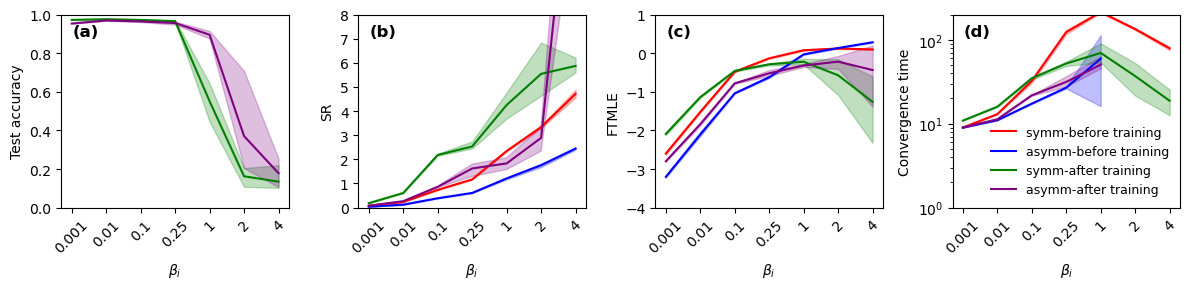

0


In [13]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

#----------------
for isymm,fsymm in enumerate([True, False, True, False]):
    labeltrain = 'before training' if isymm<2 else 'after training'
    labelsymm = 'symm' if fsymm else 'asymm'
    labelfig = f"{labelsymm}-{labeltrain}"
    if isymm<2:
        plt.subplot(141)
        tmp = res[isymm][:,:,2,-1]
        # plt.semilogx(bscR, np.mean(tmp, axis=1), color=colors[col], label=f'SR')  #  plot
        plt.plot(np.arange(len(bscR)), np.mean(tmp, axis=1), color=colors[isymm+2], label=f'{labelfig}')  #  plot
        plt.fill_between(np.arange(len(bscR)), np.min(tmp, axis=1), np.max(tmp, axis=1), alpha=0.25, color=colors[isymm+2])
        plt.xticks(np.arange(len(bscR)), bscR, rotation=45)
        # plt.legend(frameon=False, fancybox=False, shadow=False)
        plt.ylim([0, 1])
        plt.xlabel(r'$\beta_i$')
        plt.ylabel(f'Test accuracy')

    plt.subplot(142)
    tmp = SRarray[isymm]
    # plt.semilogx(bscR, np.mean(tmp, axis=1), color=colors[col], label=f'SR')  #  plot
    plt.plot(np.arange(len(bscR)), np.mean(tmp, axis=1), color=colors[isymm], label=f'{labelfig}')  #  plot
    plt.fill_between(np.arange(len(bscR)), np.min(tmp, axis=1), np.max(tmp, axis=1), alpha=0.25, color=colors[isymm])
    plt.xticks(np.arange(len(bscR)), bscR, rotation=45)
    # plt.legend(frameon=False, fancybox=False, shadow=False)
    plt.ylim([0, 8])
    plt.yticks(range(9))
    plt.xlabel(r'$\beta_i$')
    plt.ylabel(f'SR')

    plt.subplot(143)
    tmp = FTMLEarray[isymm]
    # plt.semilogx(bscR, np.mean(tmp, axis=1), color=colors[col], label=f'SR')  #  plot
    plt.plot(np.arange(len(bscR)), np.mean(tmp, axis=1), color=colors[isymm], label=f'{labelfig}')  #  plot
    plt.fill_between(np.arange(len(bscR)), np.min(tmp, axis=1), np.max(tmp, axis=1), alpha=0.25, color=colors[isymm])
    plt.xticks(np.arange(len(bscR)), bscR, rotation=45)
    # plt.legend(frameon=False, fancybox=False, shadow=False)
    plt.ylim([-4, 1])
    plt.xlabel(r'$\beta_i$')
    plt.ylabel(f'FTMLE')

    plt.subplot(144)
    tmp = convTlarray[isymm]
    # plt.semilogx(bscR, np.mean(tmp, axis=1), color=colors[col], label=f'SR')  #  plot
    plt.semilogy(np.arange(len(bscR)), np.mean(tmp, axis=1), color=colors[isymm], label=f'{labelfig}')  #  plot
    plt.fill_between(np.arange(len(bscR)), np.min(tmp, axis=1), np.max(tmp, axis=1), alpha=0.25, color=colors[isymm])
    plt.xticks(np.arange(len(bscR)), bscR, rotation=45)
    plt.legend(frameon=False, fancybox=False, shadow=False,fontsize = 9)
    plt.ylim([1,200])
    plt.xlabel(r'$\beta_i$')
    plt.ylabel(f'Convergence time')

for i, ax in enumerate(axes.flatten()):
    ax.text(0.05, 0.95, labelsabc[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
plt.tight_layout()

if config.save: plt.savefig(res_path / f"FIG_bsc_SR_MLE_FTMLE_CT.svg", format="svg")  #  
if config.save: plt.savefig(res_path / f"FIG_bsc_SR_MLE_FTMLE_CT.pdf", format="pdf")  # 

plt.show()
print('0')